# This notebook fully trains the Inception v3 model with TCGA-LUAD images to classify mutations

### We first define the location of the DeepPATH repo, as well as base paths where results and other data are saved.

In [1]:
import os, sys, json, shutil
from os.path import join
import psutil

cpus = psutil.cpu_count()
#deep_path = join(os.environ["HOME"],'DeepPATH')
deeppath_code = join(os.environ["HOME"],'DeepPATH/DeepPATH_code')
deeppath_data = '/mnt/disks/deeppath-data'
data_base = join(deeppath_data,'Data')
raw_images = join(data_base,'Raw')
data_labels = join(data_base,'data_labels')
#tilings = join(data_base,'tilings')
inception_checkpoints = join(deeppath_data,'inception_checkpoints')

for d in (deeppath_data, data_base, raw_images, inception_checkpoints):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data exists
/mnt/disks/deeppath-data/Data exists
/mnt/disks/deeppath-data/Data/Raw exists
/mnt/disks/deeppath-data/inception_checkpoints exists


In [2]:
# Various GCS buckets and relevant defines
cgc_deeppath_bucket = 'cgc-deeppath' # Bucket containing users credentials
deeppath_data_bucket = 'deeppath-data-whc' # Bucket where results are saved

svs_images_bucket = 'imaging-west'# Bucket containing TCGA pathology images


# Specify tiling parameters
### We place results into a tiling specific directory tree. The first four values below control the tiling. Change these to perform a different tiling. Note that Inception V3 wants 299 pixel tiles; any other size will be scaled by tensor flow before submission to the model. In other words, leave tile_size at 299 and overlap at 0.

In [3]:
tile_size = 299
overlap = 0
background = 25
magnification = 20
tiling_params = "Px{}Ol{}Bg{}Mg{}_Tile".format(str(tile_size), str(overlap), str(background),str(magnification))
tiling = join(data_base, tiling_params)
tiling_logs = join(tiling,'logs')
# Directory where tiles are stored              
tiles = join(tiling,'tiles')
images_metadata = 'images_metadata.json' # Name of images metadata file  (which will be created below)
images_metadata_path = join(tiling, images_metadata) # Path to images metadata file

for d in (tiling, tiling_logs, tiles):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/tiles exists


# Specify sorting parameter
### We use Option 10 for multiclass classifaction

In [4]:
sorting_option = 10
#sortings = join(tiling, 'sortings')

sorting_params = 'So{}Mu{}_Sort'.format(sorting_option,'NonSilent')
sorting = join(tiling, sorting_params)
sorting_logs = join(sorting, 'logs')
sorted_tiles = join(sorting, 'sorted')

mutations_metadata = 'mutations_metadata.txt' # Name of mutation metadata file  (which will be created below)
mutations_metadata_path = join(sorting, mutations_metadata) # Path to metadata file
hugo_symbols_path = join(sorting, 'hugo_symbols.txt')

# Directories where sharded tensor flow formatted records are stored
trainValid_records = join(sorting, 'TFRecord_TrainValid')
test_records = join(sorting, 'TFRecord_Test')
for d in (sorting, sorting_logs, sorted_tiles, trainValid_records, test_records):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/sorted exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/TFRecord_TrainValid exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/TFRecord_Test exists


# Get metadata from BQ

### Rather than obtain metdata from the GDC, we perform an SQL query to obtain the names of LUAD images and corresponding mutation calls.

### In order to perform a BQ query, we must first establish our credentials
See https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries#bigquery_simple_app_query-python for help. Put your credentials in some GCS bucket and modify the "bucket" and "credentials" variables below as necessary

In [12]:
from gcs_access import upload_from_GCS
bucket = 'cgc-deeppath'                                                                                         
credentials = 'GAC.json' 
upload_from_GCS(bucket, credentials, "/tmp/GAC.json")
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/tmp/GAC.json"

Blob GAC.json uploaded to /tmp/GAC.json.


### Now perform a BQ query to get metadata. 

For this purpose, we call query_mutation_metadata(), passing it the SQL query string. query_mutation_metadata() also formats the returned data in the format expected by the tiling and sorting phases.

In [13]:
from get_metadata_from_bq import query_mutation_metadata

sql_query = """
WITH
  luads AS (
  SELECT
    t1.file_gdc_id AS file_gdc_id,
    t1.svsFilename AS svsFilename,
    t1.sample_barcode AS sample_barcode,
    t2.callerName AS callerName,
    t2.Hugo_Symbol AS Hugo_Symbol,
    t2.Variant_Classification AS Variant_Classification
  FROM
    `isb-cgc.metadata.TCGA_slide_images` t1
  INNER JOIN
    `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation` t2
  ON
    t1.sample_barcode = t2.sample_barcode_tumor
  WHERE
    (t2.project_short_name='TCGA-LUAD')
    AND NOT t1.slide_barcode LIKE '%TCGA-__-____-___-__-D%'),
  mutations AS (
  SELECT
    file_gdc_id,
    svsFilename,
    sample_barcode,
    Hugo_Symbol,
    Variant_Classification
  FROM
    luads
  WHERE
    callerName LIKE '%mutect%'
    AND Hugo_Symbol IN ('EGFR',
      'FAT1',
      'FAT4',
      'KEAP1',
      'KRAS',
      'LRP1B',
      'NF1',
      'SETBP1',
      'STK11',
      'TP53')
    AND Variant_Classification IN ('Missense_Mutation',
      'In_Frame_Del',
      'In_Frame_Ins',
      'Frame_Shift',
      'Frame_Shift_Del',
      'Frame_Shift_Ins',
      'Nonsense_Mutation',
      'Nonstop_Mutation' )),
  wts AS (
  SELECT
    file_gdc_id,
    svsFilename,
    sample_barcode,
    'WT' AS Hugo_Symbol,
    '' AS Variant_Classification
  FROM
    luads
  WHERE
    sample_barcode NOT IN (
    SELECT
      sample_barcode
    FROM
      mutations))
SELECT
  file_gdc_id,
  svsFilename,
  sample_barcode,
  Hugo_Symbol,
  Variant_Classification
FROM
  mutations
UNION DISTINCT
SELECT
  file_gdc_id,
  svsFilename,
  sample_barcode,
  Hugo_Symbol,
  Variant_Classification
FROM
  wts
ORDER BY
  sample_barcode,
  Hugo_Symbol  """

query_mutation_metadata(images_metadata_path, mutations_metadata_path, hugo_symbols_path, sql_query)


# Specify training, validation, test, and  parameters

In [6]:
# class_number is the number of mutations that we are classifying
class_number = !cat $hugo_symbols_path |wc -l
class_number = int(class_number[0])

# True==Transfer learning, False==Full training 
fine_tune = False 

# Use sigmoid for multi-class classification
training_mode = '1_sigmoid' 

#trainings = join(sorting, "trainings")
training_params = "Cl{}Ft{}_Train".format(str(class_number),str(fine_tune))
training = join(sorting, training_params)
training_logs = join(training, 'logs')

# Directory where pretrained checkpoints are stored
pretrained_checkpoints = join(training, 'pretrained_checkpoints')
# Directory where intermediate training checkpoints are stored
intermediate_checkpoints = join(training, 'intermediate_checkpoints')
# Directory where validation and test results are stored
eval_results = join(training, 'eval_results')
test_results = join(training, 'test_results')
roc_curves = join(training, 'roc_curves')
heatmaps = join(training,'Px'+str(tile_size))

for d in (training, training_logs, intermediate_checkpoints, pretrained_checkpoints,
         eval_results, test_results, roc_curves):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/intermediate_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/pretrained_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/eval_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/test_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/roc_curves exists


# Tile the images listed in the manifest
Images are uploaded, one at a time, from GCS and tiled according to parameters

### Optionally load previously saved results from GCS

In [51]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params,'data.tar')
loc = join(tiling,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall()

    !rm $loc
else:
    print('{} not found'.format(loc))

('gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/data.tar.gz', '/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/data.tar.gz')
Found


## Perform tiling

In [5]:
import json
import shutil
tiler = join(deeppath_code, '00_preprocessing/0b_tileLoop_deepzoom4.py')
out_log_file = join(tiling_logs,'tiler_out.log')
err_log_file = join(tiling_logs,'tiler_err.log')
!rm $out_log_file
!rm $err_log_file
!rm $raw_images/*
skipped_file_name = ""
skipped_file_id = ""
with open(images_metadata_path) as fid:
    jdata = json.loads(fid.read())
    jdata.sort(key = lambda x: x['file_name'])
    for file in jdata:
        print("")
        print("Checking {}".format(file))
        tiled_dziname = join(tiles,file['file_name'].rsplit('.',1)[0]+'.dzi')
        tiled_filesname = join(tiles,file['file_name'].rsplit('.',1)[0]+'_files')
        
        if os.path.exists(tiled_dziname):
            # If the .dzi file exists, then we presume that tiling was completed
            skipped_file_name = file['file_name']
            skipped_file_id = file['file_id']
            print("Skipping {}".format(file['file_name']))
        else:
            print("Processing {}".format(file['file_name']))
            if os.path.exists(tiled_filesname):
                # Apparently this file was only partially tiled, so delete it completely
                print ("removing {}".format(tiled_filesname))
                shutil.rmtree(tiled_filesname)
            GCS_filename = 'gs://'+join(svs_images_bucket,file['file_id'],file['file_name'])
            local_filename = join(raw_images,file['file_name'])
            oldstderr = sys.stderr
            sys.stderr = open(err_log_file, 'a')
            oldstdout = sys.stdout
            sys.stdout = open(out_log_file, 'a')
            !gsutil -m cp $GCS_filename $local_filename
            !python $tiler --output=$tiles --Mag=$magnification \
                --size=$tile_size --overlap=$overlap --Background=$background --jobs=$cpus \
                $raw_images/*svs
            #print("gsutil -m cp {} {}".format(GCS_filename, local_filename))
            !rm $local_filename
            sys.stderr = oldstderr
            sys.stdout = oldstdout


rm: cannot remove '/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/logs/tiler_out.log': No such file or directory
rm: cannot remove '/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/logs/tiler_err.log': No such file or directory
rm: cannot remove '/mnt/disks/deeppath-data/Data/Raw/*': No such file or directory

Checking {u'file_name': u'TCGA-05-4244-01A-01-BS1.90f043f6-e8d5-4cfd-b4e7-84207bc499a6.svs', u'file_id': u'51c9f202-2185-48bc-b04b-3eeee9279381'}
Skipping TCGA-05-4244-01A-01-BS1.90f043f6-e8d5-4cfd-b4e7-84207bc499a6.svs

Checking {u'file_name': u'TCGA-05-4244-01A-01-TS1.6c46d8c3-d7b4-4513-af31-9170244d60a7.svs', u'file_id': u'4ba49cb2-278f-40e9-8503-7d74d07118c0'}
Skipping TCGA-05-4244-01A-01-TS1.6c46d8c3-d7b4-4513-af31-9170244d60a7.svs

Checking {u'file_name': u'TCGA-05-4249-01A-01-BS1.38c41760-cc43-4904-9575-803d1d92b992.svs', u'file_id': u'99a841da-4967-4221-b26f-c723eaccea91'}
Skipping TCGA-05-4249-01A-01-BS1.38c41760-cc43-4904-9575-803d1d92b992.svs

Checking {u'file_

Checking {u'file_name': u'TCGA-53-A4EZ-01A-01-TSA.8947DF62-4243-4F5A-8DE0-23A725AC9124.svs', u'file_id': u'beec87b0-94fa-47b6-bc88-78df44ee4e02'}
Skipping TCGA-53-A4EZ-01A-01-TSA.8947DF62-4243-4F5A-8DE0-23A725AC9124.svs

Checking {u'file_name': u'TCGA-55-1592-01A-01-BS1.bf9e8623-c9ae-443d-b777-5ce0a609f48e.svs', u'file_id': u'8035cf61-26bd-4dc8-bafa-4bdc4798555c'}
Skipping TCGA-55-1592-01A-01-BS1.bf9e8623-c9ae-443d-b777-5ce0a609f48e.svs

Checking {u'file_name': u'TCGA-55-1592-01A-01-TS1.b3070338-f5de-401d-a587-dbc8041a270b.svs', u'file_id': u'bfd9ce3c-8e35-4275-9eba-4446e5485642'}
Skipping TCGA-55-1592-01A-01-TS1.b3070338-f5de-401d-a587-dbc8041a270b.svs

Checking {u'file_name': u'TCGA-55-1594-01A-01-BS1.c28630c1-e648-465f-ab4d-8676fe5f8ac6.svs', u'file_id': u'5148f468-5a06-4254-ba51-935de6065fb0'}
Skipping TCGA-55-1594-01A-01-BS1.c28630c1-e648-465f-ab4d-8676fe5f8ac6.svs

Checking {u'file_name': u'TCGA-55-1594-01A-01-TS1.20b8b9ff-6239-455f-92d5-8ef50672340a.svs', u'file_id': u'a305a2cc-

Skipping TCGA-L4-A4E5-01A-01-TSA.F2860E58-BFE8-444D-BACF-04C1594B6656.svs

Checking {u'file_name': u'TCGA-L4-A4E6-01A-01-TSA.4F4C72C6-8BB1-4608-BBCA-8CC29FC25BEB.svs', u'file_id': u'2db43161-f07c-4504-8903-fa2aff2ead22'}
Skipping TCGA-L4-A4E6-01A-01-TSA.4F4C72C6-8BB1-4608-BBCA-8CC29FC25BEB.svs

Checking {u'file_name': u'TCGA-L9-A443-01A-01-TSA.73AF0603-4992-4DD1-8FCD-1ADC290382BE.svs', u'file_id': u'363eede5-c398-4542-b7d7-790ac3bd66f1'}
Skipping TCGA-L9-A443-01A-01-TSA.73AF0603-4992-4DD1-8FCD-1ADC290382BE.svs

Checking {u'file_name': u'TCGA-L9-A444-01A-02-TS2.C284BE25-0367-4B78-A70A-B4B22A73E835.svs', u'file_id': u'5e9a63d1-5285-464b-a542-093997aedc11'}
Skipping TCGA-L9-A444-01A-02-TS2.C284BE25-0367-4B78-A70A-B4B22A73E835.svs

Checking {u'file_name': u'TCGA-L9-A50W-01A-01-TS1.9D074435-CE6B-49C9-A777-03915F6E0132.svs', u'file_id': u'2b58a92f-e8d4-4ca2-8839-0944948a8dff'}
Skipping TCGA-L9-A50W-01A-01-TS1.9D074435-CE6B-49C9-A777-03915F6E0132.svs

Checking {u'file_name': u'TCGA-L9-A5IP-01

### Optionally save tiling results to GCS

In [5]:
import tarfile

# Populate the tar file. Don't try to compress.
loc = join(tiling,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [tiles, tiling_logs]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params,'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/data.tar.gz [Content-Type=application/x-tar]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1/1 files][ 30.9 GiB/ 30.9 GiB] 100% Done  84.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/30.9 GiB.                                     


# Sort tiles


### Optionally load previously saved sorting results from GCS

In [67]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, sorting_params, 'data.tar.gz')
loc = join(sorting,'data.tar.gz')

result = !gsutil ls $gcs
if result[0] == gcs:
    !gsutil -m cp $gcs $loc 
    
    !ls -l $loc
    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

Copying gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/data.tar.gz...
\ [1/1 files][  5.8 GiB/  5.8 GiB] 100% Done  73.8 MiB/s ETA 00:00:00           
Operation completed over 1 objects/5.8 GiB.                                      
-rw-r--r-- 1 bcliffor bcliffor 6178730916 Apr 22 19:58 /mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/data.tar.gz


## Perform the sort

In [17]:
# The sort routine outputs to the cwd. So change cwd as needed.
# First, remove existing sort results
try:
    shutil.rmtree(sorted_tiles)
except:
    pass
os.mkdir(sorted_tiles)
cwd = os.getcwd()
os.chdir(sorted_tiles)

func = join(deeppath_code,'00_preprocessing/0d_SortTiles.py' )
root = func.rsplit('/',1)[1].split('.')[0]

out_log_file = join(sorting_logs,root+'.out.log')
err_log_file = join(sorting_logs,root+'.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

%xmode Verbose

try:
    !python $func --SourceFolder=$tiles --JsonFile=$images_metadata_path --PercentValid=15 --PercentTest=15 \
        --PatientID=12 --Magnification=$magnification --MagDiffAllowed=0.0 --SortingOption=$sorting_option --nSplit=0
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout
    os.chdir(cwd)


# Convert the JPEG tiles into TFRecord format for the multiple mutations
## First format the training and validation data

In [7]:
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(trainValid_records)
except:
    pass
os.mkdir(trainValid_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_image_data_multiClass.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(sorting_logs,root+'.train.out.log')
err_log_file = join(sorting_logs,root+'.train.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

try:
    !python $func --directory=$sorted_tiles/tiles --output_directory=$trainValid_records --train_shards=1024 \
        --validation_shards=128 --num_threads=$cpus  --labels_names=$hugo_symbols_path --labels=$mutations_metadata_path \
        --PatientID=12
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout


## Now format the test data

In [35]:
# Remove existing TFRecord conversion results
# Note that it seems that num_threads must be 1. Using more than one thread cause corruption of the resulting files!
try:
    shutil.rmtree(test_records)
except:
    pass
os.mkdir(test_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_TF_test_multiClass.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(sorting_logs,root+'.test.out.log')
err_log_file = join(sorting_logs,root+'.test.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

try:
    !python $func --directory=$sorted_tiles/tiles --output_directory=$test_records --train_shards=1024 \
        --validation_shards=128 --num_threads=1 --one_FT_per_Tile=False --ImageSet_basename='test' \
        --labels_names=$hugo_symbols_path --labels=$mutations_metadata_path \
        --PatientID=12
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout


## Optionally save sorting results to GCS

In [ ]:
import tarfile

# Populate the tar file
loc = join(sorting,'data.tar')
with tarfile.open(loc, "w") as tar:
    #for name in [sorting_logs, sorted_tiles, trainValid_records, test_records]:
    for name in [trainValid_records, test_records]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params, sorting_params, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

# Training

## Optionally load previously saved training results from GCS

In [70]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, sorting_params, training_params, 'data.tar')
loc = join(training,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/data.tar.gz not found


## We first have to install the Bazel build tool

In [ ]:
!sudo apt-get install -y pkg-config zip g++ zlib1g-dev unzip python
!wget https://github.com/bazelbuild/bazel/releases/download/0.24.0/bazel-0.24.0-installer-linux-x86_64.sh
!chmod +x bazel-0.24.0-installer-linux-x86_64.sh
!./bazel-0.24.0-installer-linux-x86_64.sh --user
os.environ["PATH"] += ":" + join(os.getcwd(),'bin')
!rm bazel-0.24.0-installer-linux-x86_64.sh


## Next build the Inception model

In [ ]:
#os.chdir(join(os.environ["HOME"],'DeepPATH/DeepPATH_code/s01_training/xClasses'))
cwd = os.getcwd()
os.chdir(join(deeppath_code,'01_training/xClasses'))
print(os.getcwd())
!bazel build inception/imagenet_train


 ## Fully train the model

In [ ]:
function = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )

# Track the number of training batches
batches = 0

root = function.rsplit('/',1)[1]
# Note that the --train_dir directory appears to be deleted and recreated
!python $function \
    --num_gpus=1 --batch_size=30 --train_dir=$intermediate_checkpoints --data_dir=$trainValid_records \
    --ClassNumber=$class_number --mode=$training_mode

!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Colocations handled automatically by placer.
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for u

2019-05-28 18:31:44.356982: step 60, loss = 4.00 (23.2 examples/sec; 1.294 sec/batch)
2019-05-28 18:31:57.457636: step 70, loss = 4.02 (22.7 examples/sec; 1.320 sec/batch)
2019-05-28 18:32:10.615850: step 80, loss = 3.98 (23.6 examples/sec; 1.273 sec/batch)
2019-05-28 18:32:23.616800: step 90, loss = 3.97 (22.6 examples/sec; 1.329 sec/batch)
2019-05-28 18:32:36.790313: step 100, loss = 3.99 (22.5 examples/sec; 1.331 sec/batch)
2019-05-28 18:32:58.484849: step 110, loss = 3.95 (22.6 examples/sec; 1.325 sec/batch)
2019-05-28 18:33:11.362026: step 120, loss = 3.89 (23.8 examples/sec; 1.262 sec/batch)
2019-05-28 18:33:24.381684: step 130, loss = 4.03 (23.6 examples/sec; 1.274 sec/batch)
2019-05-28 18:33:37.448528: step 140, loss = 3.92 (22.8 examples/sec; 1.315 sec/batch)
2019-05-28 18:33:50.510754: step 150, loss = 4.05 (23.5 examples/sec; 1.279 sec/batch)
2019-05-28 18:34:03.652366: step 160, loss = 3.91 (23.3 examples/sec; 1.288 sec/batch)
2019-05-28 18:34:16.705417: step 170, loss = 3.

2019-05-28 18:53:47.555365: step 1010, loss = 3.79 (23.8 examples/sec; 1.258 sec/batch)
2019-05-28 18:54:00.526058: step 1020, loss = 3.73 (23.9 examples/sec; 1.254 sec/batch)
2019-05-28 18:54:13.704366: step 1030, loss = 3.68 (22.7 examples/sec; 1.324 sec/batch)
2019-05-28 18:54:26.692521: step 1040, loss = 3.70 (22.8 examples/sec; 1.317 sec/batch)
2019-05-28 18:54:39.743428: step 1050, loss = 3.67 (23.6 examples/sec; 1.272 sec/batch)
2019-05-28 18:54:52.837425: step 1060, loss = 3.72 (23.8 examples/sec; 1.258 sec/batch)
2019-05-28 18:55:05.953214: step 1070, loss = 3.68 (22.8 examples/sec; 1.317 sec/batch)
2019-05-28 18:55:18.993322: step 1080, loss = 3.61 (22.8 examples/sec; 1.318 sec/batch)
2019-05-28 18:55:32.006793: step 1090, loss = 3.73 (22.9 examples/sec; 1.311 sec/batch)
2019-05-28 18:55:45.159127: step 1100, loss = 3.75 (22.7 examples/sec; 1.321 sec/batch)
2019-05-28 18:56:06.480475: step 1110, loss = 3.67 (23.1 examples/sec; 1.296 sec/batch)
2019-05-28 18:56:19.413676: step

2019-05-28 19:15:27.661701: step 1950, loss = 3.50 (22.6 examples/sec; 1.326 sec/batch)
2019-05-28 19:15:40.744959: step 1960, loss = 3.38 (22.6 examples/sec; 1.325 sec/batch)
2019-05-28 19:15:53.763590: step 1970, loss = 3.44 (23.1 examples/sec; 1.298 sec/batch)
2019-05-28 19:16:06.866307: step 1980, loss = 3.54 (23.2 examples/sec; 1.295 sec/batch)
2019-05-28 19:16:19.911163: step 1990, loss = 3.46 (22.4 examples/sec; 1.339 sec/batch)
2019-05-28 19:16:32.949648: step 2000, loss = 3.47 (23.3 examples/sec; 1.290 sec/batch)
2019-05-28 19:16:54.123932: step 2010, loss = 3.44 (22.6 examples/sec; 1.330 sec/batch)
2019-05-28 19:17:07.081759: step 2020, loss = 3.40 (23.5 examples/sec; 1.275 sec/batch)
2019-05-28 19:17:20.134574: step 2030, loss = 3.44 (23.2 examples/sec; 1.291 sec/batch)
2019-05-28 19:17:33.050506: step 2040, loss = 3.49 (23.4 examples/sec; 1.282 sec/batch)
2019-05-28 19:17:46.071779: step 2050, loss = 3.44 (22.6 examples/sec; 1.330 sec/batch)
2019-05-28 19:17:59.164866: step

2019-05-28 19:37:09.730187: step 2890, loss = 3.26 (23.3 examples/sec; 1.287 sec/batch)
2019-05-28 19:37:22.897614: step 2900, loss = 3.35 (22.8 examples/sec; 1.315 sec/batch)
2019-05-28 19:37:44.092018: step 2910, loss = 3.23 (23.9 examples/sec; 1.256 sec/batch)
2019-05-28 19:37:57.108936: step 2920, loss = 3.23 (23.2 examples/sec; 1.291 sec/batch)
2019-05-28 19:38:10.172264: step 2930, loss = 3.25 (23.4 examples/sec; 1.283 sec/batch)
2019-05-28 19:38:23.229046: step 2940, loss = 3.23 (22.7 examples/sec; 1.322 sec/batch)
2019-05-28 19:38:36.225301: step 2950, loss = 3.21 (23.5 examples/sec; 1.277 sec/batch)
2019-05-28 19:38:49.295453: step 2960, loss = 3.25 (23.6 examples/sec; 1.272 sec/batch)
2019-05-28 19:39:02.451063: step 2970, loss = 3.19 (23.5 examples/sec; 1.275 sec/batch)
2019-05-28 19:39:15.483602: step 2980, loss = 3.24 (23.1 examples/sec; 1.299 sec/batch)
2019-05-28 19:39:28.492318: step 2990, loss = 3.29 (22.6 examples/sec; 1.327 sec/batch)
2019-05-28 19:39:41.535676: step

2019-05-28 19:58:59.244027: step 3830, loss = 3.06 (23.5 examples/sec; 1.277 sec/batch)
2019-05-28 19:59:12.405548: step 3840, loss = 3.02 (22.5 examples/sec; 1.335 sec/batch)
2019-05-28 19:59:25.583999: step 3850, loss = 3.06 (22.7 examples/sec; 1.321 sec/batch)
2019-05-28 19:59:38.636863: step 3860, loss = 3.10 (22.3 examples/sec; 1.346 sec/batch)
2019-05-28 19:59:51.605827: step 3870, loss = 3.07 (23.4 examples/sec; 1.284 sec/batch)
2019-05-28 20:00:04.682889: step 3880, loss = 3.03 (22.8 examples/sec; 1.318 sec/batch)
2019-05-28 20:00:17.688721: step 3890, loss = 3.11 (22.3 examples/sec; 1.346 sec/batch)
2019-05-28 20:00:30.680912: step 3900, loss = 3.04 (23.7 examples/sec; 1.264 sec/batch)
2019-05-28 20:00:51.853633: step 3910, loss = 3.06 (22.5 examples/sec; 1.331 sec/batch)
2019-05-28 20:01:04.897349: step 3920, loss = 3.07 (22.5 examples/sec; 1.336 sec/batch)
2019-05-28 20:01:17.942925: step 3930, loss = 3.02 (23.6 examples/sec; 1.271 sec/batch)
2019-05-28 20:01:31.097453: step

2019-05-28 20:20:39.177333: step 4770, loss = 2.92 (23.1 examples/sec; 1.298 sec/batch)
2019-05-28 20:20:52.358401: step 4780, loss = 2.91 (22.9 examples/sec; 1.310 sec/batch)
2019-05-28 20:21:05.560889: step 4790, loss = 2.90 (22.8 examples/sec; 1.315 sec/batch)
2019-05-28 20:21:18.581208: step 4800, loss = 2.87 (22.6 examples/sec; 1.327 sec/batch)
2019-05-28 20:21:39.920056: step 4810, loss = 2.86 (23.0 examples/sec; 1.305 sec/batch)
2019-05-28 20:21:52.910872: step 4820, loss = 2.82 (22.3 examples/sec; 1.342 sec/batch)
2019-05-28 20:22:06.058029: step 4830, loss = 2.90 (22.5 examples/sec; 1.334 sec/batch)
2019-05-28 20:22:19.280149: step 4840, loss = 2.82 (22.3 examples/sec; 1.345 sec/batch)
2019-05-28 20:22:32.640773: step 4850, loss = 2.89 (22.1 examples/sec; 1.355 sec/batch)
2019-05-28 20:22:45.720034: step 4860, loss = 2.84 (23.1 examples/sec; 1.297 sec/batch)
2019-05-28 20:22:58.769432: step 4870, loss = 2.86 (22.7 examples/sec; 1.324 sec/batch)
2019-05-28 20:23:11.758711: step

2019-05-28 20:42:35.890089: step 5710, loss = 2.70 (23.5 examples/sec; 1.274 sec/batch)
2019-05-28 20:42:48.910114: step 5720, loss = 2.70 (22.7 examples/sec; 1.322 sec/batch)
2019-05-28 20:43:01.879287: step 5730, loss = 2.68 (23.7 examples/sec; 1.268 sec/batch)
2019-05-28 20:43:14.851305: step 5740, loss = 2.72 (23.3 examples/sec; 1.287 sec/batch)
2019-05-28 20:43:27.740682: step 5750, loss = 2.67 (23.1 examples/sec; 1.300 sec/batch)
2019-05-28 20:43:40.737875: step 5760, loss = 2.70 (23.1 examples/sec; 1.297 sec/batch)
2019-05-28 20:44:52.973416: step 5810, loss = 2.75 (23.2 examples/sec; 1.292 sec/batch)
2019-05-28 20:45:05.800031: step 5820, loss = 2.62 (23.4 examples/sec; 1.280 sec/batch)
2019-05-28 20:45:18.848518: step 5830, loss = 2.70 (22.9 examples/sec; 1.308 sec/batch)
2019-05-28 20:45:31.765731: step 5840, loss = 2.68 (23.8 examples/sec; 1.261 sec/batch)
2019-05-28 20:45:44.698112: step 5850, loss = 2.62 (22.4 examples/sec; 1.337 sec/batch)
2019-05-28 20:45:57.687257: step

2019-05-28 21:05:03.088923: step 6690, loss = 2.53 (22.7 examples/sec; 1.323 sec/batch)
2019-05-28 21:05:15.933899: step 6700, loss = 2.58 (23.8 examples/sec; 1.259 sec/batch)
2019-05-28 21:05:35.931289: step 6710, loss = 2.53 (23.2 examples/sec; 1.295 sec/batch)
2019-05-28 21:05:48.776356: step 6720, loss = 2.57 (23.4 examples/sec; 1.283 sec/batch)
2019-05-28 21:06:01.634497: step 6730, loss = 2.56 (23.6 examples/sec; 1.271 sec/batch)
2019-05-28 21:06:14.748205: step 6740, loss = 2.53 (22.9 examples/sec; 1.309 sec/batch)
2019-05-28 21:06:27.677021: step 6750, loss = 2.51 (23.0 examples/sec; 1.304 sec/batch)
2019-05-28 21:06:40.716449: step 6760, loss = 2.53 (22.8 examples/sec; 1.315 sec/batch)
2019-05-28 21:06:53.611298: step 6770, loss = 2.45 (22.8 examples/sec; 1.315 sec/batch)
2019-05-28 21:07:06.734127: step 6780, loss = 2.58 (22.8 examples/sec; 1.318 sec/batch)
2019-05-28 21:07:19.727026: step 6790, loss = 2.57 (22.8 examples/sec; 1.314 sec/batch)
2019-05-28 21:07:32.582057: step

2019-05-28 21:26:46.036229: step 7630, loss = 2.42 (22.6 examples/sec; 1.329 sec/batch)
2019-05-28 21:26:59.033703: step 7640, loss = 2.40 (23.7 examples/sec; 1.268 sec/batch)
2019-05-28 21:27:12.021932: step 7650, loss = 2.44 (23.4 examples/sec; 1.281 sec/batch)
2019-05-28 21:27:25.139008: step 7660, loss = 2.36 (23.8 examples/sec; 1.261 sec/batch)
2019-05-28 21:27:38.170733: step 7670, loss = 2.49 (23.1 examples/sec; 1.297 sec/batch)
2019-05-28 21:27:51.153425: step 7680, loss = 2.35 (23.4 examples/sec; 1.281 sec/batch)
2019-05-28 21:28:04.154358: step 7690, loss = 2.44 (23.1 examples/sec; 1.297 sec/batch)
2019-05-28 21:28:17.123051: step 7700, loss = 2.41 (23.2 examples/sec; 1.295 sec/batch)
2019-05-28 21:28:37.959550: step 7710, loss = 2.41 (22.9 examples/sec; 1.308 sec/batch)
2019-05-28 21:28:50.910820: step 7720, loss = 2.37 (23.9 examples/sec; 1.254 sec/batch)
2019-05-28 21:29:03.839670: step 7730, loss = 2.38 (23.0 examples/sec; 1.303 sec/batch)
2019-05-28 21:29:16.943584: step

2019-05-28 21:48:20.841665: step 8570, loss = 2.31 (22.7 examples/sec; 1.319 sec/batch)
2019-05-28 21:48:33.897721: step 8580, loss = 2.36 (22.2 examples/sec; 1.351 sec/batch)
2019-05-28 21:48:47.047995: step 8590, loss = 2.27 (22.7 examples/sec; 1.324 sec/batch)
2019-05-28 21:49:00.082931: step 8600, loss = 2.31 (23.5 examples/sec; 1.274 sec/batch)
2019-05-28 21:49:21.033809: step 8610, loss = 2.31 (23.1 examples/sec; 1.300 sec/batch)
2019-05-28 21:49:34.160511: step 8620, loss = 2.20 (22.8 examples/sec; 1.317 sec/batch)
2019-05-28 21:49:47.239872: step 8630, loss = 2.22 (22.3 examples/sec; 1.347 sec/batch)
2019-05-28 21:50:00.105130: step 8640, loss = 2.25 (22.4 examples/sec; 1.338 sec/batch)
2019-05-28 21:50:13.137253: step 8650, loss = 2.28 (23.7 examples/sec; 1.264 sec/batch)
2019-05-28 21:50:26.116956: step 8660, loss = 2.28 (23.0 examples/sec; 1.306 sec/batch)
2019-05-28 21:50:38.837900: step 8670, loss = 2.29 (23.6 examples/sec; 1.271 sec/batch)
2019-05-28 21:50:51.815297: step

2019-05-28 22:09:58.798613: step 9510, loss = 2.14 (23.6 examples/sec; 1.269 sec/batch)
2019-05-28 22:10:11.916861: step 9520, loss = 2.21 (22.2 examples/sec; 1.354 sec/batch)
2019-05-28 22:10:24.905177: step 9530, loss = 2.12 (23.7 examples/sec; 1.266 sec/batch)
2019-05-28 22:10:37.943463: step 9540, loss = 2.16 (23.2 examples/sec; 1.294 sec/batch)
2019-05-28 22:10:50.941349: step 9550, loss = 2.23 (23.2 examples/sec; 1.293 sec/batch)
2019-05-28 22:11:03.984742: step 9560, loss = 2.14 (24.0 examples/sec; 1.252 sec/batch)
2019-05-28 22:11:17.026731: step 9570, loss = 2.07 (22.9 examples/sec; 1.310 sec/batch)
2019-05-28 22:11:30.022557: step 9580, loss = 2.12 (23.2 examples/sec; 1.291 sec/batch)
2019-05-28 22:11:42.969767: step 9590, loss = 2.18 (22.6 examples/sec; 1.328 sec/batch)
2019-05-28 22:11:55.756412: step 9600, loss = 2.18 (23.5 examples/sec; 1.276 sec/batch)
2019-05-28 22:12:16.375450: step 9610, loss = 2.12 (22.2 examples/sec; 1.351 sec/batch)
2019-05-28 22:12:29.388928: step

2019-05-28 22:31:20.486573: step 10440, loss = 1.99 (22.8 examples/sec; 1.316 sec/batch)
2019-05-28 22:31:33.581461: step 10450, loss = 2.06 (22.5 examples/sec; 1.336 sec/batch)
2019-05-28 22:31:46.622409: step 10460, loss = 2.05 (23.5 examples/sec; 1.278 sec/batch)
2019-05-28 22:31:59.630113: step 10470, loss = 2.01 (23.0 examples/sec; 1.304 sec/batch)
2019-05-28 22:32:12.676926: step 10480, loss = 2.03 (22.4 examples/sec; 1.338 sec/batch)
2019-05-28 22:32:25.868060: step 10490, loss = 2.06 (22.2 examples/sec; 1.349 sec/batch)
2019-05-28 22:32:38.748170: step 10500, loss = 2.07 (24.0 examples/sec; 1.248 sec/batch)
2019-05-28 22:32:59.917942: step 10510, loss = 2.02 (22.3 examples/sec; 1.344 sec/batch)
2019-05-28 22:33:12.977643: step 10520, loss = 2.07 (22.9 examples/sec; 1.308 sec/batch)
2019-05-28 22:33:26.096156: step 10530, loss = 1.97 (23.4 examples/sec; 1.280 sec/batch)
2019-05-28 22:33:39.256986: step 10540, loss = 2.07 (22.7 examples/sec; 1.322 sec/batch)
2019-05-28 22:33:52.1

2019-05-28 22:52:37.251631: step 11370, loss = 1.97 (23.9 examples/sec; 1.254 sec/batch)
2019-05-28 22:52:50.279998: step 11380, loss = 1.93 (23.5 examples/sec; 1.279 sec/batch)
2019-05-28 22:53:03.305360: step 11390, loss = 1.93 (23.0 examples/sec; 1.306 sec/batch)
2019-05-28 22:53:16.130713: step 11400, loss = 1.97 (23.3 examples/sec; 1.287 sec/batch)
2019-05-28 22:53:37.028278: step 11410, loss = 1.96 (23.3 examples/sec; 1.289 sec/batch)
2019-05-28 22:53:49.898899: step 11420, loss = 1.90 (23.7 examples/sec; 1.266 sec/batch)
2019-05-28 22:54:02.718073: step 11430, loss = 1.91 (23.7 examples/sec; 1.266 sec/batch)
2019-05-28 22:54:15.609146: step 11440, loss = 1.95 (24.1 examples/sec; 1.245 sec/batch)
2019-05-28 22:54:28.356333: step 11450, loss = 2.01 (24.2 examples/sec; 1.241 sec/batch)
2019-05-28 22:54:41.252275: step 11460, loss = 1.91 (22.5 examples/sec; 1.332 sec/batch)
2019-05-28 22:54:54.194611: step 11470, loss = 1.82 (22.6 examples/sec; 1.328 sec/batch)
2019-05-28 22:55:06.9

2019-05-28 23:13:50.799396: step 12300, loss = 1.86 (23.1 examples/sec; 1.301 sec/batch)
2019-05-28 23:14:11.400736: step 12310, loss = 1.80 (22.6 examples/sec; 1.329 sec/batch)
2019-05-28 23:14:24.383117: step 12320, loss = 1.83 (23.7 examples/sec; 1.267 sec/batch)
2019-05-28 23:14:37.370224: step 12330, loss = 1.82 (23.6 examples/sec; 1.272 sec/batch)
2019-05-28 23:14:50.399489: step 12340, loss = 1.80 (23.8 examples/sec; 1.260 sec/batch)
2019-05-28 23:15:03.449234: step 12350, loss = 1.85 (22.3 examples/sec; 1.345 sec/batch)
2019-05-28 23:15:16.498137: step 12360, loss = 1.87 (22.7 examples/sec; 1.322 sec/batch)
2019-05-28 23:15:29.481028: step 12370, loss = 1.83 (22.6 examples/sec; 1.327 sec/batch)
2019-05-28 23:15:42.587216: step 12380, loss = 1.83 (23.1 examples/sec; 1.297 sec/batch)
2019-05-28 23:15:55.589832: step 12390, loss = 1.82 (22.7 examples/sec; 1.324 sec/batch)
2019-05-28 23:16:08.600249: step 12400, loss = 1.89 (23.1 examples/sec; 1.301 sec/batch)
2019-05-28 23:16:28.6

2019-05-28 23:34:58.108474: step 13230, loss = 1.70 (23.0 examples/sec; 1.305 sec/batch)
2019-05-28 23:35:10.924468: step 13240, loss = 1.74 (24.2 examples/sec; 1.240 sec/batch)
2019-05-28 23:35:23.624839: step 13250, loss = 1.78 (22.9 examples/sec; 1.310 sec/batch)
2019-05-28 23:35:36.323685: step 13260, loss = 1.77 (23.7 examples/sec; 1.264 sec/batch)
2019-05-28 23:35:49.091627: step 13270, loss = 1.73 (23.8 examples/sec; 1.259 sec/batch)
2019-05-28 23:36:01.817263: step 13280, loss = 1.72 (23.4 examples/sec; 1.280 sec/batch)
2019-05-28 23:36:14.732739: step 13290, loss = 1.75 (23.5 examples/sec; 1.278 sec/batch)
2019-05-28 23:36:27.438132: step 13300, loss = 1.75 (23.6 examples/sec; 1.269 sec/batch)
2019-05-28 23:36:46.994498: step 13310, loss = 1.78 (23.9 examples/sec; 1.258 sec/batch)
2019-05-28 23:36:59.820256: step 13320, loss = 1.76 (24.0 examples/sec; 1.249 sec/batch)
2019-05-28 23:37:12.502095: step 13330, loss = 1.79 (23.2 examples/sec; 1.296 sec/batch)
2019-05-28 23:37:25.3

2019-05-28 23:56:04.075791: step 14160, loss = 1.63 (23.3 examples/sec; 1.289 sec/batch)
2019-05-28 23:56:17.122288: step 14170, loss = 1.71 (22.9 examples/sec; 1.310 sec/batch)
2019-05-28 23:56:29.963822: step 14180, loss = 1.65 (22.9 examples/sec; 1.310 sec/batch)
2019-05-28 23:56:42.707706: step 14190, loss = 1.68 (24.4 examples/sec; 1.229 sec/batch)
2019-05-28 23:56:55.662908: step 14200, loss = 1.70 (23.3 examples/sec; 1.289 sec/batch)
2019-05-28 23:57:15.818658: step 14210, loss = 1.67 (23.1 examples/sec; 1.300 sec/batch)
2019-05-28 23:57:28.664171: step 14220, loss = 1.67 (23.3 examples/sec; 1.285 sec/batch)
2019-05-28 23:57:41.474993: step 14230, loss = 1.68 (22.8 examples/sec; 1.318 sec/batch)
2019-05-28 23:57:54.290904: step 14240, loss = 1.66 (23.1 examples/sec; 1.301 sec/batch)
2019-05-28 23:58:07.140246: step 14250, loss = 1.65 (22.7 examples/sec; 1.320 sec/batch)
2019-05-28 23:58:19.970399: step 14260, loss = 1.60 (23.5 examples/sec; 1.279 sec/batch)
2019-05-28 23:58:32.8

2019-05-29 00:17:18.890028: step 15090, loss = 1.53 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 00:17:31.832567: step 15100, loss = 1.58 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 00:17:53.004232: step 15110, loss = 1.65 (23.9 examples/sec; 1.257 sec/batch)
2019-05-29 00:18:05.994146: step 15120, loss = 1.60 (23.1 examples/sec; 1.298 sec/batch)
2019-05-29 00:18:19.109680: step 15130, loss = 1.63 (22.7 examples/sec; 1.319 sec/batch)
2019-05-29 00:18:32.107857: step 15140, loss = 1.65 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 00:18:45.209629: step 15150, loss = 1.56 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 00:18:58.186333: step 15160, loss = 1.54 (24.0 examples/sec; 1.251 sec/batch)
2019-05-29 00:19:11.295310: step 15170, loss = 1.59 (23.0 examples/sec; 1.302 sec/batch)
2019-05-29 00:19:24.389517: step 15180, loss = 1.58 (22.5 examples/sec; 1.332 sec/batch)
2019-05-29 00:19:37.337686: step 15190, loss = 1.52 (22.4 examples/sec; 1.342 sec/batch)
2019-05-29 00:19:50.2

2019-05-29 00:38:51.772040: step 16020, loss = 1.49 (22.6 examples/sec; 1.328 sec/batch)
2019-05-29 00:39:04.743664: step 16030, loss = 1.51 (23.8 examples/sec; 1.259 sec/batch)
2019-05-29 00:39:17.878271: step 16040, loss = 1.53 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 00:39:30.691057: step 16050, loss = 1.51 (23.8 examples/sec; 1.260 sec/batch)
2019-05-29 00:39:43.805239: step 16060, loss = 1.46 (23.4 examples/sec; 1.280 sec/batch)
2019-05-29 00:39:56.880057: step 16070, loss = 1.47 (23.4 examples/sec; 1.282 sec/batch)
2019-05-29 00:40:10.035633: step 16080, loss = 1.47 (22.8 examples/sec; 1.314 sec/batch)
2019-05-29 00:40:23.191760: step 16090, loss = 1.55 (22.7 examples/sec; 1.322 sec/batch)
2019-05-29 00:40:36.291264: step 16100, loss = 1.48 (23.5 examples/sec; 1.275 sec/batch)
2019-05-29 00:40:57.274161: step 16110, loss = 1.52 (23.3 examples/sec; 1.285 sec/batch)
2019-05-29 00:41:10.183512: step 16120, loss = 1.46 (23.5 examples/sec; 1.276 sec/batch)
2019-05-29 00:41:23.3

2019-05-29 01:00:18.602323: step 16950, loss = 1.45 (23.0 examples/sec; 1.303 sec/batch)
2019-05-29 01:00:31.591065: step 16960, loss = 1.46 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 01:00:44.743149: step 16970, loss = 1.46 (22.5 examples/sec; 1.334 sec/batch)
2019-05-29 01:00:57.747308: step 16980, loss = 1.42 (23.8 examples/sec; 1.261 sec/batch)
2019-05-29 01:01:10.905656: step 16990, loss = 1.41 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 01:01:23.981452: step 17000, loss = 1.44 (22.7 examples/sec; 1.324 sec/batch)
2019-05-29 01:01:44.883773: step 17010, loss = 1.53 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 01:01:57.914710: step 17020, loss = 1.42 (23.1 examples/sec; 1.297 sec/batch)
2019-05-29 01:02:11.033799: step 17030, loss = 1.40 (22.2 examples/sec; 1.349 sec/batch)
2019-05-29 01:02:24.074272: step 17040, loss = 1.44 (23.9 examples/sec; 1.253 sec/batch)
2019-05-29 01:02:37.248050: step 17050, loss = 1.38 (23.9 examples/sec; 1.257 sec/batch)
2019-05-29 01:02:50.3

2019-05-29 01:21:43.970001: step 17880, loss = 1.43 (23.3 examples/sec; 1.286 sec/batch)
2019-05-29 01:21:56.939651: step 17890, loss = 1.46 (23.6 examples/sec; 1.272 sec/batch)
2019-05-29 01:22:09.885906: step 17900, loss = 1.33 (23.2 examples/sec; 1.294 sec/batch)
2019-05-29 01:22:31.136017: step 17910, loss = 1.36 (23.9 examples/sec; 1.254 sec/batch)
2019-05-29 01:22:44.168132: step 17920, loss = 1.45 (23.5 examples/sec; 1.278 sec/batch)
2019-05-29 01:22:57.095263: step 17930, loss = 1.44 (23.5 examples/sec; 1.276 sec/batch)
2019-05-29 01:23:10.177230: step 17940, loss = 1.33 (23.8 examples/sec; 1.260 sec/batch)
2019-05-29 01:23:23.076862: step 17950, loss = 1.40 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 01:23:36.135923: step 17960, loss = 1.39 (22.7 examples/sec; 1.319 sec/batch)
2019-05-29 01:23:49.276402: step 17970, loss = 1.36 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 01:24:02.276313: step 17980, loss = 1.38 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 01:24:15.2

2019-05-29 01:43:16.689035: step 18810, loss = 1.45 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 01:43:29.785927: step 18820, loss = 1.34 (22.0 examples/sec; 1.362 sec/batch)
2019-05-29 01:43:42.721205: step 18830, loss = 1.29 (23.2 examples/sec; 1.290 sec/batch)
2019-05-29 01:43:55.657316: step 18840, loss = 1.30 (23.6 examples/sec; 1.270 sec/batch)
2019-05-29 01:44:08.682462: step 18850, loss = 1.25 (23.3 examples/sec; 1.288 sec/batch)
2019-05-29 01:44:21.780292: step 18860, loss = 1.34 (22.5 examples/sec; 1.335 sec/batch)
2019-05-29 01:44:34.833198: step 18870, loss = 1.33 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 01:44:47.703318: step 18880, loss = 1.32 (23.3 examples/sec; 1.288 sec/batch)
2019-05-29 01:45:00.607591: step 18890, loss = 1.35 (23.8 examples/sec; 1.262 sec/batch)
2019-05-29 01:45:13.635760: step 18900, loss = 1.23 (22.4 examples/sec; 1.341 sec/batch)
2019-05-29 01:45:34.466755: step 18910, loss = 1.34 (23.6 examples/sec; 1.270 sec/batch)
2019-05-29 01:45:47.4

2019-05-29 02:04:40.683146: step 19740, loss = 1.29 (23.1 examples/sec; 1.297 sec/batch)
2019-05-29 02:04:53.613216: step 19750, loss = 1.26 (22.8 examples/sec; 1.314 sec/batch)
2019-05-29 02:05:06.552710: step 19760, loss = 1.24 (23.5 examples/sec; 1.278 sec/batch)
2019-05-29 02:05:19.672669: step 19770, loss = 1.24 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 02:05:32.827175: step 19780, loss = 1.23 (23.0 examples/sec; 1.304 sec/batch)
2019-05-29 02:05:45.852640: step 19790, loss = 1.26 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 02:05:58.872099: step 19800, loss = 1.25 (24.1 examples/sec; 1.245 sec/batch)
2019-05-29 02:06:20.182215: step 19810, loss = 1.28 (22.5 examples/sec; 1.335 sec/batch)
2019-05-29 02:06:33.210653: step 19820, loss = 1.33 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 02:06:46.041698: step 19830, loss = 1.25 (23.1 examples/sec; 1.296 sec/batch)
2019-05-29 02:06:59.121954: step 19840, loss = 1.24 (23.6 examples/sec; 1.271 sec/batch)
2019-05-29 02:07:12.1

2019-05-29 02:26:09.663583: step 20670, loss = 1.20 (22.9 examples/sec; 1.312 sec/batch)
2019-05-29 02:26:22.748233: step 20680, loss = 1.20 (23.4 examples/sec; 1.284 sec/batch)
2019-05-29 02:26:35.853162: step 20690, loss = 1.10 (22.5 examples/sec; 1.334 sec/batch)
2019-05-29 02:26:48.770037: step 20700, loss = 1.19 (22.8 examples/sec; 1.314 sec/batch)
2019-05-29 02:27:09.889915: step 20710, loss = 1.22 (23.2 examples/sec; 1.294 sec/batch)
2019-05-29 02:27:22.876423: step 20720, loss = 1.16 (22.6 examples/sec; 1.330 sec/batch)
2019-05-29 02:27:36.029945: step 20730, loss = 1.21 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 02:27:48.934552: step 20740, loss = 1.18 (23.8 examples/sec; 1.263 sec/batch)
2019-05-29 02:28:01.951103: step 20750, loss = 1.20 (23.8 examples/sec; 1.260 sec/batch)
2019-05-29 02:28:14.883512: step 20760, loss = 1.22 (22.8 examples/sec; 1.315 sec/batch)
2019-05-29 02:28:27.849067: step 20770, loss = 1.09 (23.3 examples/sec; 1.288 sec/batch)
2019-05-29 02:28:40.7

2019-05-29 02:47:34.544567: step 21600, loss = 1.21 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 02:47:55.810251: step 21610, loss = 1.14 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 02:48:08.942508: step 21620, loss = 1.12 (23.0 examples/sec; 1.306 sec/batch)
2019-05-29 02:48:22.109133: step 21630, loss = 1.21 (22.4 examples/sec; 1.338 sec/batch)
2019-05-29 02:48:34.974904: step 21640, loss = 1.18 (23.5 examples/sec; 1.277 sec/batch)
2019-05-29 02:48:48.025638: step 21650, loss = 1.23 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 02:49:01.148684: step 21660, loss = 1.16 (23.2 examples/sec; 1.291 sec/batch)
2019-05-29 02:49:14.309539: step 21670, loss = 1.20 (22.8 examples/sec; 1.317 sec/batch)
2019-05-29 02:49:27.407825: step 21680, loss = 1.18 (22.8 examples/sec; 1.315 sec/batch)
2019-05-29 02:49:40.541398: step 21690, loss = 1.09 (23.0 examples/sec; 1.303 sec/batch)
2019-05-29 02:49:53.713597: step 21700, loss = 1.10 (22.4 examples/sec; 1.342 sec/batch)
2019-05-29 02:50:14.7

2019-05-29 03:09:09.641114: step 22530, loss = 1.11 (22.9 examples/sec; 1.311 sec/batch)
2019-05-29 03:09:22.798667: step 22540, loss = 1.09 (23.0 examples/sec; 1.302 sec/batch)
2019-05-29 03:09:35.894552: step 22550, loss = 1.11 (22.8 examples/sec; 1.319 sec/batch)
2019-05-29 03:09:49.068617: step 22560, loss = 1.10 (23.2 examples/sec; 1.291 sec/batch)
2019-05-29 03:10:02.151317: step 22570, loss = 1.14 (22.5 examples/sec; 1.332 sec/batch)
2019-05-29 03:10:15.139323: step 22580, loss = 1.13 (23.1 examples/sec; 1.296 sec/batch)
2019-05-29 03:10:28.276034: step 22590, loss = 1.09 (23.0 examples/sec; 1.307 sec/batch)
2019-05-29 03:10:41.447758: step 22600, loss = 1.11 (22.3 examples/sec; 1.347 sec/batch)
2019-05-29 03:11:02.462908: step 22610, loss = 1.11 (23.1 examples/sec; 1.298 sec/batch)
2019-05-29 03:11:15.589406: step 22620, loss = 1.09 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 03:11:28.534267: step 22630, loss = 1.08 (23.2 examples/sec; 1.291 sec/batch)
2019-05-29 03:11:41.7

2019-05-29 03:30:36.575659: step 23460, loss = 1.07 (22.6 examples/sec; 1.329 sec/batch)
2019-05-29 03:30:49.607968: step 23470, loss = 1.13 (23.2 examples/sec; 1.296 sec/batch)
2019-05-29 03:31:02.663037: step 23480, loss = 1.07 (23.6 examples/sec; 1.269 sec/batch)
2019-05-29 03:31:15.618864: step 23490, loss = 1.04 (23.4 examples/sec; 1.281 sec/batch)
2019-05-29 03:31:28.638633: step 23500, loss = 1.06 (23.1 examples/sec; 1.298 sec/batch)
2019-05-29 03:31:49.816987: step 23510, loss = 1.04 (22.5 examples/sec; 1.334 sec/batch)
2019-05-29 03:32:02.940061: step 23520, loss = 1.07 (23.1 examples/sec; 1.296 sec/batch)
2019-05-29 03:32:15.933753: step 23530, loss = 1.14 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 03:32:29.024694: step 23540, loss = 1.08 (22.5 examples/sec; 1.334 sec/batch)
2019-05-29 03:32:42.214506: step 23550, loss = 1.01 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 03:32:55.222836: step 23560, loss = 1.10 (24.1 examples/sec; 1.247 sec/batch)
2019-05-29 03:33:08.2

2019-05-29 03:52:05.333806: step 24390, loss = 0.99 (23.3 examples/sec; 1.289 sec/batch)
2019-05-29 03:52:18.539788: step 24400, loss = 0.98 (23.5 examples/sec; 1.279 sec/batch)
2019-05-29 03:52:39.818094: step 24410, loss = 1.03 (23.3 examples/sec; 1.285 sec/batch)
2019-05-29 03:52:53.131321: step 24420, loss = 1.06 (22.2 examples/sec; 1.353 sec/batch)
2019-05-29 03:53:06.294578: step 24430, loss = 1.05 (22.9 examples/sec; 1.307 sec/batch)
2019-05-29 03:53:19.660721: step 24440, loss = 1.10 (22.4 examples/sec; 1.337 sec/batch)
2019-05-29 03:53:32.883138: step 24450, loss = 0.98 (23.7 examples/sec; 1.267 sec/batch)
2019-05-29 03:53:45.952618: step 24460, loss = 1.02 (23.1 examples/sec; 1.298 sec/batch)
2019-05-29 03:53:59.193487: step 24470, loss = 1.03 (22.5 examples/sec; 1.336 sec/batch)
2019-05-29 03:54:12.430055: step 24480, loss = 1.08 (21.7 examples/sec; 1.379 sec/batch)
2019-05-29 03:54:25.631639: step 24490, loss = 1.10 (23.5 examples/sec; 1.276 sec/batch)
2019-05-29 03:54:38.8

2019-05-29 04:13:56.289345: step 25320, loss = 0.98 (23.9 examples/sec; 1.255 sec/batch)
2019-05-29 04:14:09.225885: step 25330, loss = 1.02 (23.2 examples/sec; 1.294 sec/batch)
2019-05-29 04:14:22.089284: step 25340, loss = 0.95 (24.2 examples/sec; 1.242 sec/batch)
2019-05-29 04:14:34.964563: step 25350, loss = 0.97 (23.1 examples/sec; 1.300 sec/batch)
2019-05-29 04:14:47.882876: step 25360, loss = 1.02 (23.9 examples/sec; 1.254 sec/batch)
2019-05-29 04:15:00.962255: step 25370, loss = 1.04 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 04:15:13.932706: step 25380, loss = 1.02 (23.4 examples/sec; 1.282 sec/batch)
2019-05-29 04:15:26.854977: step 25390, loss = 0.96 (23.2 examples/sec; 1.292 sec/batch)
2019-05-29 04:15:39.974327: step 25400, loss = 1.00 (22.4 examples/sec; 1.337 sec/batch)
2019-05-29 04:16:00.492233: step 25410, loss = 0.99 (23.2 examples/sec; 1.293 sec/batch)
2019-05-29 04:16:13.519591: step 25420, loss = 0.93 (23.3 examples/sec; 1.287 sec/batch)
2019-05-29 04:16:26.4

2019-05-29 04:35:13.770586: step 26250, loss = 1.00 (24.3 examples/sec; 1.236 sec/batch)
2019-05-29 04:35:26.888811: step 26260, loss = 0.95 (23.3 examples/sec; 1.287 sec/batch)
2019-05-29 04:35:39.956587: step 26270, loss = 0.98 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 04:35:53.055286: step 26280, loss = 1.02 (22.4 examples/sec; 1.338 sec/batch)
2019-05-29 04:36:06.099168: step 26290, loss = 1.01 (22.8 examples/sec; 1.319 sec/batch)
2019-05-29 04:36:19.173337: step 26300, loss = 0.96 (22.4 examples/sec; 1.337 sec/batch)
2019-05-29 04:36:40.043667: step 26310, loss = 0.98 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 04:36:52.961622: step 26320, loss = 1.00 (23.0 examples/sec; 1.303 sec/batch)
2019-05-29 04:37:05.955451: step 26330, loss = 0.96 (23.4 examples/sec; 1.281 sec/batch)
2019-05-29 04:37:18.989379: step 26340, loss = 0.95 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 04:37:32.048595: step 26350, loss = 0.94 (22.4 examples/sec; 1.342 sec/batch)
2019-05-29 04:37:45.0

2019-05-29 04:56:35.499333: step 27180, loss = 0.95 (22.9 examples/sec; 1.311 sec/batch)
2019-05-29 04:56:48.481892: step 27190, loss = 0.96 (24.1 examples/sec; 1.245 sec/batch)
2019-05-29 04:57:01.555055: step 27200, loss = 0.94 (22.9 examples/sec; 1.311 sec/batch)
2019-05-29 04:57:22.575829: step 27210, loss = 0.92 (22.9 examples/sec; 1.310 sec/batch)
2019-05-29 04:57:35.585277: step 27220, loss = 0.89 (23.9 examples/sec; 1.257 sec/batch)
2019-05-29 04:57:48.653418: step 27230, loss = 0.98 (22.3 examples/sec; 1.346 sec/batch)
2019-05-29 04:58:01.740176: step 27240, loss = 0.95 (22.4 examples/sec; 1.340 sec/batch)
2019-05-29 04:58:14.802254: step 27250, loss = 0.98 (22.4 examples/sec; 1.337 sec/batch)
2019-05-29 04:58:27.754313: step 27260, loss = 0.88 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 04:58:40.712604: step 27270, loss = 0.94 (22.8 examples/sec; 1.317 sec/batch)
2019-05-29 04:58:53.793312: step 27280, loss = 0.95 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 04:59:06.8

2019-05-29 05:18:07.492089: step 28110, loss = 0.93 (22.7 examples/sec; 1.322 sec/batch)
2019-05-29 05:18:20.616250: step 28120, loss = 0.93 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 05:18:33.709312: step 28130, loss = 0.96 (22.5 examples/sec; 1.332 sec/batch)
2019-05-29 05:18:46.712137: step 28140, loss = 0.92 (23.5 examples/sec; 1.279 sec/batch)
2019-05-29 05:18:59.794097: step 28150, loss = 0.93 (23.2 examples/sec; 1.296 sec/batch)
2019-05-29 05:19:12.889148: step 28160, loss = 0.84 (23.5 examples/sec; 1.277 sec/batch)
2019-05-29 05:19:25.966824: step 28170, loss = 0.89 (23.4 examples/sec; 1.280 sec/batch)
2019-05-29 05:19:39.048040: step 28180, loss = 0.91 (22.8 examples/sec; 1.315 sec/batch)
2019-05-29 05:19:52.086139: step 28190, loss = 0.96 (23.2 examples/sec; 1.295 sec/batch)
2019-05-29 05:20:05.221057: step 28200, loss = 0.92 (22.7 examples/sec; 1.321 sec/batch)
2019-05-29 05:20:26.561624: step 28210, loss = 0.90 (23.4 examples/sec; 1.282 sec/batch)
2019-05-29 05:20:39.6

2019-05-29 05:39:26.906831: step 29040, loss = 0.85 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 05:39:40.011559: step 29050, loss = 0.89 (22.0 examples/sec; 1.365 sec/batch)
2019-05-29 05:39:53.063370: step 29060, loss = 0.94 (22.8 examples/sec; 1.314 sec/batch)
2019-05-29 05:40:06.152705: step 29070, loss = 0.87 (23.4 examples/sec; 1.281 sec/batch)
2019-05-29 05:40:19.244526: step 29080, loss = 0.85 (22.9 examples/sec; 1.310 sec/batch)
2019-05-29 05:40:32.271470: step 29090, loss = 0.87 (23.7 examples/sec; 1.267 sec/batch)
2019-05-29 05:40:45.251836: step 29100, loss = 0.92 (23.3 examples/sec; 1.287 sec/batch)
2019-05-29 05:41:06.425131: step 29110, loss = 0.93 (23.6 examples/sec; 1.269 sec/batch)
2019-05-29 05:41:19.446887: step 29120, loss = 0.90 (22.5 examples/sec; 1.336 sec/batch)
2019-05-29 05:41:32.563524: step 29130, loss = 0.92 (22.7 examples/sec; 1.324 sec/batch)
2019-05-29 05:41:45.597424: step 29140, loss = 0.90 (23.3 examples/sec; 1.286 sec/batch)
2019-05-29 05:41:58.7

2019-05-29 06:00:34.428305: step 29970, loss = 0.87 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 06:00:47.452395: step 29980, loss = 0.86 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 06:01:00.385945: step 29990, loss = 0.87 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 06:01:13.372764: step 30000, loss = 0.88 (23.0 examples/sec; 1.304 sec/batch)
2019-05-29 06:01:36.605824: step 30010, loss = 0.84 (23.9 examples/sec; 1.254 sec/batch)
2019-05-29 06:01:49.518142: step 30020, loss = 0.85 (23.1 examples/sec; 1.299 sec/batch)
2019-05-29 06:02:02.395805: step 30030, loss = 0.87 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 06:02:15.246721: step 30040, loss = 0.84 (23.1 examples/sec; 1.298 sec/batch)
2019-05-29 06:02:28.185790: step 30050, loss = 0.86 (23.5 examples/sec; 1.277 sec/batch)
2019-05-29 06:02:41.184044: step 30060, loss = 0.88 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 06:02:54.196980: step 30070, loss = 0.84 (23.8 examples/sec; 1.262 sec/batch)
2019-05-29 06:03:07.1

2019-05-29 06:21:48.723456: step 30900, loss = 0.81 (23.1 examples/sec; 1.300 sec/batch)
2019-05-29 06:22:09.202258: step 30910, loss = 0.85 (23.5 examples/sec; 1.278 sec/batch)
2019-05-29 06:22:22.068228: step 30920, loss = 0.86 (23.6 examples/sec; 1.274 sec/batch)
2019-05-29 06:22:35.045126: step 30930, loss = 0.79 (23.1 examples/sec; 1.298 sec/batch)
2019-05-29 06:22:47.997206: step 30940, loss = 0.84 (23.7 examples/sec; 1.264 sec/batch)
2019-05-29 06:23:01.107452: step 30950, loss = 0.86 (23.0 examples/sec; 1.306 sec/batch)
2019-05-29 06:23:13.945349: step 30960, loss = 0.85 (24.0 examples/sec; 1.247 sec/batch)
2019-05-29 06:23:26.916308: step 30970, loss = 0.83 (22.9 examples/sec; 1.312 sec/batch)
2019-05-29 06:23:39.946687: step 30980, loss = 0.79 (23.0 examples/sec; 1.306 sec/batch)
2019-05-29 06:23:52.752656: step 30990, loss = 0.90 (23.5 examples/sec; 1.279 sec/batch)
2019-05-29 06:24:05.773122: step 31000, loss = 0.91 (23.5 examples/sec; 1.277 sec/batch)
2019-05-29 06:24:26.7

2019-05-29 06:43:18.452946: step 31830, loss = 0.80 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 06:43:31.486781: step 31840, loss = 0.81 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 06:43:44.416753: step 31850, loss = 0.90 (23.5 examples/sec; 1.279 sec/batch)
2019-05-29 06:43:57.505924: step 31860, loss = 0.84 (22.9 examples/sec; 1.311 sec/batch)
2019-05-29 06:44:10.420339: step 31870, loss = 0.81 (23.8 examples/sec; 1.261 sec/batch)
2019-05-29 06:44:23.481626: step 31880, loss = 0.76 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 06:44:36.421895: step 31890, loss = 0.87 (23.3 examples/sec; 1.290 sec/batch)
2019-05-29 06:44:49.588574: step 31900, loss = 0.79 (22.3 examples/sec; 1.344 sec/batch)
2019-05-29 06:45:10.402524: step 31910, loss = 0.82 (23.7 examples/sec; 1.267 sec/batch)
2019-05-29 06:45:23.455273: step 31920, loss = 0.84 (23.8 examples/sec; 1.262 sec/batch)
2019-05-29 06:45:36.496231: step 31930, loss = 0.79 (23.6 examples/sec; 1.271 sec/batch)
2019-05-29 06:45:49.5

2019-05-29 07:04:41.763977: step 32760, loss = 0.84 (22.9 examples/sec; 1.313 sec/batch)
2019-05-29 07:04:54.853188: step 32770, loss = 0.87 (22.8 examples/sec; 1.318 sec/batch)
2019-05-29 07:05:07.919522: step 32780, loss = 0.81 (24.0 examples/sec; 1.251 sec/batch)
2019-05-29 07:05:21.051673: step 32790, loss = 0.80 (23.2 examples/sec; 1.291 sec/batch)
2019-05-29 07:05:34.049574: step 32800, loss = 0.75 (22.8 examples/sec; 1.314 sec/batch)
2019-05-29 07:05:54.691624: step 32810, loss = 0.75 (22.7 examples/sec; 1.319 sec/batch)
2019-05-29 07:06:07.608983: step 32820, loss = 0.83 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 07:06:20.607228: step 32830, loss = 0.81 (23.3 examples/sec; 1.290 sec/batch)
2019-05-29 07:06:33.353725: step 32840, loss = 0.78 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 07:06:46.288859: step 32850, loss = 0.73 (22.8 examples/sec; 1.315 sec/batch)
2019-05-29 07:06:59.270110: step 32860, loss = 0.89 (23.2 examples/sec; 1.295 sec/batch)
2019-05-29 07:07:12.1

2019-05-29 07:25:49.656949: step 33690, loss = 0.76 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 07:26:02.481495: step 33700, loss = 0.75 (22.9 examples/sec; 1.308 sec/batch)
2019-05-29 07:26:22.283462: step 33710, loss = 0.82 (23.5 examples/sec; 1.276 sec/batch)
2019-05-29 07:26:35.129864: step 33720, loss = 0.78 (23.2 examples/sec; 1.294 sec/batch)
2019-05-29 07:26:48.070064: step 33730, loss = 0.79 (23.0 examples/sec; 1.302 sec/batch)
2019-05-29 07:27:00.795836: step 33740, loss = 0.77 (23.0 examples/sec; 1.303 sec/batch)
2019-05-29 07:27:13.712496: step 33750, loss = 0.79 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 07:27:26.417575: step 33760, loss = 0.73 (23.6 examples/sec; 1.272 sec/batch)
2019-05-29 07:27:39.354400: step 33770, loss = 0.83 (23.4 examples/sec; 1.279 sec/batch)
2019-05-29 07:27:52.197275: step 33780, loss = 0.72 (24.0 examples/sec; 1.251 sec/batch)
2019-05-29 07:28:04.942465: step 33790, loss = 0.74 (24.4 examples/sec; 1.229 sec/batch)
2019-05-29 07:28:17.6

2019-05-29 07:46:52.065795: step 34620, loss = 0.82 (23.0 examples/sec; 1.304 sec/batch)
2019-05-29 07:47:04.797958: step 34630, loss = 0.80 (23.5 examples/sec; 1.276 sec/batch)
2019-05-29 07:47:17.572316: step 34640, loss = 0.83 (23.4 examples/sec; 1.281 sec/batch)
2019-05-29 07:47:30.370531: step 34650, loss = 0.75 (23.3 examples/sec; 1.287 sec/batch)
2019-05-29 07:47:43.278856: step 34660, loss = 0.78 (22.9 examples/sec; 1.310 sec/batch)
2019-05-29 07:47:56.113233: step 34670, loss = 0.80 (23.8 examples/sec; 1.259 sec/batch)
2019-05-29 07:48:08.915732: step 34680, loss = 0.78 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 07:48:21.644185: step 34690, loss = 0.76 (24.1 examples/sec; 1.245 sec/batch)
2019-05-29 07:48:34.426346: step 34700, loss = 0.74 (23.5 examples/sec; 1.277 sec/batch)
2019-05-29 07:48:53.940334: step 34710, loss = 0.84 (24.2 examples/sec; 1.242 sec/batch)
2019-05-29 07:49:06.712025: step 34720, loss = 0.77 (23.6 examples/sec; 1.271 sec/batch)
2019-05-29 07:49:19.4

2019-05-29 08:07:58.178365: step 35550, loss = 0.75 (23.1 examples/sec; 1.299 sec/batch)
2019-05-29 08:08:11.266871: step 35560, loss = 0.75 (22.9 examples/sec; 1.308 sec/batch)
2019-05-29 08:08:24.502772: step 35570, loss = 0.74 (22.8 examples/sec; 1.315 sec/batch)
2019-05-29 08:08:37.602639: step 35580, loss = 0.67 (22.8 examples/sec; 1.314 sec/batch)
2019-05-29 08:08:50.689710: step 35590, loss = 0.76 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 08:09:03.690150: step 35600, loss = 0.81 (22.5 examples/sec; 1.334 sec/batch)
2019-05-29 08:09:24.735898: step 35610, loss = 0.75 (23.6 examples/sec; 1.272 sec/batch)
2019-05-29 08:09:37.768454: step 35620, loss = 0.78 (22.4 examples/sec; 1.339 sec/batch)
2019-05-29 08:09:50.765627: step 35630, loss = 0.78 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 08:10:03.711717: step 35640, loss = 0.74 (23.6 examples/sec; 1.273 sec/batch)
2019-05-29 08:10:16.687133: step 35650, loss = 0.72 (23.7 examples/sec; 1.267 sec/batch)
2019-05-29 08:10:29.6

2019-05-29 08:29:22.946267: step 36480, loss = 0.74 (23.4 examples/sec; 1.281 sec/batch)
2019-05-29 08:29:36.162524: step 36490, loss = 0.72 (22.5 examples/sec; 1.331 sec/batch)
2019-05-29 08:29:49.076520: step 36500, loss = 0.70 (23.0 examples/sec; 1.302 sec/batch)
2019-05-29 08:30:10.081345: step 36510, loss = 0.74 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 08:30:22.959024: step 36520, loss = 0.73 (23.8 examples/sec; 1.260 sec/batch)
2019-05-29 08:30:35.936260: step 36530, loss = 0.73 (22.4 examples/sec; 1.341 sec/batch)
2019-05-29 08:30:48.990962: step 36540, loss = 0.72 (23.5 examples/sec; 1.279 sec/batch)
2019-05-29 08:31:02.059826: step 36550, loss = 0.79 (22.8 examples/sec; 1.318 sec/batch)
2019-05-29 08:31:15.134718: step 36560, loss = 0.76 (24.0 examples/sec; 1.252 sec/batch)
2019-05-29 08:31:28.223096: step 36570, loss = 0.79 (23.6 examples/sec; 1.274 sec/batch)
2019-05-29 08:31:41.178825: step 36580, loss = 0.77 (23.6 examples/sec; 1.273 sec/batch)
2019-05-29 08:31:54.2

2019-05-29 08:50:55.166631: step 37410, loss = 0.71 (23.2 examples/sec; 1.291 sec/batch)
2019-05-29 08:51:08.155666: step 37420, loss = 0.70 (23.0 examples/sec; 1.306 sec/batch)
2019-05-29 08:51:21.281528: step 37430, loss = 0.74 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 08:51:34.477803: step 37440, loss = 0.74 (22.2 examples/sec; 1.349 sec/batch)
2019-05-29 08:51:47.574127: step 37450, loss = 0.70 (22.9 examples/sec; 1.311 sec/batch)
2019-05-29 08:52:00.632965: step 37460, loss = 0.75 (22.6 examples/sec; 1.326 sec/batch)
2019-05-29 08:52:13.671110: step 37470, loss = 0.68 (23.7 examples/sec; 1.264 sec/batch)
2019-05-29 08:52:26.678814: step 37480, loss = 0.66 (22.5 examples/sec; 1.336 sec/batch)
2019-05-29 08:52:39.782478: step 37490, loss = 0.71 (22.6 examples/sec; 1.329 sec/batch)
2019-05-29 08:52:52.852118: step 37500, loss = 0.70 (22.3 examples/sec; 1.343 sec/batch)
2019-05-29 08:53:13.651553: step 37510, loss = 0.68 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 08:53:26.7

2019-05-29 09:12:19.149756: step 38340, loss = 0.68 (22.6 examples/sec; 1.329 sec/batch)
2019-05-29 09:12:32.089461: step 38350, loss = 0.74 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 09:12:45.204811: step 38360, loss = 0.69 (23.3 examples/sec; 1.287 sec/batch)
2019-05-29 09:12:58.283690: step 38370, loss = 0.78 (22.8 examples/sec; 1.319 sec/batch)
2019-05-29 09:13:11.298717: step 38380, loss = 0.74 (22.7 examples/sec; 1.324 sec/batch)
2019-05-29 09:13:24.257709: step 38390, loss = 0.72 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 09:13:37.300686: step 38400, loss = 0.69 (23.3 examples/sec; 1.288 sec/batch)
2019-05-29 09:13:58.433547: step 38410, loss = 0.72 (22.9 examples/sec; 1.311 sec/batch)
2019-05-29 09:14:11.589306: step 38420, loss = 0.66 (23.1 examples/sec; 1.299 sec/batch)
2019-05-29 09:14:24.689452: step 38430, loss = 0.70 (22.9 examples/sec; 1.310 sec/batch)
2019-05-29 09:14:37.676795: step 38440, loss = 0.72 (24.1 examples/sec; 1.244 sec/batch)
2019-05-29 09:14:50.7

2019-05-29 09:33:45.300079: step 39270, loss = 0.68 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 09:33:58.290545: step 39280, loss = 0.69 (22.3 examples/sec; 1.348 sec/batch)
2019-05-29 09:34:11.322556: step 39290, loss = 0.68 (22.2 examples/sec; 1.351 sec/batch)
2019-05-29 09:34:24.412144: step 39300, loss = 0.69 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 09:34:45.698263: step 39310, loss = 0.70 (23.7 examples/sec; 1.264 sec/batch)
2019-05-29 09:34:58.787337: step 39320, loss = 0.73 (22.8 examples/sec; 1.319 sec/batch)
2019-05-29 09:35:11.735416: step 39330, loss = 0.73 (22.7 examples/sec; 1.324 sec/batch)
2019-05-29 09:35:24.678941: step 39340, loss = 0.79 (23.8 examples/sec; 1.259 sec/batch)
2019-05-29 09:35:37.727982: step 39350, loss = 0.67 (23.2 examples/sec; 1.295 sec/batch)
2019-05-29 09:35:50.685164: step 39360, loss = 0.72 (24.3 examples/sec; 1.235 sec/batch)
2019-05-29 09:36:03.784252: step 39370, loss = 0.67 (23.9 examples/sec; 1.256 sec/batch)
2019-05-29 09:36:16.7

2019-05-29 09:55:16.689951: step 40200, loss = 0.65 (22.7 examples/sec; 1.319 sec/batch)
2019-05-29 09:55:38.061871: step 40210, loss = 0.70 (22.5 examples/sec; 1.334 sec/batch)
2019-05-29 09:55:50.990591: step 40220, loss = 0.69 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 09:56:03.848064: step 40230, loss = 0.70 (24.1 examples/sec; 1.245 sec/batch)
2019-05-29 09:56:17.015687: step 40240, loss = 0.66 (23.4 examples/sec; 1.281 sec/batch)
2019-05-29 09:56:29.977689: step 40250, loss = 0.69 (22.6 examples/sec; 1.330 sec/batch)
2019-05-29 09:56:42.920009: step 40260, loss = 0.71 (23.4 examples/sec; 1.282 sec/batch)
2019-05-29 09:56:55.989094: step 40270, loss = 0.73 (21.9 examples/sec; 1.368 sec/batch)
2019-05-29 09:57:08.936759: step 40280, loss = 0.72 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 09:57:22.010008: step 40290, loss = 0.70 (23.6 examples/sec; 1.272 sec/batch)
2019-05-29 09:57:35.127326: step 40300, loss = 0.61 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 09:57:56.4

2019-05-29 10:16:51.769942: step 41130, loss = 0.61 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 10:17:04.897737: step 41140, loss = 0.67 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 10:17:17.926036: step 41150, loss = 0.66 (23.1 examples/sec; 1.298 sec/batch)
2019-05-29 10:17:31.037899: step 41160, loss = 0.70 (22.5 examples/sec; 1.331 sec/batch)
2019-05-29 10:17:44.059272: step 41170, loss = 0.67 (22.9 examples/sec; 1.313 sec/batch)
2019-05-29 10:17:57.123618: step 41180, loss = 0.66 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 10:18:10.194968: step 41190, loss = 0.68 (23.1 examples/sec; 1.300 sec/batch)
2019-05-29 10:18:23.176011: step 41200, loss = 0.70 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 10:18:44.514884: step 41210, loss = 0.67 (22.4 examples/sec; 1.339 sec/batch)
2019-05-29 10:18:57.679282: step 41220, loss = 0.64 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 10:19:10.571938: step 41230, loss = 0.68 (22.8 examples/sec; 1.317 sec/batch)
2019-05-29 10:19:23.6

2019-05-29 10:38:18.804461: step 42060, loss = 0.63 (23.3 examples/sec; 1.285 sec/batch)
2019-05-29 10:38:31.889259: step 42070, loss = 0.71 (23.9 examples/sec; 1.257 sec/batch)
2019-05-29 10:38:44.865698: step 42080, loss = 0.70 (22.9 examples/sec; 1.307 sec/batch)
2019-05-29 10:38:57.842102: step 42090, loss = 0.72 (23.5 examples/sec; 1.278 sec/batch)
2019-05-29 10:39:11.072674: step 42100, loss = 0.74 (22.3 examples/sec; 1.344 sec/batch)
2019-05-29 10:39:32.178012: step 42110, loss = 0.67 (23.8 examples/sec; 1.258 sec/batch)
2019-05-29 10:39:45.271043: step 42120, loss = 0.68 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 10:39:58.350227: step 42130, loss = 0.61 (23.4 examples/sec; 1.284 sec/batch)
2019-05-29 10:40:11.307069: step 42140, loss = 0.63 (22.7 examples/sec; 1.322 sec/batch)
2019-05-29 10:40:24.239733: step 42150, loss = 0.66 (24.2 examples/sec; 1.237 sec/batch)
2019-05-29 10:40:37.450018: step 42160, loss = 0.73 (22.8 examples/sec; 1.318 sec/batch)
2019-05-29 10:40:50.6

2019-05-29 10:59:43.887466: step 42990, loss = 0.69 (23.6 examples/sec; 1.271 sec/batch)
2019-05-29 10:59:57.036931: step 43000, loss = 0.63 (22.6 examples/sec; 1.328 sec/batch)
2019-05-29 11:00:18.287868: step 43010, loss = 0.58 (23.2 examples/sec; 1.293 sec/batch)
2019-05-29 11:00:31.357829: step 43020, loss = 0.67 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 11:00:44.610385: step 43030, loss = 0.64 (22.5 examples/sec; 1.331 sec/batch)
2019-05-29 11:00:57.784848: step 43040, loss = 0.65 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 11:01:10.961610: step 43050, loss = 0.70 (22.4 examples/sec; 1.339 sec/batch)
2019-05-29 11:01:24.093834: step 43060, loss = 0.60 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 11:01:37.086590: step 43070, loss = 0.72 (22.7 examples/sec; 1.324 sec/batch)
2019-05-29 11:01:50.063929: step 43080, loss = 0.67 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 11:02:03.061285: step 43090, loss = 0.63 (22.6 examples/sec; 1.328 sec/batch)
2019-05-29 11:02:16.2

2019-05-29 11:21:17.825259: step 43920, loss = 0.60 (23.0 examples/sec; 1.303 sec/batch)
2019-05-29 11:21:30.815469: step 43930, loss = 0.63 (23.6 examples/sec; 1.269 sec/batch)
2019-05-29 11:21:43.879565: step 43940, loss = 0.58 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 11:21:56.990767: step 43950, loss = 0.69 (22.9 examples/sec; 1.311 sec/batch)
2019-05-29 11:22:09.971964: step 43960, loss = 0.60 (23.2 examples/sec; 1.292 sec/batch)
2019-05-29 11:22:23.082308: step 43970, loss = 0.61 (23.2 examples/sec; 1.292 sec/batch)
2019-05-29 11:22:36.166267: step 43980, loss = 0.61 (23.5 examples/sec; 1.279 sec/batch)
2019-05-29 11:22:49.175301: step 43990, loss = 0.62 (23.2 examples/sec; 1.293 sec/batch)
2019-05-29 11:23:02.290845: step 44000, loss = 0.58 (23.2 examples/sec; 1.293 sec/batch)
2019-05-29 11:23:23.524029: step 44010, loss = 0.62 (22.5 examples/sec; 1.334 sec/batch)
2019-05-29 11:23:36.445732: step 44020, loss = 0.69 (22.9 examples/sec; 1.313 sec/batch)
2019-05-29 11:23:49.5

2019-05-29 11:42:42.917987: step 44850, loss = 0.65 (23.6 examples/sec; 1.273 sec/batch)
2019-05-29 11:42:55.964088: step 44860, loss = 0.69 (23.3 examples/sec; 1.290 sec/batch)
2019-05-29 11:43:09.038771: step 44870, loss = 0.63 (22.1 examples/sec; 1.355 sec/batch)
2019-05-29 11:43:21.942772: step 44880, loss = 0.70 (22.7 examples/sec; 1.321 sec/batch)
2019-05-29 11:43:34.846834: step 44890, loss = 0.67 (23.4 examples/sec; 1.282 sec/batch)
2019-05-29 11:43:47.846700: step 44900, loss = 0.61 (22.9 examples/sec; 1.308 sec/batch)
2019-05-29 11:44:09.030875: step 44910, loss = 0.57 (22.6 examples/sec; 1.328 sec/batch)
2019-05-29 11:44:21.947425: step 44920, loss = 0.67 (22.7 examples/sec; 1.319 sec/batch)
2019-05-29 11:44:34.896267: step 44930, loss = 0.74 (24.0 examples/sec; 1.248 sec/batch)
2019-05-29 11:44:47.902364: step 44940, loss = 0.67 (23.9 examples/sec; 1.256 sec/batch)
2019-05-29 11:45:00.925421: step 44950, loss = 0.63 (23.1 examples/sec; 1.299 sec/batch)
2019-05-29 11:45:14.0

2019-05-29 12:04:12.989620: step 45780, loss = 0.57 (23.6 examples/sec; 1.274 sec/batch)
2019-05-29 12:04:26.082804: step 45790, loss = 0.62 (22.6 examples/sec; 1.329 sec/batch)
2019-05-29 12:04:39.119104: step 45800, loss = 0.63 (23.8 examples/sec; 1.259 sec/batch)
2019-05-29 12:05:00.251315: step 45810, loss = 0.64 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 12:05:13.277254: step 45820, loss = 0.65 (23.0 examples/sec; 1.307 sec/batch)
2019-05-29 12:05:26.380661: step 45830, loss = 0.70 (23.8 examples/sec; 1.260 sec/batch)
2019-05-29 12:05:39.346900: step 45840, loss = 0.64 (23.8 examples/sec; 1.262 sec/batch)
2019-05-29 12:05:52.471966: step 45850, loss = 0.68 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 12:06:05.534001: step 45860, loss = 0.60 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 12:06:18.443258: step 45870, loss = 0.68 (23.1 examples/sec; 1.297 sec/batch)
2019-05-29 12:06:31.320000: step 45880, loss = 0.59 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 12:06:44.4

2019-05-29 12:25:47.266029: step 46710, loss = 0.56 (22.6 examples/sec; 1.330 sec/batch)
2019-05-29 12:26:00.390834: step 46720, loss = 0.62 (22.5 examples/sec; 1.334 sec/batch)
2019-05-29 12:26:13.396556: step 46730, loss = 0.65 (22.9 examples/sec; 1.310 sec/batch)
2019-05-29 12:26:26.429377: step 46740, loss = 0.65 (23.2 examples/sec; 1.296 sec/batch)
2019-05-29 12:26:39.485093: step 46750, loss = 0.61 (23.2 examples/sec; 1.294 sec/batch)
2019-05-29 12:26:52.537776: step 46760, loss = 0.69 (23.4 examples/sec; 1.281 sec/batch)
2019-05-29 12:27:05.527359: step 46770, loss = 0.58 (23.2 examples/sec; 1.294 sec/batch)
2019-05-29 12:27:18.548661: step 46780, loss = 0.61 (23.4 examples/sec; 1.282 sec/batch)
2019-05-29 12:27:31.543850: step 46790, loss = 0.65 (23.1 examples/sec; 1.299 sec/batch)
2019-05-29 12:27:44.549259: step 46800, loss = 0.63 (23.3 examples/sec; 1.290 sec/batch)
2019-05-29 12:28:05.723899: step 46810, loss = 0.64 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 12:28:18.7

2019-05-29 12:47:12.533746: step 47640, loss = 0.57 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 12:47:25.548865: step 47650, loss = 0.71 (23.4 examples/sec; 1.281 sec/batch)
2019-05-29 12:47:38.540952: step 47660, loss = 0.66 (23.2 examples/sec; 1.294 sec/batch)
2019-05-29 12:47:51.620325: step 47670, loss = 0.64 (22.8 examples/sec; 1.314 sec/batch)
2019-05-29 12:48:04.643721: step 47680, loss = 0.60 (22.9 examples/sec; 1.313 sec/batch)
2019-05-29 12:48:17.832053: step 47690, loss = 0.60 (22.6 examples/sec; 1.329 sec/batch)
2019-05-29 12:48:30.924355: step 47700, loss = 0.60 (23.1 examples/sec; 1.296 sec/batch)
2019-05-29 12:48:51.854822: step 47710, loss = 0.67 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 12:49:04.993030: step 47720, loss = 0.67 (22.7 examples/sec; 1.324 sec/batch)
2019-05-29 12:49:17.994883: step 47730, loss = 0.67 (23.6 examples/sec; 1.270 sec/batch)
2019-05-29 12:49:31.035266: step 47740, loss = 0.60 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 12:49:44.0

2019-05-29 13:08:38.554977: step 48570, loss = 0.63 (23.4 examples/sec; 1.282 sec/batch)
2019-05-29 13:08:51.804610: step 48580, loss = 0.60 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 13:09:04.832288: step 48590, loss = 0.59 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 13:09:17.947580: step 48600, loss = 0.65 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 13:09:39.070334: step 48610, loss = 0.58 (22.6 examples/sec; 1.329 sec/batch)
2019-05-29 13:09:52.045147: step 48620, loss = 0.73 (23.8 examples/sec; 1.260 sec/batch)
2019-05-29 13:10:04.835687: step 48630, loss = 0.60 (23.3 examples/sec; 1.289 sec/batch)
2019-05-29 13:10:18.106222: step 48640, loss = 0.56 (22.6 examples/sec; 1.328 sec/batch)
2019-05-29 13:10:31.282854: step 48650, loss = 0.69 (23.0 examples/sec; 1.304 sec/batch)
2019-05-29 13:10:44.323575: step 48660, loss = 0.64 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 13:10:57.441479: step 48670, loss = 0.63 (22.4 examples/sec; 1.337 sec/batch)
2019-05-29 13:11:10.6

2019-05-29 13:30:08.253114: step 49500, loss = 0.67 (23.1 examples/sec; 1.300 sec/batch)
2019-05-29 13:30:29.583261: step 49510, loss = 0.62 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 13:30:42.589425: step 49520, loss = 0.61 (23.0 examples/sec; 1.306 sec/batch)
2019-05-29 13:30:55.564755: step 49530, loss = 0.59 (23.6 examples/sec; 1.270 sec/batch)
2019-05-29 13:31:08.728853: step 49540, loss = 0.62 (22.6 examples/sec; 1.328 sec/batch)
2019-05-29 13:31:21.824461: step 49550, loss = 0.60 (23.5 examples/sec; 1.277 sec/batch)
2019-05-29 13:31:34.962777: step 49560, loss = 0.55 (23.3 examples/sec; 1.285 sec/batch)
2019-05-29 13:31:47.977991: step 49570, loss = 0.58 (23.7 examples/sec; 1.268 sec/batch)
2019-05-29 13:32:01.159360: step 49580, loss = 0.58 (22.5 examples/sec; 1.336 sec/batch)
2019-05-29 13:32:14.255517: step 49590, loss = 0.54 (22.6 examples/sec; 1.329 sec/batch)
2019-05-29 13:32:27.201895: step 49600, loss = 0.58 (23.4 examples/sec; 1.281 sec/batch)
2019-05-29 13:32:48.4

2019-05-29 13:51:49.305144: step 50430, loss = 0.57 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 13:52:02.437854: step 50440, loss = 0.61 (22.2 examples/sec; 1.351 sec/batch)
2019-05-29 13:52:15.499316: step 50450, loss = 0.57 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 13:52:28.618596: step 50460, loss = 0.55 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 13:52:41.829836: step 50470, loss = 0.63 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 13:52:54.998490: step 50480, loss = 0.57 (22.8 examples/sec; 1.315 sec/batch)
2019-05-29 13:53:08.229266: step 50490, loss = 0.62 (22.4 examples/sec; 1.340 sec/batch)
2019-05-29 13:53:21.350315: step 50500, loss = 0.60 (22.5 examples/sec; 1.331 sec/batch)
2019-05-29 13:53:42.722524: step 50510, loss = 0.63 (22.6 examples/sec; 1.328 sec/batch)
2019-05-29 13:53:56.008507: step 50520, loss = 0.60 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 13:54:09.107548: step 50530, loss = 0.61 (22.8 examples/sec; 1.315 sec/batch)
2019-05-29 13:54:22.0

2019-05-29 14:13:16.501445: step 51360, loss = 0.61 (22.2 examples/sec; 1.350 sec/batch)
2019-05-29 14:13:29.635302: step 51370, loss = 0.65 (23.5 examples/sec; 1.275 sec/batch)
2019-05-29 14:13:42.621200: step 51380, loss = 0.57 (22.2 examples/sec; 1.353 sec/batch)
2019-05-29 14:13:55.632084: step 51390, loss = 0.59 (23.8 examples/sec; 1.260 sec/batch)
2019-05-29 14:14:08.533548: step 51400, loss = 0.59 (24.2 examples/sec; 1.242 sec/batch)
2019-05-29 14:14:30.188506: step 51410, loss = 0.63 (22.2 examples/sec; 1.351 sec/batch)
2019-05-29 14:14:43.166973: step 51420, loss = 0.55 (22.3 examples/sec; 1.346 sec/batch)
2019-05-29 14:14:56.117618: step 51430, loss = 0.64 (22.4 examples/sec; 1.340 sec/batch)
2019-05-29 14:15:09.188421: step 51440, loss = 0.59 (23.6 examples/sec; 1.274 sec/batch)
2019-05-29 14:15:22.195138: step 51450, loss = 0.56 (22.4 examples/sec; 1.337 sec/batch)
2019-05-29 14:15:35.196138: step 51460, loss = 0.62 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 14:15:48.3

2019-05-29 14:34:41.518223: step 52290, loss = 0.66 (22.8 examples/sec; 1.317 sec/batch)
2019-05-29 14:34:54.611152: step 52300, loss = 0.65 (22.5 examples/sec; 1.336 sec/batch)
2019-05-29 14:35:16.414320: step 52310, loss = 0.59 (22.9 examples/sec; 1.310 sec/batch)
2019-05-29 14:35:29.307133: step 52320, loss = 0.62 (22.6 examples/sec; 1.330 sec/batch)
2019-05-29 14:35:42.305662: step 52330, loss = 0.60 (23.9 examples/sec; 1.255 sec/batch)
2019-05-29 14:35:55.260133: step 52340, loss = 0.56 (23.8 examples/sec; 1.261 sec/batch)
2019-05-29 14:36:08.271648: step 52350, loss = 0.57 (23.7 examples/sec; 1.266 sec/batch)
2019-05-29 14:36:21.317810: step 52360, loss = 0.61 (23.6 examples/sec; 1.274 sec/batch)
2019-05-29 14:36:34.370628: step 52370, loss = 0.63 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 14:36:47.373571: step 52380, loss = 0.58 (22.8 examples/sec; 1.318 sec/batch)
2019-05-29 14:37:00.447051: step 52390, loss = 0.64 (22.9 examples/sec; 1.312 sec/batch)
2019-05-29 14:37:13.5

2019-05-29 14:56:18.494977: step 53220, loss = 0.56 (23.5 examples/sec; 1.278 sec/batch)
2019-05-29 14:56:31.394820: step 53230, loss = 0.56 (23.6 examples/sec; 1.270 sec/batch)
2019-05-29 14:56:44.484071: step 53240, loss = 0.67 (22.7 examples/sec; 1.319 sec/batch)
2019-05-29 14:56:57.476168: step 53250, loss = 0.63 (23.7 examples/sec; 1.267 sec/batch)
2019-05-29 14:57:10.675386: step 53260, loss = 0.59 (22.2 examples/sec; 1.352 sec/batch)
2019-05-29 14:57:23.539163: step 53270, loss = 0.67 (23.3 examples/sec; 1.290 sec/batch)
2019-05-29 14:57:36.597808: step 53280, loss = 0.60 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 14:57:49.795458: step 53290, loss = 0.66 (22.4 examples/sec; 1.339 sec/batch)
2019-05-29 14:58:02.822089: step 53300, loss = 0.54 (22.1 examples/sec; 1.356 sec/batch)
2019-05-29 14:58:23.943990: step 53310, loss = 0.57 (23.7 examples/sec; 1.266 sec/batch)
2019-05-29 14:58:37.073396: step 53320, loss = 0.58 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 14:58:50.0

2019-05-29 15:17:44.745821: step 54150, loss = 0.59 (22.4 examples/sec; 1.341 sec/batch)
2019-05-29 15:17:57.897119: step 54160, loss = 0.65 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 15:18:11.012113: step 54170, loss = 0.53 (23.1 examples/sec; 1.296 sec/batch)
2019-05-29 15:18:24.137791: step 54180, loss = 0.53 (23.1 examples/sec; 1.299 sec/batch)
2019-05-29 15:18:37.350989: step 54190, loss = 0.56 (22.6 examples/sec; 1.326 sec/batch)
2019-05-29 15:18:50.394609: step 54200, loss = 0.57 (22.5 examples/sec; 1.335 sec/batch)
2019-05-29 15:19:11.901102: step 54210, loss = 0.63 (22.9 examples/sec; 1.313 sec/batch)
2019-05-29 15:19:25.111848: step 54220, loss = 0.54 (22.4 examples/sec; 1.336 sec/batch)
2019-05-29 15:19:38.045034: step 54230, loss = 0.48 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 15:19:50.988008: step 54240, loss = 0.61 (23.7 examples/sec; 1.264 sec/batch)
2019-05-29 15:20:04.069362: step 54250, loss = 0.58 (23.4 examples/sec; 1.282 sec/batch)
2019-05-29 15:20:17.1

2019-05-29 15:39:08.473772: step 55080, loss = 0.53 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 15:39:21.271903: step 55090, loss = 0.57 (23.2 examples/sec; 1.290 sec/batch)
2019-05-29 15:39:34.250783: step 55100, loss = 0.54 (23.2 examples/sec; 1.295 sec/batch)
2019-05-29 15:39:54.070077: step 55110, loss = 0.52 (24.1 examples/sec; 1.244 sec/batch)
2019-05-29 15:40:06.800819: step 55120, loss = 0.55 (23.1 examples/sec; 1.300 sec/batch)
2019-05-29 15:40:19.479613: step 55130, loss = 0.64 (23.2 examples/sec; 1.296 sec/batch)
2019-05-29 15:40:32.198682: step 55140, loss = 0.54 (24.3 examples/sec; 1.233 sec/batch)
2019-05-29 15:40:45.144130: step 55150, loss = 0.57 (23.6 examples/sec; 1.273 sec/batch)
2019-05-29 15:40:57.814549: step 55160, loss = 0.58 (23.6 examples/sec; 1.271 sec/batch)
2019-05-29 15:41:10.661516: step 55170, loss = 0.60 (24.2 examples/sec; 1.237 sec/batch)
2019-05-29 15:41:23.525748: step 55180, loss = 0.54 (23.8 examples/sec; 1.260 sec/batch)
2019-05-29 15:41:36.3

2019-05-29 16:00:24.954352: step 56010, loss = 0.53 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 16:00:37.936154: step 56020, loss = 0.58 (24.0 examples/sec; 1.252 sec/batch)
2019-05-29 16:00:51.074611: step 56030, loss = 0.65 (22.3 examples/sec; 1.347 sec/batch)
2019-05-29 16:01:04.155820: step 56040, loss = 0.60 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 16:01:17.151987: step 56050, loss = 0.59 (22.7 examples/sec; 1.319 sec/batch)
2019-05-29 16:01:30.282105: step 56060, loss = 0.53 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 16:01:43.297141: step 56070, loss = 0.55 (22.9 examples/sec; 1.308 sec/batch)
2019-05-29 16:01:56.372767: step 56080, loss = 0.53 (23.6 examples/sec; 1.270 sec/batch)
2019-05-29 16:02:09.408224: step 56090, loss = 0.61 (22.6 examples/sec; 1.329 sec/batch)
2019-05-29 16:02:22.163622: step 56100, loss = 0.59 (23.7 examples/sec; 1.266 sec/batch)
2019-05-29 16:02:42.803181: step 56110, loss = 0.51 (22.8 examples/sec; 1.314 sec/batch)
2019-05-29 16:02:55.7

2019-05-29 16:21:46.095613: step 56940, loss = 0.61 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 16:21:59.080359: step 56950, loss = 0.54 (23.1 examples/sec; 1.299 sec/batch)
2019-05-29 16:22:12.111354: step 56960, loss = 0.62 (23.6 examples/sec; 1.271 sec/batch)
2019-05-29 16:22:25.157412: step 56970, loss = 0.64 (23.8 examples/sec; 1.259 sec/batch)
2019-05-29 16:22:38.190169: step 56980, loss = 0.66 (24.0 examples/sec; 1.250 sec/batch)
2019-05-29 16:22:51.345473: step 56990, loss = 0.56 (22.7 examples/sec; 1.321 sec/batch)
2019-05-29 16:23:04.395112: step 57000, loss = 0.61 (24.0 examples/sec; 1.249 sec/batch)
2019-05-29 16:23:25.566051: step 57010, loss = 0.59 (23.8 examples/sec; 1.261 sec/batch)
2019-05-29 16:23:38.608499: step 57020, loss = 0.61 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 16:23:51.557971: step 57030, loss = 0.61 (22.3 examples/sec; 1.345 sec/batch)
2019-05-29 16:24:04.701441: step 57040, loss = 0.68 (22.4 examples/sec; 1.339 sec/batch)
2019-05-29 16:24:17.7

2019-05-29 16:43:14.574157: step 57870, loss = 0.49 (22.8 examples/sec; 1.318 sec/batch)
2019-05-29 16:43:27.724170: step 57880, loss = 0.61 (22.6 examples/sec; 1.328 sec/batch)
2019-05-29 16:43:40.683623: step 57890, loss = 0.56 (23.9 examples/sec; 1.253 sec/batch)
2019-05-29 16:43:53.741639: step 57900, loss = 0.57 (24.1 examples/sec; 1.245 sec/batch)
2019-05-29 16:44:15.039689: step 57910, loss = 0.63 (23.7 examples/sec; 1.265 sec/batch)
2019-05-29 16:44:28.012471: step 57920, loss = 0.54 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 16:44:41.217697: step 57930, loss = 0.53 (23.0 examples/sec; 1.306 sec/batch)
2019-05-29 16:44:54.214302: step 57940, loss = 0.63 (22.7 examples/sec; 1.322 sec/batch)
2019-05-29 16:45:07.204076: step 57950, loss = 0.61 (24.0 examples/sec; 1.251 sec/batch)
2019-05-29 16:45:20.228434: step 57960, loss = 0.46 (22.4 examples/sec; 1.338 sec/batch)
2019-05-29 16:45:33.240584: step 57970, loss = 0.58 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 16:45:46.1

2019-05-29 17:04:43.235752: step 58800, loss = 0.57 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 17:05:04.473851: step 58810, loss = 0.56 (23.3 examples/sec; 1.286 sec/batch)
2019-05-29 17:05:17.578375: step 58820, loss = 0.56 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 17:05:30.657806: step 58830, loss = 0.57 (23.0 examples/sec; 1.302 sec/batch)
2019-05-29 17:05:43.664731: step 58840, loss = 0.54 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 17:05:56.702704: step 58850, loss = 0.60 (23.0 examples/sec; 1.306 sec/batch)
2019-05-29 17:06:09.745346: step 58860, loss = 0.51 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 17:06:22.732071: step 58870, loss = 0.57 (23.9 examples/sec; 1.255 sec/batch)
2019-05-29 17:06:35.724480: step 58880, loss = 0.58 (22.7 examples/sec; 1.322 sec/batch)
2019-05-29 17:06:48.836417: step 58890, loss = 0.57 (23.3 examples/sec; 1.288 sec/batch)
2019-05-29 17:07:01.866868: step 58900, loss = 0.55 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 17:07:23.6

2019-05-29 17:26:21.684802: step 59730, loss = 0.54 (23.1 examples/sec; 1.298 sec/batch)
2019-05-29 17:26:34.785352: step 59740, loss = 0.61 (23.1 examples/sec; 1.300 sec/batch)
2019-05-29 17:26:47.769088: step 59750, loss = 0.61 (23.6 examples/sec; 1.269 sec/batch)
2019-05-29 17:27:00.939841: step 59760, loss = 0.62 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 17:27:13.925229: step 59770, loss = 0.54 (23.1 examples/sec; 1.300 sec/batch)
2019-05-29 17:27:27.219473: step 59780, loss = 0.60 (23.3 examples/sec; 1.285 sec/batch)
2019-05-29 17:27:40.274648: step 59790, loss = 0.52 (23.2 examples/sec; 1.295 sec/batch)
2019-05-29 17:27:53.409987: step 59800, loss = 0.57 (22.9 examples/sec; 1.307 sec/batch)
2019-05-29 17:28:15.175468: step 59810, loss = 0.56 (23.3 examples/sec; 1.290 sec/batch)
2019-05-29 17:28:28.279911: step 59820, loss = 0.54 (23.0 examples/sec; 1.304 sec/batch)
2019-05-29 17:28:41.475635: step 59830, loss = 0.57 (22.4 examples/sec; 1.342 sec/batch)
2019-05-29 17:28:54.5

2019-05-29 17:47:59.543774: step 60660, loss = 0.54 (22.3 examples/sec; 1.348 sec/batch)
2019-05-29 17:48:12.652542: step 60670, loss = 0.64 (23.9 examples/sec; 1.257 sec/batch)
2019-05-29 17:48:25.717404: step 60680, loss = 0.58 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 17:48:38.776078: step 60690, loss = 0.62 (22.3 examples/sec; 1.343 sec/batch)
2019-05-29 17:48:52.006649: step 60700, loss = 0.56 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 17:49:13.638959: step 60710, loss = 0.56 (23.0 examples/sec; 1.303 sec/batch)
2019-05-29 17:49:26.743849: step 60720, loss = 0.53 (22.4 examples/sec; 1.337 sec/batch)
2019-05-29 17:49:39.728706: step 60730, loss = 0.53 (23.3 examples/sec; 1.289 sec/batch)
2019-05-29 17:49:52.753797: step 60740, loss = 0.47 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 17:50:05.821140: step 60750, loss = 0.57 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 17:50:18.845522: step 60760, loss = 0.56 (23.1 examples/sec; 1.300 sec/batch)
2019-05-29 17:50:31.8

2019-05-29 18:09:31.346430: step 61590, loss = 0.56 (23.2 examples/sec; 1.291 sec/batch)
2019-05-29 18:09:44.375251: step 61600, loss = 0.51 (22.7 examples/sec; 1.321 sec/batch)
2019-05-29 18:10:05.790694: step 61610, loss = 0.61 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 18:10:18.786722: step 61620, loss = 0.51 (23.7 examples/sec; 1.266 sec/batch)
2019-05-29 18:10:31.766823: step 61630, loss = 0.61 (23.4 examples/sec; 1.282 sec/batch)
2019-05-29 18:10:44.811435: step 61640, loss = 0.58 (22.7 examples/sec; 1.321 sec/batch)
2019-05-29 18:10:57.943683: step 61650, loss = 0.55 (22.4 examples/sec; 1.340 sec/batch)
2019-05-29 18:11:10.726371: step 61660, loss = 0.56 (24.1 examples/sec; 1.246 sec/batch)
2019-05-29 18:11:23.748782: step 61670, loss = 0.56 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 18:11:36.655995: step 61680, loss = 0.53 (22.2 examples/sec; 1.353 sec/batch)
2019-05-29 18:11:49.766646: step 61690, loss = 0.60 (22.9 examples/sec; 1.308 sec/batch)
2019-05-29 18:12:02.7

2019-05-29 18:31:09.123730: step 62520, loss = 0.68 (23.3 examples/sec; 1.286 sec/batch)
2019-05-29 18:31:22.202897: step 62530, loss = 0.57 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 18:31:35.130216: step 62540, loss = 0.64 (23.4 examples/sec; 1.280 sec/batch)
2019-05-29 18:31:48.135861: step 62550, loss = 0.57 (23.6 examples/sec; 1.270 sec/batch)
2019-05-29 18:32:01.259614: step 62560, loss = 0.58 (22.3 examples/sec; 1.343 sec/batch)
2019-05-29 18:32:14.257421: step 62570, loss = 0.57 (23.0 examples/sec; 1.303 sec/batch)
2019-05-29 18:32:26.954844: step 62580, loss = 0.57 (23.8 examples/sec; 1.263 sec/batch)
2019-05-29 18:32:39.994236: step 62590, loss = 0.53 (22.8 examples/sec; 1.319 sec/batch)
2019-05-29 18:32:53.095355: step 62600, loss = 0.52 (23.8 examples/sec; 1.260 sec/batch)
2019-05-29 18:33:14.809492: step 62610, loss = 0.56 (23.7 examples/sec; 1.267 sec/batch)
2019-05-29 18:33:27.995584: step 62620, loss = 0.61 (22.5 examples/sec; 1.334 sec/batch)
2019-05-29 18:33:41.0

2019-05-29 18:52:40.073602: step 63450, loss = 0.64 (22.3 examples/sec; 1.348 sec/batch)
2019-05-29 18:52:53.103966: step 63460, loss = 0.70 (23.8 examples/sec; 1.259 sec/batch)
2019-05-29 18:53:06.113858: step 63470, loss = 0.57 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 18:53:19.122892: step 63480, loss = 0.57 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 18:53:32.011075: step 63490, loss = 0.47 (21.8 examples/sec; 1.378 sec/batch)
2019-05-29 18:53:45.120177: step 63500, loss = 0.54 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 18:54:06.521742: step 63510, loss = 0.57 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 18:54:19.485144: step 63520, loss = 0.60 (23.9 examples/sec; 1.257 sec/batch)
2019-05-29 18:54:32.574934: step 63530, loss = 0.57 (23.3 examples/sec; 1.286 sec/batch)
2019-05-29 18:54:45.451918: step 63540, loss = 0.56 (23.3 examples/sec; 1.289 sec/batch)
2019-05-29 18:54:58.477676: step 63550, loss = 0.53 (23.2 examples/sec; 1.291 sec/batch)
2019-05-29 18:55:11.6

2019-05-29 19:14:11.286333: step 64380, loss = 0.60 (22.6 examples/sec; 1.326 sec/batch)
2019-05-29 19:14:24.360963: step 64390, loss = 0.60 (23.3 examples/sec; 1.289 sec/batch)
2019-05-29 19:14:37.425185: step 64400, loss = 0.65 (22.9 examples/sec; 1.307 sec/batch)
2019-05-29 19:14:58.735268: step 64410, loss = 0.64 (23.3 examples/sec; 1.289 sec/batch)
2019-05-29 19:15:11.737194: step 64420, loss = 0.59 (23.8 examples/sec; 1.260 sec/batch)
2019-05-29 19:15:24.951576: step 64430, loss = 0.49 (22.9 examples/sec; 1.307 sec/batch)
2019-05-29 19:15:38.154118: step 64440, loss = 0.59 (23.8 examples/sec; 1.261 sec/batch)
2019-05-29 19:15:51.211985: step 64450, loss = 0.56 (23.6 examples/sec; 1.270 sec/batch)
2019-05-29 19:16:04.366563: step 64460, loss = 0.57 (22.5 examples/sec; 1.331 sec/batch)
2019-05-29 19:16:17.564308: step 64470, loss = 0.55 (23.5 examples/sec; 1.274 sec/batch)
2019-05-29 19:16:30.603816: step 64480, loss = 0.61 (22.5 examples/sec; 1.336 sec/batch)
2019-05-29 19:16:43.6

2019-05-29 19:35:53.936875: step 65310, loss = 0.59 (22.5 examples/sec; 1.332 sec/batch)
2019-05-29 19:36:06.798583: step 65320, loss = 0.61 (23.4 examples/sec; 1.283 sec/batch)
2019-05-29 19:36:19.974004: step 65330, loss = 0.60 (22.5 examples/sec; 1.336 sec/batch)
2019-05-29 19:36:32.967576: step 65340, loss = 0.53 (23.0 examples/sec; 1.306 sec/batch)
2019-05-29 19:36:45.923896: step 65350, loss = 0.59 (23.9 examples/sec; 1.255 sec/batch)
2019-05-29 19:36:59.042654: step 65360, loss = 0.56 (22.4 examples/sec; 1.339 sec/batch)
2019-05-29 19:37:11.993806: step 65370, loss = 0.59 (24.1 examples/sec; 1.247 sec/batch)
2019-05-29 19:37:24.981685: step 65380, loss = 0.57 (23.0 examples/sec; 1.302 sec/batch)
2019-05-29 19:37:38.130516: step 65390, loss = 0.56 (22.5 examples/sec; 1.331 sec/batch)
2019-05-29 19:37:51.241058: step 65400, loss = 0.54 (22.0 examples/sec; 1.364 sec/batch)
2019-05-29 19:38:12.885491: step 65410, loss = 0.56 (22.6 examples/sec; 1.329 sec/batch)
2019-05-29 19:38:26.0

2019-05-29 19:57:21.687496: step 66240, loss = 0.58 (23.0 examples/sec; 1.303 sec/batch)
2019-05-29 19:57:34.767980: step 66250, loss = 0.59 (22.4 examples/sec; 1.339 sec/batch)
2019-05-29 19:57:47.816922: step 66260, loss = 0.52 (23.1 examples/sec; 1.298 sec/batch)
2019-05-29 19:58:00.824512: step 66270, loss = 0.53 (23.1 examples/sec; 1.298 sec/batch)
2019-05-29 19:58:13.841720: step 66280, loss = 0.55 (22.6 examples/sec; 1.330 sec/batch)
2019-05-29 19:58:26.955919: step 66290, loss = 0.55 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 19:58:40.143564: step 66300, loss = 0.59 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 19:59:01.807121: step 66310, loss = 0.62 (23.6 examples/sec; 1.270 sec/batch)
2019-05-29 19:59:14.798484: step 66320, loss = 0.62 (23.1 examples/sec; 1.297 sec/batch)
2019-05-29 19:59:27.826386: step 66330, loss = 0.49 (23.2 examples/sec; 1.290 sec/batch)
2019-05-29 19:59:40.764320: step 66340, loss = 0.52 (22.9 examples/sec; 1.309 sec/batch)
2019-05-29 19:59:53.8

2019-05-29 20:18:51.546743: step 67170, loss = 0.54 (23.6 examples/sec; 1.269 sec/batch)
2019-05-29 20:19:04.802145: step 67180, loss = 0.55 (23.5 examples/sec; 1.274 sec/batch)
2019-05-29 20:19:17.792436: step 67190, loss = 0.59 (24.0 examples/sec; 1.251 sec/batch)
2019-05-29 20:19:30.835957: step 67200, loss = 0.50 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 20:19:52.032004: step 67210, loss = 0.53 (22.3 examples/sec; 1.346 sec/batch)
2019-05-29 20:20:05.092111: step 67220, loss = 0.55 (22.4 examples/sec; 1.339 sec/batch)
2019-05-29 20:20:18.250808: step 67230, loss = 0.59 (22.4 examples/sec; 1.342 sec/batch)
2019-05-29 20:20:31.460744: step 67240, loss = 0.60 (23.2 examples/sec; 1.293 sec/batch)
2019-05-29 20:20:44.567706: step 67250, loss = 0.59 (22.3 examples/sec; 1.344 sec/batch)
2019-05-29 20:20:57.527458: step 67260, loss = 0.51 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 20:21:10.623094: step 67270, loss = 0.53 (23.2 examples/sec; 1.295 sec/batch)
2019-05-29 20:21:23.7

2019-05-29 20:40:20.627424: step 68100, loss = 0.51 (23.0 examples/sec; 1.304 sec/batch)
2019-05-29 20:40:42.174521: step 68110, loss = 0.51 (24.2 examples/sec; 1.242 sec/batch)
2019-05-29 20:40:55.126874: step 68120, loss = 0.58 (23.2 examples/sec; 1.293 sec/batch)
2019-05-29 20:41:08.309308: step 68130, loss = 0.51 (22.5 examples/sec; 1.334 sec/batch)
2019-05-29 20:41:21.386054: step 68140, loss = 0.50 (22.8 examples/sec; 1.318 sec/batch)
2019-05-29 20:41:34.262313: step 68150, loss = 0.46 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 20:41:47.121608: step 68160, loss = 0.57 (23.6 examples/sec; 1.273 sec/batch)
2019-05-29 20:42:00.319883: step 68170, loss = 0.56 (23.2 examples/sec; 1.293 sec/batch)
2019-05-29 20:42:13.411146: step 68180, loss = 0.61 (22.4 examples/sec; 1.338 sec/batch)
2019-05-29 20:42:26.389050: step 68190, loss = 0.60 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 20:42:39.527598: step 68200, loss = 0.60 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 20:43:00.7

2019-05-29 21:01:52.737910: step 69030, loss = 0.55 (23.7 examples/sec; 1.268 sec/batch)
2019-05-29 21:02:05.775134: step 69040, loss = 0.60 (22.7 examples/sec; 1.319 sec/batch)
2019-05-29 21:02:18.758473: step 69050, loss = 0.48 (23.5 examples/sec; 1.275 sec/batch)
2019-05-29 21:02:31.752251: step 69060, loss = 0.55 (22.5 examples/sec; 1.331 sec/batch)
2019-05-29 21:02:44.899693: step 69070, loss = 0.43 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 21:02:58.075083: step 69080, loss = 0.54 (22.5 examples/sec; 1.335 sec/batch)
2019-05-29 21:03:11.163841: step 69090, loss = 0.59 (24.0 examples/sec; 1.250 sec/batch)
2019-05-29 21:03:24.266487: step 69100, loss = 0.60 (22.5 examples/sec; 1.333 sec/batch)
2019-05-29 21:03:45.439140: step 69110, loss = 0.58 (22.7 examples/sec; 1.322 sec/batch)
2019-05-29 21:03:58.447489: step 69120, loss = 0.50 (23.1 examples/sec; 1.297 sec/batch)
2019-05-29 21:04:11.337591: step 69130, loss = 0.51 (23.0 examples/sec; 1.307 sec/batch)
2019-05-29 21:04:24.3

2019-05-29 21:23:17.939530: step 69960, loss = 0.61 (23.7 examples/sec; 1.264 sec/batch)
2019-05-29 21:23:30.957210: step 69970, loss = 0.60 (23.7 examples/sec; 1.268 sec/batch)
2019-05-29 21:23:43.964957: step 69980, loss = 0.57 (23.5 examples/sec; 1.275 sec/batch)
2019-05-29 21:23:57.024142: step 69990, loss = 0.51 (23.4 examples/sec; 1.284 sec/batch)
2019-05-29 21:24:09.910512: step 70000, loss = 0.58 (23.7 examples/sec; 1.266 sec/batch)
2019-05-29 21:24:35.282213: step 70010, loss = 0.57 (23.1 examples/sec; 1.296 sec/batch)
2019-05-29 21:24:48.122220: step 70020, loss = 0.50 (24.1 examples/sec; 1.246 sec/batch)
2019-05-29 21:25:01.147433: step 70030, loss = 0.63 (23.2 examples/sec; 1.293 sec/batch)
2019-05-29 21:25:14.301328: step 70040, loss = 0.49 (23.5 examples/sec; 1.277 sec/batch)
2019-05-29 21:25:27.338860: step 70050, loss = 0.60 (22.5 examples/sec; 1.331 sec/batch)
2019-05-29 21:25:40.282646: step 70060, loss = 0.55 (22.8 examples/sec; 1.317 sec/batch)
2019-05-29 21:25:53.4

2019-05-29 21:44:50.675924: step 70890, loss = 0.51 (23.2 examples/sec; 1.294 sec/batch)
2019-05-29 21:45:03.758484: step 70900, loss = 0.55 (22.1 examples/sec; 1.355 sec/batch)
2019-05-29 21:45:25.571967: step 70910, loss = 0.54 (22.7 examples/sec; 1.324 sec/batch)
2019-05-29 21:45:38.550466: step 70920, loss = 0.52 (23.4 examples/sec; 1.284 sec/batch)
2019-05-29 21:45:51.890561: step 70930, loss = 0.53 (22.7 examples/sec; 1.322 sec/batch)
2019-05-29 21:46:05.297719: step 70940, loss = 0.55 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 21:46:18.677392: step 70950, loss = 0.53 (22.3 examples/sec; 1.346 sec/batch)
2019-05-29 21:46:32.015491: step 70960, loss = 0.53 (23.0 examples/sec; 1.307 sec/batch)
2019-05-29 21:46:45.401706: step 70970, loss = 0.43 (22.1 examples/sec; 1.355 sec/batch)
2019-05-29 21:46:58.945936: step 70980, loss = 0.59 (22.5 examples/sec; 1.335 sec/batch)
2019-05-29 21:47:12.178025: step 70990, loss = 0.52 (22.8 examples/sec; 1.318 sec/batch)
2019-05-29 21:47:25.3

2019-05-29 22:06:54.465595: step 71820, loss = 0.53 (23.1 examples/sec; 1.299 sec/batch)
2019-05-29 22:07:07.465540: step 71830, loss = 0.54 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 22:07:20.651039: step 71840, loss = 0.51 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 22:07:33.749825: step 71850, loss = 0.52 (22.9 examples/sec; 1.308 sec/batch)
2019-05-29 22:07:46.971834: step 71860, loss = 0.54 (22.8 examples/sec; 1.317 sec/batch)
2019-05-29 22:08:00.196356: step 71870, loss = 0.57 (22.9 examples/sec; 1.312 sec/batch)
2019-05-29 22:08:13.612914: step 71880, loss = 0.56 (22.2 examples/sec; 1.353 sec/batch)
2019-05-29 22:08:26.792038: step 71890, loss = 0.65 (22.2 examples/sec; 1.349 sec/batch)
2019-05-29 22:08:40.151958: step 71900, loss = 0.54 (22.6 examples/sec; 1.328 sec/batch)
2019-05-29 22:09:02.091435: step 71910, loss = 0.51 (21.9 examples/sec; 1.367 sec/batch)
2019-05-29 22:09:15.429788: step 71920, loss = 0.51 (21.9 examples/sec; 1.372 sec/batch)
2019-05-29 22:09:28.9

2019-05-29 22:28:51.665670: step 72750, loss = 0.50 (22.1 examples/sec; 1.356 sec/batch)
2019-05-29 22:29:04.954200: step 72760, loss = 0.49 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 22:29:18.280356: step 72770, loss = 0.52 (22.8 examples/sec; 1.313 sec/batch)
2019-05-29 22:29:31.743571: step 72780, loss = 0.52 (21.8 examples/sec; 1.378 sec/batch)
2019-05-29 22:29:45.247106: step 72790, loss = 0.62 (22.1 examples/sec; 1.358 sec/batch)
2019-05-29 22:29:58.495543: step 72800, loss = 0.50 (23.0 examples/sec; 1.307 sec/batch)
2019-05-29 22:30:20.241849: step 72810, loss = 0.57 (21.9 examples/sec; 1.369 sec/batch)
2019-05-29 22:30:33.524955: step 72820, loss = 0.60 (22.0 examples/sec; 1.361 sec/batch)
2019-05-29 22:30:46.855980: step 72830, loss = 0.59 (22.2 examples/sec; 1.353 sec/batch)
2019-05-29 22:31:00.224280: step 72840, loss = 0.52 (21.5 examples/sec; 1.397 sec/batch)
2019-05-29 22:31:13.721366: step 72850, loss = 0.60 (22.1 examples/sec; 1.354 sec/batch)
2019-05-29 22:31:27.1

2019-05-29 22:50:48.792128: step 73680, loss = 0.55 (23.1 examples/sec; 1.297 sec/batch)
2019-05-29 22:51:01.785510: step 73690, loss = 0.57 (22.4 examples/sec; 1.341 sec/batch)
2019-05-29 22:51:15.009043: step 73700, loss = 0.55 (22.7 examples/sec; 1.322 sec/batch)
2019-05-29 22:51:36.552978: step 73710, loss = 0.57 (22.5 examples/sec; 1.332 sec/batch)
2019-05-29 22:51:49.644228: step 73720, loss = 0.54 (22.6 examples/sec; 1.330 sec/batch)
2019-05-29 22:52:02.923059: step 73730, loss = 0.62 (22.5 examples/sec; 1.335 sec/batch)
2019-05-29 22:52:16.151927: step 73740, loss = 0.57 (22.3 examples/sec; 1.345 sec/batch)
2019-05-29 22:52:29.198860: step 73750, loss = 0.56 (23.2 examples/sec; 1.293 sec/batch)
2019-05-29 22:52:42.328573: step 73760, loss = 0.46 (22.7 examples/sec; 1.319 sec/batch)
2019-05-29 22:52:55.492030: step 73770, loss = 0.50 (22.9 examples/sec; 1.310 sec/batch)
2019-05-29 22:53:08.674092: step 73780, loss = 0.47 (22.7 examples/sec; 1.323 sec/batch)
2019-05-29 22:53:21.9

2019-05-29 23:12:31.402447: step 74610, loss = 0.53 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 23:12:44.637271: step 74620, loss = 0.52 (23.2 examples/sec; 1.293 sec/batch)
2019-05-29 23:12:57.741106: step 74630, loss = 0.52 (22.4 examples/sec; 1.341 sec/batch)
2019-05-29 23:13:10.730770: step 74640, loss = 0.55 (23.9 examples/sec; 1.258 sec/batch)
2019-05-29 23:13:23.934182: step 74650, loss = 0.48 (22.6 examples/sec; 1.327 sec/batch)
2019-05-29 23:13:36.916310: step 74660, loss = 0.54 (23.5 examples/sec; 1.276 sec/batch)
2019-05-29 23:13:50.186724: step 74670, loss = 0.51 (22.1 examples/sec; 1.358 sec/batch)
2019-05-29 23:14:03.339717: step 74680, loss = 0.55 (22.9 examples/sec; 1.311 sec/batch)
2019-05-29 23:14:16.514095: step 74690, loss = 0.54 (22.6 examples/sec; 1.329 sec/batch)
2019-05-29 23:14:29.957874: step 74700, loss = 0.58 (22.3 examples/sec; 1.346 sec/batch)
2019-05-29 23:14:51.193111: step 74710, loss = 0.45 (23.7 examples/sec; 1.265 sec/batch)
2019-05-29 23:15:04.3

2019-05-29 23:34:14.527779: step 75540, loss = 0.52 (23.4 examples/sec; 1.281 sec/batch)
2019-05-29 23:34:27.533342: step 75550, loss = 0.57 (24.0 examples/sec; 1.249 sec/batch)
2019-05-29 23:34:40.753833: step 75560, loss = 0.63 (22.9 examples/sec; 1.308 sec/batch)
2019-05-29 23:34:53.842495: step 75570, loss = 0.55 (23.8 examples/sec; 1.262 sec/batch)
2019-05-29 23:35:07.000862: step 75580, loss = 0.53 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 23:35:20.173309: step 75590, loss = 0.59 (23.1 examples/sec; 1.301 sec/batch)
2019-05-29 23:35:33.416236: step 75600, loss = 0.53 (22.6 examples/sec; 1.325 sec/batch)
2019-05-29 23:35:55.440820: step 75610, loss = 0.51 (22.4 examples/sec; 1.341 sec/batch)
2019-05-29 23:36:08.634600: step 75620, loss = 0.51 (22.1 examples/sec; 1.360 sec/batch)
2019-05-29 23:36:21.811036: step 75630, loss = 0.55 (22.9 examples/sec; 1.311 sec/batch)
2019-05-29 23:36:35.095350: step 75640, loss = 0.56 (22.5 examples/sec; 1.336 sec/batch)
2019-05-29 23:36:48.0

2019-05-29 23:55:51.064983: step 76470, loss = 0.56 (22.8 examples/sec; 1.318 sec/batch)
2019-05-29 23:56:04.266648: step 76480, loss = 0.52 (22.7 examples/sec; 1.319 sec/batch)
2019-05-29 23:56:17.517746: step 76490, loss = 0.48 (22.0 examples/sec; 1.364 sec/batch)
2019-05-29 23:56:30.644987: step 76500, loss = 0.52 (22.3 examples/sec; 1.348 sec/batch)
2019-05-29 23:56:52.197227: step 76510, loss = 0.45 (23.4 examples/sec; 1.280 sec/batch)
2019-05-29 23:57:05.201239: step 76520, loss = 0.53 (22.7 examples/sec; 1.320 sec/batch)
2019-05-29 23:57:18.264802: step 76530, loss = 0.55 (23.0 examples/sec; 1.305 sec/batch)
2019-05-29 23:57:31.588974: step 76540, loss = 0.58 (22.1 examples/sec; 1.355 sec/batch)
2019-05-29 23:57:44.527817: step 76550, loss = 0.57 (24.0 examples/sec; 1.248 sec/batch)
2019-05-29 23:57:57.732802: step 76560, loss = 0.55 (22.6 examples/sec; 1.328 sec/batch)
2019-05-29 23:58:10.771618: step 76570, loss = 0.49 (22.8 examples/sec; 1.316 sec/batch)
2019-05-29 23:58:23.9

2019-05-30 00:17:29.154188: step 77400, loss = 0.51 (23.6 examples/sec; 1.273 sec/batch)
2019-05-30 00:17:50.472912: step 77410, loss = 0.53 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 00:18:03.611101: step 77420, loss = 0.69 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 00:18:16.880812: step 77430, loss = 0.54 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 00:18:30.042201: step 77440, loss = 0.64 (22.8 examples/sec; 1.316 sec/batch)
2019-05-30 00:18:43.190426: step 77450, loss = 0.53 (23.5 examples/sec; 1.276 sec/batch)
2019-05-30 00:18:56.444775: step 77460, loss = 0.65 (22.5 examples/sec; 1.331 sec/batch)
2019-05-30 00:19:09.709783: step 77470, loss = 0.53 (22.3 examples/sec; 1.347 sec/batch)
2019-05-30 00:19:22.811782: step 77480, loss = 0.54 (22.1 examples/sec; 1.356 sec/batch)
2019-05-30 00:19:35.936567: step 77490, loss = 0.49 (22.3 examples/sec; 1.344 sec/batch)
2019-05-30 00:19:49.212403: step 77500, loss = 0.55 (22.8 examples/sec; 1.313 sec/batch)
2019-05-30 00:20:10.5

2019-05-30 00:39:16.279497: step 78330, loss = 0.46 (23.8 examples/sec; 1.259 sec/batch)
2019-05-30 00:39:29.432621: step 78340, loss = 0.56 (23.8 examples/sec; 1.261 sec/batch)
2019-05-30 00:39:42.582534: step 78350, loss = 0.53 (23.0 examples/sec; 1.304 sec/batch)
2019-05-30 00:39:55.580564: step 78360, loss = 0.48 (23.0 examples/sec; 1.307 sec/batch)
2019-05-30 00:40:08.875806: step 78370, loss = 0.58 (23.0 examples/sec; 1.304 sec/batch)
2019-05-30 00:40:22.089713: step 78380, loss = 0.55 (22.8 examples/sec; 1.317 sec/batch)
2019-05-30 00:40:35.105050: step 78390, loss = 0.54 (23.8 examples/sec; 1.260 sec/batch)
2019-05-30 00:40:48.364606: step 78400, loss = 0.55 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 00:41:09.993536: step 78410, loss = 0.62 (22.6 examples/sec; 1.328 sec/batch)
2019-05-30 00:41:23.197966: step 78420, loss = 0.46 (22.8 examples/sec; 1.315 sec/batch)
2019-05-30 00:41:36.477618: step 78430, loss = 0.43 (22.2 examples/sec; 1.349 sec/batch)
2019-05-30 00:41:49.5

2019-05-30 01:00:56.312714: step 79260, loss = 0.55 (22.3 examples/sec; 1.347 sec/batch)
2019-05-30 01:01:09.568720: step 79270, loss = 0.49 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 01:01:22.721646: step 79280, loss = 0.56 (22.3 examples/sec; 1.346 sec/batch)
2019-05-30 01:01:35.896673: step 79290, loss = 0.54 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 01:01:49.064032: step 79300, loss = 0.52 (22.8 examples/sec; 1.314 sec/batch)
2019-05-30 01:02:11.005888: step 79310, loss = 0.56 (22.0 examples/sec; 1.363 sec/batch)
2019-05-30 01:02:24.335323: step 79320, loss = 0.59 (22.6 examples/sec; 1.325 sec/batch)
2019-05-30 01:02:37.254606: step 79330, loss = 0.61 (22.9 examples/sec; 1.308 sec/batch)
2019-05-30 01:02:50.489728: step 79340, loss = 0.51 (22.3 examples/sec; 1.345 sec/batch)
2019-05-30 01:03:03.616745: step 79350, loss = 0.60 (22.5 examples/sec; 1.331 sec/batch)
2019-05-30 01:03:16.820640: step 79360, loss = 0.58 (22.1 examples/sec; 1.357 sec/batch)
2019-05-30 01:03:29.9

2019-05-30 01:22:41.321789: step 80190, loss = 0.58 (22.4 examples/sec; 1.340 sec/batch)
2019-05-30 01:22:54.659331: step 80200, loss = 0.58 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30 01:23:15.990534: step 80210, loss = 0.51 (23.3 examples/sec; 1.286 sec/batch)
2019-05-30 01:23:29.202120: step 80220, loss = 0.52 (22.4 examples/sec; 1.341 sec/batch)
2019-05-30 01:23:42.414965: step 80230, loss = 0.51 (22.5 examples/sec; 1.334 sec/batch)
2019-05-30 01:23:55.548235: step 80240, loss = 0.49 (22.4 examples/sec; 1.337 sec/batch)
2019-05-30 01:24:08.770748: step 80250, loss = 0.50 (22.4 examples/sec; 1.337 sec/batch)
2019-05-30 01:24:22.012210: step 80260, loss = 0.53 (22.5 examples/sec; 1.336 sec/batch)
2019-05-30 01:24:35.078648: step 80270, loss = 0.57 (23.2 examples/sec; 1.290 sec/batch)
2019-05-30 01:24:48.158236: step 80280, loss = 0.64 (23.9 examples/sec; 1.257 sec/batch)
2019-05-30 01:25:01.296416: step 80290, loss = 0.51 (23.4 examples/sec; 1.281 sec/batch)
2019-05-30 01:25:14.4

2019-05-30 01:44:32.783071: step 81120, loss = 0.52 (22.0 examples/sec; 1.361 sec/batch)
2019-05-30 01:44:45.824412: step 81130, loss = 0.55 (22.6 examples/sec; 1.327 sec/batch)
2019-05-30 01:44:58.914950: step 81140, loss = 0.56 (22.6 examples/sec; 1.326 sec/batch)
2019-05-30 01:45:12.292554: step 81150, loss = 0.56 (22.6 examples/sec; 1.329 sec/batch)
2019-05-30 01:45:25.515992: step 81160, loss = 0.57 (22.3 examples/sec; 1.346 sec/batch)
2019-05-30 01:45:38.782402: step 81170, loss = 0.46 (22.3 examples/sec; 1.348 sec/batch)
2019-05-30 01:45:51.901306: step 81180, loss = 0.59 (22.8 examples/sec; 1.314 sec/batch)
2019-05-30 01:46:05.103916: step 81190, loss = 0.50 (22.7 examples/sec; 1.324 sec/batch)
2019-05-30 01:46:18.198294: step 81200, loss = 0.53 (22.7 examples/sec; 1.319 sec/batch)
2019-05-30 01:46:39.548565: step 81210, loss = 0.62 (23.7 examples/sec; 1.267 sec/batch)
2019-05-30 01:46:52.618418: step 81220, loss = 0.47 (22.5 examples/sec; 1.331 sec/batch)
2019-05-30 01:47:05.6

2019-05-30 02:06:12.966339: step 82050, loss = 0.50 (23.8 examples/sec; 1.258 sec/batch)
2019-05-30 02:06:26.105477: step 82060, loss = 0.51 (22.9 examples/sec; 1.312 sec/batch)
2019-05-30 02:06:39.330275: step 82070, loss = 0.61 (23.1 examples/sec; 1.299 sec/batch)
2019-05-30 02:06:52.561818: step 82080, loss = 0.55 (23.0 examples/sec; 1.303 sec/batch)
2019-05-30 02:07:05.709857: step 82090, loss = 0.52 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 02:07:18.688129: step 82100, loss = 0.55 (23.3 examples/sec; 1.287 sec/batch)
2019-05-30 02:07:40.153066: step 82110, loss = 0.52 (23.5 examples/sec; 1.276 sec/batch)
2019-05-30 02:07:53.397207: step 82120, loss = 0.48 (22.7 examples/sec; 1.324 sec/batch)
2019-05-30 02:08:06.546241: step 82130, loss = 0.46 (23.5 examples/sec; 1.279 sec/batch)
2019-05-30 02:08:19.758379: step 82140, loss = 0.58 (21.9 examples/sec; 1.369 sec/batch)
2019-05-30 02:08:32.934267: step 82150, loss = 0.51 (22.3 examples/sec; 1.347 sec/batch)
2019-05-30 02:08:46.2

2019-05-30 02:27:56.243981: step 82980, loss = 0.52 (22.3 examples/sec; 1.343 sec/batch)
2019-05-30 02:28:09.486504: step 82990, loss = 0.49 (22.5 examples/sec; 1.335 sec/batch)
2019-05-30 02:28:22.799666: step 83000, loss = 0.58 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 02:28:44.285943: step 83010, loss = 0.54 (22.8 examples/sec; 1.318 sec/batch)
2019-05-30 02:28:57.366935: step 83020, loss = 0.52 (22.8 examples/sec; 1.317 sec/batch)
2019-05-30 02:29:10.634594: step 83030, loss = 0.48 (22.8 examples/sec; 1.314 sec/batch)
2019-05-30 02:29:23.634018: step 83040, loss = 0.55 (22.3 examples/sec; 1.348 sec/batch)
2019-05-30 02:29:36.761107: step 83050, loss = 0.53 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30 02:29:49.901630: step 83060, loss = 0.49 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 02:30:03.152931: step 83070, loss = 0.47 (22.4 examples/sec; 1.336 sec/batch)
2019-05-30 02:30:16.464664: step 83080, loss = 0.47 (22.5 examples/sec; 1.331 sec/batch)
2019-05-30 02:30:29.5

2019-05-30 02:49:43.379971: step 83910, loss = 0.56 (23.6 examples/sec; 1.272 sec/batch)
2019-05-30 02:49:56.743469: step 83920, loss = 0.57 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 02:50:09.879739: step 83930, loss = 0.50 (23.6 examples/sec; 1.272 sec/batch)
2019-05-30 02:50:23.136215: step 83940, loss = 0.51 (22.9 examples/sec; 1.308 sec/batch)
2019-05-30 02:50:36.207009: step 83950, loss = 0.46 (22.8 examples/sec; 1.315 sec/batch)
2019-05-30 02:50:49.232619: step 83960, loss = 0.49 (22.6 examples/sec; 1.328 sec/batch)
2019-05-30 02:51:02.395342: step 83970, loss = 0.45 (23.5 examples/sec; 1.276 sec/batch)
2019-05-30 02:51:15.445537: step 83980, loss = 0.46 (23.7 examples/sec; 1.267 sec/batch)
2019-05-30 02:51:28.763807: step 83990, loss = 0.43 (21.8 examples/sec; 1.374 sec/batch)
2019-05-30 02:51:41.707414: step 84000, loss = 0.56 (23.6 examples/sec; 1.274 sec/batch)
2019-05-30 02:52:03.460229: step 84010, loss = 0.40 (22.1 examples/sec; 1.355 sec/batch)
2019-05-30 02:52:16.7

2019-05-30 03:11:23.725341: step 84840, loss = 0.49 (22.5 examples/sec; 1.335 sec/batch)
2019-05-30 03:11:36.839111: step 84850, loss = 0.51 (22.4 examples/sec; 1.339 sec/batch)
2019-05-30 03:11:49.897799: step 84860, loss = 0.49 (22.7 examples/sec; 1.323 sec/batch)
2019-05-30 03:12:02.881931: step 84870, loss = 0.53 (23.8 examples/sec; 1.259 sec/batch)
2019-05-30 03:12:15.914820: step 84880, loss = 0.54 (23.2 examples/sec; 1.290 sec/batch)
2019-05-30 03:12:28.997950: step 84890, loss = 0.55 (22.8 examples/sec; 1.319 sec/batch)
2019-05-30 03:12:42.068951: step 84900, loss = 0.50 (23.8 examples/sec; 1.258 sec/batch)
2019-05-30 03:13:03.289848: step 84910, loss = 0.50 (23.7 examples/sec; 1.264 sec/batch)
2019-05-30 03:13:16.347630: step 84920, loss = 0.53 (23.7 examples/sec; 1.267 sec/batch)
2019-05-30 03:13:29.536232: step 84930, loss = 0.57 (22.8 examples/sec; 1.317 sec/batch)
2019-05-30 03:13:42.759274: step 84940, loss = 0.50 (22.5 examples/sec; 1.335 sec/batch)
2019-05-30 03:13:55.8

2019-05-30 03:33:05.225760: step 85770, loss = 0.61 (23.4 examples/sec; 1.281 sec/batch)
2019-05-30 03:33:18.310829: step 85780, loss = 0.47 (23.1 examples/sec; 1.300 sec/batch)
2019-05-30 03:33:31.576625: step 85790, loss = 0.50 (22.0 examples/sec; 1.361 sec/batch)
2019-05-30 03:33:44.671653: step 85800, loss = 0.48 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 03:34:06.093566: step 85810, loss = 0.48 (22.2 examples/sec; 1.353 sec/batch)
2019-05-30 03:34:19.071558: step 85820, loss = 0.55 (23.8 examples/sec; 1.258 sec/batch)
2019-05-30 03:34:32.196770: step 85830, loss = 0.45 (23.3 examples/sec; 1.289 sec/batch)
2019-05-30 03:34:45.256176: step 85840, loss = 0.55 (22.6 examples/sec; 1.329 sec/batch)
2019-05-30 03:34:58.509622: step 85850, loss = 0.49 (22.4 examples/sec; 1.340 sec/batch)
2019-05-30 03:35:11.757291: step 85860, loss = 0.49 (22.9 examples/sec; 1.311 sec/batch)
2019-05-30 03:35:24.874857: step 85870, loss = 0.49 (23.4 examples/sec; 1.280 sec/batch)
2019-05-30 03:35:38.0

2019-05-30 03:54:42.541742: step 86700, loss = 0.53 (22.7 examples/sec; 1.324 sec/batch)
2019-05-30 03:55:03.974740: step 86710, loss = 0.46 (22.7 examples/sec; 1.319 sec/batch)
2019-05-30 03:55:17.138703: step 86720, loss = 0.53 (22.3 examples/sec; 1.344 sec/batch)
2019-05-30 03:55:30.205583: step 86730, loss = 0.46 (22.9 examples/sec; 1.308 sec/batch)
2019-05-30 03:55:43.349763: step 86740, loss = 0.46 (22.3 examples/sec; 1.345 sec/batch)
2019-05-30 03:55:56.544780: step 86750, loss = 0.54 (23.0 examples/sec; 1.303 sec/batch)
2019-05-30 03:56:09.770101: step 86760, loss = 0.45 (23.4 examples/sec; 1.283 sec/batch)
2019-05-30 03:56:22.978042: step 86770, loss = 0.51 (22.4 examples/sec; 1.342 sec/batch)
2019-05-30 03:56:36.026036: step 86780, loss = 0.53 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30 03:56:49.216854: step 86790, loss = 0.52 (22.6 examples/sec; 1.326 sec/batch)
2019-05-30 03:57:02.408755: step 86800, loss = 0.52 (23.4 examples/sec; 1.285 sec/batch)
2019-05-30 03:57:24.2

2019-05-30 04:16:31.434116: step 87630, loss = 0.52 (22.2 examples/sec; 1.349 sec/batch)
2019-05-30 04:16:44.762569: step 87640, loss = 0.42 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30 04:16:57.893346: step 87650, loss = 0.61 (22.7 examples/sec; 1.319 sec/batch)
2019-05-30 04:17:10.999007: step 87660, loss = 0.50 (22.6 examples/sec; 1.325 sec/batch)
2019-05-30 04:17:23.981767: step 87670, loss = 0.50 (23.2 examples/sec; 1.294 sec/batch)
2019-05-30 04:17:37.152502: step 87680, loss = 0.51 (22.3 examples/sec; 1.347 sec/batch)
2019-05-30 04:17:50.373467: step 87690, loss = 0.50 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 04:18:03.599983: step 87700, loss = 0.53 (21.8 examples/sec; 1.378 sec/batch)
2019-05-30 04:18:25.336216: step 87710, loss = 0.51 (23.0 examples/sec; 1.305 sec/batch)
2019-05-30 04:18:38.490170: step 87720, loss = 0.51 (23.3 examples/sec; 1.289 sec/batch)
2019-05-30 04:18:51.461920: step 87730, loss = 0.52 (23.2 examples/sec; 1.295 sec/batch)
2019-05-30 04:19:04.5

2019-05-30 04:38:13.343152: step 88560, loss = 0.45 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30 04:38:26.659061: step 88570, loss = 0.52 (22.9 examples/sec; 1.307 sec/batch)
2019-05-30 04:38:39.946015: step 88580, loss = 0.51 (22.1 examples/sec; 1.355 sec/batch)
2019-05-30 04:38:53.163938: step 88590, loss = 0.54 (22.1 examples/sec; 1.359 sec/batch)
2019-05-30 04:39:06.359958: step 88600, loss = 0.48 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30 04:39:27.759649: step 88610, loss = 0.51 (22.2 examples/sec; 1.353 sec/batch)
2019-05-30 04:39:40.893081: step 88620, loss = 0.46 (23.1 examples/sec; 1.297 sec/batch)
2019-05-30 04:39:54.090008: step 88630, loss = 0.46 (23.8 examples/sec; 1.262 sec/batch)
2019-05-30 04:40:07.086545: step 88640, loss = 0.55 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 04:40:20.369849: step 88650, loss = 0.51 (22.9 examples/sec; 1.307 sec/batch)
2019-05-30 04:40:33.500178: step 88660, loss = 0.48 (23.2 examples/sec; 1.293 sec/batch)
2019-05-30 04:40:46.6

2019-05-30 04:59:49.978219: step 89490, loss = 0.52 (22.5 examples/sec; 1.335 sec/batch)
2019-05-30 05:00:03.019469: step 89500, loss = 0.51 (23.6 examples/sec; 1.269 sec/batch)
2019-05-30 05:00:24.331657: step 89510, loss = 0.53 (22.6 examples/sec; 1.327 sec/batch)
2019-05-30 05:00:37.417601: step 89520, loss = 0.43 (22.8 examples/sec; 1.315 sec/batch)
2019-05-30 05:00:50.430131: step 89530, loss = 0.52 (23.1 examples/sec; 1.301 sec/batch)
2019-05-30 05:01:03.506996: step 89540, loss = 0.55 (23.3 examples/sec; 1.286 sec/batch)
2019-05-30 05:01:16.459262: step 89550, loss = 0.61 (23.7 examples/sec; 1.265 sec/batch)
2019-05-30 05:01:29.563761: step 89560, loss = 0.48 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 05:01:42.669937: step 89570, loss = 0.56 (23.6 examples/sec; 1.271 sec/batch)
2019-05-30 05:01:55.657018: step 89580, loss = 0.57 (23.2 examples/sec; 1.292 sec/batch)
2019-05-30 05:02:08.689567: step 89590, loss = 0.50 (23.3 examples/sec; 1.289 sec/batch)
2019-05-30 05:02:21.8

2019-05-30 05:21:35.805368: step 90420, loss = 0.55 (22.3 examples/sec; 1.344 sec/batch)
2019-05-30 05:21:49.011348: step 90430, loss = 0.52 (22.0 examples/sec; 1.361 sec/batch)
2019-05-30 05:22:02.279707: step 90440, loss = 0.56 (22.6 examples/sec; 1.325 sec/batch)
2019-05-30 05:22:15.439446: step 90450, loss = 0.54 (22.8 examples/sec; 1.316 sec/batch)
2019-05-30 05:22:28.554711: step 90460, loss = 0.50 (22.6 examples/sec; 1.325 sec/batch)
2019-05-30 05:22:41.735731: step 90470, loss = 0.46 (22.4 examples/sec; 1.340 sec/batch)
2019-05-30 05:22:54.885468: step 90480, loss = 0.50 (22.4 examples/sec; 1.342 sec/batch)
2019-05-30 05:23:07.945387: step 90490, loss = 0.51 (23.3 examples/sec; 1.288 sec/batch)
2019-05-30 05:23:21.107070: step 90500, loss = 0.51 (23.3 examples/sec; 1.287 sec/batch)
2019-05-30 05:23:42.553053: step 90510, loss = 0.54 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 05:23:55.621617: step 90520, loss = 0.46 (23.4 examples/sec; 1.283 sec/batch)
2019-05-30 05:24:08.8

2019-05-30 05:43:09.438340: step 91350, loss = 0.54 (22.2 examples/sec; 1.348 sec/batch)
2019-05-30 05:43:22.529245: step 91360, loss = 0.56 (23.8 examples/sec; 1.262 sec/batch)
2019-05-30 05:43:35.615530: step 91370, loss = 0.48 (23.5 examples/sec; 1.276 sec/batch)
2019-05-30 05:43:48.824313: step 91380, loss = 0.46 (23.3 examples/sec; 1.287 sec/batch)
2019-05-30 05:44:02.046821: step 91390, loss = 0.51 (22.6 examples/sec; 1.329 sec/batch)
2019-05-30 05:44:15.288971: step 91400, loss = 0.53 (22.1 examples/sec; 1.356 sec/batch)
2019-05-30 05:44:36.733397: step 91410, loss = 0.47 (23.1 examples/sec; 1.296 sec/batch)
2019-05-30 05:44:49.985356: step 91420, loss = 0.53 (22.3 examples/sec; 1.348 sec/batch)
2019-05-30 05:45:03.280910: step 91430, loss = 0.59 (21.9 examples/sec; 1.370 sec/batch)
2019-05-30 05:45:16.588383: step 91440, loss = 0.50 (22.2 examples/sec; 1.352 sec/batch)
2019-05-30 05:45:29.829993: step 91450, loss = 0.51 (22.5 examples/sec; 1.334 sec/batch)
2019-05-30 05:45:43.0

2019-05-30 06:04:51.731511: step 92280, loss = 0.50 (23.1 examples/sec; 1.296 sec/batch)
2019-05-30 06:05:04.862889: step 92290, loss = 0.52 (22.9 examples/sec; 1.308 sec/batch)
2019-05-30 06:05:17.842956: step 92300, loss = 0.43 (23.2 examples/sec; 1.293 sec/batch)
2019-05-30 06:05:39.505270: step 92310, loss = 0.59 (23.0 examples/sec; 1.307 sec/batch)
2019-05-30 06:05:52.725909: step 92320, loss = 0.48 (22.7 examples/sec; 1.319 sec/batch)
2019-05-30 06:06:05.918663: step 92330, loss = 0.53 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 06:06:19.032766: step 92340, loss = 0.51 (22.3 examples/sec; 1.347 sec/batch)
2019-05-30 06:06:32.157569: step 92350, loss = 0.56 (23.2 examples/sec; 1.290 sec/batch)
2019-05-30 06:06:45.279520: step 92360, loss = 0.50 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 06:06:58.461098: step 92370, loss = 0.46 (22.4 examples/sec; 1.341 sec/batch)
2019-05-30 06:07:11.662203: step 92380, loss = 0.54 (23.4 examples/sec; 1.282 sec/batch)
2019-05-30 06:07:24.7

2019-05-30 06:26:39.937627: step 93210, loss = 0.41 (19.9 examples/sec; 1.506 sec/batch)
2019-05-30 06:26:53.443754: step 93220, loss = 0.50 (22.9 examples/sec; 1.310 sec/batch)
2019-05-30 06:27:06.834292: step 93230, loss = 0.53 (22.3 examples/sec; 1.343 sec/batch)
2019-05-30 06:27:19.860171: step 93240, loss = 0.51 (22.8 examples/sec; 1.315 sec/batch)
2019-05-30 06:27:33.078358: step 93250, loss = 0.48 (22.2 examples/sec; 1.351 sec/batch)
2019-05-30 06:27:46.435015: step 93260, loss = 0.48 (22.0 examples/sec; 1.365 sec/batch)
2019-05-30 06:27:59.577270: step 93270, loss = 0.53 (22.8 examples/sec; 1.315 sec/batch)
2019-05-30 06:28:12.730775: step 93280, loss = 0.46 (22.4 examples/sec; 1.342 sec/batch)
2019-05-30 06:28:25.839000: step 93290, loss = 0.57 (22.3 examples/sec; 1.345 sec/batch)
2019-05-30 06:28:38.952869: step 93300, loss = 0.51 (22.7 examples/sec; 1.323 sec/batch)
2019-05-30 06:29:00.904857: step 93310, loss = 0.50 (22.4 examples/sec; 1.339 sec/batch)
2019-05-30 06:29:14.1

2019-05-30 07:09:53.082460: step 95060, loss = 0.54 (23.1 examples/sec; 1.299 sec/batch)
2019-05-30 07:10:06.126471: step 95070, loss = 0.56 (23.4 examples/sec; 1.284 sec/batch)
2019-05-30 07:10:19.303201: step 95080, loss = 0.50 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 07:10:32.477773: step 95090, loss = 0.51 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 07:10:45.565179: step 95100, loss = 0.51 (23.4 examples/sec; 1.281 sec/batch)
2019-05-30 07:11:07.120089: step 95110, loss = 0.49 (23.4 examples/sec; 1.281 sec/batch)
2019-05-30 07:11:20.252796: step 95120, loss = 0.47 (22.5 examples/sec; 1.335 sec/batch)
2019-05-30 07:11:33.510377: step 95130, loss = 0.50 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 07:11:46.534674: step 95140, loss = 0.49 (22.8 examples/sec; 1.317 sec/batch)
2019-05-30 07:11:59.720316: step 95150, loss = 0.49 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 07:12:12.768915: step 95160, loss = 0.53 (23.5 examples/sec; 1.275 sec/batch)
2019-05-30 07:12:25.7

2019-05-30 07:31:29.047136: step 95990, loss = 0.47 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 07:31:42.306299: step 96000, loss = 0.54 (22.9 examples/sec; 1.310 sec/batch)
2019-05-30 07:32:03.894314: step 96010, loss = 0.43 (22.2 examples/sec; 1.352 sec/batch)
2019-05-30 07:32:17.053081: step 96020, loss = 0.43 (22.3 examples/sec; 1.347 sec/batch)
2019-05-30 07:32:30.345463: step 96030, loss = 0.46 (22.4 examples/sec; 1.339 sec/batch)
2019-05-30 07:32:43.460506: step 96040, loss = 0.51 (23.1 examples/sec; 1.297 sec/batch)
2019-05-30 07:32:56.635489: step 96050, loss = 0.54 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 07:33:09.840940: step 96060, loss = 0.42 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 07:33:22.806971: step 96070, loss = 0.56 (23.1 examples/sec; 1.296 sec/batch)
2019-05-30 07:33:35.942141: step 96080, loss = 0.54 (23.2 examples/sec; 1.292 sec/batch)
2019-05-30 07:33:49.196959: step 96090, loss = 0.46 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30 07:34:02.4

2019-05-30 07:53:14.916300: step 96920, loss = 0.44 (23.4 examples/sec; 1.283 sec/batch)
2019-05-30 07:53:27.975191: step 96930, loss = 0.47 (22.9 examples/sec; 1.308 sec/batch)
2019-05-30 07:53:41.045088: step 96940, loss = 0.53 (22.8 examples/sec; 1.313 sec/batch)
2019-05-30 07:53:54.071208: step 96950, loss = 0.48 (23.1 examples/sec; 1.300 sec/batch)
2019-05-30 07:54:07.282884: step 96960, loss = 0.50 (22.3 examples/sec; 1.343 sec/batch)
2019-05-30 07:54:20.328458: step 96970, loss = 0.40 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 07:54:33.579704: step 96980, loss = 0.47 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 07:54:46.802845: step 96990, loss = 0.58 (23.0 examples/sec; 1.305 sec/batch)
2019-05-30 07:54:59.851853: step 97000, loss = 0.46 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 07:55:20.868813: step 97010, loss = 0.45 (23.7 examples/sec; 1.268 sec/batch)
2019-05-30 07:55:33.990315: step 97020, loss = 0.48 (21.8 examples/sec; 1.374 sec/batch)
2019-05-30 07:55:47.1

2019-05-30 08:14:47.438513: step 97850, loss = 0.53 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 08:15:00.381984: step 97860, loss = 0.53 (23.7 examples/sec; 1.267 sec/batch)
2019-05-30 08:15:13.366727: step 97870, loss = 0.52 (23.8 examples/sec; 1.260 sec/batch)
2019-05-30 08:15:26.521239: step 97880, loss = 0.48 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 08:15:39.660528: step 97890, loss = 0.50 (23.6 examples/sec; 1.271 sec/batch)
2019-05-30 08:15:52.681474: step 97900, loss = 0.53 (23.2 examples/sec; 1.293 sec/batch)
2019-05-30 08:16:13.596669: step 97910, loss = 0.46 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 08:16:26.686653: step 97920, loss = 0.43 (22.7 examples/sec; 1.324 sec/batch)
2019-05-30 08:16:39.870582: step 97930, loss = 0.49 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30 08:16:52.913847: step 97940, loss = 0.61 (23.8 examples/sec; 1.261 sec/batch)
2019-05-30 08:17:05.894030: step 97950, loss = 0.45 (23.8 examples/sec; 1.259 sec/batch)
2019-05-30 08:17:18.9

2019-05-30 08:36:11.731190: step 98780, loss = 0.49 (22.2 examples/sec; 1.352 sec/batch)
2019-05-30 08:36:24.813044: step 98790, loss = 0.52 (22.7 examples/sec; 1.324 sec/batch)
2019-05-30 08:36:37.725114: step 98800, loss = 0.52 (23.5 examples/sec; 1.277 sec/batch)
2019-05-30 08:36:59.110567: step 98810, loss = 0.57 (22.6 examples/sec; 1.325 sec/batch)
2019-05-30 08:37:12.333109: step 98820, loss = 0.51 (23.1 examples/sec; 1.300 sec/batch)
2019-05-30 08:37:25.409573: step 98830, loss = 0.49 (22.8 examples/sec; 1.315 sec/batch)
2019-05-30 08:37:38.598280: step 98840, loss = 0.43 (22.5 examples/sec; 1.335 sec/batch)
2019-05-30 08:37:51.680203: step 98850, loss = 0.50 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 08:38:04.861097: step 98860, loss = 0.47 (23.7 examples/sec; 1.263 sec/batch)
2019-05-30 08:38:17.865179: step 98870, loss = 0.51 (23.1 examples/sec; 1.296 sec/batch)
2019-05-30 08:38:30.865230: step 98880, loss = 0.43 (22.3 examples/sec; 1.344 sec/batch)
2019-05-30 08:38:43.9

2019-05-30 08:57:46.439853: step 99710, loss = 0.47 (23.2 examples/sec; 1.292 sec/batch)
2019-05-30 08:57:59.401834: step 99720, loss = 0.42 (22.7 examples/sec; 1.320 sec/batch)
2019-05-30 08:58:12.539187: step 99730, loss = 0.43 (24.0 examples/sec; 1.250 sec/batch)
2019-05-30 08:58:25.655677: step 99740, loss = 0.55 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30 08:58:38.733136: step 99750, loss = 0.50 (23.4 examples/sec; 1.281 sec/batch)
2019-05-30 08:58:51.709685: step 99760, loss = 0.59 (22.7 examples/sec; 1.320 sec/batch)
2019-05-30 08:59:04.794920: step 99770, loss = 0.52 (23.1 examples/sec; 1.297 sec/batch)
2019-05-30 08:59:17.927813: step 99780, loss = 0.44 (23.3 examples/sec; 1.286 sec/batch)
2019-05-30 08:59:30.918833: step 99790, loss = 0.45 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 08:59:44.046032: step 99800, loss = 0.49 (22.3 examples/sec; 1.345 sec/batch)
2019-05-30 09:00:05.334564: step 99810, loss = 0.44 (22.3 examples/sec; 1.348 sec/batch)
2019-05-30 09:00:18.3

2019-05-30 09:19:09.231946: step 100630, loss = 0.48 (23.7 examples/sec; 1.263 sec/batch)
2019-05-30 09:19:22.461326: step 100640, loss = 0.45 (22.9 examples/sec; 1.311 sec/batch)
2019-05-30 09:19:35.457597: step 100650, loss = 0.50 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 09:19:48.551565: step 100660, loss = 0.52 (22.4 examples/sec; 1.337 sec/batch)
2019-05-30 09:20:01.681639: step 100670, loss = 0.51 (24.4 examples/sec; 1.231 sec/batch)
2019-05-30 09:20:14.906592: step 100680, loss = 0.47 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30 09:20:27.941390: step 100690, loss = 0.47 (22.4 examples/sec; 1.339 sec/batch)
2019-05-30 09:20:41.108704: step 100700, loss = 0.44 (22.5 examples/sec; 1.332 sec/batch)
2019-05-30 09:21:02.584779: step 100710, loss = 0.49 (23.4 examples/sec; 1.281 sec/batch)
2019-05-30 09:21:15.598908: step 100720, loss = 0.57 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 09:21:28.712171: step 100730, loss = 0.55 (22.2 examples/sec; 1.350 sec/batch)
2019-05-30

2019-05-30 09:40:31.189247: step 101550, loss = 0.51 (22.5 examples/sec; 1.331 sec/batch)
2019-05-30 09:40:44.285513: step 101560, loss = 0.45 (23.7 examples/sec; 1.267 sec/batch)
2019-05-30 09:40:57.478871: step 101570, loss = 0.46 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 09:41:10.753346: step 101580, loss = 0.52 (23.1 examples/sec; 1.297 sec/batch)
2019-05-30 09:41:23.919320: step 101590, loss = 0.45 (22.3 examples/sec; 1.346 sec/batch)
2019-05-30 09:41:36.934259: step 101600, loss = 0.51 (23.7 examples/sec; 1.264 sec/batch)
2019-05-30 09:41:58.295525: step 101610, loss = 0.55 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 09:42:11.576806: step 101620, loss = 0.52 (23.1 examples/sec; 1.299 sec/batch)
2019-05-30 09:42:24.683606: step 101630, loss = 0.44 (23.4 examples/sec; 1.280 sec/batch)
2019-05-30 09:42:37.759050: step 101640, loss = 0.52 (22.4 examples/sec; 1.342 sec/batch)
2019-05-30 09:42:50.918106: step 101650, loss = 0.52 (22.8 examples/sec; 1.315 sec/batch)
2019-05-30

2019-05-30 10:02:02.997305: step 102470, loss = 0.50 (22.1 examples/sec; 1.358 sec/batch)
2019-05-30 10:02:16.129743: step 102480, loss = 0.47 (22.0 examples/sec; 1.362 sec/batch)
2019-05-30 10:02:29.313276: step 102490, loss = 0.52 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 10:02:42.490294: step 102500, loss = 0.59 (22.4 examples/sec; 1.337 sec/batch)
2019-05-30 10:03:04.174008: step 102510, loss = 0.49 (23.5 examples/sec; 1.278 sec/batch)
2019-05-30 10:03:17.269492: step 102520, loss = 0.46 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 10:03:30.471952: step 102530, loss = 0.44 (22.2 examples/sec; 1.348 sec/batch)
2019-05-30 10:03:43.720291: step 102540, loss = 0.44 (22.6 examples/sec; 1.326 sec/batch)
2019-05-30 10:03:56.602185: step 102550, loss = 0.42 (23.9 examples/sec; 1.253 sec/batch)
2019-05-30 10:04:09.632126: step 102560, loss = 0.45 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 10:04:22.610538: step 102570, loss = 0.57 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30

2019-05-30 10:23:12.764327: step 103390, loss = 0.54 (22.7 examples/sec; 1.319 sec/batch)
2019-05-30 10:23:25.700775: step 103400, loss = 0.56 (22.9 examples/sec; 1.311 sec/batch)
2019-05-30 10:23:46.192680: step 103410, loss = 0.61 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 10:23:59.109150: step 103420, loss = 0.49 (24.2 examples/sec; 1.237 sec/batch)
2019-05-30 10:24:12.068161: step 103430, loss = 0.41 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 10:24:25.119851: step 103440, loss = 0.52 (23.8 examples/sec; 1.260 sec/batch)
2019-05-30 10:24:38.101306: step 103450, loss = 0.48 (24.0 examples/sec; 1.250 sec/batch)
2019-05-30 10:24:51.106049: step 103460, loss = 0.52 (22.4 examples/sec; 1.337 sec/batch)
2019-05-30 10:25:04.039609: step 103470, loss = 0.46 (23.8 examples/sec; 1.260 sec/batch)
2019-05-30 10:25:16.881984: step 103480, loss = 0.50 (22.8 examples/sec; 1.317 sec/batch)
2019-05-30 10:25:29.730189: step 103490, loss = 0.48 (23.5 examples/sec; 1.275 sec/batch)
2019-05-30

2019-05-30 10:44:20.768017: step 104310, loss = 0.46 (23.0 examples/sec; 1.303 sec/batch)
2019-05-30 10:44:33.751231: step 104320, loss = 0.56 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 10:44:46.660633: step 104330, loss = 0.57 (23.1 examples/sec; 1.300 sec/batch)
2019-05-30 10:44:59.551807: step 104340, loss = 0.48 (23.5 examples/sec; 1.278 sec/batch)
2019-05-30 10:45:12.642339: step 104350, loss = 0.45 (22.5 examples/sec; 1.332 sec/batch)
2019-05-30 10:45:25.642020: step 104360, loss = 0.50 (23.5 examples/sec; 1.275 sec/batch)
2019-05-30 10:45:38.578446: step 104370, loss = 0.55 (23.5 examples/sec; 1.278 sec/batch)
2019-05-30 10:45:51.705776: step 104380, loss = 0.44 (22.8 examples/sec; 1.316 sec/batch)
2019-05-30 10:46:04.772444: step 104390, loss = 0.53 (23.4 examples/sec; 1.279 sec/batch)
2019-05-30 10:46:17.697221: step 104400, loss = 0.53 (23.4 examples/sec; 1.282 sec/batch)
2019-05-30 10:46:38.931580: step 104410, loss = 0.50 (23.6 examples/sec; 1.270 sec/batch)
2019-05-30

2019-05-30 11:05:17.702792: step 105230, loss = 0.51 (23.6 examples/sec; 1.272 sec/batch)
2019-05-30 11:05:30.564652: step 105240, loss = 0.57 (23.4 examples/sec; 1.284 sec/batch)
2019-05-30 11:05:43.302490: step 105250, loss = 0.50 (23.4 examples/sec; 1.283 sec/batch)
2019-05-30 11:05:56.129242: step 105260, loss = 0.50 (23.4 examples/sec; 1.280 sec/batch)
2019-05-30 11:06:08.917341: step 105270, loss = 0.48 (23.2 examples/sec; 1.294 sec/batch)
2019-05-30 11:06:21.904245: step 105280, loss = 0.47 (23.4 examples/sec; 1.280 sec/batch)
2019-05-30 11:06:34.905092: step 105290, loss = 0.47 (22.7 examples/sec; 1.324 sec/batch)
2019-05-30 11:06:47.714810: step 105300, loss = 0.51 (23.7 examples/sec; 1.264 sec/batch)
2019-05-30 11:07:07.576738: step 105310, loss = 0.48 (23.0 examples/sec; 1.303 sec/batch)
2019-05-30 11:07:20.541697: step 105320, loss = 0.43 (23.2 examples/sec; 1.292 sec/batch)
2019-05-30 11:07:33.385702: step 105330, loss = 0.48 (23.3 examples/sec; 1.285 sec/batch)
2019-05-30

2019-05-30 11:26:04.426084: step 106150, loss = 0.45 (24.3 examples/sec; 1.233 sec/batch)
2019-05-30 11:26:17.243350: step 106160, loss = 0.47 (22.9 examples/sec; 1.311 sec/batch)
2019-05-30 11:26:30.210851: step 106170, loss = 0.48 (23.2 examples/sec; 1.292 sec/batch)
2019-05-30 11:26:43.067824: step 106180, loss = 0.48 (22.7 examples/sec; 1.324 sec/batch)
2019-05-30 11:26:56.135292: step 106190, loss = 0.45 (23.6 examples/sec; 1.272 sec/batch)
2019-05-30 11:27:08.938366: step 106200, loss = 0.46 (22.7 examples/sec; 1.320 sec/batch)
2019-05-30 11:27:29.148977: step 106210, loss = 0.39 (23.5 examples/sec; 1.275 sec/batch)
2019-05-30 11:27:41.962192: step 106220, loss = 0.40 (23.6 examples/sec; 1.273 sec/batch)
2019-05-30 11:27:54.746518: step 106230, loss = 0.47 (23.8 examples/sec; 1.260 sec/batch)
2019-05-30 11:28:07.512078: step 106240, loss = 0.59 (24.1 examples/sec; 1.244 sec/batch)
2019-05-30 11:28:20.416686: step 106250, loss = 0.54 (23.1 examples/sec; 1.297 sec/batch)
2019-05-30

2019-05-30 11:46:56.177777: step 107070, loss = 0.49 (23.3 examples/sec; 1.287 sec/batch)
2019-05-30 11:47:09.097298: step 107080, loss = 0.53 (23.1 examples/sec; 1.297 sec/batch)
2019-05-30 11:47:22.151727: step 107090, loss = 0.54 (22.8 examples/sec; 1.318 sec/batch)
2019-05-30 11:47:35.141856: step 107100, loss = 0.46 (23.5 examples/sec; 1.274 sec/batch)
2019-05-30 11:47:55.910482: step 107110, loss = 0.43 (23.5 examples/sec; 1.275 sec/batch)
2019-05-30 11:48:08.941325: step 107120, loss = 0.49 (23.6 examples/sec; 1.272 sec/batch)
2019-05-30 11:48:22.001160: step 107130, loss = 0.57 (22.4 examples/sec; 1.336 sec/batch)
2019-05-30 11:48:35.098637: step 107140, loss = 0.53 (23.6 examples/sec; 1.274 sec/batch)
2019-05-30 11:48:48.010979: step 107150, loss = 0.51 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 11:49:01.117461: step 107160, loss = 0.56 (22.9 examples/sec; 1.312 sec/batch)
2019-05-30 11:49:14.116830: step 107170, loss = 0.52 (23.1 examples/sec; 1.299 sec/batch)
2019-05-30

2019-05-30 12:07:57.424212: step 107990, loss = 0.55 (23.3 examples/sec; 1.289 sec/batch)
2019-05-30 12:08:10.208135: step 108000, loss = 0.48 (23.6 examples/sec; 1.269 sec/batch)
2019-05-30 12:08:30.270689: step 108010, loss = 0.42 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 12:08:43.196844: step 108020, loss = 0.53 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 12:08:56.142013: step 108030, loss = 0.55 (23.7 examples/sec; 1.265 sec/batch)
2019-05-30 12:09:08.831089: step 108040, loss = 0.44 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 12:09:21.594588: step 108050, loss = 0.48 (23.4 examples/sec; 1.282 sec/batch)
2019-05-30 12:09:34.315742: step 108060, loss = 0.42 (23.7 examples/sec; 1.266 sec/batch)
2019-05-30 12:09:47.096238: step 108070, loss = 0.52 (23.8 examples/sec; 1.260 sec/batch)
2019-05-30 12:09:59.925933: step 108080, loss = 0.43 (23.6 examples/sec; 1.271 sec/batch)
2019-05-30 12:10:12.876186: step 108090, loss = 0.45 (22.8 examples/sec; 1.317 sec/batch)
2019-05-30

2019-05-30 12:28:49.799627: step 108910, loss = 0.50 (23.7 examples/sec; 1.268 sec/batch)
2019-05-30 12:29:02.580336: step 108920, loss = 0.48 (24.3 examples/sec; 1.237 sec/batch)
2019-05-30 12:29:15.464031: step 108930, loss = 0.50 (23.5 examples/sec; 1.278 sec/batch)
2019-05-30 12:29:28.328176: step 108940, loss = 0.50 (23.5 examples/sec; 1.279 sec/batch)
2019-05-30 12:29:41.175690: step 108950, loss = 0.50 (23.0 examples/sec; 1.302 sec/batch)
2019-05-30 12:29:53.891034: step 108960, loss = 0.47 (24.4 examples/sec; 1.231 sec/batch)
2019-05-30 12:30:06.654289: step 108970, loss = 0.47 (23.9 examples/sec; 1.255 sec/batch)
2019-05-30 12:30:19.479869: step 108980, loss = 0.52 (23.1 examples/sec; 1.300 sec/batch)
2019-05-30 12:30:32.373363: step 108990, loss = 0.51 (23.3 examples/sec; 1.285 sec/batch)
2019-05-30 12:30:45.249837: step 109000, loss = 0.58 (23.7 examples/sec; 1.268 sec/batch)
2019-05-30 12:31:05.138596: step 109010, loss = 0.50 (24.0 examples/sec; 1.252 sec/batch)
2019-05-30

2019-05-30 12:49:33.705387: step 109830, loss = 0.57 (23.0 examples/sec; 1.302 sec/batch)
2019-05-30 12:49:46.600491: step 109840, loss = 0.54 (23.0 examples/sec; 1.304 sec/batch)
2019-05-30 12:49:59.369309: step 109850, loss = 0.42 (23.8 examples/sec; 1.260 sec/batch)
2019-05-30 12:50:12.258867: step 109860, loss = 0.48 (22.8 examples/sec; 1.316 sec/batch)
2019-05-30 12:50:25.185795: step 109870, loss = 0.50 (23.2 examples/sec; 1.295 sec/batch)
2019-05-30 12:50:38.056714: step 109880, loss = 0.50 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 12:50:50.950820: step 109890, loss = 0.59 (23.4 examples/sec; 1.281 sec/batch)
2019-05-30 12:51:03.879290: step 109900, loss = 0.47 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 12:51:24.129613: step 109910, loss = 0.51 (22.9 examples/sec; 1.311 sec/batch)
2019-05-30 12:51:36.980963: step 109920, loss = 0.43 (23.4 examples/sec; 1.280 sec/batch)
2019-05-30 12:51:49.896821: step 109930, loss = 0.41 (22.9 examples/sec; 1.308 sec/batch)
2019-05-30

2019-05-30 13:11:45.317959: step 110800, loss = 0.55 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 13:12:06.847596: step 110810, loss = 0.47 (22.6 examples/sec; 1.327 sec/batch)
2019-05-30 13:12:19.808122: step 110820, loss = 0.41 (24.0 examples/sec; 1.250 sec/batch)
2019-05-30 13:12:32.772470: step 110830, loss = 0.49 (22.9 examples/sec; 1.311 sec/batch)
2019-05-30 13:12:45.886539: step 110840, loss = 0.46 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 13:12:59.022055: step 110850, loss = 0.48 (22.4 examples/sec; 1.341 sec/batch)
2019-05-30 13:13:12.161502: step 110860, loss = 0.50 (22.8 examples/sec; 1.318 sec/batch)
2019-05-30 13:13:25.222318: step 110870, loss = 0.55 (22.3 examples/sec; 1.344 sec/batch)
2019-05-30 13:13:38.240554: step 110880, loss = 0.46 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30 13:13:51.232268: step 110890, loss = 0.56 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30 13:14:04.218619: step 110900, loss = 0.48 (23.9 examples/sec; 1.257 sec/batch)
2019-05-30

2019-05-30 13:32:54.841689: step 111720, loss = 0.44 (21.9 examples/sec; 1.367 sec/batch)
2019-05-30 13:33:07.784719: step 111730, loss = 0.55 (23.9 examples/sec; 1.254 sec/batch)
2019-05-30 13:33:20.966654: step 111740, loss = 0.49 (22.5 examples/sec; 1.335 sec/batch)
2019-05-30 13:33:34.023793: step 111750, loss = 0.51 (22.9 examples/sec; 1.311 sec/batch)
2019-05-30 13:33:47.113954: step 111760, loss = 0.39 (23.4 examples/sec; 1.284 sec/batch)
2019-05-30 13:34:00.288495: step 111770, loss = 0.48 (23.2 examples/sec; 1.295 sec/batch)
2019-05-30 13:34:13.381702: step 111780, loss = 0.54 (22.8 examples/sec; 1.317 sec/batch)
2019-05-30 13:34:26.552322: step 111790, loss = 0.44 (22.2 examples/sec; 1.350 sec/batch)
2019-05-30 13:34:39.676128: step 111800, loss = 0.51 (22.5 examples/sec; 1.332 sec/batch)
2019-05-30 13:35:01.166450: step 111810, loss = 0.46 (23.6 examples/sec; 1.270 sec/batch)
2019-05-30 13:35:14.051921: step 111820, loss = 0.54 (23.3 examples/sec; 1.287 sec/batch)
2019-05-30

2019-05-30 13:54:04.951828: step 112640, loss = 0.45 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 13:54:18.052457: step 112650, loss = 0.48 (21.7 examples/sec; 1.382 sec/batch)
2019-05-30 13:54:30.990688: step 112660, loss = 0.47 (23.7 examples/sec; 1.266 sec/batch)
2019-05-30 13:54:43.999027: step 112670, loss = 0.48 (22.4 examples/sec; 1.340 sec/batch)
2019-05-30 13:54:57.057099: step 112680, loss = 0.42 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 13:55:10.106837: step 112690, loss = 0.41 (22.4 examples/sec; 1.341 sec/batch)
2019-05-30 13:55:23.147029: step 112700, loss = 0.59 (23.6 examples/sec; 1.270 sec/batch)
2019-05-30 13:55:44.018617: step 112710, loss = 0.49 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 13:55:56.987742: step 112720, loss = 0.52 (23.1 examples/sec; 1.301 sec/batch)
2019-05-30 13:56:10.028844: step 112730, loss = 0.56 (23.0 examples/sec; 1.302 sec/batch)
2019-05-30 13:56:23.015355: step 112740, loss = 0.50 (22.8 examples/sec; 1.318 sec/batch)
2019-05-30

2019-05-30 14:15:16.499494: step 113560, loss = 0.45 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 14:15:29.597369: step 113570, loss = 0.51 (23.2 examples/sec; 1.291 sec/batch)
2019-05-30 14:15:42.609070: step 113580, loss = 0.45 (22.9 examples/sec; 1.310 sec/batch)
2019-05-30 14:15:55.691757: step 113590, loss = 0.46 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30 14:16:08.573953: step 113600, loss = 0.43 (24.0 examples/sec; 1.248 sec/batch)
2019-05-30 14:16:29.617524: step 113610, loss = 0.52 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 14:16:42.649471: step 113620, loss = 0.47 (22.9 examples/sec; 1.313 sec/batch)
2019-05-30 14:16:55.549045: step 113630, loss = 0.52 (24.2 examples/sec; 1.238 sec/batch)
2019-05-30 14:17:08.562417: step 113640, loss = 0.47 (23.6 examples/sec; 1.272 sec/batch)
2019-05-30 14:17:21.558089: step 113650, loss = 0.38 (22.3 examples/sec; 1.343 sec/batch)
2019-05-30 14:17:34.580933: step 113660, loss = 0.46 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30

2019-05-30 14:36:26.013030: step 114480, loss = 0.53 (22.5 examples/sec; 1.334 sec/batch)
2019-05-30 14:36:39.108962: step 114490, loss = 0.47 (22.8 examples/sec; 1.316 sec/batch)
2019-05-30 14:36:52.211407: step 114500, loss = 0.43 (24.0 examples/sec; 1.252 sec/batch)
2019-05-30 14:37:13.326384: step 114510, loss = 0.45 (23.2 examples/sec; 1.295 sec/batch)
2019-05-30 14:37:26.454149: step 114520, loss = 0.52 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 14:37:39.402909: step 114530, loss = 0.40 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 14:37:52.433631: step 114540, loss = 0.47 (23.6 examples/sec; 1.269 sec/batch)
2019-05-30 14:38:05.427691: step 114550, loss = 0.49 (23.2 examples/sec; 1.292 sec/batch)
2019-05-30 14:38:18.376482: step 114560, loss = 0.45 (23.4 examples/sec; 1.281 sec/batch)
2019-05-30 14:38:31.299839: step 114570, loss = 0.53 (23.3 examples/sec; 1.285 sec/batch)
2019-05-30 14:38:44.195812: step 114580, loss = 0.42 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30

2019-05-30 14:57:38.268054: step 115400, loss = 0.43 (23.6 examples/sec; 1.274 sec/batch)
2019-05-30 14:57:59.017987: step 115410, loss = 0.47 (23.5 examples/sec; 1.276 sec/batch)
2019-05-30 14:58:12.121473: step 115420, loss = 0.42 (23.6 examples/sec; 1.273 sec/batch)
2019-05-30 14:58:25.212306: step 115430, loss = 0.45 (22.8 examples/sec; 1.318 sec/batch)
2019-05-30 14:58:38.219285: step 115440, loss = 0.44 (22.9 examples/sec; 1.311 sec/batch)
2019-05-30 14:58:51.224058: step 115450, loss = 0.47 (22.8 examples/sec; 1.318 sec/batch)
2019-05-30 14:59:04.264122: step 115460, loss = 0.42 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 14:59:17.291165: step 115470, loss = 0.40 (23.7 examples/sec; 1.264 sec/batch)
2019-05-30 14:59:30.275545: step 115480, loss = 0.50 (24.3 examples/sec; 1.234 sec/batch)
2019-05-30 14:59:43.349251: step 115490, loss = 0.48 (23.6 examples/sec; 1.274 sec/batch)
2019-05-30 14:59:56.482879: step 115500, loss = 0.44 (22.6 examples/sec; 1.329 sec/batch)
2019-05-30

2019-05-30 15:18:55.109361: step 116320, loss = 0.42 (23.5 examples/sec; 1.277 sec/batch)
2019-05-30 15:19:08.147689: step 116330, loss = 0.45 (22.7 examples/sec; 1.323 sec/batch)
2019-05-30 15:19:21.092722: step 116340, loss = 0.46 (22.3 examples/sec; 1.348 sec/batch)
2019-05-30 15:19:34.114797: step 116350, loss = 0.44 (23.1 examples/sec; 1.301 sec/batch)
2019-05-30 15:19:47.196056: step 116360, loss = 0.42 (22.9 examples/sec; 1.312 sec/batch)
2019-05-30 15:20:00.379317: step 116370, loss = 0.51 (22.5 examples/sec; 1.332 sec/batch)
2019-05-30 15:20:13.400067: step 116380, loss = 0.45 (23.7 examples/sec; 1.265 sec/batch)
2019-05-30 15:20:26.271107: step 116390, loss = 0.42 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 15:20:39.185720: step 116400, loss = 0.48 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 15:21:00.096699: step 116410, loss = 0.45 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30 15:21:13.163617: step 116420, loss = 0.47 (23.1 examples/sec; 1.299 sec/batch)
2019-05-30

2019-05-30 15:40:05.872486: step 117240, loss = 0.52 (22.3 examples/sec; 1.347 sec/batch)
2019-05-30 15:40:19.043609: step 117250, loss = 0.55 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 15:40:32.067924: step 117260, loss = 0.50 (22.8 examples/sec; 1.316 sec/batch)
2019-05-30 15:40:45.279175: step 117270, loss = 0.50 (24.0 examples/sec; 1.249 sec/batch)
2019-05-30 15:40:58.400886: step 117280, loss = 0.48 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 15:41:11.388767: step 117290, loss = 0.41 (22.5 examples/sec; 1.334 sec/batch)
2019-05-30 15:41:24.479048: step 117300, loss = 0.44 (22.7 examples/sec; 1.320 sec/batch)
2019-05-30 15:41:45.511584: step 117310, loss = 0.47 (23.2 examples/sec; 1.290 sec/batch)
2019-05-30 15:41:58.414468: step 117320, loss = 0.49 (23.3 examples/sec; 1.285 sec/batch)
2019-05-30 15:42:11.449411: step 117330, loss = 0.45 (23.5 examples/sec; 1.278 sec/batch)
2019-05-30 15:42:24.358178: step 117340, loss = 0.43 (23.1 examples/sec; 1.299 sec/batch)
2019-05-30

2019-05-30 16:01:17.508176: step 118160, loss = 0.46 (22.8 examples/sec; 1.313 sec/batch)
2019-05-30 16:01:30.437182: step 118170, loss = 0.39 (22.8 examples/sec; 1.317 sec/batch)
2019-05-30 16:01:43.372438: step 118180, loss = 0.54 (23.5 examples/sec; 1.278 sec/batch)
2019-05-30 16:01:56.444296: step 118190, loss = 0.46 (22.8 examples/sec; 1.318 sec/batch)
2019-05-30 16:02:09.481409: step 118200, loss = 0.42 (22.7 examples/sec; 1.320 sec/batch)
2019-05-30 16:02:30.491996: step 118210, loss = 0.47 (23.1 examples/sec; 1.300 sec/batch)
2019-05-30 16:02:43.418711: step 118220, loss = 0.48 (23.8 examples/sec; 1.262 sec/batch)
2019-05-30 16:02:56.451144: step 118230, loss = 0.47 (23.7 examples/sec; 1.265 sec/batch)
2019-05-30 16:03:09.446392: step 118240, loss = 0.61 (22.7 examples/sec; 1.319 sec/batch)
2019-05-30 16:03:22.373120: step 118250, loss = 0.48 (23.2 examples/sec; 1.294 sec/batch)
2019-05-30 16:03:35.326828: step 118260, loss = 0.43 (23.4 examples/sec; 1.284 sec/batch)
2019-05-30

2019-05-30 16:22:26.034276: step 119080, loss = 0.43 (22.8 examples/sec; 1.318 sec/batch)
2019-05-30 16:22:38.977738: step 119090, loss = 0.54 (23.5 examples/sec; 1.275 sec/batch)
2019-05-30 16:22:52.047998: step 119100, loss = 0.44 (22.6 examples/sec; 1.326 sec/batch)
2019-05-30 16:23:13.290996: step 119110, loss = 0.42 (22.8 examples/sec; 1.316 sec/batch)
2019-05-30 16:23:26.335370: step 119120, loss = 0.46 (23.6 examples/sec; 1.271 sec/batch)
2019-05-30 16:23:39.539441: step 119130, loss = 0.46 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 16:23:52.524498: step 119140, loss = 0.51 (23.4 examples/sec; 1.282 sec/batch)
2019-05-30 16:24:05.568646: step 119150, loss = 0.44 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 16:24:18.622188: step 119160, loss = 0.55 (23.4 examples/sec; 1.282 sec/batch)
2019-05-30 16:24:31.696834: step 119170, loss = 0.58 (23.0 examples/sec; 1.302 sec/batch)
2019-05-30 16:24:44.938392: step 119180, loss = 0.47 (22.9 examples/sec; 1.310 sec/batch)
2019-05-30

2019-05-30 16:43:39.308793: step 120000, loss = 0.47 (23.6 examples/sec; 1.272 sec/batch)
2019-05-30 16:44:04.232326: step 120010, loss = 0.41 (24.0 examples/sec; 1.251 sec/batch)
2019-05-30 16:44:17.388068: step 120020, loss = 0.36 (23.7 examples/sec; 1.268 sec/batch)
2019-05-30 16:44:30.438144: step 120030, loss = 0.42 (23.0 examples/sec; 1.304 sec/batch)
2019-05-30 16:44:43.499807: step 120040, loss = 0.52 (22.8 examples/sec; 1.314 sec/batch)
2019-05-30 16:44:56.466597: step 120050, loss = 0.49 (23.4 examples/sec; 1.284 sec/batch)
2019-05-30 16:45:09.362248: step 120060, loss = 0.46 (22.9 examples/sec; 1.312 sec/batch)
2019-05-30 16:45:22.425717: step 120070, loss = 0.58 (22.8 examples/sec; 1.315 sec/batch)
2019-05-30 16:45:35.235556: step 120080, loss = 0.47 (23.9 examples/sec; 1.256 sec/batch)
2019-05-30 16:45:48.249751: step 120090, loss = 0.50 (22.7 examples/sec; 1.323 sec/batch)
2019-05-30 16:46:01.291588: step 120100, loss = 0.46 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30

2019-05-30 17:04:59.493906: step 120920, loss = 0.45 (23.0 examples/sec; 1.305 sec/batch)
2019-05-30 17:05:12.357299: step 120930, loss = 0.39 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 17:05:25.084256: step 120940, loss = 0.49 (23.4 examples/sec; 1.284 sec/batch)
2019-05-30 17:05:37.854355: step 120950, loss = 0.50 (23.2 examples/sec; 1.293 sec/batch)
2019-05-30 17:05:50.869026: step 120960, loss = 0.42 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30 17:06:03.760542: step 120970, loss = 0.45 (22.3 examples/sec; 1.344 sec/batch)
2019-05-30 17:06:16.579738: step 120980, loss = 0.42 (23.7 examples/sec; 1.266 sec/batch)
2019-05-30 17:06:29.479466: step 120990, loss = 0.57 (23.8 examples/sec; 1.262 sec/batch)
2019-05-30 17:06:42.272525: step 121000, loss = 0.53 (23.1 examples/sec; 1.299 sec/batch)
2019-05-30 17:07:02.607864: step 121010, loss = 0.45 (23.8 examples/sec; 1.260 sec/batch)
2019-05-30 17:07:15.637456: step 121020, loss = 0.48 (22.8 examples/sec; 1.319 sec/batch)
2019-05-30

2019-05-30 17:26:09.751737: step 121840, loss = 0.60 (23.5 examples/sec; 1.275 sec/batch)
2019-05-30 17:26:22.642204: step 121850, loss = 0.43 (23.6 examples/sec; 1.271 sec/batch)
2019-05-30 17:26:35.513725: step 121860, loss = 0.41 (23.1 examples/sec; 1.300 sec/batch)
2019-05-30 17:26:48.539060: step 121870, loss = 0.48 (23.4 examples/sec; 1.282 sec/batch)
2019-05-30 17:27:01.430308: step 121880, loss = 0.47 (23.7 examples/sec; 1.268 sec/batch)
2019-05-30 17:27:14.395416: step 121890, loss = 0.45 (22.9 examples/sec; 1.308 sec/batch)
2019-05-30 17:27:27.340392: step 121900, loss = 0.44 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30 17:27:47.758898: step 121910, loss = 0.52 (23.3 examples/sec; 1.287 sec/batch)
2019-05-30 17:28:00.877835: step 121920, loss = 0.51 (22.7 examples/sec; 1.323 sec/batch)
2019-05-30 17:28:13.759239: step 121930, loss = 0.54 (23.5 examples/sec; 1.276 sec/batch)
2019-05-30 17:28:26.514169: step 121940, loss = 0.52 (23.8 examples/sec; 1.262 sec/batch)
2019-05-30

2019-05-30 17:47:21.603700: step 122760, loss = 0.41 (22.6 examples/sec; 1.328 sec/batch)
2019-05-30 17:47:34.636747: step 122770, loss = 0.43 (22.9 examples/sec; 1.313 sec/batch)
2019-05-30 17:47:47.500128: step 122780, loss = 0.49 (23.5 examples/sec; 1.275 sec/batch)
2019-05-30 17:48:00.317974: step 122790, loss = 0.46 (24.0 examples/sec; 1.252 sec/batch)
2019-05-30 17:48:13.326630: step 122800, loss = 0.46 (22.9 examples/sec; 1.311 sec/batch)
2019-05-30 17:48:34.138102: step 122810, loss = 0.53 (23.5 examples/sec; 1.278 sec/batch)
2019-05-30 17:48:46.979133: step 122820, loss = 0.44 (23.6 examples/sec; 1.273 sec/batch)
2019-05-30 17:48:59.826557: step 122830, loss = 0.45 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 17:49:12.788492: step 122840, loss = 0.44 (22.6 examples/sec; 1.329 sec/batch)
2019-05-30 17:49:25.576320: step 122850, loss = 0.49 (22.3 examples/sec; 1.344 sec/batch)
2019-05-30 17:49:38.588588: step 122860, loss = 0.43 (22.7 examples/sec; 1.323 sec/batch)
2019-05-30

2019-05-30 18:08:21.728418: step 123680, loss = 0.47 (23.9 examples/sec; 1.256 sec/batch)
2019-05-30 18:08:34.593746: step 123690, loss = 0.42 (23.9 examples/sec; 1.254 sec/batch)
2019-05-30 18:08:47.327136: step 123700, loss = 0.47 (23.8 examples/sec; 1.259 sec/batch)
2019-05-30 18:09:07.470018: step 123710, loss = 0.42 (23.7 examples/sec; 1.267 sec/batch)
2019-05-30 18:09:20.349850: step 123720, loss = 0.44 (23.5 examples/sec; 1.274 sec/batch)
2019-05-30 18:09:33.184121: step 123730, loss = 0.50 (23.7 examples/sec; 1.267 sec/batch)
2019-05-30 18:09:46.126004: step 123740, loss = 0.42 (23.7 examples/sec; 1.268 sec/batch)
2019-05-30 18:09:59.094500: step 123750, loss = 0.54 (23.6 examples/sec; 1.273 sec/batch)
2019-05-30 18:10:12.083233: step 123760, loss = 0.53 (23.8 examples/sec; 1.258 sec/batch)
2019-05-30 18:10:25.173782: step 123770, loss = 0.44 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 18:10:37.960880: step 123780, loss = 0.62 (23.7 examples/sec; 1.266 sec/batch)
2019-05-30

2019-05-30 18:29:07.888891: step 124600, loss = 0.46 (22.6 examples/sec; 1.326 sec/batch)
2019-05-30 18:29:27.988090: step 124610, loss = 0.49 (22.8 examples/sec; 1.314 sec/batch)
2019-05-30 18:29:40.907741: step 124620, loss = 0.50 (23.8 examples/sec; 1.259 sec/batch)
2019-05-30 18:29:53.877701: step 124630, loss = 0.49 (23.2 examples/sec; 1.291 sec/batch)
2019-05-30 18:30:06.779119: step 124640, loss = 0.55 (23.5 examples/sec; 1.279 sec/batch)
2019-05-30 18:30:19.548224: step 124650, loss = 0.40 (24.4 examples/sec; 1.231 sec/batch)
2019-05-30 18:30:32.295226: step 124660, loss = 0.51 (23.7 examples/sec; 1.263 sec/batch)
2019-05-30 18:30:45.117877: step 124670, loss = 0.51 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 18:30:57.966382: step 124680, loss = 0.48 (23.5 examples/sec; 1.278 sec/batch)
2019-05-30 18:31:10.999318: step 124690, loss = 0.48 (22.1 examples/sec; 1.359 sec/batch)
2019-05-30 18:31:23.837084: step 124700, loss = 0.48 (23.6 examples/sec; 1.273 sec/batch)
2019-05-30

2019-05-30 18:50:31.137753: step 125520, loss = 0.45 (22.6 examples/sec; 1.327 sec/batch)
2019-05-30 18:50:44.284924: step 125530, loss = 0.47 (22.6 examples/sec; 1.326 sec/batch)
2019-05-30 18:50:57.308026: step 125540, loss = 0.43 (22.1 examples/sec; 1.360 sec/batch)
2019-05-30 18:51:10.330048: step 125550, loss = 0.48 (24.3 examples/sec; 1.237 sec/batch)
2019-05-30 18:51:23.559148: step 125560, loss = 0.43 (22.2 examples/sec; 1.349 sec/batch)
2019-05-30 18:51:36.552270: step 125570, loss = 0.52 (23.2 examples/sec; 1.293 sec/batch)
2019-05-30 18:51:49.669984: step 125580, loss = 0.46 (24.0 examples/sec; 1.252 sec/batch)
2019-05-30 18:52:02.862593: step 125590, loss = 0.56 (23.1 examples/sec; 1.301 sec/batch)
2019-05-30 18:52:15.898698: step 125600, loss = 0.48 (21.9 examples/sec; 1.372 sec/batch)
2019-05-30 18:52:37.455530: step 125610, loss = 0.50 (24.0 examples/sec; 1.251 sec/batch)
2019-05-30 18:52:50.535267: step 125620, loss = 0.43 (23.1 examples/sec; 1.300 sec/batch)
2019-05-30

2019-05-30 19:11:51.724242: step 126440, loss = 0.51 (22.6 examples/sec; 1.327 sec/batch)
2019-05-30 19:12:04.719878: step 126450, loss = 0.46 (22.5 examples/sec; 1.332 sec/batch)
2019-05-30 19:12:17.725469: step 126460, loss = 0.45 (23.8 examples/sec; 1.258 sec/batch)
2019-05-30 19:12:30.690078: step 126470, loss = 0.48 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 19:12:43.661365: step 126480, loss = 0.52 (22.1 examples/sec; 1.357 sec/batch)
2019-05-30 19:12:56.713951: step 126490, loss = 0.42 (22.9 examples/sec; 1.308 sec/batch)
2019-05-30 19:13:09.694650: step 126500, loss = 0.44 (22.4 examples/sec; 1.337 sec/batch)
2019-05-30 19:13:31.626497: step 126510, loss = 0.46 (23.0 examples/sec; 1.305 sec/batch)
2019-05-30 19:13:44.571438: step 126520, loss = 0.41 (22.7 examples/sec; 1.324 sec/batch)
2019-05-30 19:13:57.600384: step 126530, loss = 0.50 (23.8 examples/sec; 1.259 sec/batch)
2019-05-30 19:14:10.639237: step 126540, loss = 0.41 (23.3 examples/sec; 1.289 sec/batch)
2019-05-30

2019-05-30 19:33:12.983024: step 127360, loss = 0.45 (22.9 examples/sec; 1.308 sec/batch)
2019-05-30 19:33:25.999993: step 127370, loss = 0.44 (22.6 examples/sec; 1.325 sec/batch)
2019-05-30 19:33:39.208830: step 127380, loss = 0.51 (22.3 examples/sec; 1.344 sec/batch)
2019-05-30 19:33:52.149149: step 127390, loss = 0.53 (23.3 examples/sec; 1.287 sec/batch)
2019-05-30 19:34:05.203002: step 127400, loss = 0.51 (23.4 examples/sec; 1.282 sec/batch)
2019-05-30 19:34:26.903855: step 127410, loss = 0.47 (22.7 examples/sec; 1.323 sec/batch)
2019-05-30 19:34:40.079555: step 127420, loss = 0.38 (23.2 examples/sec; 1.292 sec/batch)
2019-05-30 19:34:53.191102: step 127430, loss = 0.53 (22.2 examples/sec; 1.352 sec/batch)
2019-05-30 19:35:06.149292: step 127440, loss = 0.50 (22.4 examples/sec; 1.341 sec/batch)
2019-05-30 19:35:19.328710: step 127450, loss = 0.57 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 19:35:32.347191: step 127460, loss = 0.46 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30

2019-05-30 19:54:33.935609: step 128280, loss = 0.47 (22.1 examples/sec; 1.355 sec/batch)
2019-05-30 19:54:47.044095: step 128290, loss = 0.46 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30 19:55:00.013119: step 128300, loss = 0.49 (23.5 examples/sec; 1.275 sec/batch)
2019-05-30 19:55:21.779930: step 128310, loss = 0.47 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 19:55:34.886171: step 128320, loss = 0.53 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 19:55:48.025818: step 128330, loss = 0.44 (23.2 examples/sec; 1.293 sec/batch)
2019-05-30 19:56:01.294678: step 128340, loss = 0.44 (22.6 examples/sec; 1.326 sec/batch)
2019-05-30 19:56:14.337919: step 128350, loss = 0.47 (23.6 examples/sec; 1.273 sec/batch)
2019-05-30 19:56:27.204210: step 128360, loss = 0.51 (23.2 examples/sec; 1.292 sec/batch)
2019-05-30 19:56:40.184392: step 128370, loss = 0.43 (23.9 examples/sec; 1.256 sec/batch)
2019-05-30 19:56:53.303686: step 128380, loss = 0.51 (23.0 examples/sec; 1.304 sec/batch)
2019-05-30

2019-05-30 20:15:54.234315: step 129200, loss = 0.57 (22.8 examples/sec; 1.314 sec/batch)
2019-05-30 20:16:16.081960: step 129210, loss = 0.51 (22.8 examples/sec; 1.313 sec/batch)
2019-05-30 20:16:29.176046: step 129220, loss = 0.46 (23.3 examples/sec; 1.286 sec/batch)
2019-05-30 20:16:42.256283: step 129230, loss = 0.45 (23.5 examples/sec; 1.277 sec/batch)
2019-05-30 20:16:55.482848: step 129240, loss = 0.40 (22.3 examples/sec; 1.345 sec/batch)
2019-05-30 20:17:08.384688: step 129250, loss = 0.40 (23.9 examples/sec; 1.255 sec/batch)
2019-05-30 20:17:21.550249: step 129260, loss = 0.44 (22.9 examples/sec; 1.310 sec/batch)
2019-05-30 20:17:34.590793: step 129270, loss = 0.48 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30 20:17:47.637598: step 129280, loss = 0.47 (23.7 examples/sec; 1.264 sec/batch)
2019-05-30 20:18:00.626004: step 129290, loss = 0.44 (23.1 examples/sec; 1.297 sec/batch)
2019-05-30 20:18:13.724552: step 129300, loss = 0.49 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30

2019-05-30 20:37:22.331601: step 130120, loss = 0.42 (22.6 examples/sec; 1.327 sec/batch)
2019-05-30 20:37:35.243531: step 130130, loss = 0.42 (23.8 examples/sec; 1.260 sec/batch)
2019-05-30 20:37:48.314077: step 130140, loss = 0.47 (23.8 examples/sec; 1.262 sec/batch)
2019-05-30 20:38:01.471095: step 130150, loss = 0.37 (22.9 examples/sec; 1.310 sec/batch)
2019-05-30 20:38:14.407664: step 130160, loss = 0.48 (23.5 examples/sec; 1.277 sec/batch)
2019-05-30 20:38:27.460803: step 130170, loss = 0.43 (22.8 examples/sec; 1.319 sec/batch)
2019-05-30 20:38:40.383449: step 130180, loss = 0.41 (22.6 examples/sec; 1.330 sec/batch)
2019-05-30 20:38:53.393269: step 130190, loss = 0.43 (23.0 examples/sec; 1.303 sec/batch)
2019-05-30 20:39:06.526309: step 130200, loss = 0.48 (22.6 examples/sec; 1.329 sec/batch)
2019-05-30 20:39:27.582588: step 130210, loss = 0.46 (23.7 examples/sec; 1.264 sec/batch)
2019-05-30 20:39:40.639039: step 130220, loss = 0.42 (22.6 examples/sec; 1.327 sec/batch)
2019-05-30

2019-05-30 20:58:21.533235: step 131040, loss = 0.53 (22.8 examples/sec; 1.314 sec/batch)
2019-05-30 20:58:34.349373: step 131050, loss = 0.39 (24.4 examples/sec; 1.228 sec/batch)
2019-05-30 20:58:47.489305: step 131060, loss = 0.43 (23.4 examples/sec; 1.282 sec/batch)
2019-05-30 20:59:00.455735: step 131070, loss = 0.40 (23.0 examples/sec; 1.305 sec/batch)
2019-05-30 20:59:13.482703: step 131080, loss = 0.49 (22.3 examples/sec; 1.347 sec/batch)
2019-05-30 20:59:26.444236: step 131090, loss = 0.43 (24.0 examples/sec; 1.252 sec/batch)
2019-05-30 20:59:39.455473: step 131100, loss = 0.35 (23.7 examples/sec; 1.266 sec/batch)
2019-05-30 21:00:00.730889: step 131110, loss = 0.45 (22.7 examples/sec; 1.324 sec/batch)
2019-05-30 21:00:13.666535: step 131120, loss = 0.43 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 21:00:26.718736: step 131130, loss = 0.47 (23.7 examples/sec; 1.267 sec/batch)
2019-05-30 21:00:39.826830: step 131140, loss = 0.46 (22.9 examples/sec; 1.312 sec/batch)
2019-05-30

2019-05-30 21:19:19.797187: step 131960, loss = 0.46 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30 21:19:33.014045: step 131970, loss = 0.47 (22.2 examples/sec; 1.349 sec/batch)
2019-05-30 21:19:46.115593: step 131980, loss = 0.46 (22.9 examples/sec; 1.312 sec/batch)
2019-05-30 21:19:59.000350: step 131990, loss = 0.45 (23.7 examples/sec; 1.265 sec/batch)
2019-05-30 21:20:12.003418: step 132000, loss = 0.39 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 21:20:33.245953: step 132010, loss = 0.45 (22.6 examples/sec; 1.325 sec/batch)
2019-05-30 21:20:46.368368: step 132020, loss = 0.43 (23.2 examples/sec; 1.294 sec/batch)
2019-05-30 21:20:59.320900: step 132030, loss = 0.46 (23.4 examples/sec; 1.279 sec/batch)
2019-05-30 21:21:12.443787: step 132040, loss = 0.46 (23.6 examples/sec; 1.272 sec/batch)
2019-05-30 21:21:25.486701: step 132050, loss = 0.49 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 21:21:38.550487: step 132060, loss = 0.43 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30

2019-05-30 21:40:36.191049: step 132880, loss = 0.45 (23.0 examples/sec; 1.304 sec/batch)
2019-05-30 21:40:49.224032: step 132890, loss = 0.48 (22.4 examples/sec; 1.338 sec/batch)
2019-05-30 21:41:02.200396: step 132900, loss = 0.47 (22.8 examples/sec; 1.313 sec/batch)
2019-05-30 21:41:23.504015: step 132910, loss = 0.51 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 21:41:36.586982: step 132920, loss = 0.44 (23.1 examples/sec; 1.298 sec/batch)
2019-05-30 21:41:49.783251: step 132930, loss = 0.47 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 21:42:02.818750: step 132940, loss = 0.43 (22.3 examples/sec; 1.343 sec/batch)
2019-05-30 21:42:15.981693: step 132950, loss = 0.43 (22.7 examples/sec; 1.320 sec/batch)
2019-05-30 21:42:29.052295: step 132960, loss = 0.42 (22.5 examples/sec; 1.336 sec/batch)
2019-05-30 21:42:41.977652: step 132970, loss = 0.47 (24.0 examples/sec; 1.249 sec/batch)
2019-05-30 21:42:54.938542: step 132980, loss = 0.43 (23.2 examples/sec; 1.294 sec/batch)
2019-05-30

2019-05-30 22:01:49.169040: step 133800, loss = 0.49 (22.9 examples/sec; 1.308 sec/batch)
2019-05-30 22:02:09.530669: step 133810, loss = 0.49 (23.8 examples/sec; 1.258 sec/batch)
2019-05-30 22:02:22.303939: step 133820, loss = 0.43 (23.9 examples/sec; 1.258 sec/batch)
2019-05-30 22:02:35.325746: step 133830, loss = 0.49 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 22:02:48.223474: step 133840, loss = 0.46 (23.8 examples/sec; 1.263 sec/batch)
2019-05-30 22:03:01.227554: step 133850, loss = 0.37 (22.8 examples/sec; 1.318 sec/batch)
2019-05-30 22:03:14.212471: step 133860, loss = 0.48 (23.6 examples/sec; 1.271 sec/batch)
2019-05-30 22:03:27.133483: step 133870, loss = 0.44 (23.1 examples/sec; 1.296 sec/batch)
2019-05-30 22:03:40.138856: step 133880, loss = 0.42 (23.2 examples/sec; 1.294 sec/batch)
2019-05-30 22:03:53.206192: step 133890, loss = 0.47 (22.7 examples/sec; 1.323 sec/batch)
2019-05-30 22:04:06.319275: step 133900, loss = 0.46 (22.4 examples/sec; 1.339 sec/batch)
2019-05-30

2019-05-30 22:23:04.592088: step 134720, loss = 0.41 (23.6 examples/sec; 1.270 sec/batch)
2019-05-30 22:23:17.460800: step 134730, loss = 0.42 (23.3 examples/sec; 1.285 sec/batch)
2019-05-30 22:23:30.254603: step 134740, loss = 0.47 (23.0 examples/sec; 1.302 sec/batch)
2019-05-30 22:23:43.097787: step 134750, loss = 0.49 (24.1 examples/sec; 1.245 sec/batch)
2019-05-30 22:23:55.935328: step 134760, loss = 0.43 (23.4 examples/sec; 1.283 sec/batch)
2019-05-30 22:24:08.772169: step 134770, loss = 0.50 (23.4 examples/sec; 1.285 sec/batch)
2019-05-30 22:24:21.546584: step 134780, loss = 0.51 (23.4 examples/sec; 1.283 sec/batch)
2019-05-30 22:24:34.383895: step 134790, loss = 0.53 (23.5 examples/sec; 1.274 sec/batch)
2019-05-30 22:24:47.243238: step 134800, loss = 0.42 (22.9 examples/sec; 1.311 sec/batch)
2019-05-30 22:25:07.977720: step 134810, loss = 0.45 (23.7 examples/sec; 1.267 sec/batch)
2019-05-30 22:25:20.985865: step 134820, loss = 0.46 (23.0 examples/sec; 1.303 sec/batch)
2019-05-30

2019-05-30 22:44:23.342277: step 135640, loss = 0.44 (22.7 examples/sec; 1.319 sec/batch)
2019-05-30 22:44:36.337371: step 135650, loss = 0.46 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 22:44:49.275128: step 135660, loss = 0.57 (22.8 examples/sec; 1.315 sec/batch)
2019-05-30 22:45:02.339070: step 135670, loss = 0.42 (22.9 examples/sec; 1.310 sec/batch)
2019-05-30 22:45:15.355163: step 135680, loss = 0.52 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 22:45:28.397886: step 135690, loss = 0.37 (23.1 examples/sec; 1.296 sec/batch)
2019-05-30 22:45:41.411164: step 135700, loss = 0.58 (22.6 examples/sec; 1.328 sec/batch)
2019-05-30 22:46:03.471485: step 135710, loss = 0.44 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 22:46:16.516350: step 135720, loss = 0.47 (22.5 examples/sec; 1.333 sec/batch)
2019-05-30 22:46:29.533969: step 135730, loss = 0.46 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 22:46:42.563612: step 135740, loss = 0.38 (22.7 examples/sec; 1.322 sec/batch)
2019-05-30

2019-05-30 23:06:54.275929: step 136610, loss = 0.60 (23.7 examples/sec; 1.264 sec/batch)
2019-05-30 23:07:07.432443: step 136620, loss = 0.49 (23.0 examples/sec; 1.303 sec/batch)
2019-05-30 23:07:20.438579: step 136630, loss = 0.40 (23.7 examples/sec; 1.264 sec/batch)
2019-05-30 23:07:33.284946: step 136640, loss = 0.49 (23.4 examples/sec; 1.284 sec/batch)
2019-05-30 23:07:46.194642: step 136650, loss = 0.42 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 23:07:59.326695: step 136660, loss = 0.46 (22.3 examples/sec; 1.343 sec/batch)
2019-05-30 23:08:12.389324: step 136670, loss = 0.52 (22.4 examples/sec; 1.339 sec/batch)
2019-05-30 23:08:25.672228: step 136680, loss = 0.53 (22.2 examples/sec; 1.349 sec/batch)
2019-05-30 23:08:38.904745: step 136690, loss = 0.45 (22.7 examples/sec; 1.321 sec/batch)
2019-05-30 23:08:52.269052: step 136700, loss = 0.45 (22.4 examples/sec; 1.340 sec/batch)
2019-05-30 23:09:13.521806: step 136710, loss = 0.45 (23.7 examples/sec; 1.264 sec/batch)
2019-05-30

2019-05-30 23:28:00.827302: step 137530, loss = 0.45 (22.8 examples/sec; 1.317 sec/batch)
2019-05-30 23:28:13.665274: step 137540, loss = 0.52 (22.8 examples/sec; 1.318 sec/batch)
2019-05-30 23:28:26.633217: step 137550, loss = 0.48 (23.4 examples/sec; 1.281 sec/batch)
2019-05-30 23:28:39.452540: step 137560, loss = 0.43 (22.8 examples/sec; 1.316 sec/batch)
2019-05-30 23:28:52.272576: step 137570, loss = 0.52 (24.2 examples/sec; 1.238 sec/batch)
2019-05-30 23:29:05.218799: step 137580, loss = 0.41 (22.9 examples/sec; 1.312 sec/batch)
2019-05-30 23:29:18.102451: step 137590, loss = 0.47 (23.3 examples/sec; 1.290 sec/batch)
2019-05-30 23:29:30.859170: step 137600, loss = 0.41 (23.7 examples/sec; 1.267 sec/batch)
2019-05-30 23:29:51.084744: step 137610, loss = 0.47 (23.1 examples/sec; 1.297 sec/batch)
2019-05-30 23:30:03.908044: step 137620, loss = 0.48 (24.2 examples/sec; 1.242 sec/batch)
2019-05-30 23:30:16.799158: step 137630, loss = 0.47 (23.3 examples/sec; 1.288 sec/batch)
2019-05-30

2019-05-30 23:49:08.722762: step 138450, loss = 0.47 (23.5 examples/sec; 1.276 sec/batch)
2019-05-30 23:49:21.579119: step 138460, loss = 0.42 (23.6 examples/sec; 1.274 sec/batch)
2019-05-30 23:49:34.622079: step 138470, loss = 0.51 (23.8 examples/sec; 1.262 sec/batch)
2019-05-30 23:49:47.635821: step 138480, loss = 0.46 (22.5 examples/sec; 1.331 sec/batch)
2019-05-30 23:50:00.843486: step 138490, loss = 0.45 (22.4 examples/sec; 1.342 sec/batch)
2019-05-30 23:50:13.892504: step 138500, loss = 0.45 (22.9 examples/sec; 1.309 sec/batch)
2019-05-30 23:50:35.287700: step 138510, loss = 0.44 (23.6 examples/sec; 1.270 sec/batch)
2019-05-30 23:50:48.541636: step 138520, loss = 0.47 (22.8 examples/sec; 1.315 sec/batch)
2019-05-30 23:51:01.566185: step 138530, loss = 0.40 (23.0 examples/sec; 1.306 sec/batch)
2019-05-30 23:51:14.729265: step 138540, loss = 0.48 (22.6 examples/sec; 1.328 sec/batch)
2019-05-30 23:51:27.730629: step 138550, loss = 0.51 (23.8 examples/sec; 1.259 sec/batch)
2019-05-30

2019-05-31 00:10:27.404668: step 139370, loss = 0.41 (23.3 examples/sec; 1.290 sec/batch)
2019-05-31 00:10:40.582192: step 139380, loss = 0.48 (23.2 examples/sec; 1.296 sec/batch)
2019-05-31 00:10:53.673873: step 139390, loss = 0.43 (23.8 examples/sec; 1.260 sec/batch)
2019-05-31 00:11:06.777187: step 139400, loss = 0.44 (22.3 examples/sec; 1.345 sec/batch)
2019-05-31 00:11:28.125997: step 139410, loss = 0.40 (23.1 examples/sec; 1.297 sec/batch)
2019-05-31 00:11:41.339198: step 139420, loss = 0.42 (22.4 examples/sec; 1.338 sec/batch)
2019-05-31 00:11:54.415988: step 139430, loss = 0.44 (22.8 examples/sec; 1.318 sec/batch)
2019-05-31 00:12:07.273101: step 139440, loss = 0.47 (24.0 examples/sec; 1.249 sec/batch)
2019-05-31 00:12:20.366754: step 139450, loss = 0.47 (23.2 examples/sec; 1.294 sec/batch)
2019-05-31 00:12:33.502269: step 139460, loss = 0.40 (23.0 examples/sec; 1.306 sec/batch)
2019-05-31 00:12:46.521820: step 139470, loss = 0.51 (23.6 examples/sec; 1.269 sec/batch)
2019-05-31

2019-05-31 00:31:51.414936: step 140290, loss = 0.42 (23.6 examples/sec; 1.274 sec/batch)
2019-05-31 00:32:04.502219: step 140300, loss = 0.49 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31 00:32:26.355626: step 140310, loss = 0.42 (22.8 examples/sec; 1.316 sec/batch)
2019-05-31 00:32:39.516376: step 140320, loss = 0.60 (22.5 examples/sec; 1.331 sec/batch)
2019-05-31 00:32:52.734382: step 140330, loss = 0.50 (22.3 examples/sec; 1.347 sec/batch)
2019-05-31 00:33:05.596965: step 140340, loss = 0.44 (23.0 examples/sec; 1.303 sec/batch)
2019-05-31 00:33:18.777509: step 140350, loss = 0.44 (23.3 examples/sec; 1.287 sec/batch)
2019-05-31 00:33:31.703619: step 140360, loss = 0.44 (24.0 examples/sec; 1.249 sec/batch)
2019-05-31 00:33:44.748641: step 140370, loss = 0.48 (23.6 examples/sec; 1.269 sec/batch)
2019-05-31 00:33:57.882339: step 140380, loss = 0.51 (22.2 examples/sec; 1.352 sec/batch)
2019-05-31 00:34:11.022634: step 140390, loss = 0.51 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31

2019-05-31 00:53:15.434614: step 141210, loss = 0.46 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 00:53:28.572447: step 141220, loss = 0.48 (22.6 examples/sec; 1.327 sec/batch)
2019-05-31 00:53:41.522107: step 141230, loss = 0.43 (23.1 examples/sec; 1.296 sec/batch)
2019-05-31 00:53:54.548660: step 141240, loss = 0.50 (23.4 examples/sec; 1.279 sec/batch)
2019-05-31 00:54:07.607865: step 141250, loss = 0.46 (22.5 examples/sec; 1.333 sec/batch)
2019-05-31 00:54:20.511842: step 141260, loss = 0.48 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31 00:54:33.583447: step 141270, loss = 0.42 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31 00:54:46.614866: step 141280, loss = 0.60 (23.7 examples/sec; 1.268 sec/batch)
2019-05-31 00:54:59.594490: step 141290, loss = 0.48 (22.4 examples/sec; 1.339 sec/batch)
2019-05-31 00:55:12.685766: step 141300, loss = 0.49 (22.4 examples/sec; 1.342 sec/batch)
2019-05-31 00:55:34.034589: step 141310, loss = 0.54 (22.4 examples/sec; 1.337 sec/batch)
2019-05-31

2019-05-31 01:14:31.353396: step 142130, loss = 0.48 (23.3 examples/sec; 1.287 sec/batch)
2019-05-31 01:14:44.319911: step 142140, loss = 0.54 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 01:14:57.258140: step 142150, loss = 0.39 (24.1 examples/sec; 1.246 sec/batch)
2019-05-31 01:15:10.335874: step 142160, loss = 0.41 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 01:15:23.336484: step 142170, loss = 0.40 (22.5 examples/sec; 1.331 sec/batch)
2019-05-31 01:15:36.307028: step 142180, loss = 0.44 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 01:15:49.203201: step 142190, loss = 0.44 (23.4 examples/sec; 1.281 sec/batch)
2019-05-31 01:16:02.249124: step 142200, loss = 0.45 (22.7 examples/sec; 1.321 sec/batch)
2019-05-31 01:16:22.425681: step 142210, loss = 0.41 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31 01:16:35.298416: step 142220, loss = 0.45 (24.0 examples/sec; 1.252 sec/batch)
2019-05-31 01:16:48.219558: step 142230, loss = 0.50 (23.3 examples/sec; 1.289 sec/batch)
2019-05-31

2019-05-31 01:35:38.855270: step 143050, loss = 0.43 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 01:35:51.759197: step 143060, loss = 0.41 (22.8 examples/sec; 1.316 sec/batch)
2019-05-31 01:36:04.847700: step 143070, loss = 0.49 (23.6 examples/sec; 1.270 sec/batch)
2019-05-31 01:36:17.977893: step 143080, loss = 0.44 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 01:36:31.079630: step 143090, loss = 0.45 (22.2 examples/sec; 1.349 sec/batch)
2019-05-31 01:36:44.191546: step 143100, loss = 0.50 (22.7 examples/sec; 1.324 sec/batch)
2019-05-31 01:37:06.112729: step 143110, loss = 0.48 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31 01:37:19.218836: step 143120, loss = 0.40 (22.7 examples/sec; 1.324 sec/batch)
2019-05-31 01:37:32.136074: step 143130, loss = 0.45 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 01:37:45.116370: step 143140, loss = 0.39 (22.8 examples/sec; 1.316 sec/batch)
2019-05-31 01:37:58.052359: step 143150, loss = 0.44 (22.7 examples/sec; 1.322 sec/batch)
2019-05-31

2019-05-31 01:56:41.803153: step 143970, loss = 0.46 (22.9 examples/sec; 1.309 sec/batch)
2019-05-31 01:56:54.644760: step 143980, loss = 0.43 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 01:57:07.512839: step 143990, loss = 0.49 (24.0 examples/sec; 1.247 sec/batch)
2019-05-31 01:57:20.476385: step 144000, loss = 0.39 (23.5 examples/sec; 1.277 sec/batch)
2019-05-31 01:57:40.719370: step 144010, loss = 0.42 (22.6 examples/sec; 1.330 sec/batch)
2019-05-31 01:57:53.548314: step 144020, loss = 0.58 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 01:58:06.433955: step 144030, loss = 0.45 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 01:58:19.364147: step 144040, loss = 0.41 (22.9 examples/sec; 1.308 sec/batch)
2019-05-31 01:58:32.244641: step 144050, loss = 0.48 (23.6 examples/sec; 1.273 sec/batch)
2019-05-31 01:58:45.299713: step 144060, loss = 0.46 (22.6 examples/sec; 1.325 sec/batch)
2019-05-31 01:58:58.254739: step 144070, loss = 0.52 (22.7 examples/sec; 1.324 sec/batch)
2019-05-31

2019-05-31 02:17:39.478537: step 144890, loss = 0.45 (23.1 examples/sec; 1.299 sec/batch)
2019-05-31 02:17:52.412340: step 144900, loss = 0.39 (22.8 examples/sec; 1.317 sec/batch)
2019-05-31 02:18:12.739549: step 144910, loss = 0.43 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31 02:18:25.655932: step 144920, loss = 0.44 (23.9 examples/sec; 1.256 sec/batch)
2019-05-31 02:18:38.670339: step 144930, loss = 0.44 (22.7 examples/sec; 1.321 sec/batch)
2019-05-31 02:18:51.550702: step 144940, loss = 0.51 (23.8 examples/sec; 1.260 sec/batch)
2019-05-31 02:19:04.574448: step 144950, loss = 0.48 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31 02:19:17.472678: step 144960, loss = 0.42 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 02:19:30.440532: step 144970, loss = 0.54 (22.8 examples/sec; 1.317 sec/batch)
2019-05-31 02:19:43.317446: step 144980, loss = 0.39 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31 02:19:56.209491: step 144990, loss = 0.41 (24.1 examples/sec; 1.243 sec/batch)
2019-05-31

2019-05-31 02:38:42.617103: step 145810, loss = 0.46 (22.5 examples/sec; 1.333 sec/batch)
2019-05-31 02:38:55.534888: step 145820, loss = 0.41 (23.9 examples/sec; 1.254 sec/batch)
2019-05-31 02:39:08.405686: step 145830, loss = 0.41 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31 02:39:21.414008: step 145840, loss = 0.42 (23.5 examples/sec; 1.278 sec/batch)
2019-05-31 02:39:34.474092: step 145850, loss = 0.41 (22.4 examples/sec; 1.336 sec/batch)
2019-05-31 02:39:47.406294: step 145860, loss = 0.51 (22.9 examples/sec; 1.308 sec/batch)
2019-05-31 02:40:00.444549: step 145870, loss = 0.38 (23.0 examples/sec; 1.304 sec/batch)
2019-05-31 02:40:13.307523: step 145880, loss = 0.49 (22.8 examples/sec; 1.313 sec/batch)
2019-05-31 02:40:26.121476: step 145890, loss = 0.51 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 02:40:38.989661: step 145900, loss = 0.41 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 02:40:59.188537: step 145910, loss = 0.43 (22.9 examples/sec; 1.307 sec/batch)
2019-05-31

2019-05-31 02:59:40.105761: step 146730, loss = 0.41 (23.1 examples/sec; 1.297 sec/batch)
2019-05-31 02:59:53.045601: step 146740, loss = 0.44 (24.2 examples/sec; 1.240 sec/batch)
2019-05-31 03:00:06.069312: step 146750, loss = 0.39 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 03:00:18.961535: step 146760, loss = 0.42 (22.8 examples/sec; 1.317 sec/batch)
2019-05-31 03:00:32.051560: step 146770, loss = 0.41 (22.6 examples/sec; 1.330 sec/batch)
2019-05-31 03:00:45.043146: step 146780, loss = 0.46 (23.4 examples/sec; 1.283 sec/batch)
2019-05-31 03:00:58.125505: step 146790, loss = 0.49 (23.5 examples/sec; 1.279 sec/batch)
2019-05-31 03:01:11.055838: step 146800, loss = 0.38 (23.7 examples/sec; 1.268 sec/batch)
2019-05-31 03:01:31.825393: step 146810, loss = 0.57 (23.3 examples/sec; 1.288 sec/batch)
2019-05-31 03:01:44.798857: step 146820, loss = 0.49 (23.0 examples/sec; 1.302 sec/batch)
2019-05-31 03:01:57.904762: step 146830, loss = 0.43 (23.3 examples/sec; 1.288 sec/batch)
2019-05-31

2019-05-31 03:20:46.789163: step 147650, loss = 0.43 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31 03:20:59.657874: step 147660, loss = 0.47 (23.7 examples/sec; 1.266 sec/batch)
2019-05-31 03:21:12.630454: step 147670, loss = 0.36 (23.3 examples/sec; 1.288 sec/batch)
2019-05-31 03:21:25.551629: step 147680, loss = 0.57 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31 03:21:38.426803: step 147690, loss = 0.44 (22.9 examples/sec; 1.313 sec/batch)
2019-05-31 03:21:51.368721: step 147700, loss = 0.44 (23.8 examples/sec; 1.259 sec/batch)
2019-05-31 03:22:11.616259: step 147710, loss = 0.53 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31 03:22:24.526009: step 147720, loss = 0.53 (22.6 examples/sec; 1.325 sec/batch)
2019-05-31 03:22:37.349947: step 147730, loss = 0.47 (22.7 examples/sec; 1.319 sec/batch)
2019-05-31 03:22:50.372690: step 147740, loss = 0.45 (23.7 examples/sec; 1.268 sec/batch)
2019-05-31 03:23:03.338093: step 147750, loss = 0.51 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31

2019-05-31 03:41:45.362211: step 148570, loss = 0.45 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31 03:41:58.270985: step 148580, loss = 0.44 (22.9 examples/sec; 1.309 sec/batch)
2019-05-31 03:42:11.063519: step 148590, loss = 0.41 (23.1 examples/sec; 1.297 sec/batch)
2019-05-31 03:42:23.960596: step 148600, loss = 0.49 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 03:42:44.113147: step 148610, loss = 0.51 (23.9 examples/sec; 1.256 sec/batch)
2019-05-31 03:42:56.915017: step 148620, loss = 0.48 (24.0 examples/sec; 1.248 sec/batch)
2019-05-31 03:43:09.817999: step 148630, loss = 0.44 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 03:43:22.597339: step 148640, loss = 0.45 (23.3 examples/sec; 1.285 sec/batch)
2019-05-31 03:43:35.500861: step 148650, loss = 0.51 (22.9 examples/sec; 1.310 sec/batch)
2019-05-31 03:43:48.408576: step 148660, loss = 0.45 (23.1 examples/sec; 1.296 sec/batch)
2019-05-31 03:44:01.300259: step 148670, loss = 0.40 (23.8 examples/sec; 1.259 sec/batch)
2019-05-31

2019-05-31 04:02:46.934077: step 149490, loss = 0.48 (22.6 examples/sec; 1.328 sec/batch)
2019-05-31 04:03:00.121300: step 149500, loss = 0.43 (22.1 examples/sec; 1.355 sec/batch)
2019-05-31 04:03:21.924339: step 149510, loss = 0.44 (22.3 examples/sec; 1.345 sec/batch)
2019-05-31 04:03:35.090448: step 149520, loss = 0.44 (22.9 examples/sec; 1.313 sec/batch)
2019-05-31 04:03:48.032660: step 149530, loss = 0.44 (22.5 examples/sec; 1.333 sec/batch)
2019-05-31 04:04:01.184043: step 149540, loss = 0.40 (22.5 examples/sec; 1.333 sec/batch)
2019-05-31 04:04:14.283741: step 149550, loss = 0.50 (22.7 examples/sec; 1.319 sec/batch)
2019-05-31 04:04:27.316860: step 149560, loss = 0.49 (22.8 examples/sec; 1.313 sec/batch)
2019-05-31 04:04:40.437332: step 149570, loss = 0.45 (22.5 examples/sec; 1.332 sec/batch)
2019-05-31 04:04:53.594765: step 149580, loss = 0.49 (22.8 examples/sec; 1.313 sec/batch)
2019-05-31 04:05:06.628863: step 149590, loss = 0.44 (22.8 examples/sec; 1.317 sec/batch)
2019-05-31

2019-05-31 04:24:10.838026: step 150410, loss = 0.47 (22.3 examples/sec; 1.347 sec/batch)
2019-05-31 04:24:23.946073: step 150420, loss = 0.48 (23.1 examples/sec; 1.299 sec/batch)
2019-05-31 04:24:37.120966: step 150430, loss = 0.39 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 04:24:50.130883: step 150440, loss = 0.39 (22.1 examples/sec; 1.355 sec/batch)
2019-05-31 04:25:03.154757: step 150450, loss = 0.44 (22.9 examples/sec; 1.308 sec/batch)
2019-05-31 04:25:16.243204: step 150460, loss = 0.39 (22.9 examples/sec; 1.309 sec/batch)
2019-05-31 04:25:29.367707: step 150470, loss = 0.39 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 04:25:42.368530: step 150480, loss = 0.43 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31 04:25:55.458082: step 150490, loss = 0.45 (23.6 examples/sec; 1.274 sec/batch)
2019-05-31 04:26:08.625124: step 150500, loss = 0.48 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 04:26:30.494791: step 150510, loss = 0.48 (22.7 examples/sec; 1.321 sec/batch)
2019-05-31

2019-05-31 04:45:30.120533: step 151330, loss = 0.46 (23.7 examples/sec; 1.267 sec/batch)
2019-05-31 04:45:43.256718: step 151340, loss = 0.53 (22.5 examples/sec; 1.331 sec/batch)
2019-05-31 04:45:56.388777: step 151350, loss = 0.42 (22.6 examples/sec; 1.330 sec/batch)
2019-05-31 04:46:09.309168: step 151360, loss = 0.46 (22.6 examples/sec; 1.329 sec/batch)
2019-05-31 04:46:22.366878: step 151370, loss = 0.47 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31 04:46:35.449375: step 151380, loss = 0.38 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 04:46:48.396982: step 151390, loss = 0.49 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31 04:47:01.348486: step 151400, loss = 0.48 (23.1 examples/sec; 1.297 sec/batch)
2019-05-31 04:47:22.902614: step 151410, loss = 0.40 (22.8 examples/sec; 1.313 sec/batch)
2019-05-31 04:47:36.025382: step 151420, loss = 0.45 (22.2 examples/sec; 1.350 sec/batch)
2019-05-31 04:47:49.205618: step 151430, loss = 0.41 (23.6 examples/sec; 1.274 sec/batch)
2019-05-31

2019-05-31 05:06:47.764644: step 152250, loss = 0.48 (23.2 examples/sec; 1.296 sec/batch)
2019-05-31 05:07:00.817121: step 152260, loss = 0.48 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 05:07:13.994788: step 152270, loss = 0.47 (22.3 examples/sec; 1.347 sec/batch)
2019-05-31 05:07:27.078855: step 152280, loss = 0.47 (23.2 examples/sec; 1.296 sec/batch)
2019-05-31 05:07:40.149383: step 152290, loss = 0.34 (22.5 examples/sec; 1.331 sec/batch)
2019-05-31 05:07:53.201471: step 152300, loss = 0.49 (23.6 examples/sec; 1.270 sec/batch)
2019-05-31 05:08:14.619781: step 152310, loss = 0.45 (22.5 examples/sec; 1.335 sec/batch)
2019-05-31 05:08:27.584670: step 152320, loss = 0.38 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 05:08:40.707254: step 152330, loss = 0.43 (23.1 examples/sec; 1.302 sec/batch)
2019-05-31 05:08:53.742609: step 152340, loss = 0.43 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 05:09:06.811295: step 152350, loss = 0.39 (22.7 examples/sec; 1.319 sec/batch)
2019-05-31

2019-05-31 05:28:04.999757: step 153170, loss = 0.43 (23.1 examples/sec; 1.297 sec/batch)
2019-05-31 05:28:17.966174: step 153180, loss = 0.45 (23.0 examples/sec; 1.303 sec/batch)
2019-05-31 05:28:31.163507: step 153190, loss = 0.41 (23.7 examples/sec; 1.265 sec/batch)
2019-05-31 05:28:44.092719: step 153200, loss = 0.44 (23.3 examples/sec; 1.285 sec/batch)
2019-05-31 05:29:05.547503: step 153210, loss = 0.45 (22.6 examples/sec; 1.326 sec/batch)
2019-05-31 05:29:18.588864: step 153220, loss = 0.52 (23.3 examples/sec; 1.288 sec/batch)
2019-05-31 05:29:31.613330: step 153230, loss = 0.42 (22.7 examples/sec; 1.319 sec/batch)
2019-05-31 05:29:44.661130: step 153240, loss = 0.41 (22.6 examples/sec; 1.328 sec/batch)
2019-05-31 05:29:57.799729: step 153250, loss = 0.43 (22.5 examples/sec; 1.333 sec/batch)
2019-05-31 05:30:10.950046: step 153260, loss = 0.51 (22.5 examples/sec; 1.332 sec/batch)
2019-05-31 05:30:24.106350: step 153270, loss = 0.41 (22.6 examples/sec; 1.325 sec/batch)
2019-05-31

2019-05-31 05:49:23.237275: step 154090, loss = 0.54 (23.0 examples/sec; 1.304 sec/batch)
2019-05-31 05:49:36.275473: step 154100, loss = 0.42 (22.9 examples/sec; 1.313 sec/batch)
2019-05-31 05:49:57.758144: step 154110, loss = 0.54 (23.0 examples/sec; 1.306 sec/batch)
2019-05-31 05:50:10.768658: step 154120, loss = 0.42 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31 05:50:23.738497: step 154130, loss = 0.40 (22.4 examples/sec; 1.339 sec/batch)
2019-05-31 05:50:36.783709: step 154140, loss = 0.44 (23.3 examples/sec; 1.285 sec/batch)
2019-05-31 05:50:50.143710: step 154150, loss = 0.43 (22.6 examples/sec; 1.328 sec/batch)
2019-05-31 05:51:03.140683: step 154160, loss = 0.45 (24.3 examples/sec; 1.233 sec/batch)
2019-05-31 05:51:16.286043: step 154170, loss = 0.45 (22.8 examples/sec; 1.314 sec/batch)
2019-05-31 05:51:29.444775: step 154180, loss = 0.48 (22.7 examples/sec; 1.321 sec/batch)
2019-05-31 05:51:42.478026: step 154190, loss = 0.47 (23.3 examples/sec; 1.290 sec/batch)
2019-05-31

2019-05-31 06:10:57.127888: step 155010, loss = 0.51 (22.5 examples/sec; 1.333 sec/batch)
2019-05-31 06:11:10.175526: step 155020, loss = 0.46 (23.5 examples/sec; 1.277 sec/batch)
2019-05-31 06:11:23.284391: step 155030, loss = 0.43 (23.4 examples/sec; 1.279 sec/batch)
2019-05-31 06:11:36.448119: step 155040, loss = 0.48 (22.8 examples/sec; 1.314 sec/batch)
2019-05-31 06:11:49.526898: step 155050, loss = 0.40 (22.6 examples/sec; 1.330 sec/batch)
2019-05-31 06:12:02.728846: step 155060, loss = 0.40 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 06:12:15.803487: step 155070, loss = 0.48 (22.6 examples/sec; 1.329 sec/batch)
2019-05-31 06:12:28.785483: step 155080, loss = 0.52 (23.5 examples/sec; 1.274 sec/batch)
2019-05-31 06:12:41.878117: step 155090, loss = 0.47 (22.6 examples/sec; 1.327 sec/batch)
2019-05-31 06:12:54.834157: step 155100, loss = 0.42 (22.8 examples/sec; 1.315 sec/batch)
2019-05-31 06:13:16.180143: step 155110, loss = 0.50 (22.7 examples/sec; 1.320 sec/batch)
2019-05-31

2019-05-31 06:32:15.891866: step 155930, loss = 0.49 (22.5 examples/sec; 1.335 sec/batch)
2019-05-31 06:32:28.840775: step 155940, loss = 0.43 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 06:32:42.014513: step 155950, loss = 0.49 (22.9 examples/sec; 1.310 sec/batch)
2019-05-31 06:32:55.079249: step 155960, loss = 0.40 (23.6 examples/sec; 1.272 sec/batch)
2019-05-31 06:33:07.977652: step 155970, loss = 0.36 (22.3 examples/sec; 1.346 sec/batch)
2019-05-31 06:33:21.051078: step 155980, loss = 0.44 (23.3 examples/sec; 1.289 sec/batch)
2019-05-31 06:33:34.094540: step 155990, loss = 0.48 (23.6 examples/sec; 1.269 sec/batch)
2019-05-31 06:33:47.172782: step 156000, loss = 0.44 (23.3 examples/sec; 1.289 sec/batch)
2019-05-31 06:34:08.572856: step 156010, loss = 0.42 (22.8 examples/sec; 1.313 sec/batch)
2019-05-31 06:34:21.589794: step 156020, loss = 0.46 (23.5 examples/sec; 1.277 sec/batch)
2019-05-31 06:34:34.587540: step 156030, loss = 0.42 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31

2019-05-31 06:53:35.363978: step 156850, loss = 0.42 (22.7 examples/sec; 1.324 sec/batch)
2019-05-31 06:53:48.513112: step 156860, loss = 0.47 (22.8 examples/sec; 1.317 sec/batch)
2019-05-31 06:54:01.670467: step 156870, loss = 0.48 (22.8 examples/sec; 1.317 sec/batch)
2019-05-31 06:54:14.650337: step 156880, loss = 0.41 (22.4 examples/sec; 1.336 sec/batch)
2019-05-31 06:54:27.724770: step 156890, loss = 0.48 (22.7 examples/sec; 1.324 sec/batch)
2019-05-31 06:54:40.713696: step 156900, loss = 0.46 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 06:55:02.337021: step 156910, loss = 0.46 (22.3 examples/sec; 1.348 sec/batch)
2019-05-31 06:55:15.386267: step 156920, loss = 0.47 (24.1 examples/sec; 1.245 sec/batch)
2019-05-31 06:55:28.354198: step 156930, loss = 0.39 (22.8 examples/sec; 1.314 sec/batch)
2019-05-31 06:55:41.530087: step 156940, loss = 0.49 (22.3 examples/sec; 1.345 sec/batch)
2019-05-31 06:55:54.635031: step 156950, loss = 0.47 (22.8 examples/sec; 1.313 sec/batch)
2019-05-31

2019-05-31 07:14:54.875765: step 157770, loss = 0.46 (22.3 examples/sec; 1.343 sec/batch)
2019-05-31 07:15:07.904678: step 157780, loss = 0.42 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 07:15:20.855511: step 157790, loss = 0.40 (22.2 examples/sec; 1.349 sec/batch)
2019-05-31 07:15:33.992636: step 157800, loss = 0.37 (22.2 examples/sec; 1.350 sec/batch)
2019-05-31 07:15:55.814785: step 157810, loss = 0.50 (22.4 examples/sec; 1.337 sec/batch)
2019-05-31 07:16:08.870080: step 157820, loss = 0.35 (24.0 examples/sec; 1.252 sec/batch)
2019-05-31 07:16:21.959582: step 157830, loss = 0.48 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31 07:16:35.056169: step 157840, loss = 0.45 (22.7 examples/sec; 1.321 sec/batch)
2019-05-31 07:16:48.001762: step 157850, loss = 0.40 (23.5 examples/sec; 1.274 sec/batch)
2019-05-31 07:17:01.115384: step 157860, loss = 0.51 (23.2 examples/sec; 1.296 sec/batch)
2019-05-31 07:17:14.347907: step 157870, loss = 0.47 (22.6 examples/sec; 1.327 sec/batch)
2019-05-31

2019-05-31 07:36:18.291888: step 158690, loss = 0.44 (23.4 examples/sec; 1.280 sec/batch)
2019-05-31 07:36:31.291354: step 158700, loss = 0.41 (22.6 examples/sec; 1.329 sec/batch)
2019-05-31 07:36:53.205169: step 158710, loss = 0.51 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 07:37:06.333026: step 158720, loss = 0.48 (23.3 examples/sec; 1.288 sec/batch)
2019-05-31 07:37:19.336294: step 158730, loss = 0.42 (23.7 examples/sec; 1.268 sec/batch)
2019-05-31 07:37:32.425341: step 158740, loss = 0.42 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 07:37:45.556562: step 158750, loss = 0.39 (23.0 examples/sec; 1.303 sec/batch)
2019-05-31 07:37:58.716239: step 158760, loss = 0.48 (22.9 examples/sec; 1.310 sec/batch)
2019-05-31 07:38:11.780337: step 158770, loss = 0.46 (22.7 examples/sec; 1.321 sec/batch)
2019-05-31 07:38:24.853775: step 158780, loss = 0.47 (23.0 examples/sec; 1.303 sec/batch)
2019-05-31 07:38:38.011699: step 158790, loss = 0.53 (22.3 examples/sec; 1.345 sec/batch)
2019-05-31

2019-05-31 07:57:50.537598: step 159610, loss = 0.44 (23.2 examples/sec; 1.294 sec/batch)
2019-05-31 07:58:03.533237: step 159620, loss = 0.52 (23.1 examples/sec; 1.296 sec/batch)
2019-05-31 07:58:16.630369: step 159630, loss = 0.47 (22.8 examples/sec; 1.318 sec/batch)
2019-05-31 07:58:29.677613: step 159640, loss = 0.40 (23.7 examples/sec; 1.267 sec/batch)
2019-05-31 07:58:42.705660: step 159650, loss = 0.46 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31 07:58:55.650094: step 159660, loss = 0.47 (23.3 examples/sec; 1.287 sec/batch)
2019-05-31 07:59:08.667580: step 159670, loss = 0.42 (23.0 examples/sec; 1.303 sec/batch)
2019-05-31 07:59:21.733619: step 159680, loss = 0.40 (22.6 examples/sec; 1.327 sec/batch)
2019-05-31 07:59:34.849735: step 159690, loss = 0.46 (22.5 examples/sec; 1.332 sec/batch)
2019-05-31 07:59:48.047324: step 159700, loss = 0.43 (22.5 examples/sec; 1.334 sec/batch)
2019-05-31 08:00:09.576520: step 159710, loss = 0.53 (22.3 examples/sec; 1.344 sec/batch)
2019-05-31

2019-05-31 08:19:14.645148: step 160530, loss = 0.44 (22.9 examples/sec; 1.310 sec/batch)
2019-05-31 08:19:27.618978: step 160540, loss = 0.47 (22.8 examples/sec; 1.317 sec/batch)
2019-05-31 08:19:40.623422: step 160550, loss = 0.42 (23.6 examples/sec; 1.272 sec/batch)
2019-05-31 08:19:53.828557: step 160560, loss = 0.43 (23.7 examples/sec; 1.265 sec/batch)
2019-05-31 08:20:07.166900: step 160570, loss = 0.49 (22.4 examples/sec; 1.337 sec/batch)
2019-05-31 08:20:20.301028: step 160580, loss = 0.43 (23.1 examples/sec; 1.297 sec/batch)
2019-05-31 08:20:33.358681: step 160590, loss = 0.49 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 08:20:46.372431: step 160600, loss = 0.45 (23.5 examples/sec; 1.278 sec/batch)
2019-05-31 08:21:07.830978: step 160610, loss = 0.39 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 08:21:20.860483: step 160620, loss = 0.48 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31 08:21:33.933744: step 160630, loss = 0.49 (23.1 examples/sec; 1.296 sec/batch)
2019-05-31

2019-05-31 08:40:35.678344: step 161450, loss = 0.48 (22.9 examples/sec; 1.310 sec/batch)
2019-05-31 08:40:48.833068: step 161460, loss = 0.48 (23.9 examples/sec; 1.257 sec/batch)
2019-05-31 08:41:02.056818: step 161470, loss = 0.35 (22.3 examples/sec; 1.346 sec/batch)
2019-05-31 08:41:15.038270: step 161480, loss = 0.44 (24.0 examples/sec; 1.248 sec/batch)
2019-05-31 08:41:28.165586: step 161490, loss = 0.43 (22.3 examples/sec; 1.343 sec/batch)
2019-05-31 08:41:41.166554: step 161500, loss = 0.54 (22.7 examples/sec; 1.320 sec/batch)
2019-05-31 08:42:02.956909: step 161510, loss = 0.40 (22.8 examples/sec; 1.317 sec/batch)
2019-05-31 08:42:15.920285: step 161520, loss = 0.38 (23.7 examples/sec; 1.265 sec/batch)
2019-05-31 08:42:29.007669: step 161530, loss = 0.42 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 08:42:42.142310: step 161540, loss = 0.42 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 08:42:55.249909: step 161550, loss = 0.49 (22.7 examples/sec; 1.319 sec/batch)
2019-05-31

2019-05-31 09:01:56.584614: step 162370, loss = 0.51 (22.4 examples/sec; 1.340 sec/batch)
2019-05-31 09:02:09.702769: step 162380, loss = 0.45 (23.6 examples/sec; 1.272 sec/batch)
2019-05-31 09:02:22.693561: step 162390, loss = 0.42 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 09:02:35.765351: step 162400, loss = 0.41 (22.6 examples/sec; 1.330 sec/batch)
2019-05-31 09:02:57.858530: step 162410, loss = 0.39 (22.9 examples/sec; 1.313 sec/batch)
2019-05-31 09:03:10.903363: step 162420, loss = 0.57 (23.1 examples/sec; 1.297 sec/batch)
2019-05-31 09:03:23.892857: step 162430, loss = 0.39 (22.5 examples/sec; 1.331 sec/batch)
2019-05-31 09:03:36.748812: step 162440, loss = 0.42 (23.6 examples/sec; 1.273 sec/batch)
2019-05-31 09:03:49.798711: step 162450, loss = 0.44 (22.5 examples/sec; 1.336 sec/batch)
2019-05-31 09:04:02.962516: step 162460, loss = 0.50 (21.5 examples/sec; 1.394 sec/batch)
2019-05-31 09:04:16.131732: step 162470, loss = 0.39 (22.2 examples/sec; 1.349 sec/batch)
2019-05-31

2019-05-31 09:23:17.170543: step 163290, loss = 0.45 (23.8 examples/sec; 1.259 sec/batch)
2019-05-31 09:23:30.166793: step 163300, loss = 0.49 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31 09:23:52.010550: step 163310, loss = 0.41 (22.3 examples/sec; 1.344 sec/batch)
2019-05-31 09:24:05.077356: step 163320, loss = 0.45 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31 09:24:18.262610: step 163330, loss = 0.40 (23.0 examples/sec; 1.306 sec/batch)
2019-05-31 09:24:31.395177: step 163340, loss = 0.43 (22.5 examples/sec; 1.336 sec/batch)
2019-05-31 09:24:44.384527: step 163350, loss = 0.38 (22.4 examples/sec; 1.338 sec/batch)
2019-05-31 09:24:57.406078: step 163360, loss = 0.43 (23.2 examples/sec; 1.296 sec/batch)
2019-05-31 09:25:10.569761: step 163370, loss = 0.37 (23.2 examples/sec; 1.294 sec/batch)
2019-05-31 09:25:23.813511: step 163380, loss = 0.48 (23.8 examples/sec; 1.260 sec/batch)
2019-05-31 09:25:36.932355: step 163390, loss = 0.35 (22.9 examples/sec; 1.309 sec/batch)
2019-05-31

2019-05-31 09:44:43.386840: step 164210, loss = 0.43 (23.5 examples/sec; 1.275 sec/batch)
2019-05-31 09:44:56.324673: step 164220, loss = 0.48 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 09:45:09.302803: step 164230, loss = 0.49 (23.3 examples/sec; 1.290 sec/batch)
2019-05-31 09:45:22.191720: step 164240, loss = 0.37 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31 09:45:35.123796: step 164250, loss = 0.42 (22.8 examples/sec; 1.315 sec/batch)
2019-05-31 09:45:48.234006: step 164260, loss = 0.43 (23.2 examples/sec; 1.292 sec/batch)
2019-05-31 09:46:01.246063: step 164270, loss = 0.47 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31 09:46:14.219408: step 164280, loss = 0.36 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 09:46:27.170870: step 164290, loss = 0.45 (23.6 examples/sec; 1.269 sec/batch)
2019-05-31 09:46:40.249793: step 164300, loss = 0.48 (23.3 examples/sec; 1.289 sec/batch)
2019-05-31 09:47:00.798811: step 164310, loss = 0.53 (22.8 examples/sec; 1.317 sec/batch)
2019-05-31

2019-05-31 10:05:47.243584: step 165130, loss = 0.49 (22.9 examples/sec; 1.308 sec/batch)
2019-05-31 10:06:00.256271: step 165140, loss = 0.57 (23.7 examples/sec; 1.265 sec/batch)
2019-05-31 10:06:13.295030: step 165150, loss = 0.44 (23.5 examples/sec; 1.277 sec/batch)
2019-05-31 10:06:26.208948: step 165160, loss = 0.41 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 10:06:39.152103: step 165170, loss = 0.44 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 10:06:52.075057: step 165180, loss = 0.47 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 10:07:05.116586: step 165190, loss = 0.41 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31 10:07:18.178251: step 165200, loss = 0.44 (22.7 examples/sec; 1.323 sec/batch)
2019-05-31 10:07:38.829872: step 165210, loss = 0.42 (22.6 examples/sec; 1.326 sec/batch)
2019-05-31 10:07:51.618243: step 165220, loss = 0.47 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31 10:08:04.727238: step 165230, loss = 0.45 (22.8 examples/sec; 1.318 sec/batch)
2019-05-31

2019-05-31 10:26:46.824076: step 166050, loss = 0.49 (23.9 examples/sec; 1.255 sec/batch)
2019-05-31 10:26:59.605563: step 166060, loss = 0.38 (23.7 examples/sec; 1.266 sec/batch)
2019-05-31 10:27:12.388322: step 166070, loss = 0.39 (22.6 examples/sec; 1.329 sec/batch)
2019-05-31 10:27:25.322426: step 166080, loss = 0.44 (23.7 examples/sec; 1.265 sec/batch)
2019-05-31 10:27:38.288563: step 166090, loss = 0.38 (23.8 examples/sec; 1.260 sec/batch)
2019-05-31 10:27:51.257568: step 166100, loss = 0.46 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 10:28:11.555092: step 166110, loss = 0.38 (23.3 examples/sec; 1.289 sec/batch)
2019-05-31 10:28:24.327178: step 166120, loss = 0.39 (23.8 examples/sec; 1.263 sec/batch)
2019-05-31 10:28:37.191123: step 166130, loss = 0.36 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 10:28:50.203482: step 166140, loss = 0.41 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 10:29:03.068720: step 166150, loss = 0.45 (23.7 examples/sec; 1.263 sec/batch)
2019-05-31

2019-05-31 10:47:40.720900: step 166970, loss = 0.41 (23.3 examples/sec; 1.289 sec/batch)
2019-05-31 10:47:53.587630: step 166980, loss = 0.41 (23.5 examples/sec; 1.275 sec/batch)
2019-05-31 10:48:06.545257: step 166990, loss = 0.42 (23.8 examples/sec; 1.263 sec/batch)
2019-05-31 10:48:19.495483: step 167000, loss = 0.45 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 10:48:39.520912: step 167010, loss = 0.43 (22.8 examples/sec; 1.315 sec/batch)
2019-05-31 10:48:52.430969: step 167020, loss = 0.52 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31 10:49:05.355977: step 167030, loss = 0.48 (23.6 examples/sec; 1.272 sec/batch)
2019-05-31 10:49:18.253523: step 167040, loss = 0.40 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 10:49:31.325606: step 167050, loss = 0.44 (22.7 examples/sec; 1.323 sec/batch)
2019-05-31 10:49:44.217924: step 167060, loss = 0.40 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31 10:49:57.236269: step 167070, loss = 0.48 (22.8 examples/sec; 1.318 sec/batch)
2019-05-31

2019-05-31 11:08:37.794835: step 167890, loss = 0.39 (22.6 examples/sec; 1.329 sec/batch)
2019-05-31 11:08:50.582168: step 167900, loss = 0.40 (22.7 examples/sec; 1.322 sec/batch)
2019-05-31 11:09:11.071267: step 167910, loss = 0.49 (23.8 examples/sec; 1.260 sec/batch)
2019-05-31 11:09:23.977922: step 167920, loss = 0.46 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31 11:09:36.897748: step 167930, loss = 0.37 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31 11:09:49.930709: step 167940, loss = 0.44 (22.7 examples/sec; 1.319 sec/batch)
2019-05-31 11:10:02.888473: step 167950, loss = 0.42 (22.8 examples/sec; 1.316 sec/batch)
2019-05-31 11:10:15.767690: step 167960, loss = 0.42 (22.9 examples/sec; 1.312 sec/batch)
2019-05-31 11:10:28.882183: step 167970, loss = 0.40 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31 11:10:41.817296: step 167980, loss = 0.43 (23.2 examples/sec; 1.296 sec/batch)
2019-05-31 11:10:54.559963: step 167990, loss = 0.38 (24.0 examples/sec; 1.248 sec/batch)
2019-05-31

2019-05-31 11:30:14.216791: step 168840, loss = 0.40 (22.5 examples/sec; 1.332 sec/batch)
2019-05-31 11:30:27.039173: step 168850, loss = 0.46 (23.0 examples/sec; 1.304 sec/batch)
2019-05-31 11:30:39.891237: step 168860, loss = 0.47 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 11:30:52.782648: step 168870, loss = 0.44 (22.8 examples/sec; 1.313 sec/batch)
2019-05-31 11:31:05.644735: step 168880, loss = 0.48 (23.9 examples/sec; 1.254 sec/batch)
2019-05-31 11:31:18.631950: step 168890, loss = 0.42 (22.5 examples/sec; 1.336 sec/batch)
2019-05-31 11:31:31.518108: step 168900, loss = 0.49 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 11:31:51.691269: step 168910, loss = 0.54 (23.2 examples/sec; 1.294 sec/batch)
2019-05-31 11:32:04.609283: step 168920, loss = 0.45 (23.8 examples/sec; 1.263 sec/batch)
2019-05-31 11:32:17.439006: step 168930, loss = 0.44 (23.5 examples/sec; 1.278 sec/batch)
2019-05-31 11:32:30.370796: step 168940, loss = 0.39 (22.8 examples/sec; 1.317 sec/batch)
2019-05-31

2019-05-31 11:51:00.197211: step 169760, loss = 0.51 (23.1 examples/sec; 1.299 sec/batch)
2019-05-31 11:51:13.056448: step 169770, loss = 0.43 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 11:51:25.891364: step 169780, loss = 0.41 (23.3 examples/sec; 1.289 sec/batch)
2019-05-31 11:51:38.884914: step 169790, loss = 0.38 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 11:51:52.014559: step 169800, loss = 0.41 (22.7 examples/sec; 1.323 sec/batch)
2019-05-31 11:52:12.903888: step 169810, loss = 0.45 (22.1 examples/sec; 1.356 sec/batch)
2019-05-31 11:52:25.878958: step 169820, loss = 0.39 (23.6 examples/sec; 1.270 sec/batch)
2019-05-31 11:52:38.882848: step 169830, loss = 0.45 (22.7 examples/sec; 1.322 sec/batch)
2019-05-31 11:52:52.001581: step 169840, loss = 0.45 (22.9 examples/sec; 1.307 sec/batch)
2019-05-31 11:53:04.911655: step 169850, loss = 0.47 (22.7 examples/sec; 1.322 sec/batch)
2019-05-31 11:53:17.823248: step 169860, loss = 0.40 (22.9 examples/sec; 1.310 sec/batch)
2019-05-31

2019-05-31 12:12:04.346472: step 170680, loss = 0.40 (23.7 examples/sec; 1.267 sec/batch)
2019-05-31 12:12:17.208308: step 170690, loss = 0.46 (22.8 examples/sec; 1.316 sec/batch)
2019-05-31 12:12:29.924387: step 170700, loss = 0.44 (23.5 examples/sec; 1.278 sec/batch)
2019-05-31 12:12:51.457088: step 170710, loss = 0.44 (23.0 examples/sec; 1.303 sec/batch)
2019-05-31 12:13:04.313416: step 170720, loss = 0.40 (23.2 examples/sec; 1.296 sec/batch)
2019-05-31 12:13:17.223760: step 170730, loss = 0.47 (23.0 examples/sec; 1.302 sec/batch)
2019-05-31 12:13:30.101073: step 170740, loss = 0.44 (23.0 examples/sec; 1.304 sec/batch)
2019-05-31 12:13:42.910045: step 170750, loss = 0.47 (23.5 examples/sec; 1.278 sec/batch)
2019-05-31 12:13:55.667611: step 170760, loss = 0.41 (23.9 examples/sec; 1.254 sec/batch)
2019-05-31 12:14:08.442517: step 170770, loss = 0.39 (23.1 examples/sec; 1.299 sec/batch)
2019-05-31 12:14:21.356803: step 170780, loss = 0.49 (23.7 examples/sec; 1.267 sec/batch)
2019-05-31

2019-05-31 12:32:53.268853: step 171600, loss = 0.47 (23.5 examples/sec; 1.275 sec/batch)
2019-05-31 12:33:13.561714: step 171610, loss = 0.54 (22.6 examples/sec; 1.327 sec/batch)
2019-05-31 12:33:26.556832: step 171620, loss = 0.44 (23.2 examples/sec; 1.294 sec/batch)
2019-05-31 12:33:39.456845: step 171630, loss = 0.50 (22.6 examples/sec; 1.330 sec/batch)
2019-05-31 12:33:52.608808: step 171640, loss = 0.43 (22.7 examples/sec; 1.323 sec/batch)
2019-05-31 12:34:05.519057: step 171650, loss = 0.42 (23.4 examples/sec; 1.282 sec/batch)
2019-05-31 12:34:18.462645: step 171660, loss = 0.41 (23.7 examples/sec; 1.265 sec/batch)
2019-05-31 12:34:31.512162: step 171670, loss = 0.50 (22.4 examples/sec; 1.340 sec/batch)
2019-05-31 12:34:44.504770: step 171680, loss = 0.49 (23.7 examples/sec; 1.266 sec/batch)
2019-05-31 12:34:57.515357: step 171690, loss = 0.46 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31 12:35:10.504972: step 171700, loss = 0.44 (22.8 examples/sec; 1.314 sec/batch)
2019-05-31

2019-05-31 12:54:01.179074: step 172520, loss = 0.41 (23.5 examples/sec; 1.277 sec/batch)
2019-05-31 12:54:14.250735: step 172530, loss = 0.46 (23.0 examples/sec; 1.302 sec/batch)
2019-05-31 12:54:27.332474: step 172540, loss = 0.42 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 12:54:40.501699: step 172550, loss = 0.47 (22.7 examples/sec; 1.323 sec/batch)
2019-05-31 12:54:53.486687: step 172560, loss = 0.47 (23.6 examples/sec; 1.269 sec/batch)
2019-05-31 12:55:06.424258: step 172570, loss = 0.46 (23.7 examples/sec; 1.268 sec/batch)
2019-05-31 12:55:19.449174: step 172580, loss = 0.48 (23.7 examples/sec; 1.267 sec/batch)
2019-05-31 12:55:32.444093: step 172590, loss = 0.37 (22.6 examples/sec; 1.326 sec/batch)
2019-05-31 12:55:45.527166: step 172600, loss = 0.39 (22.6 examples/sec; 1.327 sec/batch)
2019-05-31 12:56:06.428532: step 172610, loss = 0.42 (22.4 examples/sec; 1.341 sec/batch)
2019-05-31 12:56:19.365948: step 172620, loss = 0.38 (23.1 examples/sec; 1.299 sec/batch)
2019-05-31

2019-05-31 13:15:07.642229: step 173440, loss = 0.44 (22.7 examples/sec; 1.319 sec/batch)
2019-05-31 13:15:20.819170: step 173450, loss = 0.41 (22.4 examples/sec; 1.337 sec/batch)
2019-05-31 13:15:33.857392: step 173460, loss = 0.41 (22.7 examples/sec; 1.323 sec/batch)
2019-05-31 13:15:46.989326: step 173470, loss = 0.53 (22.3 examples/sec; 1.346 sec/batch)
2019-05-31 13:16:00.079584: step 173480, loss = 0.42 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 13:16:12.971457: step 173490, loss = 0.46 (23.0 examples/sec; 1.302 sec/batch)
2019-05-31 13:16:25.959843: step 173500, loss = 0.40 (23.0 examples/sec; 1.302 sec/batch)
2019-05-31 13:16:46.474059: step 173510, loss = 0.45 (22.9 examples/sec; 1.313 sec/batch)
2019-05-31 13:16:59.373087: step 173520, loss = 0.47 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 13:17:12.277498: step 173530, loss = 0.37 (23.5 examples/sec; 1.279 sec/batch)
2019-05-31 13:17:25.187097: step 173540, loss = 0.41 (23.9 examples/sec; 1.257 sec/batch)
2019-05-31

2019-05-31 13:36:11.601944: step 174360, loss = 0.49 (23.1 examples/sec; 1.299 sec/batch)
2019-05-31 13:36:24.620897: step 174370, loss = 0.42 (23.3 examples/sec; 1.289 sec/batch)
2019-05-31 13:36:37.796027: step 174380, loss = 0.39 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 13:36:51.018032: step 174390, loss = 0.41 (22.7 examples/sec; 1.321 sec/batch)
2019-05-31 13:37:04.004569: step 174400, loss = 0.40 (22.6 examples/sec; 1.325 sec/batch)
2019-05-31 13:37:25.083242: step 174410, loss = 0.42 (22.6 examples/sec; 1.330 sec/batch)
2019-05-31 13:37:38.244949: step 174420, loss = 0.47 (22.7 examples/sec; 1.319 sec/batch)
2019-05-31 13:37:51.192700: step 174430, loss = 0.47 (24.0 examples/sec; 1.250 sec/batch)
2019-05-31 13:38:04.160002: step 174440, loss = 0.55 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 13:38:17.010224: step 174450, loss = 0.51 (23.9 examples/sec; 1.253 sec/batch)
2019-05-31 13:38:30.035522: step 174460, loss = 0.48 (22.3 examples/sec; 1.346 sec/batch)
2019-05-31

2019-05-31 13:57:11.325293: step 175280, loss = 0.45 (22.8 examples/sec; 1.313 sec/batch)
2019-05-31 13:57:24.387136: step 175290, loss = 0.43 (22.8 examples/sec; 1.316 sec/batch)
2019-05-31 13:57:37.406061: step 175300, loss = 0.50 (22.5 examples/sec; 1.330 sec/batch)
2019-05-31 13:57:57.603153: step 175310, loss = 0.47 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 13:58:10.578248: step 175320, loss = 0.39 (22.6 examples/sec; 1.328 sec/batch)
2019-05-31 13:58:23.374075: step 175330, loss = 0.46 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 13:58:36.316643: step 175340, loss = 0.38 (22.7 examples/sec; 1.320 sec/batch)
2019-05-31 13:58:49.190178: step 175350, loss = 0.44 (22.7 examples/sec; 1.320 sec/batch)
2019-05-31 13:59:02.020112: step 175360, loss = 0.38 (22.8 examples/sec; 1.314 sec/batch)
2019-05-31 13:59:14.939651: step 175370, loss = 0.39 (22.9 examples/sec; 1.309 sec/batch)
2019-05-31 13:59:27.787548: step 175380, loss = 0.43 (23.0 examples/sec; 1.304 sec/batch)
2019-05-31

2019-05-31 14:17:58.874402: step 176200, loss = 0.41 (23.5 examples/sec; 1.279 sec/batch)
2019-05-31 14:18:19.639893: step 176210, loss = 0.40 (23.8 examples/sec; 1.260 sec/batch)
2019-05-31 14:18:32.387202: step 176220, loss = 0.44 (24.4 examples/sec; 1.232 sec/batch)
2019-05-31 14:18:45.132600: step 176230, loss = 0.41 (23.8 examples/sec; 1.261 sec/batch)
2019-05-31 14:18:57.960775: step 176240, loss = 0.36 (23.9 examples/sec; 1.253 sec/batch)
2019-05-31 14:19:10.786092: step 176250, loss = 0.46 (23.8 examples/sec; 1.258 sec/batch)
2019-05-31 14:19:23.624912: step 176260, loss = 0.49 (23.7 examples/sec; 1.264 sec/batch)
2019-05-31 14:19:36.367297: step 176270, loss = 0.46 (23.5 examples/sec; 1.279 sec/batch)
2019-05-31 14:19:49.145452: step 176280, loss = 0.48 (24.0 examples/sec; 1.250 sec/batch)
2019-05-31 14:20:01.970327: step 176290, loss = 0.53 (24.1 examples/sec; 1.246 sec/batch)
2019-05-31 14:20:14.764325: step 176300, loss = 0.46 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31

2019-05-31 14:38:58.359271: step 177120, loss = 0.39 (22.6 examples/sec; 1.329 sec/batch)
2019-05-31 14:39:11.389703: step 177130, loss = 0.42 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31 14:39:24.430537: step 177140, loss = 0.36 (22.8 examples/sec; 1.314 sec/batch)
2019-05-31 14:39:37.533439: step 177150, loss = 0.42 (22.7 examples/sec; 1.321 sec/batch)
2019-05-31 14:39:50.436180: step 177160, loss = 0.42 (23.8 examples/sec; 1.258 sec/batch)
2019-05-31 14:40:03.576889: step 177170, loss = 0.51 (22.7 examples/sec; 1.323 sec/batch)
2019-05-31 14:40:16.520307: step 177180, loss = 0.38 (23.4 examples/sec; 1.282 sec/batch)
2019-05-31 14:40:29.600856: step 177190, loss = 0.42 (23.0 examples/sec; 1.302 sec/batch)
2019-05-31 14:40:42.653482: step 177200, loss = 0.45 (22.9 examples/sec; 1.312 sec/batch)
2019-05-31 14:41:03.734653: step 177210, loss = 0.50 (22.4 examples/sec; 1.340 sec/batch)
2019-05-31 14:41:16.813461: step 177220, loss = 0.46 (22.6 examples/sec; 1.328 sec/batch)
2019-05-31

2019-05-31 15:00:00.581715: step 178040, loss = 0.44 (23.4 examples/sec; 1.283 sec/batch)
2019-05-31 15:00:13.380721: step 178050, loss = 0.48 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 15:00:26.392391: step 178060, loss = 0.40 (22.4 examples/sec; 1.338 sec/batch)
2019-05-31 15:00:39.268655: step 178070, loss = 0.48 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 15:00:52.142159: step 178080, loss = 0.43 (24.1 examples/sec; 1.246 sec/batch)
2019-05-31 15:01:05.060689: step 178090, loss = 0.46 (23.1 examples/sec; 1.299 sec/batch)
2019-05-31 15:01:18.062944: step 178100, loss = 0.39 (22.8 examples/sec; 1.315 sec/batch)
2019-05-31 15:01:38.107296: step 178110, loss = 0.38 (24.4 examples/sec; 1.231 sec/batch)
2019-05-31 15:01:51.016652: step 178120, loss = 0.45 (24.0 examples/sec; 1.248 sec/batch)
2019-05-31 15:02:03.946761: step 178130, loss = 0.44 (23.3 examples/sec; 1.288 sec/batch)
2019-05-31 15:02:16.736408: step 178140, loss = 0.47 (24.1 examples/sec; 1.243 sec/batch)
2019-05-31

2019-05-31 15:20:50.719588: step 178960, loss = 0.41 (23.3 examples/sec; 1.290 sec/batch)
2019-05-31 15:21:03.460570: step 178970, loss = 0.45 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 15:21:16.166777: step 178980, loss = 0.47 (24.6 examples/sec; 1.219 sec/batch)
2019-05-31 15:21:28.974475: step 178990, loss = 0.37 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 15:21:41.657043: step 179000, loss = 0.54 (24.5 examples/sec; 1.225 sec/batch)
2019-05-31 15:22:01.330882: step 179010, loss = 0.41 (22.8 examples/sec; 1.319 sec/batch)
2019-05-31 15:22:14.091191: step 179020, loss = 0.46 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 15:22:26.740136: step 179030, loss = 0.51 (23.5 examples/sec; 1.274 sec/batch)
2019-05-31 15:22:39.570815: step 179040, loss = 0.37 (23.8 examples/sec; 1.258 sec/batch)
2019-05-31 15:22:52.350561: step 179050, loss = 0.50 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 15:23:05.170953: step 179060, loss = 0.43 (23.5 examples/sec; 1.279 sec/batch)
2019-05-31

2019-05-31 15:41:38.663166: step 179880, loss = 0.41 (23.2 examples/sec; 1.292 sec/batch)
2019-05-31 15:41:51.447684: step 179890, loss = 0.54 (23.5 examples/sec; 1.279 sec/batch)
2019-05-31 15:42:04.474487: step 179900, loss = 0.44 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 15:42:25.033286: step 179910, loss = 0.44 (23.7 examples/sec; 1.264 sec/batch)
2019-05-31 15:42:38.001073: step 179920, loss = 0.54 (22.8 examples/sec; 1.318 sec/batch)
2019-05-31 15:42:51.067804: step 179930, loss = 0.46 (22.8 examples/sec; 1.316 sec/batch)
2019-05-31 15:43:03.838130: step 179940, loss = 0.44 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 15:43:16.752522: step 179950, loss = 0.44 (23.8 examples/sec; 1.260 sec/batch)
2019-05-31 15:43:29.615743: step 179960, loss = 0.35 (23.6 examples/sec; 1.274 sec/batch)
2019-05-31 15:43:42.692394: step 179970, loss = 0.48 (22.8 examples/sec; 1.315 sec/batch)
2019-05-31 15:43:55.589747: step 179980, loss = 0.53 (23.5 examples/sec; 1.279 sec/batch)
2019-05-31

2019-05-31 16:02:40.356773: step 180800, loss = 0.42 (23.6 examples/sec; 1.274 sec/batch)
2019-05-31 16:03:00.316312: step 180810, loss = 0.41 (23.9 examples/sec; 1.255 sec/batch)
2019-05-31 16:03:13.159122: step 180820, loss = 0.43 (23.0 examples/sec; 1.302 sec/batch)
2019-05-31 16:03:26.078719: step 180830, loss = 0.42 (23.6 examples/sec; 1.273 sec/batch)
2019-05-31 16:03:38.838957: step 180840, loss = 0.45 (23.9 examples/sec; 1.254 sec/batch)
2019-05-31 16:03:51.790410: step 180850, loss = 0.45 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 16:04:04.681490: step 180860, loss = 0.45 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 16:04:17.528427: step 180870, loss = 0.43 (24.3 examples/sec; 1.234 sec/batch)
2019-05-31 16:04:30.352953: step 180880, loss = 0.50 (23.7 examples/sec; 1.268 sec/batch)
2019-05-31 16:04:43.258392: step 180890, loss = 0.44 (23.1 examples/sec; 1.299 sec/batch)
2019-05-31 16:04:56.092523: step 180900, loss = 0.44 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31

2019-05-31 16:23:44.221912: step 181720, loss = 0.44 (22.4 examples/sec; 1.342 sec/batch)
2019-05-31 16:23:57.178054: step 181730, loss = 0.45 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 16:24:10.175017: step 181740, loss = 0.45 (22.3 examples/sec; 1.348 sec/batch)
2019-05-31 16:24:23.147922: step 181750, loss = 0.52 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31 16:24:36.401823: step 181760, loss = 0.53 (21.9 examples/sec; 1.373 sec/batch)
2019-05-31 16:24:49.651975: step 181770, loss = 0.43 (22.5 examples/sec; 1.336 sec/batch)
2019-05-31 16:25:02.825211: step 181780, loss = 0.40 (22.2 examples/sec; 1.351 sec/batch)
2019-05-31 16:25:15.908541: step 181790, loss = 0.43 (22.6 examples/sec; 1.329 sec/batch)
2019-05-31 16:25:29.050724: step 181800, loss = 0.43 (22.9 examples/sec; 1.309 sec/batch)
2019-05-31 16:25:50.516463: step 181810, loss = 0.50 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31 16:26:03.581498: step 181820, loss = 0.43 (23.8 examples/sec; 1.263 sec/batch)
2019-05-31

2019-05-31 16:45:02.119819: step 182640, loss = 0.47 (22.5 examples/sec; 1.333 sec/batch)
2019-05-31 16:45:15.032768: step 182650, loss = 0.44 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 16:45:28.206560: step 182660, loss = 0.38 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 16:45:41.267808: step 182670, loss = 0.47 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 16:45:54.217951: step 182680, loss = 0.37 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 16:46:07.271671: step 182690, loss = 0.51 (23.6 examples/sec; 1.274 sec/batch)
2019-05-31 16:46:20.289153: step 182700, loss = 0.49 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31 16:46:41.585035: step 182710, loss = 0.40 (22.3 examples/sec; 1.345 sec/batch)
2019-05-31 16:46:54.506750: step 182720, loss = 0.41 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 16:47:07.442983: step 182730, loss = 0.46 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 16:47:20.469075: step 182740, loss = 0.44 (23.8 examples/sec; 1.260 sec/batch)
2019-05-31

2019-05-31 17:06:13.745935: step 183560, loss = 0.40 (23.9 examples/sec; 1.253 sec/batch)
2019-05-31 17:06:26.808892: step 183570, loss = 0.45 (22.4 examples/sec; 1.337 sec/batch)
2019-05-31 17:06:39.712345: step 183580, loss = 0.45 (23.6 examples/sec; 1.269 sec/batch)
2019-05-31 17:06:52.659177: step 183590, loss = 0.40 (23.7 examples/sec; 1.267 sec/batch)
2019-05-31 17:07:05.562685: step 183600, loss = 0.44 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 17:07:25.818872: step 183610, loss = 0.40 (23.9 examples/sec; 1.256 sec/batch)
2019-05-31 17:07:38.857688: step 183620, loss = 0.44 (22.4 examples/sec; 1.340 sec/batch)
2019-05-31 17:07:51.862540: step 183630, loss = 0.41 (22.7 examples/sec; 1.322 sec/batch)
2019-05-31 17:08:04.841285: step 183640, loss = 0.35 (23.0 examples/sec; 1.303 sec/batch)
2019-05-31 17:08:17.881441: step 183650, loss = 0.42 (22.3 examples/sec; 1.347 sec/batch)
2019-05-31 17:08:30.926766: step 183660, loss = 0.55 (23.1 examples/sec; 1.299 sec/batch)
2019-05-31

2019-05-31 17:27:12.890195: step 184480, loss = 0.45 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 17:27:25.814889: step 184490, loss = 0.53 (22.7 examples/sec; 1.324 sec/batch)
2019-05-31 17:27:38.631566: step 184500, loss = 0.52 (22.9 examples/sec; 1.312 sec/batch)
2019-05-31 17:27:58.479530: step 184510, loss = 0.44 (23.1 examples/sec; 1.297 sec/batch)
2019-05-31 17:28:11.190718: step 184520, loss = 0.47 (23.4 examples/sec; 1.281 sec/batch)
2019-05-31 17:28:24.113638: step 184530, loss = 0.43 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31 17:28:37.172773: step 184540, loss = 0.37 (23.5 examples/sec; 1.278 sec/batch)
2019-05-31 17:28:50.058303: step 184550, loss = 0.47 (23.6 examples/sec; 1.270 sec/batch)
2019-05-31 17:29:03.010688: step 184560, loss = 0.37 (22.2 examples/sec; 1.353 sec/batch)
2019-05-31 17:29:15.909587: step 184570, loss = 0.46 (23.5 examples/sec; 1.275 sec/batch)
2019-05-31 17:29:28.900094: step 184580, loss = 0.38 (23.4 examples/sec; 1.282 sec/batch)
2019-05-31

2019-05-31 17:48:14.499909: step 185400, loss = 0.42 (22.9 examples/sec; 1.310 sec/batch)
2019-05-31 17:48:34.258903: step 185410, loss = 0.41 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 17:48:47.134207: step 185420, loss = 0.48 (23.5 examples/sec; 1.277 sec/batch)
2019-05-31 17:48:59.935387: step 185430, loss = 0.40 (23.3 examples/sec; 1.285 sec/batch)
2019-05-31 17:49:12.927010: step 185440, loss = 0.47 (23.3 examples/sec; 1.289 sec/batch)
2019-05-31 17:49:25.816759: step 185450, loss = 0.49 (23.6 examples/sec; 1.273 sec/batch)
2019-05-31 17:49:38.703338: step 185460, loss = 0.42 (23.1 examples/sec; 1.296 sec/batch)
2019-05-31 17:49:51.579542: step 185470, loss = 0.40 (23.7 examples/sec; 1.266 sec/batch)
2019-05-31 17:50:04.372590: step 185480, loss = 0.47 (24.2 examples/sec; 1.240 sec/batch)
2019-05-31 17:50:17.177545: step 185490, loss = 0.44 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 17:50:29.970632: step 185500, loss = 0.46 (22.5 examples/sec; 1.331 sec/batch)
2019-05-31

2019-05-31 18:09:16.284941: step 186320, loss = 0.41 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 18:09:29.180055: step 186330, loss = 0.42 (23.3 examples/sec; 1.287 sec/batch)
2019-05-31 18:09:41.949887: step 186340, loss = 0.43 (22.7 examples/sec; 1.324 sec/batch)
2019-05-31 18:09:54.947893: step 186350, loss = 0.39 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31 18:10:07.778058: step 186360, loss = 0.40 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 18:10:20.996264: step 186370, loss = 0.39 (22.6 examples/sec; 1.325 sec/batch)
2019-05-31 18:10:34.062629: step 186380, loss = 0.39 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 18:10:47.052819: step 186390, loss = 0.54 (24.0 examples/sec; 1.249 sec/batch)
2019-05-31 18:11:00.136498: step 186400, loss = 0.41 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 18:11:20.537586: step 186410, loss = 0.39 (23.0 examples/sec; 1.302 sec/batch)
2019-05-31 18:11:33.348243: step 186420, loss = 0.41 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31

2019-05-31 18:30:09.576512: step 187240, loss = 0.41 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 18:30:22.446632: step 187250, loss = 0.39 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 18:30:35.462530: step 187260, loss = 0.40 (23.3 examples/sec; 1.290 sec/batch)
2019-05-31 18:30:48.341152: step 187270, loss = 0.42 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31 18:31:01.368104: step 187280, loss = 0.36 (22.9 examples/sec; 1.308 sec/batch)
2019-05-31 18:31:14.315730: step 187290, loss = 0.40 (23.1 examples/sec; 1.299 sec/batch)
2019-05-31 18:31:27.022242: step 187300, loss = 0.38 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 18:31:47.041762: step 187310, loss = 0.46 (23.6 examples/sec; 1.270 sec/batch)
2019-05-31 18:31:59.964588: step 187320, loss = 0.45 (22.7 examples/sec; 1.323 sec/batch)
2019-05-31 18:32:12.844898: step 187330, loss = 0.43 (23.2 examples/sec; 1.296 sec/batch)
2019-05-31 18:32:25.671916: step 187340, loss = 0.38 (24.0 examples/sec; 1.247 sec/batch)
2019-05-31

2019-05-31 18:51:16.809590: step 188160, loss = 0.50 (22.4 examples/sec; 1.340 sec/batch)
2019-05-31 18:51:29.716239: step 188170, loss = 0.40 (22.7 examples/sec; 1.321 sec/batch)
2019-05-31 18:51:42.679444: step 188180, loss = 0.48 (23.1 examples/sec; 1.297 sec/batch)
2019-05-31 18:51:55.523230: step 188190, loss = 0.37 (23.6 examples/sec; 1.272 sec/batch)
2019-05-31 18:52:08.361406: step 188200, loss = 0.42 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 18:52:28.526558: step 188210, loss = 0.43 (22.9 examples/sec; 1.312 sec/batch)
2019-05-31 18:52:41.340414: step 188220, loss = 0.41 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31 18:52:54.252451: step 188230, loss = 0.45 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31 18:53:07.191588: step 188240, loss = 0.52 (22.4 examples/sec; 1.342 sec/batch)
2019-05-31 18:53:20.158939: step 188250, loss = 0.41 (22.6 examples/sec; 1.330 sec/batch)
2019-05-31 18:53:32.956493: step 188260, loss = 0.44 (23.3 examples/sec; 1.288 sec/batch)
2019-05-31

2019-05-31 19:12:10.519160: step 189080, loss = 0.44 (23.5 examples/sec; 1.274 sec/batch)
2019-05-31 19:12:23.367196: step 189090, loss = 0.44 (23.4 examples/sec; 1.283 sec/batch)
2019-05-31 19:12:36.272246: step 189100, loss = 0.48 (22.9 examples/sec; 1.313 sec/batch)
2019-05-31 19:12:56.516658: step 189110, loss = 0.42 (22.7 examples/sec; 1.323 sec/batch)
2019-05-31 19:13:09.467611: step 189120, loss = 0.39 (22.7 examples/sec; 1.324 sec/batch)
2019-05-31 19:13:22.370718: step 189130, loss = 0.46 (22.6 examples/sec; 1.330 sec/batch)
2019-05-31 19:13:35.551380: step 189140, loss = 0.37 (22.2 examples/sec; 1.350 sec/batch)
2019-05-31 19:13:48.540046: step 189150, loss = 0.45 (22.6 examples/sec; 1.326 sec/batch)
2019-05-31 19:14:01.401337: step 189160, loss = 0.43 (23.0 examples/sec; 1.303 sec/batch)
2019-05-31 19:14:14.373091: step 189170, loss = 0.51 (23.1 examples/sec; 1.296 sec/batch)
2019-05-31 19:14:27.392772: step 189180, loss = 0.44 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31

2019-05-31 19:33:17.915955: step 190000, loss = 0.41 (22.9 examples/sec; 1.308 sec/batch)
2019-05-31 19:33:42.200389: step 190010, loss = 0.47 (22.8 examples/sec; 1.315 sec/batch)
2019-05-31 19:33:55.264540: step 190020, loss = 0.41 (23.7 examples/sec; 1.264 sec/batch)
2019-05-31 19:34:08.374971: step 190030, loss = 0.43 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 19:34:21.610778: step 190040, loss = 0.38 (22.6 examples/sec; 1.327 sec/batch)
2019-05-31 19:34:34.791289: step 190050, loss = 0.48 (22.4 examples/sec; 1.339 sec/batch)
2019-05-31 19:34:47.900082: step 190060, loss = 0.40 (23.5 examples/sec; 1.278 sec/batch)
2019-05-31 19:35:01.055330: step 190070, loss = 0.38 (22.5 examples/sec; 1.332 sec/batch)
2019-05-31 19:35:14.274275: step 190080, loss = 0.42 (22.6 examples/sec; 1.327 sec/batch)
2019-05-31 19:35:27.461790: step 190090, loss = 0.49 (23.5 examples/sec; 1.277 sec/batch)
2019-05-31 19:35:40.608205: step 190100, loss = 0.41 (22.9 examples/sec; 1.308 sec/batch)
2019-05-31

2019-05-31 19:54:47.450262: step 190920, loss = 0.41 (22.3 examples/sec; 1.348 sec/batch)
2019-05-31 19:55:00.533965: step 190930, loss = 0.50 (23.0 examples/sec; 1.302 sec/batch)
2019-05-31 19:55:13.668515: step 190940, loss = 0.42 (23.4 examples/sec; 1.280 sec/batch)
2019-05-31 19:55:26.623789: step 190950, loss = 0.37 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 19:55:39.763906: step 190960, loss = 0.45 (22.5 examples/sec; 1.334 sec/batch)
2019-05-31 19:55:52.918396: step 190970, loss = 0.46 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31 19:56:06.138011: step 190980, loss = 0.42 (22.5 examples/sec; 1.333 sec/batch)
2019-05-31 19:56:19.358570: step 190990, loss = 0.43 (23.4 examples/sec; 1.282 sec/batch)
2019-05-31 19:56:32.345629: step 191000, loss = 0.42 (23.9 examples/sec; 1.256 sec/batch)
2019-05-31 19:56:52.731397: step 191010, loss = 0.40 (23.4 examples/sec; 1.281 sec/batch)
2019-05-31 19:57:05.663400: step 191020, loss = 0.42 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31

2019-05-31 20:15:37.072116: step 191840, loss = 0.38 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31 20:15:49.974347: step 191850, loss = 0.44 (23.0 examples/sec; 1.303 sec/batch)
2019-05-31 20:16:02.791574: step 191860, loss = 0.38 (23.5 examples/sec; 1.277 sec/batch)
2019-05-31 20:16:15.498812: step 191870, loss = 0.54 (22.9 examples/sec; 1.312 sec/batch)
2019-05-31 20:16:28.261050: step 191880, loss = 0.44 (23.6 examples/sec; 1.269 sec/batch)
2019-05-31 20:16:41.114102: step 191890, loss = 0.40 (23.3 examples/sec; 1.288 sec/batch)
2019-05-31 20:16:53.924944: step 191900, loss = 0.42 (23.4 examples/sec; 1.281 sec/batch)
2019-05-31 20:17:13.642630: step 191910, loss = 0.40 (23.1 examples/sec; 1.298 sec/batch)
2019-05-31 20:17:26.462229: step 191920, loss = 0.38 (23.3 examples/sec; 1.290 sec/batch)
2019-05-31 20:17:39.290667: step 191930, loss = 0.40 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31 20:17:52.137147: step 191940, loss = 0.35 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31

2019-05-31 20:36:23.806272: step 192760, loss = 0.43 (23.5 examples/sec; 1.275 sec/batch)
2019-05-31 20:36:36.681789: step 192770, loss = 0.47 (23.2 examples/sec; 1.295 sec/batch)
2019-05-31 20:36:49.617309: step 192780, loss = 0.38 (22.9 examples/sec; 1.309 sec/batch)
2019-05-31 20:37:02.518693: step 192790, loss = 0.41 (23.8 examples/sec; 1.263 sec/batch)
2019-05-31 20:37:15.394342: step 192800, loss = 0.49 (23.5 examples/sec; 1.277 sec/batch)
2019-05-31 20:37:35.356619: step 192810, loss = 0.47 (23.2 examples/sec; 1.292 sec/batch)
2019-05-31 20:37:48.235791: step 192820, loss = 0.48 (23.3 examples/sec; 1.289 sec/batch)
2019-05-31 20:38:01.157336: step 192830, loss = 0.41 (23.6 examples/sec; 1.273 sec/batch)
2019-05-31 20:38:13.879381: step 192840, loss = 0.47 (24.2 examples/sec; 1.241 sec/batch)
2019-05-31 20:38:26.724865: step 192850, loss = 0.40 (23.5 examples/sec; 1.276 sec/batch)
2019-05-31 20:38:39.542195: step 192860, loss = 0.45 (23.2 examples/sec; 1.294 sec/batch)
2019-05-31

2019-05-31 20:57:09.823299: step 193680, loss = 0.35 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31 20:57:22.701745: step 193690, loss = 0.37 (22.9 examples/sec; 1.308 sec/batch)
2019-05-31 20:57:35.482874: step 193700, loss = 0.45 (23.9 examples/sec; 1.255 sec/batch)
2019-05-31 20:57:55.510909: step 193710, loss = 0.36 (23.9 examples/sec; 1.257 sec/batch)
2019-05-31 20:58:08.558583: step 193720, loss = 0.40 (23.2 examples/sec; 1.296 sec/batch)
2019-05-31 20:58:21.353849: step 193730, loss = 0.46 (24.2 examples/sec; 1.240 sec/batch)
2019-05-31 20:58:34.295870: step 193740, loss = 0.42 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 20:58:47.223985: step 193750, loss = 0.40 (22.8 examples/sec; 1.314 sec/batch)
2019-05-31 20:59:00.108437: step 193760, loss = 0.37 (22.5 examples/sec; 1.332 sec/batch)
2019-05-31 20:59:13.088259: step 193770, loss = 0.45 (22.7 examples/sec; 1.321 sec/batch)
2019-05-31 20:59:25.962394: step 193780, loss = 0.44 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31

2019-05-31 21:18:00.028871: step 194600, loss = 0.42 (22.9 examples/sec; 1.313 sec/batch)
2019-05-31 21:18:20.659187: step 194610, loss = 0.39 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 21:18:33.684214: step 194620, loss = 0.37 (23.6 examples/sec; 1.269 sec/batch)
2019-05-31 21:18:46.757242: step 194630, loss = 0.44 (22.9 examples/sec; 1.310 sec/batch)
2019-05-31 21:18:59.746289: step 194640, loss = 0.44 (22.5 examples/sec; 1.332 sec/batch)
2019-05-31 21:19:12.741972: step 194650, loss = 0.52 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 21:19:25.871611: step 194660, loss = 0.39 (23.3 examples/sec; 1.288 sec/batch)
2019-05-31 21:19:39.048508: step 194670, loss = 0.46 (22.5 examples/sec; 1.332 sec/batch)
2019-05-31 21:19:52.138253: step 194680, loss = 0.37 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 21:20:05.289961: step 194690, loss = 0.44 (22.3 examples/sec; 1.345 sec/batch)
2019-05-31 21:20:18.414680: step 194700, loss = 0.37 (22.4 examples/sec; 1.340 sec/batch)
2019-05-31

2019-05-31 21:39:24.743702: step 195520, loss = 0.43 (22.9 examples/sec; 1.308 sec/batch)
2019-05-31 21:39:37.644081: step 195530, loss = 0.47 (23.0 examples/sec; 1.306 sec/batch)
2019-05-31 21:39:50.755155: step 195540, loss = 0.44 (23.1 examples/sec; 1.296 sec/batch)
2019-05-31 21:40:03.716730: step 195550, loss = 0.44 (23.3 examples/sec; 1.288 sec/batch)
2019-05-31 21:40:16.549874: step 195560, loss = 0.37 (23.9 examples/sec; 1.254 sec/batch)
2019-05-31 21:40:29.728470: step 195570, loss = 0.42 (22.2 examples/sec; 1.352 sec/batch)
2019-05-31 21:40:42.835628: step 195580, loss = 0.45 (22.7 examples/sec; 1.319 sec/batch)
2019-05-31 21:40:55.866060: step 195590, loss = 0.48 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 21:41:09.020003: step 195600, loss = 0.40 (22.3 examples/sec; 1.342 sec/batch)
2019-05-31 21:41:29.631918: step 195610, loss = 0.37 (23.7 examples/sec; 1.266 sec/batch)
2019-05-31 21:41:42.653566: step 195620, loss = 0.35 (22.1 examples/sec; 1.358 sec/batch)
2019-05-31

2019-05-31 22:00:34.439616: step 196440, loss = 0.45 (23.7 examples/sec; 1.266 sec/batch)
2019-05-31 22:00:47.335033: step 196450, loss = 0.54 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31 22:01:00.340209: step 196460, loss = 0.45 (23.4 examples/sec; 1.281 sec/batch)
2019-05-31 22:01:13.153204: step 196470, loss = 0.50 (23.3 examples/sec; 1.290 sec/batch)
2019-05-31 22:01:26.036182: step 196480, loss = 0.40 (24.0 examples/sec; 1.248 sec/batch)
2019-05-31 22:01:39.047880: step 196490, loss = 0.47 (23.1 examples/sec; 1.297 sec/batch)
2019-05-31 22:01:51.732614: step 196500, loss = 0.42 (22.8 examples/sec; 1.314 sec/batch)
2019-05-31 22:02:11.688210: step 196510, loss = 0.44 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 22:02:24.515065: step 196520, loss = 0.41 (23.6 examples/sec; 1.274 sec/batch)
2019-05-31 22:02:37.479902: step 196530, loss = 0.38 (22.8 examples/sec; 1.314 sec/batch)
2019-05-31 22:02:50.295120: step 196540, loss = 0.45 (24.1 examples/sec; 1.246 sec/batch)
2019-05-31

2019-05-31 22:21:20.312815: step 197360, loss = 0.35 (23.0 examples/sec; 1.304 sec/batch)
2019-05-31 22:21:33.130010: step 197370, loss = 0.41 (23.8 examples/sec; 1.258 sec/batch)
2019-05-31 22:21:46.009903: step 197380, loss = 0.43 (23.5 examples/sec; 1.278 sec/batch)
2019-05-31 22:21:58.824211: step 197390, loss = 0.39 (23.5 examples/sec; 1.275 sec/batch)
2019-05-31 22:22:11.616579: step 197400, loss = 0.36 (23.6 examples/sec; 1.269 sec/batch)
2019-05-31 22:22:31.531252: step 197410, loss = 0.48 (22.9 examples/sec; 1.310 sec/batch)
2019-05-31 22:22:44.264209: step 197420, loss = 0.39 (24.5 examples/sec; 1.224 sec/batch)
2019-05-31 22:22:57.135894: step 197430, loss = 0.47 (23.3 examples/sec; 1.290 sec/batch)
2019-05-31 22:23:10.084364: step 197440, loss = 0.38 (24.1 examples/sec; 1.246 sec/batch)
2019-05-31 22:23:22.975088: step 197450, loss = 0.38 (23.7 examples/sec; 1.268 sec/batch)
2019-05-31 22:23:35.763863: step 197460, loss = 0.37 (23.0 examples/sec; 1.306 sec/batch)
2019-05-31

2019-05-31 22:42:04.220164: step 198280, loss = 0.44 (23.8 examples/sec; 1.259 sec/batch)
2019-05-31 22:42:16.893343: step 198290, loss = 0.44 (24.2 examples/sec; 1.238 sec/batch)
2019-05-31 22:42:29.669591: step 198300, loss = 0.38 (22.7 examples/sec; 1.319 sec/batch)
2019-05-31 22:42:49.436700: step 198310, loss = 0.50 (22.9 examples/sec; 1.309 sec/batch)
2019-05-31 22:43:02.120353: step 198320, loss = 0.40 (24.4 examples/sec; 1.230 sec/batch)
2019-05-31 22:43:14.905758: step 198330, loss = 0.42 (23.6 examples/sec; 1.271 sec/batch)
2019-05-31 22:43:27.797887: step 198340, loss = 0.40 (23.2 examples/sec; 1.293 sec/batch)
2019-05-31 22:43:40.689841: step 198350, loss = 0.40 (23.2 examples/sec; 1.291 sec/batch)
2019-05-31 22:43:53.477466: step 198360, loss = 0.41 (23.5 examples/sec; 1.279 sec/batch)
2019-05-31 22:44:06.366287: step 198370, loss = 0.46 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 22:44:19.117889: step 198380, loss = 0.49 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31

2019-05-31 23:02:44.744612: step 199200, loss = 0.40 (24.0 examples/sec; 1.250 sec/batch)
2019-05-31 23:03:04.069710: step 199210, loss = 0.38 (23.9 examples/sec; 1.257 sec/batch)
2019-05-31 23:03:16.892952: step 199220, loss = 0.43 (23.6 examples/sec; 1.272 sec/batch)
2019-05-31 23:03:29.599284: step 199230, loss = 0.45 (24.0 examples/sec; 1.250 sec/batch)
2019-05-31 23:03:42.306356: step 199240, loss = 0.40 (24.4 examples/sec; 1.231 sec/batch)
2019-05-31 23:03:55.113332: step 199250, loss = 0.47 (23.4 examples/sec; 1.280 sec/batch)
2019-05-31 23:04:07.982027: step 199260, loss = 0.46 (23.9 examples/sec; 1.258 sec/batch)
2019-05-31 23:04:20.733443: step 199270, loss = 0.39 (23.8 examples/sec; 1.258 sec/batch)
2019-05-31 23:04:33.573142: step 199280, loss = 0.45 (24.0 examples/sec; 1.249 sec/batch)
2019-05-31 23:04:46.564815: step 199290, loss = 0.42 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 23:04:59.622329: step 199300, loss = 0.38 (23.2 examples/sec; 1.294 sec/batch)
2019-05-31

2019-05-31 23:23:43.761218: step 200120, loss = 0.48 (23.1 examples/sec; 1.301 sec/batch)
2019-05-31 23:23:56.758839: step 200130, loss = 0.44 (23.9 examples/sec; 1.257 sec/batch)
2019-05-31 23:24:09.819413: step 200140, loss = 0.42 (22.8 examples/sec; 1.314 sec/batch)
2019-05-31 23:24:22.750322: step 200150, loss = 0.37 (23.7 examples/sec; 1.266 sec/batch)
2019-05-31 23:24:35.822467: step 200160, loss = 0.48 (22.6 examples/sec; 1.325 sec/batch)
2019-05-31 23:24:48.860117: step 200170, loss = 0.41 (22.2 examples/sec; 1.350 sec/batch)
2019-05-31 23:25:01.825711: step 200180, loss = 0.47 (22.7 examples/sec; 1.324 sec/batch)
2019-05-31 23:25:14.974171: step 200190, loss = 0.41 (22.9 examples/sec; 1.311 sec/batch)
2019-05-31 23:25:28.086713: step 200200, loss = 0.44 (22.5 examples/sec; 1.332 sec/batch)
2019-05-31 23:25:49.144679: step 200210, loss = 0.43 (23.3 examples/sec; 1.286 sec/batch)
2019-05-31 23:26:02.073437: step 200220, loss = 0.49 (22.6 examples/sec; 1.327 sec/batch)
2019-05-31

2019-05-31 23:44:43.348596: step 201040, loss = 0.46 (23.0 examples/sec; 1.307 sec/batch)
2019-05-31 23:44:56.091214: step 201050, loss = 0.40 (23.4 examples/sec; 1.284 sec/batch)
2019-05-31 23:45:08.831857: step 201060, loss = 0.49 (23.7 examples/sec; 1.265 sec/batch)
2019-05-31 23:45:21.479050: step 201070, loss = 0.51 (23.8 examples/sec; 1.262 sec/batch)
2019-05-31 23:45:34.241633: step 201080, loss = 0.37 (23.1 examples/sec; 1.300 sec/batch)
2019-05-31 23:45:47.061625: step 201090, loss = 0.41 (23.3 examples/sec; 1.285 sec/batch)
2019-05-31 23:45:59.824448: step 201100, loss = 0.36 (23.9 examples/sec; 1.257 sec/batch)
2019-05-31 23:46:19.541048: step 201110, loss = 0.42 (23.4 examples/sec; 1.280 sec/batch)
2019-05-31 23:46:32.181592: step 201120, loss = 0.53 (23.4 examples/sec; 1.280 sec/batch)
2019-05-31 23:46:45.012506: step 201130, loss = 0.45 (23.8 examples/sec; 1.261 sec/batch)
2019-05-31 23:46:57.867116: step 201140, loss = 0.40 (23.0 examples/sec; 1.305 sec/batch)
2019-05-31

2019-06-01 00:05:38.282054: step 201960, loss = 0.40 (23.5 examples/sec; 1.275 sec/batch)
2019-06-01 00:05:51.290424: step 201970, loss = 0.41 (22.7 examples/sec; 1.323 sec/batch)
2019-06-01 00:06:04.192195: step 201980, loss = 0.36 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 00:06:17.192445: step 201990, loss = 0.53 (24.0 examples/sec; 1.252 sec/batch)
2019-06-01 00:06:30.003850: step 202000, loss = 0.46 (23.4 examples/sec; 1.281 sec/batch)
2019-06-01 00:06:50.378646: step 202010, loss = 0.41 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01 00:07:03.300024: step 202020, loss = 0.52 (23.7 examples/sec; 1.263 sec/batch)
2019-06-01 00:07:16.352948: step 202030, loss = 0.36 (23.4 examples/sec; 1.281 sec/batch)
2019-06-01 00:07:29.178508: step 202040, loss = 0.49 (23.7 examples/sec; 1.263 sec/batch)
2019-06-01 00:07:42.143669: step 202050, loss = 0.43 (22.4 examples/sec; 1.339 sec/batch)
2019-06-01 00:07:55.071484: step 202060, loss = 0.37 (22.7 examples/sec; 1.321 sec/batch)
2019-06-01

2019-06-01 00:26:32.244832: step 202880, loss = 0.43 (23.0 examples/sec; 1.304 sec/batch)
2019-06-01 00:26:45.250822: step 202890, loss = 0.46 (22.4 examples/sec; 1.338 sec/batch)
2019-06-01 00:26:58.388142: step 202900, loss = 0.39 (22.4 examples/sec; 1.336 sec/batch)
2019-06-01 00:27:19.191531: step 202910, loss = 0.38 (22.6 examples/sec; 1.327 sec/batch)
2019-06-01 00:27:32.244015: step 202920, loss = 0.42 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 00:27:45.429009: step 202930, loss = 0.37 (22.4 examples/sec; 1.338 sec/batch)
2019-06-01 00:27:58.502376: step 202940, loss = 0.43 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 00:28:11.606901: step 202950, loss = 0.45 (22.4 examples/sec; 1.338 sec/batch)
2019-06-01 00:28:24.701760: step 202960, loss = 0.38 (22.8 examples/sec; 1.316 sec/batch)
2019-06-01 00:28:37.879515: step 202970, loss = 0.45 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 00:28:50.896763: step 202980, loss = 0.41 (23.1 examples/sec; 1.297 sec/batch)
2019-06-01

2019-06-01 00:47:48.419387: step 203800, loss = 0.36 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 00:48:09.743795: step 203810, loss = 0.47 (22.7 examples/sec; 1.323 sec/batch)
2019-06-01 00:48:22.848927: step 203820, loss = 0.49 (22.4 examples/sec; 1.342 sec/batch)
2019-06-01 00:48:35.963528: step 203830, loss = 0.44 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 00:48:49.041401: step 203840, loss = 0.37 (23.4 examples/sec; 1.285 sec/batch)
2019-06-01 00:49:02.239044: step 203850, loss = 0.46 (22.8 examples/sec; 1.313 sec/batch)
2019-06-01 00:49:15.291035: step 203860, loss = 0.39 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 00:49:28.338024: step 203870, loss = 0.36 (22.5 examples/sec; 1.334 sec/batch)
2019-06-01 00:49:41.440348: step 203880, loss = 0.40 (23.1 examples/sec; 1.296 sec/batch)
2019-06-01 00:49:54.565845: step 203890, loss = 0.41 (23.0 examples/sec; 1.307 sec/batch)
2019-06-01 00:50:07.657333: step 203900, loss = 0.41 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01

2019-06-01 01:08:58.271267: step 204720, loss = 0.35 (22.3 examples/sec; 1.344 sec/batch)
2019-06-01 01:09:11.329197: step 204730, loss = 0.39 (22.5 examples/sec; 1.332 sec/batch)
2019-06-01 01:09:24.213138: step 204740, loss = 0.41 (23.7 examples/sec; 1.267 sec/batch)
2019-06-01 01:09:37.069822: step 204750, loss = 0.43 (23.4 examples/sec; 1.281 sec/batch)
2019-06-01 01:09:49.846932: step 204760, loss = 0.56 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 01:10:02.689330: step 204770, loss = 0.40 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 01:10:15.578070: step 204780, loss = 0.47 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 01:10:28.486719: step 204790, loss = 0.43 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 01:10:41.266583: step 204800, loss = 0.38 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 01:11:01.363142: step 204810, loss = 0.41 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 01:11:14.138211: step 204820, loss = 0.45 (23.8 examples/sec; 1.258 sec/batch)
2019-06-01

2019-06-01 01:29:50.725360: step 205640, loss = 0.37 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 01:30:03.614603: step 205650, loss = 0.48 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 01:30:16.583389: step 205660, loss = 0.43 (23.3 examples/sec; 1.290 sec/batch)
2019-06-01 01:30:29.630930: step 205670, loss = 0.40 (22.4 examples/sec; 1.337 sec/batch)
2019-06-01 01:30:42.491821: step 205680, loss = 0.37 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 01:30:55.357315: step 205690, loss = 0.43 (23.6 examples/sec; 1.274 sec/batch)
2019-06-01 01:31:08.360220: step 205700, loss = 0.42 (23.0 examples/sec; 1.307 sec/batch)
2019-06-01 01:31:28.489827: step 205710, loss = 0.44 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 01:31:41.412034: step 205720, loss = 0.52 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 01:31:54.469041: step 205730, loss = 0.38 (23.0 examples/sec; 1.307 sec/batch)
2019-06-01 01:32:07.243007: step 205740, loss = 0.56 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01

2019-06-01 01:50:33.958785: step 206560, loss = 0.42 (23.0 examples/sec; 1.305 sec/batch)
2019-06-01 01:50:46.918377: step 206570, loss = 0.48 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 01:50:59.695105: step 206580, loss = 0.47 (23.9 examples/sec; 1.254 sec/batch)
2019-06-01 01:51:12.456500: step 206590, loss = 0.51 (23.9 examples/sec; 1.256 sec/batch)
2019-06-01 01:51:25.301089: step 206600, loss = 0.42 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 01:51:44.724027: step 206610, loss = 0.45 (23.1 examples/sec; 1.297 sec/batch)
2019-06-01 01:51:57.445330: step 206620, loss = 0.39 (23.8 examples/sec; 1.263 sec/batch)
2019-06-01 01:52:10.167872: step 206630, loss = 0.44 (23.2 examples/sec; 1.293 sec/batch)
2019-06-01 01:52:22.977498: step 206640, loss = 0.38 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 01:52:35.884757: step 206650, loss = 0.45 (23.0 examples/sec; 1.304 sec/batch)
2019-06-01 01:52:48.780551: step 206660, loss = 0.44 (23.8 examples/sec; 1.261 sec/batch)
2019-06-01

2019-06-01 02:11:18.406922: step 207480, loss = 0.41 (23.1 examples/sec; 1.297 sec/batch)
2019-06-01 02:11:31.233234: step 207490, loss = 0.46 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01 02:11:44.066707: step 207500, loss = 0.45 (23.9 examples/sec; 1.254 sec/batch)
2019-06-01 02:12:03.922289: step 207510, loss = 0.46 (23.3 examples/sec; 1.286 sec/batch)
2019-06-01 02:12:16.901970: step 207520, loss = 0.50 (22.5 examples/sec; 1.331 sec/batch)
2019-06-01 02:12:29.724109: step 207530, loss = 0.44 (23.8 examples/sec; 1.258 sec/batch)
2019-06-01 02:12:42.612609: step 207540, loss = 0.46 (23.3 examples/sec; 1.286 sec/batch)
2019-06-01 02:12:55.461370: step 207550, loss = 0.44 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01 02:13:08.239343: step 207560, loss = 0.45 (23.7 examples/sec; 1.265 sec/batch)
2019-06-01 02:13:21.155772: step 207570, loss = 0.37 (23.0 examples/sec; 1.304 sec/batch)
2019-06-01 02:13:34.127344: step 207580, loss = 0.44 (23.8 examples/sec; 1.263 sec/batch)
2019-06-01

2019-06-01 02:32:04.897841: step 208400, loss = 0.43 (22.8 examples/sec; 1.316 sec/batch)
2019-06-01 02:32:24.812364: step 208410, loss = 0.44 (24.0 examples/sec; 1.249 sec/batch)
2019-06-01 02:32:37.654135: step 208420, loss = 0.45 (23.8 examples/sec; 1.262 sec/batch)
2019-06-01 02:32:50.471812: step 208430, loss = 0.42 (23.0 examples/sec; 1.304 sec/batch)
2019-06-01 02:33:03.312075: step 208440, loss = 0.43 (24.0 examples/sec; 1.248 sec/batch)
2019-06-01 02:33:16.243275: step 208450, loss = 0.44 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 02:33:29.077217: step 208460, loss = 0.41 (22.5 examples/sec; 1.331 sec/batch)
2019-06-01 02:33:41.809692: step 208470, loss = 0.46 (24.3 examples/sec; 1.236 sec/batch)
2019-06-01 02:33:54.840723: step 208480, loss = 0.43 (22.7 examples/sec; 1.320 sec/batch)
2019-06-01 02:34:07.655113: step 208490, loss = 0.43 (23.3 examples/sec; 1.287 sec/batch)
2019-06-01 02:34:20.467886: step 208500, loss = 0.43 (23.6 examples/sec; 1.269 sec/batch)
2019-06-01

2019-06-01 02:52:53.984628: step 209320, loss = 0.40 (23.7 examples/sec; 1.265 sec/batch)
2019-06-01 02:53:06.708783: step 209330, loss = 0.39 (24.2 examples/sec; 1.239 sec/batch)
2019-06-01 02:53:19.588164: step 209340, loss = 0.47 (23.0 examples/sec; 1.304 sec/batch)
2019-06-01 02:53:32.489143: step 209350, loss = 0.40 (23.3 examples/sec; 1.285 sec/batch)
2019-06-01 02:53:45.426540: step 209360, loss = 0.46 (24.0 examples/sec; 1.251 sec/batch)
2019-06-01 02:53:58.112487: step 209370, loss = 0.45 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01 02:54:10.888196: step 209380, loss = 0.44 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 02:54:23.572599: step 209390, loss = 0.40 (23.8 examples/sec; 1.261 sec/batch)
2019-06-01 02:54:36.390876: step 209400, loss = 0.44 (24.7 examples/sec; 1.214 sec/batch)
2019-06-01 02:54:55.905342: step 209410, loss = 0.49 (23.3 examples/sec; 1.287 sec/batch)
2019-06-01 02:55:08.765810: step 209420, loss = 0.44 (23.0 examples/sec; 1.307 sec/batch)
2019-06-01

2019-06-01 03:13:34.635734: step 210240, loss = 0.40 (23.4 examples/sec; 1.281 sec/batch)
2019-06-01 03:13:47.317626: step 210250, loss = 0.35 (24.1 examples/sec; 1.243 sec/batch)
2019-06-01 03:13:59.973050: step 210260, loss = 0.47 (23.3 examples/sec; 1.286 sec/batch)
2019-06-01 03:14:12.812611: step 210270, loss = 0.39 (24.1 examples/sec; 1.246 sec/batch)
2019-06-01 03:14:25.679165: step 210280, loss = 0.57 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01 03:14:38.338304: step 210290, loss = 0.36 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 03:14:51.124516: step 210300, loss = 0.43 (23.6 examples/sec; 1.273 sec/batch)
2019-06-01 03:15:10.422579: step 210310, loss = 0.40 (24.1 examples/sec; 1.243 sec/batch)
2019-06-01 03:15:23.120618: step 210320, loss = 0.54 (23.9 examples/sec; 1.256 sec/batch)
2019-06-01 03:15:35.939503: step 210330, loss = 0.42 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 03:15:48.674832: step 210340, loss = 0.49 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01

2019-06-01 03:34:13.584607: step 211160, loss = 0.42 (23.0 examples/sec; 1.305 sec/batch)
2019-06-01 03:34:26.360647: step 211170, loss = 0.45 (24.3 examples/sec; 1.235 sec/batch)
2019-06-01 03:34:39.305841: step 211180, loss = 0.43 (24.0 examples/sec; 1.252 sec/batch)
2019-06-01 03:34:52.186358: step 211190, loss = 0.39 (23.6 examples/sec; 1.274 sec/batch)
2019-06-01 03:35:05.073844: step 211200, loss = 0.43 (23.5 examples/sec; 1.279 sec/batch)
2019-06-01 03:35:25.126473: step 211210, loss = 0.45 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 03:35:37.899403: step 211220, loss = 0.43 (22.8 examples/sec; 1.316 sec/batch)
2019-06-01 03:35:50.812123: step 211230, loss = 0.46 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 03:36:03.618541: step 211240, loss = 0.38 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 03:36:16.470919: step 211250, loss = 0.43 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 03:36:29.214370: step 211260, loss = 0.36 (24.2 examples/sec; 1.240 sec/batch)
2019-06-01

2019-06-01 03:54:56.322786: step 212080, loss = 0.49 (22.4 examples/sec; 1.337 sec/batch)
2019-06-01 03:55:09.331527: step 212090, loss = 0.43 (23.8 examples/sec; 1.258 sec/batch)
2019-06-01 03:55:22.116486: step 212100, loss = 0.42 (22.7 examples/sec; 1.320 sec/batch)
2019-06-01 03:55:42.152820: step 212110, loss = 0.42 (22.6 examples/sec; 1.325 sec/batch)
2019-06-01 03:55:54.919653: step 212120, loss = 0.37 (24.2 examples/sec; 1.241 sec/batch)
2019-06-01 03:56:07.794832: step 212130, loss = 0.49 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 03:56:20.600360: step 212140, loss = 0.44 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 03:56:33.225916: step 212150, loss = 0.43 (24.3 examples/sec; 1.236 sec/batch)
2019-06-01 03:56:46.047252: step 212160, loss = 0.41 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01 03:56:58.820094: step 212170, loss = 0.42 (23.8 examples/sec; 1.259 sec/batch)
2019-06-01 03:57:11.710718: step 212180, loss = 0.39 (23.3 examples/sec; 1.285 sec/batch)
2019-06-01

2019-06-01 04:15:38.680485: step 213000, loss = 0.45 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01 04:15:58.842757: step 213010, loss = 0.46 (23.4 examples/sec; 1.285 sec/batch)
2019-06-01 04:16:11.514694: step 213020, loss = 0.47 (23.1 examples/sec; 1.296 sec/batch)
2019-06-01 04:16:24.365706: step 213030, loss = 0.41 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01 04:16:37.210735: step 213040, loss = 0.48 (23.8 examples/sec; 1.262 sec/batch)
2019-06-01 04:16:50.187381: step 213050, loss = 0.43 (23.4 examples/sec; 1.279 sec/batch)
2019-06-01 04:17:03.156503: step 213060, loss = 0.39 (23.2 examples/sec; 1.290 sec/batch)
2019-06-01 04:17:16.148820: step 213070, loss = 0.41 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 04:17:28.991948: step 213080, loss = 0.38 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 04:17:41.852427: step 213090, loss = 0.43 (22.7 examples/sec; 1.320 sec/batch)
2019-06-01 04:17:54.806610: step 213100, loss = 0.40 (22.8 examples/sec; 1.318 sec/batch)
2019-06-01

2019-06-01 04:36:25.753815: step 213920, loss = 0.51 (23.6 examples/sec; 1.270 sec/batch)
2019-06-01 04:36:38.604518: step 213930, loss = 0.49 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 04:36:51.418479: step 213940, loss = 0.41 (23.5 examples/sec; 1.275 sec/batch)
2019-06-01 04:37:04.333366: step 213950, loss = 0.35 (24.2 examples/sec; 1.242 sec/batch)
2019-06-01 04:37:17.130205: step 213960, loss = 0.40 (23.1 examples/sec; 1.296 sec/batch)
2019-06-01 04:37:30.010254: step 213970, loss = 0.45 (23.8 examples/sec; 1.261 sec/batch)
2019-06-01 04:37:42.732502: step 213980, loss = 0.50 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 04:37:55.551896: step 213990, loss = 0.44 (24.4 examples/sec; 1.230 sec/batch)
2019-06-01 04:38:08.346267: step 214000, loss = 0.46 (24.1 examples/sec; 1.243 sec/batch)
2019-06-01 04:38:27.757217: step 214010, loss = 0.43 (24.3 examples/sec; 1.236 sec/batch)
2019-06-01 04:38:40.696985: step 214020, loss = 0.40 (23.0 examples/sec; 1.305 sec/batch)
2019-06-01

2019-06-01 04:57:08.163374: step 214840, loss = 0.36 (23.8 examples/sec; 1.263 sec/batch)
2019-06-01 04:57:21.129757: step 214850, loss = 0.39 (23.3 examples/sec; 1.285 sec/batch)
2019-06-01 04:57:34.026488: step 214860, loss = 0.40 (23.1 examples/sec; 1.300 sec/batch)
2019-06-01 04:57:46.764452: step 214870, loss = 0.46 (23.6 examples/sec; 1.272 sec/batch)
2019-06-01 04:57:59.638877: step 214880, loss = 0.41 (22.9 examples/sec; 1.307 sec/batch)
2019-06-01 04:58:12.446648: step 214890, loss = 0.40 (23.8 examples/sec; 1.263 sec/batch)
2019-06-01 04:58:25.293116: step 214900, loss = 0.44 (23.8 examples/sec; 1.262 sec/batch)
2019-06-01 04:58:45.161652: step 214910, loss = 0.43 (23.7 examples/sec; 1.266 sec/batch)
2019-06-01 04:58:58.082444: step 214920, loss = 0.40 (23.8 examples/sec; 1.263 sec/batch)
2019-06-01 04:59:10.893534: step 214930, loss = 0.44 (24.2 examples/sec; 1.241 sec/batch)
2019-06-01 04:59:23.557167: step 214940, loss = 0.42 (23.5 examples/sec; 1.278 sec/batch)
2019-06-01

2019-06-01 05:17:53.474463: step 215760, loss = 0.37 (23.7 examples/sec; 1.267 sec/batch)
2019-06-01 05:18:06.258876: step 215770, loss = 0.44 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 05:18:18.807919: step 215780, loss = 0.35 (23.8 examples/sec; 1.260 sec/batch)
2019-06-01 05:18:31.612796: step 215790, loss = 0.48 (23.3 examples/sec; 1.287 sec/batch)
2019-06-01 05:18:44.398686: step 215800, loss = 0.45 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01 05:19:04.015174: step 215810, loss = 0.63 (22.9 examples/sec; 1.309 sec/batch)
2019-06-01 05:19:16.760848: step 215820, loss = 0.41 (23.6 examples/sec; 1.269 sec/batch)
2019-06-01 05:19:29.386489: step 215830, loss = 0.39 (23.7 examples/sec; 1.267 sec/batch)
2019-06-01 05:19:41.984162: step 215840, loss = 0.44 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 05:19:54.858577: step 215850, loss = 0.42 (24.1 examples/sec; 1.247 sec/batch)
2019-06-01 05:20:07.545631: step 215860, loss = 0.49 (23.9 examples/sec; 1.256 sec/batch)
2019-06-01

2019-06-01 05:38:29.960419: step 216680, loss = 0.40 (23.5 examples/sec; 1.276 sec/batch)
2019-06-01 05:38:42.844349: step 216690, loss = 0.47 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 05:38:55.642202: step 216700, loss = 0.38 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 05:39:15.183507: step 216710, loss = 0.47 (23.7 examples/sec; 1.266 sec/batch)
2019-06-01 05:39:28.112086: step 216720, loss = 0.42 (22.9 examples/sec; 1.309 sec/batch)
2019-06-01 05:39:40.856183: step 216730, loss = 0.38 (23.9 examples/sec; 1.253 sec/batch)
2019-06-01 05:39:53.625026: step 216740, loss = 0.51 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 05:40:06.463867: step 216750, loss = 0.41 (23.5 examples/sec; 1.274 sec/batch)
2019-06-01 05:40:19.246634: step 216760, loss = 0.40 (23.0 examples/sec; 1.307 sec/batch)
2019-06-01 05:40:32.054170: step 216770, loss = 0.44 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 05:40:44.939695: step 216780, loss = 0.43 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01

2019-06-01 05:59:05.966027: step 217600, loss = 0.43 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 05:59:25.386851: step 217610, loss = 0.40 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 05:59:38.191729: step 217620, loss = 0.43 (24.0 examples/sec; 1.247 sec/batch)
2019-06-01 05:59:51.064395: step 217630, loss = 0.37 (23.5 examples/sec; 1.275 sec/batch)
2019-06-01 06:00:03.834744: step 217640, loss = 0.44 (23.5 examples/sec; 1.275 sec/batch)
2019-06-01 06:00:16.578842: step 217650, loss = 0.36 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 06:00:29.259540: step 217660, loss = 0.50 (23.8 examples/sec; 1.263 sec/batch)
2019-06-01 06:00:42.091116: step 217670, loss = 0.42 (22.7 examples/sec; 1.324 sec/batch)
2019-06-01 06:00:54.888320: step 217680, loss = 0.43 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 06:01:07.732113: step 217690, loss = 0.43 (23.5 examples/sec; 1.275 sec/batch)
2019-06-01 06:01:20.484450: step 217700, loss = 0.42 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01

2019-06-01 06:19:51.520895: step 218520, loss = 0.45 (23.9 examples/sec; 1.255 sec/batch)
2019-06-01 06:20:04.408808: step 218530, loss = 0.51 (23.3 examples/sec; 1.290 sec/batch)
2019-06-01 06:20:17.342432: step 218540, loss = 0.51 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01 06:20:30.136362: step 218550, loss = 0.49 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 06:20:42.987339: step 218560, loss = 0.45 (24.1 examples/sec; 1.244 sec/batch)
2019-06-01 06:20:55.816538: step 218570, loss = 0.43 (23.1 examples/sec; 1.300 sec/batch)
2019-06-01 06:21:08.560896: step 218580, loss = 0.36 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 06:21:21.394950: step 218590, loss = 0.44 (24.1 examples/sec; 1.246 sec/batch)
2019-06-01 06:21:34.194045: step 218600, loss = 0.39 (23.8 examples/sec; 1.260 sec/batch)
2019-06-01 06:21:53.855840: step 218610, loss = 0.47 (24.2 examples/sec; 1.241 sec/batch)
2019-06-01 06:22:06.652639: step 218620, loss = 0.40 (23.9 examples/sec; 1.255 sec/batch)
2019-06-01

2019-06-01 06:40:36.662474: step 219440, loss = 0.40 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 06:40:49.520606: step 219450, loss = 0.30 (23.1 examples/sec; 1.300 sec/batch)
2019-06-01 06:41:02.313451: step 219460, loss = 0.48 (23.5 examples/sec; 1.276 sec/batch)
2019-06-01 06:41:15.350331: step 219470, loss = 0.41 (23.2 examples/sec; 1.296 sec/batch)
2019-06-01 06:41:28.240080: step 219480, loss = 0.43 (23.3 examples/sec; 1.287 sec/batch)
2019-06-01 06:41:41.089776: step 219490, loss = 0.51 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 06:41:53.818035: step 219500, loss = 0.43 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 06:42:13.452241: step 219510, loss = 0.52 (23.2 examples/sec; 1.296 sec/batch)
2019-06-01 06:42:26.229770: step 219520, loss = 0.44 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 06:42:38.987064: step 219530, loss = 0.35 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 06:42:51.746036: step 219540, loss = 0.52 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01

2019-06-01 07:01:19.971026: step 220360, loss = 0.35 (22.8 examples/sec; 1.317 sec/batch)
2019-06-01 07:01:32.904428: step 220370, loss = 0.50 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 07:01:45.714700: step 220380, loss = 0.48 (22.8 examples/sec; 1.314 sec/batch)
2019-06-01 07:01:58.712044: step 220390, loss = 0.43 (23.3 examples/sec; 1.290 sec/batch)
2019-06-01 07:02:11.555615: step 220400, loss = 0.40 (23.0 examples/sec; 1.303 sec/batch)
2019-06-01 07:02:31.268620: step 220410, loss = 0.50 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 07:02:44.107748: step 220420, loss = 0.42 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 07:02:57.021451: step 220430, loss = 0.38 (23.8 examples/sec; 1.260 sec/batch)
2019-06-01 07:03:09.807430: step 220440, loss = 0.40 (23.1 examples/sec; 1.299 sec/batch)
2019-06-01 07:03:22.582490: step 220450, loss = 0.50 (23.6 examples/sec; 1.269 sec/batch)
2019-06-01 07:03:35.496451: step 220460, loss = 0.42 (23.9 examples/sec; 1.255 sec/batch)
2019-06-01

2019-06-01 07:22:03.016496: step 221280, loss = 0.39 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 07:22:15.567377: step 221290, loss = 0.44 (24.4 examples/sec; 1.228 sec/batch)
2019-06-01 07:22:28.339246: step 221300, loss = 0.40 (24.0 examples/sec; 1.249 sec/batch)
2019-06-01 07:22:48.580784: step 221310, loss = 0.38 (22.9 examples/sec; 1.310 sec/batch)
2019-06-01 07:23:01.313196: step 221320, loss = 0.38 (23.9 examples/sec; 1.254 sec/batch)
2019-06-01 07:23:14.217710: step 221330, loss = 0.45 (22.9 examples/sec; 1.312 sec/batch)
2019-06-01 07:23:27.188061: step 221340, loss = 0.36 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 07:23:40.138186: step 221350, loss = 0.45 (23.1 examples/sec; 1.299 sec/batch)
2019-06-01 07:23:52.982754: step 221360, loss = 0.46 (24.1 examples/sec; 1.243 sec/batch)
2019-06-01 07:24:05.919694: step 221370, loss = 0.43 (22.8 examples/sec; 1.314 sec/batch)
2019-06-01 07:24:18.634971: step 221380, loss = 0.45 (24.4 examples/sec; 1.229 sec/batch)
2019-06-01

2019-06-01 07:42:51.005995: step 222200, loss = 0.39 (22.8 examples/sec; 1.316 sec/batch)
2019-06-01 07:43:11.273327: step 222210, loss = 0.47 (23.1 examples/sec; 1.297 sec/batch)
2019-06-01 07:43:24.384099: step 222220, loss = 0.39 (23.1 examples/sec; 1.300 sec/batch)
2019-06-01 07:43:37.379093: step 222230, loss = 0.43 (23.0 examples/sec; 1.303 sec/batch)
2019-06-01 07:43:50.084270: step 222240, loss = 0.42 (22.8 examples/sec; 1.317 sec/batch)
2019-06-01 07:44:02.854190: step 222250, loss = 0.42 (23.4 examples/sec; 1.281 sec/batch)
2019-06-01 07:44:15.632940: step 222260, loss = 0.42 (23.1 examples/sec; 1.300 sec/batch)
2019-06-01 07:44:28.551930: step 222270, loss = 0.42 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 07:44:41.360778: step 222280, loss = 0.38 (23.7 examples/sec; 1.265 sec/batch)
2019-06-01 07:44:54.101760: step 222290, loss = 0.42 (23.7 examples/sec; 1.268 sec/batch)
2019-06-01 07:45:07.004782: step 222300, loss = 0.51 (23.5 examples/sec; 1.274 sec/batch)
2019-06-01

2019-06-01 08:03:45.562502: step 223120, loss = 0.45 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01 08:03:58.439854: step 223130, loss = 0.45 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 08:04:11.385308: step 223140, loss = 0.44 (23.8 examples/sec; 1.262 sec/batch)
2019-06-01 08:04:24.304467: step 223150, loss = 0.45 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01 08:04:37.210811: step 223160, loss = 0.41 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01 08:04:49.925167: step 223170, loss = 0.42 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 08:05:02.720960: step 223180, loss = 0.50 (24.1 examples/sec; 1.244 sec/batch)
2019-06-01 08:05:15.505771: step 223190, loss = 0.44 (23.4 examples/sec; 1.285 sec/batch)
2019-06-01 08:05:28.342174: step 223200, loss = 0.36 (23.8 examples/sec; 1.262 sec/batch)
2019-06-01 08:05:48.176053: step 223210, loss = 0.48 (23.7 examples/sec; 1.265 sec/batch)
2019-06-01 08:06:01.060656: step 223220, loss = 0.47 (23.3 examples/sec; 1.290 sec/batch)
2019-06-01

2019-06-01 08:24:35.110223: step 224040, loss = 0.40 (23.4 examples/sec; 1.281 sec/batch)
2019-06-01 08:24:48.270023: step 224050, loss = 0.45 (22.5 examples/sec; 1.336 sec/batch)
2019-06-01 08:25:01.401724: step 224060, loss = 0.41 (23.2 examples/sec; 1.293 sec/batch)
2019-06-01 08:25:14.434366: step 224070, loss = 0.44 (23.3 examples/sec; 1.286 sec/batch)
2019-06-01 08:25:27.563828: step 224080, loss = 0.36 (22.6 examples/sec; 1.329 sec/batch)
2019-06-01 08:25:40.622101: step 224090, loss = 0.45 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 08:25:53.604751: step 224100, loss = 0.45 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 08:26:14.376254: step 224110, loss = 0.37 (22.9 examples/sec; 1.313 sec/batch)
2019-06-01 08:26:27.531106: step 224120, loss = 0.45 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 08:26:40.511483: step 224130, loss = 0.43 (23.3 examples/sec; 1.285 sec/batch)
2019-06-01 08:26:53.505559: step 224140, loss = 0.39 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01

2019-06-01 08:45:31.960169: step 224960, loss = 0.46 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 08:45:44.902096: step 224970, loss = 0.42 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 08:45:57.938010: step 224980, loss = 0.45 (22.4 examples/sec; 1.341 sec/batch)
2019-06-01 08:46:11.064853: step 224990, loss = 0.43 (22.6 examples/sec; 1.327 sec/batch)
2019-06-01 08:46:24.004760: step 225000, loss = 0.52 (23.3 examples/sec; 1.285 sec/batch)
2019-06-01 08:46:48.967928: step 225010, loss = 0.39 (23.3 examples/sec; 1.288 sec/batch)
2019-06-01 08:47:02.037267: step 225020, loss = 0.48 (23.3 examples/sec; 1.285 sec/batch)
2019-06-01 08:47:15.125701: step 225030, loss = 0.52 (23.2 examples/sec; 1.293 sec/batch)
2019-06-01 08:47:28.205650: step 225040, loss = 0.37 (22.1 examples/sec; 1.355 sec/batch)
2019-06-01 08:47:41.229889: step 225050, loss = 0.41 (23.4 examples/sec; 1.281 sec/batch)
2019-06-01 08:47:54.431645: step 225060, loss = 0.50 (22.5 examples/sec; 1.332 sec/batch)
2019-06-01

2019-06-01 09:06:46.592852: step 225880, loss = 0.51 (22.0 examples/sec; 1.362 sec/batch)
2019-06-01 09:06:59.712660: step 225890, loss = 0.47 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 09:07:12.711977: step 225900, loss = 0.41 (22.3 examples/sec; 1.346 sec/batch)
2019-06-01 09:07:33.710994: step 225910, loss = 0.41 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01 09:07:46.789684: step 225920, loss = 0.49 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01 09:08:00.032083: step 225930, loss = 0.46 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 09:08:13.388114: step 225940, loss = 0.40 (22.3 examples/sec; 1.343 sec/batch)
2019-06-01 09:08:26.500273: step 225950, loss = 0.41 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 09:08:39.603376: step 225960, loss = 0.38 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01 09:08:52.649979: step 225970, loss = 0.43 (22.5 examples/sec; 1.335 sec/batch)
2019-06-01 09:09:05.894413: step 225980, loss = 0.42 (21.9 examples/sec; 1.373 sec/batch)
2019-06-01

2019-06-01 09:28:02.312421: step 226800, loss = 0.45 (22.7 examples/sec; 1.322 sec/batch)
2019-06-01 09:28:22.423511: step 226810, loss = 0.43 (23.6 examples/sec; 1.270 sec/batch)
2019-06-01 09:28:35.343233: step 226820, loss = 0.40 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 09:28:48.493953: step 226830, loss = 0.36 (22.6 examples/sec; 1.325 sec/batch)
2019-06-01 09:29:01.542900: step 226840, loss = 0.43 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 09:29:14.616332: step 226850, loss = 0.43 (22.5 examples/sec; 1.331 sec/batch)
2019-06-01 09:29:27.686021: step 226860, loss = 0.39 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 09:29:40.699067: step 226870, loss = 0.37 (23.0 examples/sec; 1.304 sec/batch)
2019-06-01 09:29:53.827089: step 226880, loss = 0.41 (22.4 examples/sec; 1.342 sec/batch)
2019-06-01 09:30:06.926266: step 226890, loss = 0.39 (22.7 examples/sec; 1.320 sec/batch)
2019-06-01 09:30:19.964810: step 226900, loss = 0.44 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01

2019-06-01 09:49:05.755376: step 227720, loss = 0.49 (22.9 examples/sec; 1.312 sec/batch)
2019-06-01 09:49:18.874853: step 227730, loss = 0.33 (22.3 examples/sec; 1.343 sec/batch)
2019-06-01 09:49:31.752330: step 227740, loss = 0.43 (23.8 examples/sec; 1.263 sec/batch)
2019-06-01 09:49:44.708330: step 227750, loss = 0.45 (23.6 examples/sec; 1.272 sec/batch)
2019-06-01 09:49:57.562905: step 227760, loss = 0.39 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 09:50:10.559874: step 227770, loss = 0.39 (22.7 examples/sec; 1.319 sec/batch)
2019-06-01 09:50:23.323382: step 227780, loss = 0.56 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01 09:50:36.206697: step 227790, loss = 0.40 (24.0 examples/sec; 1.250 sec/batch)
2019-06-01 09:50:49.234135: step 227800, loss = 0.45 (23.5 examples/sec; 1.278 sec/batch)
2019-06-01 09:51:09.347356: step 227810, loss = 0.51 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 09:51:22.356636: step 227820, loss = 0.50 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01

2019-06-01 10:10:04.844320: step 228640, loss = 0.47 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 10:10:17.879821: step 228650, loss = 0.43 (22.7 examples/sec; 1.320 sec/batch)
2019-06-01 10:10:30.744929: step 228660, loss = 0.44 (23.6 examples/sec; 1.270 sec/batch)
2019-06-01 10:10:43.802609: step 228670, loss = 0.40 (22.5 examples/sec; 1.330 sec/batch)
2019-06-01 10:10:56.747506: step 228680, loss = 0.48 (23.9 examples/sec; 1.253 sec/batch)
2019-06-01 10:11:09.910662: step 228690, loss = 0.38 (23.5 examples/sec; 1.275 sec/batch)
2019-06-01 10:11:23.044873: step 228700, loss = 0.46 (22.3 examples/sec; 1.345 sec/batch)
2019-06-01 10:11:44.305125: step 228710, loss = 0.45 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 10:11:57.315340: step 228720, loss = 0.39 (22.6 examples/sec; 1.329 sec/batch)
2019-06-01 10:12:10.271843: step 228730, loss = 0.42 (22.7 examples/sec; 1.322 sec/batch)
2019-06-01 10:12:23.337697: step 228740, loss = 0.43 (22.8 examples/sec; 1.318 sec/batch)
2019-06-01

2019-06-01 10:31:13.973878: step 229560, loss = 0.44 (23.9 examples/sec; 1.255 sec/batch)
2019-06-01 10:31:26.696590: step 229570, loss = 0.37 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 10:31:39.533141: step 229580, loss = 0.38 (23.8 examples/sec; 1.262 sec/batch)
2019-06-01 10:31:52.624076: step 229590, loss = 0.46 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 10:32:05.685401: step 229600, loss = 0.42 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01 10:32:25.884072: step 229610, loss = 0.44 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 10:32:38.781893: step 229620, loss = 0.45 (23.3 examples/sec; 1.286 sec/batch)
2019-06-01 10:32:51.747768: step 229630, loss = 0.36 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01 10:33:04.649942: step 229640, loss = 0.45 (22.6 examples/sec; 1.327 sec/batch)
2019-06-01 10:33:17.488519: step 229650, loss = 0.37 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01 10:33:30.464977: step 229660, loss = 0.54 (22.8 examples/sec; 1.314 sec/batch)
2019-06-01

2019-06-01 10:52:17.436941: step 230480, loss = 0.41 (22.5 examples/sec; 1.335 sec/batch)
2019-06-01 10:52:30.390038: step 230490, loss = 0.37 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01 10:52:43.531943: step 230500, loss = 0.38 (22.6 examples/sec; 1.330 sec/batch)
2019-06-01 10:53:04.772422: step 230510, loss = 0.40 (23.5 examples/sec; 1.276 sec/batch)
2019-06-01 10:53:17.875548: step 230520, loss = 0.35 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01 10:53:31.043040: step 230530, loss = 0.41 (22.6 examples/sec; 1.329 sec/batch)
2019-06-01 10:53:44.058326: step 230540, loss = 0.39 (24.2 examples/sec; 1.237 sec/batch)
2019-06-01 10:53:57.040650: step 230550, loss = 0.47 (23.6 examples/sec; 1.273 sec/batch)
2019-06-01 10:54:10.255172: step 230560, loss = 0.34 (22.8 examples/sec; 1.316 sec/batch)
2019-06-01 10:54:23.210241: step 230570, loss = 0.44 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01 10:54:36.237267: step 230580, loss = 0.39 (22.7 examples/sec; 1.321 sec/batch)
2019-06-01

2019-06-01 11:13:13.031106: step 231400, loss = 0.44 (23.5 examples/sec; 1.279 sec/batch)
2019-06-01 11:13:32.539504: step 231410, loss = 0.41 (24.6 examples/sec; 1.220 sec/batch)
2019-06-01 11:13:45.353725: step 231420, loss = 0.39 (23.5 examples/sec; 1.276 sec/batch)
2019-06-01 11:13:58.216744: step 231430, loss = 0.43 (22.4 examples/sec; 1.339 sec/batch)
2019-06-01 11:14:11.019245: step 231440, loss = 0.40 (23.6 examples/sec; 1.269 sec/batch)
2019-06-01 11:14:23.795118: step 231450, loss = 0.45 (24.1 examples/sec; 1.243 sec/batch)
2019-06-01 11:14:36.672695: step 231460, loss = 0.47 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 11:14:49.569750: step 231470, loss = 0.41 (22.8 examples/sec; 1.317 sec/batch)
2019-06-01 11:15:02.390708: step 231480, loss = 0.39 (22.6 examples/sec; 1.327 sec/batch)
2019-06-01 11:15:15.308121: step 231490, loss = 0.39 (22.9 examples/sec; 1.312 sec/batch)
2019-06-01 11:15:28.101632: step 231500, loss = 0.49 (23.8 examples/sec; 1.261 sec/batch)
2019-06-01

2019-06-01 11:33:59.223417: step 232320, loss = 0.43 (22.7 examples/sec; 1.319 sec/batch)
2019-06-01 11:34:11.959325: step 232330, loss = 0.54 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 11:34:24.766233: step 232340, loss = 0.44 (24.1 examples/sec; 1.247 sec/batch)
2019-06-01 11:34:37.618291: step 232350, loss = 0.38 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 11:34:50.425418: step 232360, loss = 0.45 (23.1 examples/sec; 1.297 sec/batch)
2019-06-01 11:35:03.248571: step 232370, loss = 0.48 (22.9 examples/sec; 1.309 sec/batch)
2019-06-01 11:35:16.050720: step 232380, loss = 0.42 (23.3 examples/sec; 1.286 sec/batch)
2019-06-01 11:35:28.952564: step 232390, loss = 0.40 (22.8 examples/sec; 1.314 sec/batch)
2019-06-01 11:35:41.808243: step 232400, loss = 0.37 (23.6 examples/sec; 1.273 sec/batch)
2019-06-01 11:36:01.587779: step 232410, loss = 0.40 (22.5 examples/sec; 1.335 sec/batch)
2019-06-01 11:36:14.344650: step 232420, loss = 0.42 (23.5 examples/sec; 1.279 sec/batch)
2019-06-01

2019-06-01 11:54:36.153263: step 233240, loss = 0.39 (23.8 examples/sec; 1.259 sec/batch)
2019-06-01 11:54:48.756215: step 233250, loss = 0.38 (23.8 examples/sec; 1.261 sec/batch)
2019-06-01 11:55:01.433012: step 233260, loss = 0.44 (24.2 examples/sec; 1.239 sec/batch)
2019-06-01 11:55:14.097051: step 233270, loss = 0.43 (23.3 examples/sec; 1.288 sec/batch)
2019-06-01 11:55:26.870720: step 233280, loss = 0.38 (23.5 examples/sec; 1.276 sec/batch)
2019-06-01 11:55:39.529024: step 233290, loss = 0.47 (24.2 examples/sec; 1.239 sec/batch)
2019-06-01 11:55:52.255320: step 233300, loss = 0.38 (23.1 examples/sec; 1.300 sec/batch)
2019-06-01 11:56:11.488061: step 233310, loss = 0.42 (24.0 examples/sec; 1.250 sec/batch)
2019-06-01 11:56:24.359264: step 233320, loss = 0.46 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 11:56:37.218026: step 233330, loss = 0.40 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 11:56:49.940144: step 233340, loss = 0.32 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01

2019-06-01 12:15:09.083963: step 234160, loss = 0.36 (23.9 examples/sec; 1.255 sec/batch)
2019-06-01 12:15:21.951842: step 234170, loss = 0.34 (23.5 examples/sec; 1.278 sec/batch)
2019-06-01 12:15:34.654687: step 234180, loss = 0.49 (24.0 examples/sec; 1.248 sec/batch)
2019-06-01 12:15:47.340381: step 234190, loss = 0.41 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01 12:16:00.076292: step 234200, loss = 0.36 (24.0 examples/sec; 1.249 sec/batch)
2019-06-01 12:16:19.391398: step 234210, loss = 0.39 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 12:16:32.159552: step 234220, loss = 0.44 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 12:16:44.850203: step 234230, loss = 0.38 (23.9 examples/sec; 1.258 sec/batch)
2019-06-01 12:16:57.736324: step 234240, loss = 0.45 (23.3 examples/sec; 1.285 sec/batch)
2019-06-01 12:17:10.475949: step 234250, loss = 0.51 (23.3 examples/sec; 1.285 sec/batch)
2019-06-01 12:17:23.183769: step 234260, loss = 0.40 (23.9 examples/sec; 1.257 sec/batch)
2019-06-01

2019-06-01 12:35:47.545008: step 235080, loss = 0.41 (23.1 examples/sec; 1.299 sec/batch)
2019-06-01 12:36:00.474174: step 235090, loss = 0.39 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 12:36:13.250825: step 235100, loss = 0.38 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 12:36:32.727317: step 235110, loss = 0.40 (24.0 examples/sec; 1.251 sec/batch)
2019-06-01 12:36:45.538016: step 235120, loss = 0.42 (23.0 examples/sec; 1.305 sec/batch)
2019-06-01 12:36:58.222330: step 235130, loss = 0.47 (24.2 examples/sec; 1.239 sec/batch)
2019-06-01 12:37:10.970565: step 235140, loss = 0.41 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01 12:37:23.773450: step 235150, loss = 0.46 (23.1 examples/sec; 1.300 sec/batch)
2019-06-01 12:37:36.624122: step 235160, loss = 0.41 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01 12:37:49.366450: step 235170, loss = 0.43 (24.5 examples/sec; 1.224 sec/batch)
2019-06-01 12:38:02.151612: step 235180, loss = 0.44 (23.4 examples/sec; 1.281 sec/batch)
2019-06-01

2019-06-01 12:56:27.893275: step 236000, loss = 0.47 (22.6 examples/sec; 1.326 sec/batch)
2019-06-01 12:56:47.728970: step 236010, loss = 0.37 (24.2 examples/sec; 1.242 sec/batch)
2019-06-01 12:57:00.574133: step 236020, loss = 0.39 (23.6 examples/sec; 1.270 sec/batch)
2019-06-01 12:57:13.271805: step 236030, loss = 0.38 (23.9 examples/sec; 1.258 sec/batch)
2019-06-01 12:57:25.935128: step 236040, loss = 0.35 (24.1 examples/sec; 1.247 sec/batch)
2019-06-01 12:57:38.862071: step 236050, loss = 0.36 (23.7 examples/sec; 1.265 sec/batch)
2019-06-01 12:57:51.757836: step 236060, loss = 0.43 (23.6 examples/sec; 1.269 sec/batch)
2019-06-01 12:58:04.559914: step 236070, loss = 0.46 (23.9 examples/sec; 1.254 sec/batch)
2019-06-01 12:58:17.479229: step 236080, loss = 0.46 (22.9 examples/sec; 1.310 sec/batch)
2019-06-01 12:58:30.368954: step 236090, loss = 0.39 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01 12:58:43.178739: step 236100, loss = 0.32 (23.7 examples/sec; 1.268 sec/batch)
2019-06-01

2019-06-01 13:17:15.393604: step 236920, loss = 0.43 (23.1 examples/sec; 1.297 sec/batch)
2019-06-01 13:17:28.175755: step 236930, loss = 0.46 (23.0 examples/sec; 1.305 sec/batch)
2019-06-01 13:17:40.949301: step 236940, loss = 0.43 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 13:17:53.614183: step 236950, loss = 0.48 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 13:18:06.284724: step 236960, loss = 0.37 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 13:18:19.038008: step 236970, loss = 0.49 (23.9 examples/sec; 1.258 sec/batch)
2019-06-01 13:18:31.879099: step 236980, loss = 0.40 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 13:18:44.684413: step 236990, loss = 0.56 (23.7 examples/sec; 1.268 sec/batch)
2019-06-01 13:18:57.522543: step 237000, loss = 0.41 (24.0 examples/sec; 1.252 sec/batch)
2019-06-01 13:19:17.044685: step 237010, loss = 0.44 (24.0 examples/sec; 1.249 sec/batch)
2019-06-01 13:19:29.869323: step 237020, loss = 0.48 (22.6 examples/sec; 1.328 sec/batch)
2019-06-01

2019-06-01 13:37:49.413677: step 237840, loss = 0.42 (24.5 examples/sec; 1.226 sec/batch)
2019-06-01 13:38:02.140668: step 237850, loss = 0.41 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01 13:38:14.975870: step 237860, loss = 0.49 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 13:38:27.795496: step 237870, loss = 0.43 (23.7 examples/sec; 1.268 sec/batch)
2019-06-01 13:38:40.618217: step 237880, loss = 0.47 (23.5 examples/sec; 1.276 sec/batch)
2019-06-01 13:38:53.478259: step 237890, loss = 0.47 (23.5 examples/sec; 1.278 sec/batch)
2019-06-01 13:39:06.332432: step 237900, loss = 0.41 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01 13:39:25.804558: step 237910, loss = 0.45 (24.1 examples/sec; 1.245 sec/batch)
2019-06-01 13:39:38.636053: step 237920, loss = 0.43 (23.7 examples/sec; 1.264 sec/batch)
2019-06-01 13:39:51.441285: step 237930, loss = 0.41 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 13:40:04.050488: step 237940, loss = 0.43 (24.4 examples/sec; 1.229 sec/batch)
2019-06-01

2019-06-01 13:58:24.688583: step 238760, loss = 0.51 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 13:58:37.420790: step 238770, loss = 0.38 (24.1 examples/sec; 1.244 sec/batch)
2019-06-01 13:58:50.248570: step 238780, loss = 0.47 (23.8 examples/sec; 1.262 sec/batch)
2019-06-01 13:59:03.259647: step 238790, loss = 0.45 (23.0 examples/sec; 1.303 sec/batch)
2019-06-01 13:59:16.054985: step 238800, loss = 0.38 (22.8 examples/sec; 1.313 sec/batch)
2019-06-01 13:59:35.643759: step 238810, loss = 0.53 (22.9 examples/sec; 1.309 sec/batch)
2019-06-01 13:59:48.394701: step 238820, loss = 0.46 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 14:00:01.214935: step 238830, loss = 0.45 (23.6 examples/sec; 1.269 sec/batch)
2019-06-01 14:00:13.970236: step 238840, loss = 0.41 (23.8 examples/sec; 1.259 sec/batch)
2019-06-01 14:00:26.697262: step 238850, loss = 0.43 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 14:00:39.557700: step 238860, loss = 0.44 (23.9 examples/sec; 1.257 sec/batch)
2019-06-01

2019-06-01 14:19:08.201660: step 239680, loss = 0.40 (23.7 examples/sec; 1.263 sec/batch)
2019-06-01 14:19:21.128009: step 239690, loss = 0.42 (22.1 examples/sec; 1.356 sec/batch)
2019-06-01 14:19:34.063433: step 239700, loss = 0.46 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01 14:19:54.448197: step 239710, loss = 0.46 (23.4 examples/sec; 1.279 sec/batch)
2019-06-01 14:20:07.327694: step 239720, loss = 0.40 (23.3 examples/sec; 1.290 sec/batch)
2019-06-01 14:20:20.270274: step 239730, loss = 0.39 (22.8 examples/sec; 1.313 sec/batch)
2019-06-01 14:20:33.162360: step 239740, loss = 0.49 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 14:20:46.152236: step 239750, loss = 0.49 (22.8 examples/sec; 1.316 sec/batch)
2019-06-01 14:20:59.107384: step 239760, loss = 0.48 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 14:21:11.986793: step 239770, loss = 0.44 (23.6 examples/sec; 1.273 sec/batch)
2019-06-01 14:21:24.805087: step 239780, loss = 0.46 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01

2019-06-01 14:40:12.896439: step 240600, loss = 0.38 (22.5 examples/sec; 1.333 sec/batch)
2019-06-01 14:40:33.936595: step 240610, loss = 0.45 (22.6 examples/sec; 1.325 sec/batch)
2019-06-01 14:40:46.900529: step 240620, loss = 0.49 (22.8 examples/sec; 1.313 sec/batch)
2019-06-01 14:40:59.968147: step 240630, loss = 0.44 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 14:41:12.865118: step 240640, loss = 0.45 (23.5 examples/sec; 1.279 sec/batch)
2019-06-01 14:41:25.954637: step 240650, loss = 0.38 (24.0 examples/sec; 1.249 sec/batch)
2019-06-01 14:41:39.112363: step 240660, loss = 0.40 (23.0 examples/sec; 1.303 sec/batch)
2019-06-01 14:41:51.994565: step 240670, loss = 0.43 (24.0 examples/sec; 1.250 sec/batch)
2019-06-01 14:42:04.995126: step 240680, loss = 0.43 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 14:42:17.919318: step 240690, loss = 0.53 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 14:42:30.792803: step 240700, loss = 0.33 (24.1 examples/sec; 1.246 sec/batch)
2019-06-01

2019-06-01 15:01:15.983206: step 241520, loss = 0.45 (22.4 examples/sec; 1.336 sec/batch)
2019-06-01 15:01:28.832191: step 241530, loss = 0.47 (24.1 examples/sec; 1.247 sec/batch)
2019-06-01 15:01:41.685292: step 241540, loss = 0.43 (23.5 examples/sec; 1.275 sec/batch)
2019-06-01 15:01:54.338025: step 241550, loss = 0.37 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 15:02:07.193333: step 241560, loss = 0.35 (23.0 examples/sec; 1.307 sec/batch)
2019-06-01 15:02:19.982095: step 241570, loss = 0.41 (24.6 examples/sec; 1.218 sec/batch)
2019-06-01 15:02:32.679617: step 241580, loss = 0.49 (23.4 examples/sec; 1.281 sec/batch)
2019-06-01 15:02:45.565652: step 241590, loss = 0.44 (22.9 examples/sec; 1.312 sec/batch)
2019-06-01 15:02:58.293262: step 241600, loss = 0.42 (23.0 examples/sec; 1.307 sec/batch)
2019-06-01 15:03:17.897394: step 241610, loss = 0.43 (22.8 examples/sec; 1.314 sec/batch)
2019-06-01 15:03:30.505309: step 241620, loss = 0.50 (24.1 examples/sec; 1.242 sec/batch)
2019-06-01

2019-06-01 15:22:08.331762: step 242440, loss = 0.38 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01 15:22:21.156233: step 242450, loss = 0.45 (23.6 examples/sec; 1.269 sec/batch)
2019-06-01 15:22:34.016366: step 242460, loss = 0.37 (23.3 examples/sec; 1.287 sec/batch)
2019-06-01 15:22:46.813673: step 242470, loss = 0.46 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 15:22:59.540064: step 242480, loss = 0.43 (22.8 examples/sec; 1.316 sec/batch)
2019-06-01 15:23:12.310632: step 242490, loss = 0.36 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 15:23:25.151339: step 242500, loss = 0.48 (22.7 examples/sec; 1.323 sec/batch)
2019-06-01 15:23:44.727934: step 242510, loss = 0.38 (24.2 examples/sec; 1.241 sec/batch)
2019-06-01 15:23:57.430827: step 242520, loss = 0.50 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01 15:24:10.256548: step 242530, loss = 0.51 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01 15:24:22.990218: step 242540, loss = 0.36 (24.3 examples/sec; 1.232 sec/batch)
2019-06-01

2019-06-01 15:42:48.437249: step 243360, loss = 0.47 (23.9 examples/sec; 1.253 sec/batch)
2019-06-01 15:43:01.237873: step 243370, loss = 0.46 (24.1 examples/sec; 1.247 sec/batch)
2019-06-01 15:43:13.918076: step 243380, loss = 0.49 (23.8 examples/sec; 1.261 sec/batch)
2019-06-01 15:43:26.643126: step 243390, loss = 0.42 (24.2 examples/sec; 1.241 sec/batch)
2019-06-01 15:43:39.533380: step 243400, loss = 0.35 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 15:43:59.006011: step 243410, loss = 0.39 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 15:44:11.662803: step 243420, loss = 0.39 (23.8 examples/sec; 1.259 sec/batch)
2019-06-01 15:44:24.370145: step 243430, loss = 0.44 (23.1 examples/sec; 1.297 sec/batch)
2019-06-01 15:44:37.258976: step 243440, loss = 0.42 (23.7 examples/sec; 1.266 sec/batch)
2019-06-01 15:44:49.936764: step 243450, loss = 0.42 (23.9 examples/sec; 1.253 sec/batch)
2019-06-01 15:45:02.679438: step 243460, loss = 0.41 (23.9 examples/sec; 1.256 sec/batch)
2019-06-01

2019-06-01 16:03:25.680194: step 244280, loss = 0.40 (23.6 examples/sec; 1.272 sec/batch)
2019-06-01 16:03:38.525636: step 244290, loss = 0.45 (23.7 examples/sec; 1.267 sec/batch)
2019-06-01 16:03:51.257244: step 244300, loss = 0.37 (23.3 examples/sec; 1.285 sec/batch)
2019-06-01 16:04:10.755281: step 244310, loss = 0.42 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 16:04:23.631051: step 244320, loss = 0.50 (23.1 examples/sec; 1.299 sec/batch)
2019-06-01 16:04:36.486336: step 244330, loss = 0.39 (23.3 examples/sec; 1.287 sec/batch)
2019-06-01 16:04:49.329484: step 244340, loss = 0.52 (23.7 examples/sec; 1.267 sec/batch)
2019-06-01 16:05:02.225555: step 244350, loss = 0.44 (22.4 examples/sec; 1.337 sec/batch)
2019-06-01 16:05:15.084778: step 244360, loss = 0.50 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 16:05:28.179928: step 244370, loss = 0.44 (22.6 examples/sec; 1.325 sec/batch)
2019-06-01 16:05:41.225459: step 244380, loss = 0.36 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01

2019-06-01 16:24:10.607074: step 245200, loss = 0.38 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01 16:24:30.036292: step 245210, loss = 0.52 (23.7 examples/sec; 1.267 sec/batch)
2019-06-01 16:24:42.886030: step 245220, loss = 0.48 (23.8 examples/sec; 1.260 sec/batch)
2019-06-01 16:24:55.755528: step 245230, loss = 0.45 (22.4 examples/sec; 1.342 sec/batch)
2019-06-01 16:25:08.719993: step 245240, loss = 0.49 (23.1 examples/sec; 1.297 sec/batch)
2019-06-01 16:25:21.484860: step 245250, loss = 0.43 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 16:25:34.205976: step 245260, loss = 0.44 (24.2 examples/sec; 1.239 sec/batch)
2019-06-01 16:25:46.973557: step 245270, loss = 0.42 (23.3 examples/sec; 1.290 sec/batch)
2019-06-01 16:25:59.717980: step 245280, loss = 0.37 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 16:26:12.362628: step 245290, loss = 0.48 (23.6 examples/sec; 1.272 sec/batch)
2019-06-01 16:26:25.137279: step 245300, loss = 0.39 (23.7 examples/sec; 1.267 sec/batch)
2019-06-01

2019-06-01 16:45:01.867729: step 246120, loss = 0.37 (23.5 examples/sec; 1.275 sec/batch)
2019-06-01 16:45:14.872736: step 246130, loss = 0.39 (23.0 examples/sec; 1.306 sec/batch)
2019-06-01 16:45:27.778689: step 246140, loss = 0.43 (22.9 examples/sec; 1.309 sec/batch)
2019-06-01 16:45:40.546563: step 246150, loss = 0.44 (23.0 examples/sec; 1.304 sec/batch)
2019-06-01 16:45:53.382997: step 246160, loss = 0.49 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 16:46:06.083481: step 246170, loss = 0.40 (24.0 examples/sec; 1.249 sec/batch)
2019-06-01 16:46:18.931090: step 246180, loss = 0.36 (23.6 examples/sec; 1.272 sec/batch)
2019-06-01 16:46:31.679843: step 246190, loss = 0.40 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01 16:46:44.507972: step 246200, loss = 0.41 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 16:47:04.568164: step 246210, loss = 0.39 (23.8 examples/sec; 1.261 sec/batch)
2019-06-01 16:47:17.375024: step 246220, loss = 0.46 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01

2019-06-01 17:05:56.323077: step 247040, loss = 0.41 (24.0 examples/sec; 1.250 sec/batch)
2019-06-01 17:06:09.127822: step 247050, loss = 0.43 (24.0 examples/sec; 1.252 sec/batch)
2019-06-01 17:06:22.108063: step 247060, loss = 0.42 (23.7 examples/sec; 1.264 sec/batch)
2019-06-01 17:06:34.985900: step 247070, loss = 0.42 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 17:06:47.837239: step 247080, loss = 0.45 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 17:07:00.767129: step 247090, loss = 0.45 (22.4 examples/sec; 1.341 sec/batch)
2019-06-01 17:07:13.780209: step 247100, loss = 0.37 (22.9 examples/sec; 1.312 sec/batch)
2019-06-01 17:07:34.166172: step 247110, loss = 0.44 (22.6 examples/sec; 1.326 sec/batch)
2019-06-01 17:07:47.137303: step 247120, loss = 0.40 (23.7 examples/sec; 1.268 sec/batch)
2019-06-01 17:07:59.999354: step 247130, loss = 0.44 (23.8 examples/sec; 1.262 sec/batch)
2019-06-01 17:08:12.924876: step 247140, loss = 0.40 (23.0 examples/sec; 1.303 sec/batch)
2019-06-01

2019-06-01 17:26:48.460271: step 247960, loss = 0.37 (23.1 examples/sec; 1.300 sec/batch)
2019-06-01 17:27:01.384001: step 247970, loss = 0.40 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 17:27:14.367444: step 247980, loss = 0.50 (22.7 examples/sec; 1.323 sec/batch)
2019-06-01 17:27:27.366000: step 247990, loss = 0.41 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 17:27:40.325805: step 248000, loss = 0.46 (23.7 examples/sec; 1.264 sec/batch)
2019-06-01 17:28:00.629174: step 248010, loss = 0.36 (22.7 examples/sec; 1.323 sec/batch)
2019-06-01 17:28:13.573012: step 248020, loss = 0.38 (22.7 examples/sec; 1.320 sec/batch)
2019-06-01 17:28:26.471231: step 248030, loss = 0.42 (22.7 examples/sec; 1.324 sec/batch)
2019-06-01 17:28:39.250018: step 248040, loss = 0.42 (23.8 examples/sec; 1.262 sec/batch)
2019-06-01 17:28:52.275642: step 248050, loss = 0.45 (22.7 examples/sec; 1.322 sec/batch)
2019-06-01 17:29:05.213504: step 248060, loss = 0.48 (23.3 examples/sec; 1.286 sec/batch)
2019-06-01

2019-06-01 17:47:37.472364: step 248880, loss = 0.40 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 17:47:50.344609: step 248890, loss = 0.42 (22.9 examples/sec; 1.312 sec/batch)
2019-06-01 17:48:03.119021: step 248900, loss = 0.46 (23.5 examples/sec; 1.279 sec/batch)
2019-06-01 17:48:22.786854: step 248910, loss = 0.39 (23.8 examples/sec; 1.261 sec/batch)
2019-06-01 17:48:35.680625: step 248920, loss = 0.41 (23.5 examples/sec; 1.276 sec/batch)
2019-06-01 17:48:48.481163: step 248930, loss = 0.47 (24.0 examples/sec; 1.251 sec/batch)
2019-06-01 17:49:01.268755: step 248940, loss = 0.40 (23.6 examples/sec; 1.270 sec/batch)
2019-06-01 17:49:14.137822: step 248950, loss = 0.55 (23.4 examples/sec; 1.280 sec/batch)
2019-06-01 17:49:26.990458: step 248960, loss = 0.42 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 17:49:39.826440: step 248970, loss = 0.50 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01 17:49:52.794656: step 248980, loss = 0.45 (22.6 examples/sec; 1.325 sec/batch)
2019-06-01

2019-06-01 18:08:18.084852: step 249800, loss = 0.38 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 18:08:37.799235: step 249810, loss = 0.40 (23.2 examples/sec; 1.293 sec/batch)
2019-06-01 18:08:50.536024: step 249820, loss = 0.43 (24.4 examples/sec; 1.228 sec/batch)
2019-06-01 18:09:03.367934: step 249830, loss = 0.49 (23.7 examples/sec; 1.266 sec/batch)
2019-06-01 18:09:16.162004: step 249840, loss = 0.43 (23.7 examples/sec; 1.268 sec/batch)
2019-06-01 18:09:28.889557: step 249850, loss = 0.43 (24.1 examples/sec; 1.244 sec/batch)
2019-06-01 18:09:41.496059: step 249860, loss = 0.47 (23.8 examples/sec; 1.259 sec/batch)
2019-06-01 18:09:54.204213: step 249870, loss = 0.36 (24.3 examples/sec; 1.234 sec/batch)
2019-06-01 18:10:07.029849: step 249880, loss = 0.40 (23.5 examples/sec; 1.276 sec/batch)
2019-06-01 18:10:19.712374: step 249890, loss = 0.41 (23.9 examples/sec; 1.256 sec/batch)
2019-06-01 18:10:32.548571: step 249900, loss = 0.37 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01

2019-06-01 18:29:28.404212: step 250720, loss = 0.44 (24.3 examples/sec; 1.232 sec/batch)
2019-06-01 18:29:41.205646: step 250730, loss = 0.38 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01 18:29:54.140788: step 250740, loss = 0.49 (22.9 examples/sec; 1.312 sec/batch)
2019-06-01 18:30:06.889333: step 250750, loss = 0.50 (24.0 examples/sec; 1.250 sec/batch)
2019-06-01 18:30:19.898680: step 250760, loss = 0.35 (22.7 examples/sec; 1.321 sec/batch)
2019-06-01 18:30:32.933952: step 250770, loss = 0.52 (22.7 examples/sec; 1.324 sec/batch)
2019-06-01 18:30:45.840892: step 250780, loss = 0.46 (22.6 examples/sec; 1.329 sec/batch)
2019-06-01 18:30:58.806167: step 250790, loss = 0.40 (24.2 examples/sec; 1.241 sec/batch)
2019-06-01 18:31:11.789264: step 250800, loss = 0.43 (22.4 examples/sec; 1.342 sec/batch)
2019-06-01 18:31:32.895963: step 250810, loss = 0.39 (22.9 examples/sec; 1.312 sec/batch)
2019-06-01 18:31:45.841232: step 250820, loss = 0.42 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01

2019-06-01 18:50:25.842361: step 251640, loss = 0.40 (22.8 examples/sec; 1.316 sec/batch)
2019-06-01 18:50:39.071075: step 251650, loss = 0.41 (22.3 examples/sec; 1.346 sec/batch)
2019-06-01 18:50:52.035467: step 251660, loss = 0.43 (22.4 examples/sec; 1.340 sec/batch)
2019-06-01 18:51:05.094617: step 251670, loss = 0.38 (22.4 examples/sec; 1.341 sec/batch)
2019-06-01 18:51:18.143076: step 251680, loss = 0.40 (23.2 examples/sec; 1.293 sec/batch)
2019-06-01 18:51:31.211460: step 251690, loss = 0.45 (23.2 examples/sec; 1.293 sec/batch)
2019-06-01 18:51:44.328777: step 251700, loss = 0.50 (22.3 examples/sec; 1.344 sec/batch)
2019-06-01 18:52:05.371173: step 251710, loss = 0.44 (22.1 examples/sec; 1.359 sec/batch)
2019-06-01 18:52:18.491541: step 251720, loss = 0.39 (22.4 examples/sec; 1.342 sec/batch)
2019-06-01 18:52:31.577551: step 251730, loss = 0.40 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 18:52:44.604802: step 251740, loss = 0.42 (24.1 examples/sec; 1.245 sec/batch)
2019-06-01

2019-06-01 19:11:30.013721: step 252560, loss = 0.35 (22.4 examples/sec; 1.339 sec/batch)
2019-06-01 19:11:43.013401: step 252570, loss = 0.35 (22.6 examples/sec; 1.327 sec/batch)
2019-06-01 19:11:55.993865: step 252580, loss = 0.43 (23.1 examples/sec; 1.299 sec/batch)
2019-06-01 19:12:08.949424: step 252590, loss = 0.42 (23.4 examples/sec; 1.285 sec/batch)
2019-06-01 19:12:21.829481: step 252600, loss = 0.48 (22.3 examples/sec; 1.348 sec/batch)
2019-06-01 19:12:41.644152: step 252610, loss = 0.38 (23.5 examples/sec; 1.274 sec/batch)
2019-06-01 19:12:54.524977: step 252620, loss = 0.41 (22.8 examples/sec; 1.317 sec/batch)
2019-06-01 19:13:07.391907: step 252630, loss = 0.39 (23.1 examples/sec; 1.297 sec/batch)
2019-06-01 19:13:20.198838: step 252640, loss = 0.42 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01 19:13:33.049798: step 252650, loss = 0.38 (23.1 examples/sec; 1.300 sec/batch)
2019-06-01 19:13:45.889030: step 252660, loss = 0.40 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01

2019-06-01 19:32:19.741567: step 253480, loss = 0.39 (23.9 examples/sec; 1.258 sec/batch)
2019-06-01 19:32:32.553846: step 253490, loss = 0.48 (23.5 examples/sec; 1.274 sec/batch)
2019-06-01 19:32:45.453977: step 253500, loss = 0.41 (22.6 examples/sec; 1.328 sec/batch)
2019-06-01 19:33:05.121439: step 253510, loss = 0.45 (24.1 examples/sec; 1.246 sec/batch)
2019-06-01 19:33:17.909523: step 253520, loss = 0.47 (23.9 examples/sec; 1.255 sec/batch)
2019-06-01 19:33:30.856114: step 253530, loss = 0.46 (22.5 examples/sec; 1.332 sec/batch)
2019-06-01 19:33:43.748022: step 253540, loss = 0.38 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 19:33:56.492415: step 253550, loss = 0.43 (23.1 examples/sec; 1.297 sec/batch)
2019-06-01 19:34:09.484901: step 253560, loss = 0.42 (22.7 examples/sec; 1.319 sec/batch)
2019-06-01 19:34:22.256123: step 253570, loss = 0.58 (23.9 examples/sec; 1.255 sec/batch)
2019-06-01 19:34:35.064242: step 253580, loss = 0.42 (24.1 examples/sec; 1.245 sec/batch)
2019-06-01

2019-06-01 19:53:04.026201: step 254400, loss = 0.36 (23.0 examples/sec; 1.305 sec/batch)
2019-06-01 19:53:23.611587: step 254410, loss = 0.44 (24.3 examples/sec; 1.237 sec/batch)
2019-06-01 19:53:36.570415: step 254420, loss = 0.42 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 19:53:49.339156: step 254430, loss = 0.37 (22.9 examples/sec; 1.312 sec/batch)
2019-06-01 19:54:02.102287: step 254440, loss = 0.47 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 19:54:14.993698: step 254450, loss = 0.42 (22.6 examples/sec; 1.326 sec/batch)
2019-06-01 19:54:27.879187: step 254460, loss = 0.36 (23.3 examples/sec; 1.287 sec/batch)
2019-06-01 19:54:40.767925: step 254470, loss = 0.46 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01 19:54:53.587102: step 254480, loss = 0.47 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 19:55:06.549626: step 254490, loss = 0.36 (23.0 examples/sec; 1.307 sec/batch)
2019-06-01 19:55:19.446058: step 254500, loss = 0.39 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01

2019-06-01 20:14:00.086983: step 255320, loss = 0.46 (23.2 examples/sec; 1.293 sec/batch)
2019-06-01 20:14:13.097771: step 255330, loss = 0.42 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 20:14:26.252470: step 255340, loss = 0.41 (22.6 examples/sec; 1.325 sec/batch)
2019-06-01 20:14:39.317824: step 255350, loss = 0.44 (23.9 examples/sec; 1.255 sec/batch)
2019-06-01 20:14:52.344031: step 255360, loss = 0.38 (23.4 examples/sec; 1.282 sec/batch)
2019-06-01 20:15:05.675000: step 255370, loss = 0.44 (23.2 examples/sec; 1.292 sec/batch)
2019-06-01 20:15:18.752140: step 255380, loss = 0.46 (23.6 examples/sec; 1.269 sec/batch)
2019-06-01 20:15:31.763926: step 255390, loss = 0.42 (22.7 examples/sec; 1.322 sec/batch)
2019-06-01 20:15:44.982656: step 255400, loss = 0.41 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 20:16:05.935342: step 255410, loss = 0.43 (23.3 examples/sec; 1.287 sec/batch)
2019-06-01 20:16:18.918163: step 255420, loss = 0.48 (23.5 examples/sec; 1.279 sec/batch)
2019-06-01

2019-06-01 20:35:21.877351: step 256240, loss = 0.42 (23.0 examples/sec; 1.305 sec/batch)
2019-06-01 20:35:34.965955: step 256250, loss = 0.38 (22.2 examples/sec; 1.349 sec/batch)
2019-06-01 20:35:47.910959: step 256260, loss = 0.41 (22.7 examples/sec; 1.319 sec/batch)
2019-06-01 20:36:01.086848: step 256270, loss = 0.46 (22.0 examples/sec; 1.364 sec/batch)
2019-06-01 20:36:14.284270: step 256280, loss = 0.46 (22.6 examples/sec; 1.326 sec/batch)
2019-06-01 20:36:27.358108: step 256290, loss = 0.42 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 20:36:40.527739: step 256300, loss = 0.42 (22.2 examples/sec; 1.350 sec/batch)
2019-06-01 20:37:02.000400: step 256310, loss = 0.46 (22.4 examples/sec; 1.341 sec/batch)
2019-06-01 20:37:15.156661: step 256320, loss = 0.42 (23.9 examples/sec; 1.258 sec/batch)
2019-06-01 20:37:28.241738: step 256330, loss = 0.36 (22.4 examples/sec; 1.339 sec/batch)
2019-06-01 20:37:41.416148: step 256340, loss = 0.37 (22.6 examples/sec; 1.330 sec/batch)
2019-06-01

2019-06-01 20:56:28.452581: step 257160, loss = 0.45 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 20:56:41.216161: step 257170, loss = 0.44 (24.2 examples/sec; 1.238 sec/batch)
2019-06-01 20:56:53.923136: step 257180, loss = 0.40 (24.1 examples/sec; 1.247 sec/batch)
2019-06-01 20:57:06.908963: step 257190, loss = 0.52 (22.9 examples/sec; 1.310 sec/batch)
2019-06-01 20:57:19.768879: step 257200, loss = 0.42 (24.2 examples/sec; 1.242 sec/batch)
2019-06-01 20:57:39.621988: step 257210, loss = 0.50 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 20:57:52.547192: step 257220, loss = 0.45 (23.0 examples/sec; 1.302 sec/batch)
2019-06-01 20:58:05.479495: step 257230, loss = 0.48 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 20:58:18.266806: step 257240, loss = 0.45 (24.1 examples/sec; 1.243 sec/batch)
2019-06-01 20:58:30.954639: step 257250, loss = 0.45 (24.1 examples/sec; 1.246 sec/batch)
2019-06-01 20:58:43.737592: step 257260, loss = 0.38 (23.9 examples/sec; 1.254 sec/batch)
2019-06-01

2019-06-01 21:17:17.361679: step 258080, loss = 0.48 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 21:17:30.354180: step 258090, loss = 0.45 (22.8 examples/sec; 1.316 sec/batch)
2019-06-01 21:17:43.503715: step 258100, loss = 0.52 (23.5 examples/sec; 1.278 sec/batch)
2019-06-01 21:18:04.737497: step 258110, loss = 0.44 (22.7 examples/sec; 1.323 sec/batch)
2019-06-01 21:18:17.613712: step 258120, loss = 0.39 (23.6 examples/sec; 1.269 sec/batch)
2019-06-01 21:18:30.736021: step 258130, loss = 0.38 (22.1 examples/sec; 1.357 sec/batch)
2019-06-01 21:18:43.678999: step 258140, loss = 0.43 (24.0 examples/sec; 1.248 sec/batch)
2019-06-01 21:18:56.667157: step 258150, loss = 0.47 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 21:19:09.561113: step 258160, loss = 0.52 (24.1 examples/sec; 1.245 sec/batch)
2019-06-01 21:19:22.563460: step 258170, loss = 0.47 (23.4 examples/sec; 1.285 sec/batch)
2019-06-01 21:19:35.575787: step 258180, loss = 0.46 (22.8 examples/sec; 1.318 sec/batch)
2019-06-01

2019-06-01 21:38:16.744396: step 259000, loss = 0.53 (23.0 examples/sec; 1.307 sec/batch)
2019-06-01 21:38:36.952758: step 259010, loss = 0.37 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01 21:38:49.783709: step 259020, loss = 0.41 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 21:39:02.886010: step 259030, loss = 0.45 (22.6 examples/sec; 1.329 sec/batch)
2019-06-01 21:39:15.893195: step 259040, loss = 0.45 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01 21:39:28.844913: step 259050, loss = 0.42 (22.8 examples/sec; 1.318 sec/batch)
2019-06-01 21:39:41.733781: step 259060, loss = 0.45 (23.5 examples/sec; 1.279 sec/batch)
2019-06-01 21:39:54.476591: step 259070, loss = 0.45 (23.5 examples/sec; 1.274 sec/batch)
2019-06-01 21:40:07.396363: step 259080, loss = 0.43 (22.7 examples/sec; 1.321 sec/batch)
2019-06-01 21:40:20.247565: step 259090, loss = 0.46 (22.8 examples/sec; 1.318 sec/batch)
2019-06-01 21:40:33.132339: step 259100, loss = 0.38 (23.6 examples/sec; 1.271 sec/batch)
2019-06-01

2019-06-01 21:59:27.438869: step 259920, loss = 0.37 (22.9 examples/sec; 1.308 sec/batch)
2019-06-01 21:59:40.382316: step 259930, loss = 0.41 (22.7 examples/sec; 1.323 sec/batch)
2019-06-01 21:59:53.244577: step 259940, loss = 0.36 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01 22:00:05.977888: step 259950, loss = 0.42 (24.0 examples/sec; 1.248 sec/batch)
2019-06-01 22:00:18.933044: step 259960, loss = 0.49 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 22:00:31.778135: step 259970, loss = 0.47 (23.7 examples/sec; 1.265 sec/batch)
2019-06-01 22:00:44.697532: step 259980, loss = 0.41 (23.6 examples/sec; 1.272 sec/batch)
2019-06-01 22:00:57.683534: step 259990, loss = 0.47 (23.8 examples/sec; 1.258 sec/batch)
2019-06-01 22:01:10.553165: step 260000, loss = 0.42 (22.9 examples/sec; 1.310 sec/batch)
2019-06-01 22:01:34.328027: step 260010, loss = 0.44 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 22:01:47.208001: step 260020, loss = 0.39 (22.9 examples/sec; 1.307 sec/batch)
2019-06-01

2019-06-01 22:20:19.424271: step 260840, loss = 0.49 (23.7 examples/sec; 1.265 sec/batch)
2019-06-01 22:20:32.310344: step 260850, loss = 0.37 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 22:20:45.137030: step 260860, loss = 0.40 (23.7 examples/sec; 1.263 sec/batch)
2019-06-01 22:20:57.921361: step 260870, loss = 0.44 (23.1 examples/sec; 1.301 sec/batch)
2019-06-01 22:21:10.821482: step 260880, loss = 0.53 (22.7 examples/sec; 1.323 sec/batch)
2019-06-01 22:21:23.678439: step 260890, loss = 0.41 (23.2 examples/sec; 1.294 sec/batch)
2019-06-01 22:21:36.705205: step 260900, loss = 0.45 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 22:21:56.685951: step 260910, loss = 0.43 (23.1 examples/sec; 1.300 sec/batch)
2019-06-01 22:22:09.510270: step 260920, loss = 0.46 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 22:22:22.266042: step 260930, loss = 0.34 (23.8 examples/sec; 1.261 sec/batch)
2019-06-01 22:22:35.131141: step 260940, loss = 0.47 (22.9 examples/sec; 1.309 sec/batch)
2019-06-01

2019-06-01 22:41:07.344485: step 261760, loss = 0.44 (23.5 examples/sec; 1.276 sec/batch)
2019-06-01 22:41:20.289619: step 261770, loss = 0.43 (23.2 examples/sec; 1.295 sec/batch)
2019-06-01 22:41:33.215174: step 261780, loss = 0.46 (23.6 examples/sec; 1.272 sec/batch)
2019-06-01 22:41:45.997876: step 261790, loss = 0.45 (22.8 examples/sec; 1.315 sec/batch)
2019-06-01 22:41:58.855251: step 261800, loss = 0.39 (23.7 examples/sec; 1.266 sec/batch)
2019-06-01 22:42:18.702908: step 261810, loss = 0.39 (22.8 examples/sec; 1.316 sec/batch)
2019-06-01 22:42:31.666905: step 261820, loss = 0.44 (23.5 examples/sec; 1.275 sec/batch)
2019-06-01 22:42:44.566720: step 261830, loss = 0.46 (23.1 examples/sec; 1.298 sec/batch)
2019-06-01 22:42:57.149285: step 261840, loss = 0.45 (23.5 examples/sec; 1.277 sec/batch)
2019-06-01 22:43:09.889862: step 261850, loss = 0.44 (23.6 examples/sec; 1.274 sec/batch)
2019-06-01 22:43:22.654545: step 261860, loss = 0.41 (23.3 examples/sec; 1.286 sec/batch)
2019-06-01

2019-06-01 23:01:57.062332: step 262680, loss = 0.43 (23.5 examples/sec; 1.275 sec/batch)
2019-06-01 23:02:09.859409: step 262690, loss = 0.41 (23.5 examples/sec; 1.276 sec/batch)
2019-06-01 23:02:22.893624: step 262700, loss = 0.42 (23.5 examples/sec; 1.274 sec/batch)
2019-06-01 23:02:43.617119: step 262710, loss = 0.46 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 23:02:56.526075: step 262720, loss = 0.42 (23.5 examples/sec; 1.274 sec/batch)
2019-06-01 23:03:09.489166: step 262730, loss = 0.45 (22.5 examples/sec; 1.336 sec/batch)
2019-06-01 23:03:22.367572: step 262740, loss = 0.42 (23.2 examples/sec; 1.291 sec/batch)
2019-06-01 23:03:35.181737: step 262750, loss = 0.41 (23.6 examples/sec; 1.270 sec/batch)
2019-06-01 23:03:48.217502: step 262760, loss = 0.44 (23.3 examples/sec; 1.289 sec/batch)
2019-06-01 23:04:01.385645: step 262770, loss = 0.44 (22.5 examples/sec; 1.336 sec/batch)
2019-06-01 23:04:14.424533: step 262780, loss = 0.38 (23.8 examples/sec; 1.259 sec/batch)
2019-06-01

2019-06-01 23:22:56.525981: step 263600, loss = 0.43 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 23:23:16.832706: step 263610, loss = 0.45 (23.0 examples/sec; 1.304 sec/batch)
2019-06-01 23:23:29.824941: step 263620, loss = 0.40 (23.0 examples/sec; 1.305 sec/batch)
2019-06-01 23:23:42.959455: step 263630, loss = 0.37 (22.5 examples/sec; 1.335 sec/batch)
2019-06-01 23:23:55.832230: step 263640, loss = 0.47 (23.3 examples/sec; 1.288 sec/batch)
2019-06-01 23:24:08.887957: step 263650, loss = 0.44 (22.8 examples/sec; 1.313 sec/batch)
2019-06-01 23:24:21.936003: step 263660, loss = 0.47 (22.8 examples/sec; 1.313 sec/batch)
2019-06-01 23:24:34.874478: step 263670, loss = 0.38 (23.4 examples/sec; 1.281 sec/batch)
2019-06-01 23:24:47.919930: step 263680, loss = 0.35 (22.6 examples/sec; 1.330 sec/batch)
2019-06-01 23:25:00.909879: step 263690, loss = 0.49 (22.4 examples/sec; 1.340 sec/batch)
2019-06-01 23:25:13.952115: step 263700, loss = 0.37 (22.6 examples/sec; 1.328 sec/batch)
2019-06-01

2019-06-01 23:44:07.559030: step 264520, loss = 0.45 (23.4 examples/sec; 1.283 sec/batch)
2019-06-01 23:44:20.379700: step 264530, loss = 0.36 (23.6 examples/sec; 1.270 sec/batch)
2019-06-01 23:44:33.143825: step 264540, loss = 0.43 (23.6 examples/sec; 1.273 sec/batch)
2019-06-01 23:44:45.937894: step 264550, loss = 0.60 (22.9 examples/sec; 1.311 sec/batch)
2019-06-01 23:44:58.725296: step 264560, loss = 0.42 (22.6 examples/sec; 1.329 sec/batch)
2019-06-01 23:45:11.546596: step 264570, loss = 0.48 (23.1 examples/sec; 1.296 sec/batch)
2019-06-01 23:45:24.307145: step 264580, loss = 0.41 (22.8 examples/sec; 1.317 sec/batch)
2019-06-01 23:45:37.307359: step 264590, loss = 0.39 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01 23:45:50.249251: step 264600, loss = 0.41 (23.4 examples/sec; 1.284 sec/batch)
2019-06-01 23:46:10.000089: step 264610, loss = 0.40 (23.9 examples/sec; 1.257 sec/batch)
2019-06-01 23:46:22.803674: step 264620, loss = 0.43 (23.0 examples/sec; 1.303 sec/batch)
2019-06-01

2019-06-02 00:05:05.924602: step 265440, loss = 0.44 (22.3 examples/sec; 1.347 sec/batch)
2019-06-02 00:05:19.041720: step 265450, loss = 0.42 (22.4 examples/sec; 1.336 sec/batch)
2019-06-02 00:05:32.177224: step 265460, loss = 0.42 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 00:05:45.051467: step 265470, loss = 0.46 (23.1 examples/sec; 1.299 sec/batch)
2019-06-02 00:05:58.131601: step 265480, loss = 0.34 (22.5 examples/sec; 1.331 sec/batch)
2019-06-02 00:06:11.296232: step 265490, loss = 0.42 (24.0 examples/sec; 1.247 sec/batch)
2019-06-02 00:06:24.452257: step 265500, loss = 0.51 (22.7 examples/sec; 1.322 sec/batch)
2019-06-02 00:06:44.899602: step 265510, loss = 0.43 (22.4 examples/sec; 1.339 sec/batch)
2019-06-02 00:06:57.854072: step 265520, loss = 0.44 (23.0 examples/sec; 1.305 sec/batch)
2019-06-02 00:07:10.814542: step 265530, loss = 0.35 (23.3 examples/sec; 1.289 sec/batch)
2019-06-02 00:07:23.644740: step 265540, loss = 0.48 (24.1 examples/sec; 1.244 sec/batch)
2019-06-02

2019-06-02 00:25:59.289750: step 266360, loss = 0.40 (24.1 examples/sec; 1.245 sec/batch)
2019-06-02 00:26:12.096340: step 266370, loss = 0.38 (23.9 examples/sec; 1.254 sec/batch)
2019-06-02 00:26:25.052719: step 266380, loss = 0.42 (22.7 examples/sec; 1.321 sec/batch)
2019-06-02 00:26:37.899383: step 266390, loss = 0.44 (22.6 examples/sec; 1.325 sec/batch)
2019-06-02 00:26:50.799125: step 266400, loss = 0.45 (23.9 examples/sec; 1.254 sec/batch)
2019-06-02 00:27:10.833203: step 266410, loss = 0.36 (23.3 examples/sec; 1.289 sec/batch)
2019-06-02 00:27:23.628782: step 266420, loss = 0.34 (22.6 examples/sec; 1.325 sec/batch)
2019-06-02 00:27:36.492911: step 266430, loss = 0.40 (22.8 examples/sec; 1.315 sec/batch)
2019-06-02 00:27:49.416088: step 266440, loss = 0.38 (22.9 examples/sec; 1.309 sec/batch)
2019-06-02 00:28:02.147189: step 266450, loss = 0.42 (23.5 examples/sec; 1.277 sec/batch)
2019-06-02 00:28:15.001203: step 266460, loss = 0.41 (23.2 examples/sec; 1.292 sec/batch)
2019-06-02

2019-06-02 00:46:44.110557: step 267280, loss = 0.42 (24.5 examples/sec; 1.226 sec/batch)
2019-06-02 00:46:56.861950: step 267290, loss = 0.41 (23.9 examples/sec; 1.256 sec/batch)
2019-06-02 00:47:09.705060: step 267300, loss = 0.39 (23.9 examples/sec; 1.257 sec/batch)
2019-06-02 00:47:29.626078: step 267310, loss = 0.46 (23.6 examples/sec; 1.270 sec/batch)
2019-06-02 00:47:42.392182: step 267320, loss = 0.39 (24.1 examples/sec; 1.243 sec/batch)
2019-06-02 00:47:55.223606: step 267330, loss = 0.46 (24.0 examples/sec; 1.249 sec/batch)
2019-06-02 00:48:08.072582: step 267340, loss = 0.40 (23.5 examples/sec; 1.279 sec/batch)
2019-06-02 00:48:20.928707: step 267350, loss = 0.42 (23.6 examples/sec; 1.272 sec/batch)
2019-06-02 00:48:33.700929: step 267360, loss = 0.37 (23.5 examples/sec; 1.279 sec/batch)
2019-06-02 00:48:46.594602: step 267370, loss = 0.47 (23.7 examples/sec; 1.265 sec/batch)
2019-06-02 00:48:59.496803: step 267380, loss = 0.37 (23.6 examples/sec; 1.272 sec/batch)
2019-06-02

2019-06-02 01:07:28.747447: step 268200, loss = 0.40 (22.9 examples/sec; 1.313 sec/batch)
2019-06-02 01:07:48.461389: step 268210, loss = 0.49 (23.5 examples/sec; 1.278 sec/batch)
2019-06-02 01:08:01.316450: step 268220, loss = 0.45 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02 01:08:14.128129: step 268230, loss = 0.40 (23.1 examples/sec; 1.296 sec/batch)
2019-06-02 01:08:27.019343: step 268240, loss = 0.45 (23.1 examples/sec; 1.300 sec/batch)
2019-06-02 01:08:39.948947: step 268250, loss = 0.42 (23.9 examples/sec; 1.253 sec/batch)
2019-06-02 01:08:52.709967: step 268260, loss = 0.40 (23.9 examples/sec; 1.255 sec/batch)
2019-06-02 01:09:05.269899: step 268270, loss = 0.39 (23.5 examples/sec; 1.279 sec/batch)
2019-06-02 01:09:17.943175: step 268280, loss = 0.39 (24.3 examples/sec; 1.237 sec/batch)
2019-06-02 01:09:30.838875: step 268290, loss = 0.43 (22.7 examples/sec; 1.319 sec/batch)
2019-06-02 01:09:43.747907: step 268300, loss = 0.46 (23.2 examples/sec; 1.293 sec/batch)
2019-06-02

2019-06-02 01:28:17.410414: step 269120, loss = 0.42 (23.9 examples/sec; 1.254 sec/batch)
2019-06-02 01:28:30.132190: step 269130, loss = 0.43 (23.0 examples/sec; 1.302 sec/batch)
2019-06-02 01:28:42.897657: step 269140, loss = 0.41 (22.9 examples/sec; 1.308 sec/batch)
2019-06-02 01:28:55.775390: step 269150, loss = 0.42 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02 01:29:08.508135: step 269160, loss = 0.39 (23.7 examples/sec; 1.264 sec/batch)
2019-06-02 01:29:21.157949: step 269170, loss = 0.43 (23.0 examples/sec; 1.306 sec/batch)
2019-06-02 01:29:33.946083: step 269180, loss = 0.35 (23.8 examples/sec; 1.258 sec/batch)
2019-06-02 01:29:46.667971: step 269190, loss = 0.53 (23.6 examples/sec; 1.273 sec/batch)
2019-06-02 01:29:59.514166: step 269200, loss = 0.45 (23.1 examples/sec; 1.301 sec/batch)
2019-06-02 01:30:19.138018: step 269210, loss = 0.42 (23.2 examples/sec; 1.293 sec/batch)
2019-06-02 01:30:31.954446: step 269220, loss = 0.47 (23.6 examples/sec; 1.269 sec/batch)
2019-06-02

2019-06-02 01:48:56.945871: step 270040, loss = 0.47 (23.8 examples/sec; 1.258 sec/batch)
2019-06-02 01:49:09.710074: step 270050, loss = 0.44 (24.1 examples/sec; 1.247 sec/batch)
2019-06-02 01:49:22.374263: step 270060, loss = 0.37 (23.3 examples/sec; 1.287 sec/batch)
2019-06-02 01:49:35.134162: step 270070, loss = 0.46 (24.2 examples/sec; 1.240 sec/batch)
2019-06-02 01:49:47.874763: step 270080, loss = 0.41 (23.6 examples/sec; 1.270 sec/batch)
2019-06-02 01:50:00.434687: step 270090, loss = 0.46 (24.2 examples/sec; 1.238 sec/batch)
2019-06-02 01:50:13.235252: step 270100, loss = 0.52 (23.8 examples/sec; 1.262 sec/batch)
2019-06-02 01:50:32.551374: step 270110, loss = 0.37 (24.1 examples/sec; 1.242 sec/batch)
2019-06-02 01:50:45.412696: step 270120, loss = 0.41 (24.9 examples/sec; 1.207 sec/batch)
2019-06-02 01:50:58.165224: step 270130, loss = 0.38 (24.1 examples/sec; 1.246 sec/batch)
2019-06-02 01:51:10.792568: step 270140, loss = 0.43 (23.6 examples/sec; 1.274 sec/batch)
2019-06-02

2019-06-02 02:09:35.052636: step 270960, loss = 0.40 (23.0 examples/sec; 1.306 sec/batch)
2019-06-02 02:09:47.999155: step 270970, loss = 0.34 (23.5 examples/sec; 1.278 sec/batch)
2019-06-02 02:10:00.958320: step 270980, loss = 0.48 (23.5 examples/sec; 1.279 sec/batch)
2019-06-02 02:10:13.863349: step 270990, loss = 0.38 (22.8 examples/sec; 1.318 sec/batch)
2019-06-02 02:10:26.579029: step 271000, loss = 0.49 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 02:10:45.919103: step 271010, loss = 0.39 (23.3 examples/sec; 1.286 sec/batch)
2019-06-02 02:10:58.762981: step 271020, loss = 0.38 (23.6 examples/sec; 1.273 sec/batch)
2019-06-02 02:11:11.569941: step 271030, loss = 0.39 (23.7 examples/sec; 1.265 sec/batch)
2019-06-02 02:11:24.275453: step 271040, loss = 0.38 (23.4 examples/sec; 1.282 sec/batch)
2019-06-02 02:11:37.152698: step 271050, loss = 0.44 (23.0 examples/sec; 1.306 sec/batch)
2019-06-02 02:11:50.094825: step 271060, loss = 0.41 (23.7 examples/sec; 1.264 sec/batch)
2019-06-02

2019-06-02 02:30:15.544058: step 271880, loss = 0.40 (22.8 examples/sec; 1.317 sec/batch)
2019-06-02 02:30:28.359741: step 271890, loss = 0.41 (22.7 examples/sec; 1.323 sec/batch)
2019-06-02 02:30:41.075393: step 271900, loss = 0.53 (23.3 examples/sec; 1.290 sec/batch)
2019-06-02 02:31:00.525119: step 271910, loss = 0.41 (23.7 examples/sec; 1.264 sec/batch)
2019-06-02 02:31:13.306961: step 271920, loss = 0.42 (24.0 examples/sec; 1.249 sec/batch)
2019-06-02 02:31:26.021659: step 271930, loss = 0.44 (23.3 examples/sec; 1.289 sec/batch)
2019-06-02 02:31:38.749795: step 271940, loss = 0.38 (23.6 examples/sec; 1.274 sec/batch)
2019-06-02 02:31:51.518741: step 271950, loss = 0.36 (23.1 examples/sec; 1.298 sec/batch)
2019-06-02 02:32:04.341576: step 271960, loss = 0.40 (24.1 examples/sec; 1.243 sec/batch)
2019-06-02 02:32:17.106944: step 271970, loss = 0.38 (23.9 examples/sec; 1.255 sec/batch)
2019-06-02 02:32:29.848446: step 271980, loss = 0.40 (23.0 examples/sec; 1.307 sec/batch)
2019-06-02

2019-06-02 02:50:53.207167: step 272800, loss = 0.49 (23.1 examples/sec; 1.300 sec/batch)
2019-06-02 02:51:12.415527: step 272810, loss = 0.42 (23.1 examples/sec; 1.297 sec/batch)
2019-06-02 02:51:25.214341: step 272820, loss = 0.48 (23.1 examples/sec; 1.298 sec/batch)
2019-06-02 02:51:38.037322: step 272830, loss = 0.45 (22.6 examples/sec; 1.328 sec/batch)
2019-06-02 02:51:50.829555: step 272840, loss = 0.40 (23.4 examples/sec; 1.280 sec/batch)
2019-06-02 02:52:03.610826: step 272850, loss = 0.43 (22.9 examples/sec; 1.313 sec/batch)
2019-06-02 02:52:16.308122: step 272860, loss = 0.40 (23.7 examples/sec; 1.264 sec/batch)
2019-06-02 02:52:29.054161: step 272870, loss = 0.46 (23.9 examples/sec; 1.256 sec/batch)
2019-06-02 02:52:41.830392: step 272880, loss = 0.36 (23.0 examples/sec; 1.303 sec/batch)
2019-06-02 02:52:54.644886: step 272890, loss = 0.43 (23.8 examples/sec; 1.260 sec/batch)
2019-06-02 02:53:07.416759: step 272900, loss = 0.39 (23.6 examples/sec; 1.273 sec/batch)
2019-06-02

2019-06-02 03:11:47.142266: step 273720, loss = 0.47 (23.9 examples/sec; 1.256 sec/batch)
2019-06-02 03:12:00.036479: step 273730, loss = 0.42 (23.3 examples/sec; 1.286 sec/batch)
2019-06-02 03:12:12.769304: step 273740, loss = 0.40 (23.2 examples/sec; 1.295 sec/batch)
2019-06-02 03:12:25.736191: step 273750, loss = 0.41 (22.6 examples/sec; 1.325 sec/batch)
2019-06-02 03:12:38.634672: step 273760, loss = 0.42 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02 03:12:51.564526: step 273770, loss = 0.39 (23.1 examples/sec; 1.300 sec/batch)
2019-06-02 03:13:04.321061: step 273780, loss = 0.44 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02 03:13:17.252372: step 273790, loss = 0.35 (24.0 examples/sec; 1.250 sec/batch)
2019-06-02 03:13:30.209842: step 273800, loss = 0.42 (23.6 examples/sec; 1.272 sec/batch)
2019-06-02 03:13:50.366519: step 273810, loss = 0.43 (23.0 examples/sec; 1.307 sec/batch)
2019-06-02 03:14:03.266710: step 273820, loss = 0.45 (22.9 examples/sec; 1.307 sec/batch)
2019-06-02

2019-06-02 03:32:44.598550: step 274640, loss = 0.40 (22.3 examples/sec; 1.344 sec/batch)
2019-06-02 03:32:57.776260: step 274650, loss = 0.48 (23.8 examples/sec; 1.261 sec/batch)
2019-06-02 03:33:10.855213: step 274660, loss = 0.50 (23.6 examples/sec; 1.272 sec/batch)
2019-06-02 03:33:24.023464: step 274670, loss = 0.44 (23.3 examples/sec; 1.285 sec/batch)
2019-06-02 03:33:37.165716: step 274680, loss = 0.46 (23.1 examples/sec; 1.300 sec/batch)
2019-06-02 03:33:50.236397: step 274690, loss = 0.42 (22.3 examples/sec; 1.348 sec/batch)
2019-06-02 03:34:03.457577: step 274700, loss = 0.47 (22.9 examples/sec; 1.307 sec/batch)
2019-06-02 03:34:24.617522: step 274710, loss = 0.40 (22.8 examples/sec; 1.313 sec/batch)
2019-06-02 03:34:37.720743: step 274720, loss = 0.41 (22.7 examples/sec; 1.321 sec/batch)
2019-06-02 03:34:50.805130: step 274730, loss = 0.52 (22.7 examples/sec; 1.321 sec/batch)
2019-06-02 03:35:03.890586: step 274740, loss = 0.37 (22.8 examples/sec; 1.318 sec/batch)
2019-06-02

2019-06-02 03:53:41.449518: step 275560, loss = 0.47 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 03:53:54.308442: step 275570, loss = 0.46 (23.5 examples/sec; 1.274 sec/batch)
2019-06-02 03:54:07.266644: step 275580, loss = 0.37 (22.8 examples/sec; 1.315 sec/batch)
2019-06-02 03:54:20.266625: step 275590, loss = 0.47 (23.0 examples/sec; 1.307 sec/batch)
2019-06-02 03:54:33.115596: step 275600, loss = 0.40 (23.5 examples/sec; 1.275 sec/batch)
2019-06-02 03:54:53.166563: step 275610, loss = 0.46 (22.9 examples/sec; 1.309 sec/batch)
2019-06-02 03:55:06.078893: step 275620, loss = 0.42 (23.1 examples/sec; 1.299 sec/batch)
2019-06-02 03:55:18.930261: step 275630, loss = 0.54 (22.7 examples/sec; 1.320 sec/batch)
2019-06-02 03:55:31.691447: step 275640, loss = 0.42 (23.2 examples/sec; 1.292 sec/batch)
2019-06-02 03:55:44.516215: step 275650, loss = 0.42 (22.9 examples/sec; 1.311 sec/batch)
2019-06-02 03:55:57.344968: step 275660, loss = 0.43 (23.6 examples/sec; 1.274 sec/batch)
2019-06-02

2019-06-02 04:14:24.642243: step 276480, loss = 0.37 (24.3 examples/sec; 1.237 sec/batch)
2019-06-02 04:14:37.363224: step 276490, loss = 0.41 (23.2 examples/sec; 1.292 sec/batch)
2019-06-02 04:14:50.302374: step 276500, loss = 0.36 (23.0 examples/sec; 1.302 sec/batch)
2019-06-02 04:15:09.845895: step 276510, loss = 0.50 (23.0 examples/sec; 1.307 sec/batch)
2019-06-02 04:15:22.768660: step 276520, loss = 0.36 (23.3 examples/sec; 1.287 sec/batch)
2019-06-02 04:15:35.607686: step 276530, loss = 0.50 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 04:15:48.476320: step 276540, loss = 0.47 (23.4 examples/sec; 1.283 sec/batch)
2019-06-02 04:16:01.271605: step 276550, loss = 0.44 (23.3 examples/sec; 1.286 sec/batch)
2019-06-02 04:16:13.920773: step 276560, loss = 0.47 (23.6 examples/sec; 1.269 sec/batch)
2019-06-02 04:16:26.743298: step 276570, loss = 0.43 (23.3 examples/sec; 1.289 sec/batch)
2019-06-02 04:16:39.560410: step 276580, loss = 0.47 (23.6 examples/sec; 1.271 sec/batch)
2019-06-02

2019-06-02 04:35:06.942737: step 277400, loss = 0.40 (23.5 examples/sec; 1.275 sec/batch)
2019-06-02 04:35:26.620311: step 277410, loss = 0.34 (22.8 examples/sec; 1.317 sec/batch)
2019-06-02 04:35:39.438289: step 277420, loss = 0.41 (23.5 examples/sec; 1.277 sec/batch)
2019-06-02 04:35:52.406235: step 277430, loss = 0.46 (23.9 examples/sec; 1.254 sec/batch)
2019-06-02 04:36:05.165041: step 277440, loss = 0.36 (23.0 examples/sec; 1.303 sec/batch)
2019-06-02 04:36:18.129393: step 277450, loss = 0.39 (24.0 examples/sec; 1.251 sec/batch)
2019-06-02 04:36:30.918007: step 277460, loss = 0.41 (23.2 examples/sec; 1.296 sec/batch)
2019-06-02 04:36:43.749725: step 277470, loss = 0.35 (22.9 examples/sec; 1.312 sec/batch)
2019-06-02 04:36:56.477987: step 277480, loss = 0.42 (23.5 examples/sec; 1.276 sec/batch)
2019-06-02 04:37:09.353060: step 277490, loss = 0.34 (22.7 examples/sec; 1.320 sec/batch)
2019-06-02 04:37:22.156073: step 277500, loss = 0.40 (23.3 examples/sec; 1.289 sec/batch)
2019-06-02

2019-06-02 04:55:55.402086: step 278320, loss = 0.40 (23.6 examples/sec; 1.270 sec/batch)
2019-06-02 04:56:08.209109: step 278330, loss = 0.37 (23.8 examples/sec; 1.262 sec/batch)
2019-06-02 04:56:20.950261: step 278340, loss = 0.37 (23.7 examples/sec; 1.263 sec/batch)
2019-06-02 04:56:33.978019: step 278350, loss = 0.42 (22.6 examples/sec; 1.325 sec/batch)
2019-06-02 04:56:46.794635: step 278360, loss = 0.40 (23.7 examples/sec; 1.268 sec/batch)
2019-06-02 04:56:59.526747: step 278370, loss = 0.37 (23.6 examples/sec; 1.270 sec/batch)
2019-06-02 04:57:12.331226: step 278380, loss = 0.42 (24.1 examples/sec; 1.247 sec/batch)
2019-06-02 04:57:25.162664: step 278390, loss = 0.38 (23.8 examples/sec; 1.261 sec/batch)
2019-06-02 04:57:38.001613: step 278400, loss = 0.35 (24.3 examples/sec; 1.235 sec/batch)
2019-06-02 04:57:57.822769: step 278410, loss = 0.39 (22.9 examples/sec; 1.308 sec/batch)
2019-06-02 04:58:10.677471: step 278420, loss = 0.37 (22.6 examples/sec; 1.327 sec/batch)
2019-06-02

2019-06-02 05:16:37.038917: step 279240, loss = 0.42 (23.8 examples/sec; 1.261 sec/batch)
2019-06-02 05:16:49.969942: step 279250, loss = 0.43 (22.9 examples/sec; 1.308 sec/batch)
2019-06-02 05:17:02.682922: step 279260, loss = 0.47 (22.8 examples/sec; 1.315 sec/batch)
2019-06-02 05:17:15.465991: step 279270, loss = 0.39 (23.8 examples/sec; 1.262 sec/batch)
2019-06-02 05:17:28.331242: step 279280, loss = 0.36 (23.7 examples/sec; 1.265 sec/batch)
2019-06-02 05:17:41.173892: step 279290, loss = 0.43 (22.8 examples/sec; 1.316 sec/batch)
2019-06-02 05:17:53.903179: step 279300, loss = 0.46 (24.0 examples/sec; 1.251 sec/batch)
2019-06-02 05:18:13.432073: step 279310, loss = 0.36 (23.4 examples/sec; 1.283 sec/batch)
2019-06-02 05:18:26.352859: step 279320, loss = 0.41 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 05:18:39.163740: step 279330, loss = 0.41 (24.3 examples/sec; 1.236 sec/batch)
2019-06-02 05:18:51.917967: step 279340, loss = 0.55 (24.0 examples/sec; 1.251 sec/batch)
2019-06-02

2019-06-02 05:37:16.611451: step 280160, loss = 0.37 (23.1 examples/sec; 1.300 sec/batch)
2019-06-02 05:37:29.519775: step 280170, loss = 0.46 (23.0 examples/sec; 1.307 sec/batch)
2019-06-02 05:37:42.177865: step 280180, loss = 0.39 (23.1 examples/sec; 1.300 sec/batch)
2019-06-02 05:37:54.967147: step 280190, loss = 0.39 (23.1 examples/sec; 1.300 sec/batch)
2019-06-02 05:38:07.662006: step 280200, loss = 0.43 (23.6 examples/sec; 1.273 sec/batch)
2019-06-02 05:38:27.018766: step 280210, loss = 0.40 (23.8 examples/sec; 1.259 sec/batch)
2019-06-02 05:38:39.836495: step 280220, loss = 0.50 (22.8 examples/sec; 1.317 sec/batch)
2019-06-02 05:38:52.598920: step 280230, loss = 0.40 (23.2 examples/sec; 1.293 sec/batch)
2019-06-02 05:39:05.488272: step 280240, loss = 0.48 (23.2 examples/sec; 1.295 sec/batch)
2019-06-02 05:39:18.324061: step 280250, loss = 0.35 (22.9 examples/sec; 1.313 sec/batch)
2019-06-02 05:39:31.034188: step 280260, loss = 0.42 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02

2019-06-02 05:57:53.281640: step 281080, loss = 0.40 (24.0 examples/sec; 1.248 sec/batch)
2019-06-02 05:58:06.068496: step 281090, loss = 0.58 (24.6 examples/sec; 1.220 sec/batch)
2019-06-02 05:58:18.915513: step 281100, loss = 0.46 (22.5 examples/sec; 1.331 sec/batch)
2019-06-02 05:58:38.317149: step 281110, loss = 0.47 (23.0 examples/sec; 1.303 sec/batch)
2019-06-02 05:58:51.184138: step 281120, loss = 0.36 (23.1 examples/sec; 1.297 sec/batch)
2019-06-02 05:59:03.947298: step 281130, loss = 0.45 (23.8 examples/sec; 1.263 sec/batch)
2019-06-02 05:59:16.660431: step 281140, loss = 0.45 (23.4 examples/sec; 1.283 sec/batch)
2019-06-02 05:59:29.416934: step 281150, loss = 0.40 (24.2 examples/sec; 1.241 sec/batch)
2019-06-02 05:59:42.097551: step 281160, loss = 0.43 (24.4 examples/sec; 1.227 sec/batch)
2019-06-02 05:59:54.911051: step 281170, loss = 0.49 (23.1 examples/sec; 1.301 sec/batch)
2019-06-02 06:00:07.781661: step 281180, loss = 0.53 (23.5 examples/sec; 1.276 sec/batch)
2019-06-02

2019-06-02 06:18:34.065387: step 282000, loss = 0.39 (23.3 examples/sec; 1.287 sec/batch)
2019-06-02 06:18:53.985553: step 282010, loss = 0.49 (22.9 examples/sec; 1.308 sec/batch)
2019-06-02 06:19:06.680726: step 282020, loss = 0.43 (24.0 examples/sec; 1.251 sec/batch)
2019-06-02 06:19:19.499646: step 282030, loss = 0.44 (23.0 examples/sec; 1.307 sec/batch)
2019-06-02 06:19:32.273062: step 282040, loss = 0.38 (23.8 examples/sec; 1.262 sec/batch)
2019-06-02 06:19:44.978578: step 282050, loss = 0.45 (24.1 examples/sec; 1.244 sec/batch)
2019-06-02 06:19:57.819039: step 282060, loss = 0.36 (23.3 examples/sec; 1.285 sec/batch)
2019-06-02 06:20:10.594094: step 282070, loss = 0.39 (23.4 examples/sec; 1.285 sec/batch)
2019-06-02 06:20:23.398142: step 282080, loss = 0.33 (23.0 examples/sec; 1.305 sec/batch)
2019-06-02 06:20:36.256462: step 282090, loss = 0.51 (22.8 examples/sec; 1.314 sec/batch)
2019-06-02 06:20:49.110730: step 282100, loss = 0.44 (22.7 examples/sec; 1.322 sec/batch)
2019-06-02

2019-06-02 06:39:19.128695: step 282920, loss = 0.43 (23.7 examples/sec; 1.266 sec/batch)
2019-06-02 06:39:31.860076: step 282930, loss = 0.39 (22.7 examples/sec; 1.321 sec/batch)
2019-06-02 06:39:44.781377: step 282940, loss = 0.39 (22.8 examples/sec; 1.313 sec/batch)
2019-06-02 06:39:57.591823: step 282950, loss = 0.40 (23.2 examples/sec; 1.295 sec/batch)
2019-06-02 06:40:10.440319: step 282960, loss = 0.40 (23.3 examples/sec; 1.289 sec/batch)
2019-06-02 06:40:23.256357: step 282970, loss = 0.43 (23.5 examples/sec; 1.277 sec/batch)
2019-06-02 06:40:35.895726: step 282980, loss = 0.49 (23.7 examples/sec; 1.265 sec/batch)
2019-06-02 06:40:48.619470: step 282990, loss = 0.40 (24.5 examples/sec; 1.226 sec/batch)
2019-06-02 06:41:01.354528: step 283000, loss = 0.48 (23.0 examples/sec; 1.302 sec/batch)
2019-06-02 06:41:20.808879: step 283010, loss = 0.42 (24.2 examples/sec; 1.240 sec/batch)
2019-06-02 06:41:33.611212: step 283020, loss = 0.42 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02

2019-06-02 06:59:54.978938: step 283840, loss = 0.37 (23.7 examples/sec; 1.263 sec/batch)
2019-06-02 07:00:08.058709: step 283850, loss = 0.36 (23.6 examples/sec; 1.272 sec/batch)
2019-06-02 07:00:21.017694: step 283860, loss = 0.54 (23.3 examples/sec; 1.286 sec/batch)
2019-06-02 07:00:33.913708: step 283870, loss = 0.35 (22.7 examples/sec; 1.324 sec/batch)
2019-06-02 07:00:46.761816: step 283880, loss = 0.40 (22.7 examples/sec; 1.320 sec/batch)
2019-06-02 07:00:59.825814: step 283890, loss = 0.43 (22.6 examples/sec; 1.330 sec/batch)
2019-06-02 07:01:12.743041: step 283900, loss = 0.42 (22.6 examples/sec; 1.328 sec/batch)
2019-06-02 07:01:32.910666: step 283910, loss = 0.48 (22.5 examples/sec; 1.332 sec/batch)
2019-06-02 07:01:45.666385: step 283920, loss = 0.43 (24.1 examples/sec; 1.244 sec/batch)
2019-06-02 07:01:58.543124: step 283930, loss = 0.42 (23.3 examples/sec; 1.286 sec/batch)
2019-06-02 07:02:11.318174: step 283940, loss = 0.35 (22.8 examples/sec; 1.314 sec/batch)
2019-06-02

2019-06-02 07:20:40.228823: step 284760, loss = 0.35 (23.1 examples/sec; 1.299 sec/batch)
2019-06-02 07:20:53.062272: step 284770, loss = 0.45 (23.5 examples/sec; 1.276 sec/batch)
2019-06-02 07:21:05.685707: step 284780, loss = 0.32 (23.7 examples/sec; 1.266 sec/batch)
2019-06-02 07:21:18.547032: step 284790, loss = 0.45 (23.5 examples/sec; 1.276 sec/batch)
2019-06-02 07:21:31.603409: step 284800, loss = 0.38 (23.0 examples/sec; 1.304 sec/batch)
2019-06-02 07:21:51.982296: step 284810, loss = 0.41 (23.7 examples/sec; 1.267 sec/batch)
2019-06-02 07:22:04.900863: step 284820, loss = 0.39 (22.3 examples/sec; 1.343 sec/batch)
2019-06-02 07:22:17.814840: step 284830, loss = 0.41 (22.7 examples/sec; 1.323 sec/batch)
2019-06-02 07:22:30.796319: step 284840, loss = 0.47 (23.8 examples/sec; 1.261 sec/batch)
2019-06-02 07:22:43.769596: step 284850, loss = 0.40 (24.0 examples/sec; 1.252 sec/batch)
2019-06-02 07:22:56.652854: step 284860, loss = 0.42 (23.5 examples/sec; 1.274 sec/batch)
2019-06-02

2019-06-02 07:41:39.694611: step 285680, loss = 0.36 (23.3 examples/sec; 1.287 sec/batch)
2019-06-02 07:41:52.553351: step 285690, loss = 0.37 (23.7 examples/sec; 1.263 sec/batch)
2019-06-02 07:42:05.247069: step 285700, loss = 0.43 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 07:42:25.175766: step 285710, loss = 0.42 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02 07:42:38.043206: step 285720, loss = 0.45 (23.1 examples/sec; 1.298 sec/batch)
2019-06-02 07:42:50.857756: step 285730, loss = 0.45 (23.6 examples/sec; 1.269 sec/batch)
2019-06-02 07:43:03.675705: step 285740, loss = 0.50 (23.8 examples/sec; 1.262 sec/batch)
2019-06-02 07:43:16.466855: step 285750, loss = 0.45 (23.1 examples/sec; 1.297 sec/batch)
2019-06-02 07:43:29.298483: step 285760, loss = 0.36 (22.7 examples/sec; 1.319 sec/batch)
2019-06-02 07:43:42.044030: step 285770, loss = 0.41 (23.5 examples/sec; 1.274 sec/batch)
2019-06-02 07:43:54.768475: step 285780, loss = 0.44 (23.7 examples/sec; 1.268 sec/batch)
2019-06-02

2019-06-02 08:02:27.985165: step 286600, loss = 0.37 (23.9 examples/sec; 1.254 sec/batch)
2019-06-02 08:02:47.634282: step 286610, loss = 0.47 (23.2 examples/sec; 1.293 sec/batch)
2019-06-02 08:03:00.341832: step 286620, loss = 0.50 (23.9 examples/sec; 1.256 sec/batch)
2019-06-02 08:03:13.267046: step 286630, loss = 0.40 (22.8 examples/sec; 1.314 sec/batch)
2019-06-02 08:03:26.011553: step 286640, loss = 0.47 (23.0 examples/sec; 1.307 sec/batch)
2019-06-02 08:03:38.791084: step 286650, loss = 0.51 (23.9 examples/sec; 1.257 sec/batch)
2019-06-02 08:03:51.556689: step 286660, loss = 0.49 (23.4 examples/sec; 1.280 sec/batch)
2019-06-02 08:04:04.150982: step 286670, loss = 0.38 (23.8 examples/sec; 1.261 sec/batch)
2019-06-02 08:04:16.913914: step 286680, loss = 0.41 (23.9 examples/sec; 1.254 sec/batch)
2019-06-02 08:04:29.737176: step 286690, loss = 0.37 (24.2 examples/sec; 1.242 sec/batch)
2019-06-02 08:04:42.586959: step 286700, loss = 0.42 (22.5 examples/sec; 1.332 sec/batch)
2019-06-02

2019-06-02 08:23:32.811349: step 287520, loss = 0.41 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 08:23:45.583999: step 287530, loss = 0.37 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02 08:23:58.334213: step 287540, loss = 0.41 (23.4 examples/sec; 1.283 sec/batch)
2019-06-02 08:24:11.064759: step 287550, loss = 0.47 (23.6 examples/sec; 1.269 sec/batch)
2019-06-02 08:24:23.853074: step 287560, loss = 0.36 (23.6 examples/sec; 1.270 sec/batch)
2019-06-02 08:24:36.568065: step 287570, loss = 0.37 (23.3 examples/sec; 1.286 sec/batch)
2019-06-02 08:24:49.335016: step 287580, loss = 0.44 (24.0 examples/sec; 1.250 sec/batch)
2019-06-02 08:25:02.047407: step 287590, loss = 0.46 (23.8 examples/sec; 1.260 sec/batch)
2019-06-02 08:25:14.897756: step 287600, loss = 0.52 (23.2 examples/sec; 1.295 sec/batch)
2019-06-02 08:25:34.617993: step 287610, loss = 0.33 (23.0 examples/sec; 1.303 sec/batch)
2019-06-02 08:25:47.464906: step 287620, loss = 0.48 (23.1 examples/sec; 1.297 sec/batch)
2019-06-02

2019-06-02 08:44:28.985820: step 288440, loss = 0.41 (23.3 examples/sec; 1.290 sec/batch)
2019-06-02 08:44:42.024504: step 288450, loss = 0.41 (23.4 examples/sec; 1.284 sec/batch)
2019-06-02 08:44:55.107156: step 288460, loss = 0.37 (22.5 examples/sec; 1.331 sec/batch)
2019-06-02 08:45:08.029522: step 288470, loss = 0.47 (23.2 examples/sec; 1.295 sec/batch)
2019-06-02 08:45:21.039361: step 288480, loss = 0.46 (22.3 examples/sec; 1.344 sec/batch)
2019-06-02 08:45:34.173147: step 288490, loss = 0.42 (22.6 examples/sec; 1.325 sec/batch)
2019-06-02 08:45:47.217664: step 288500, loss = 0.44 (23.6 examples/sec; 1.271 sec/batch)
2019-06-02 08:46:07.413015: step 288510, loss = 0.37 (24.1 examples/sec; 1.245 sec/batch)
2019-06-02 08:46:20.342789: step 288520, loss = 0.40 (23.4 examples/sec; 1.280 sec/batch)
2019-06-02 08:46:33.354265: step 288530, loss = 0.52 (22.5 examples/sec; 1.333 sec/batch)
2019-06-02 08:46:46.540832: step 288540, loss = 0.42 (22.0 examples/sec; 1.362 sec/batch)
2019-06-02

2019-06-02 09:05:39.434840: step 289360, loss = 0.37 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02 09:05:52.489842: step 289370, loss = 0.45 (22.6 examples/sec; 1.328 sec/batch)
2019-06-02 09:06:05.650076: step 289380, loss = 0.43 (23.7 examples/sec; 1.268 sec/batch)
2019-06-02 09:06:18.705787: step 289390, loss = 0.47 (22.5 examples/sec; 1.336 sec/batch)
2019-06-02 09:06:31.995082: step 289400, loss = 0.45 (22.5 examples/sec; 1.336 sec/batch)
2019-06-02 09:06:52.761069: step 289410, loss = 0.43 (22.8 examples/sec; 1.314 sec/batch)
2019-06-02 09:07:05.986904: step 289420, loss = 0.41 (22.8 examples/sec; 1.317 sec/batch)
2019-06-02 09:07:19.163964: step 289430, loss = 0.40 (24.0 examples/sec; 1.252 sec/batch)
2019-06-02 09:07:32.188423: step 289440, loss = 0.41 (23.0 examples/sec; 1.303 sec/batch)
2019-06-02 09:07:45.203610: step 289450, loss = 0.51 (22.6 examples/sec; 1.329 sec/batch)
2019-06-02 09:07:58.233880: step 289460, loss = 0.41 (23.0 examples/sec; 1.302 sec/batch)
2019-06-02

2019-06-02 09:26:47.681915: step 290280, loss = 0.38 (22.5 examples/sec; 1.332 sec/batch)
2019-06-02 09:27:00.706363: step 290290, loss = 0.42 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 09:27:13.674395: step 290300, loss = 0.40 (23.2 examples/sec; 1.296 sec/batch)
2019-06-02 09:27:34.083866: step 290310, loss = 0.36 (23.4 examples/sec; 1.283 sec/batch)
2019-06-02 09:27:46.954457: step 290320, loss = 0.44 (23.9 examples/sec; 1.253 sec/batch)
2019-06-02 09:27:59.979337: step 290330, loss = 0.47 (22.7 examples/sec; 1.322 sec/batch)
2019-06-02 09:28:13.047061: step 290340, loss = 0.49 (22.9 examples/sec; 1.311 sec/batch)
2019-06-02 09:28:26.059576: step 290350, loss = 0.44 (22.4 examples/sec; 1.341 sec/batch)
2019-06-02 09:28:39.064283: step 290360, loss = 0.40 (24.1 examples/sec; 1.244 sec/batch)
2019-06-02 09:28:51.987400: step 290370, loss = 0.43 (22.5 examples/sec; 1.331 sec/batch)
2019-06-02 09:29:05.069653: step 290380, loss = 0.51 (23.1 examples/sec; 1.300 sec/batch)
2019-06-02

2019-06-02 09:47:47.872203: step 291200, loss = 0.36 (23.8 examples/sec; 1.261 sec/batch)
2019-06-02 09:48:08.130444: step 291210, loss = 0.47 (23.6 examples/sec; 1.271 sec/batch)
2019-06-02 09:48:20.812294: step 291220, loss = 0.38 (23.0 examples/sec; 1.305 sec/batch)
2019-06-02 09:48:33.679592: step 291230, loss = 0.37 (23.9 examples/sec; 1.255 sec/batch)
2019-06-02 09:48:46.449999: step 291240, loss = 0.39 (24.1 examples/sec; 1.245 sec/batch)
2019-06-02 09:48:59.444671: step 291250, loss = 0.40 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 09:49:12.302402: step 291260, loss = 0.43 (23.0 examples/sec; 1.304 sec/batch)
2019-06-02 09:49:25.110043: step 291270, loss = 0.43 (24.0 examples/sec; 1.249 sec/batch)
2019-06-02 09:49:37.965160: step 291280, loss = 0.45 (22.7 examples/sec; 1.321 sec/batch)
2019-06-02 09:49:50.863007: step 291290, loss = 0.47 (22.9 examples/sec; 1.310 sec/batch)
2019-06-02 09:50:03.713171: step 291300, loss = 0.37 (23.2 examples/sec; 1.295 sec/batch)
2019-06-02

2019-06-02 10:08:50.650258: step 292120, loss = 0.43 (22.7 examples/sec; 1.320 sec/batch)
2019-06-02 10:09:03.497037: step 292130, loss = 0.44 (22.9 examples/sec; 1.309 sec/batch)
2019-06-02 10:09:16.410340: step 292140, loss = 0.41 (23.5 examples/sec; 1.275 sec/batch)
2019-06-02 10:09:29.196451: step 292150, loss = 0.38 (23.9 examples/sec; 1.256 sec/batch)
2019-06-02 10:09:42.129901: step 292160, loss = 0.36 (23.7 examples/sec; 1.267 sec/batch)
2019-06-02 10:09:54.712630: step 292170, loss = 0.43 (24.3 examples/sec; 1.232 sec/batch)
2019-06-02 10:10:07.518841: step 292180, loss = 0.43 (22.8 examples/sec; 1.316 sec/batch)
2019-06-02 10:10:20.443705: step 292190, loss = 0.33 (23.6 examples/sec; 1.274 sec/batch)
2019-06-02 10:10:33.339414: step 292200, loss = 0.39 (23.1 examples/sec; 1.301 sec/batch)
2019-06-02 10:10:53.368136: step 292210, loss = 0.47 (23.5 examples/sec; 1.278 sec/batch)
2019-06-02 10:11:06.400821: step 292220, loss = 0.48 (22.8 examples/sec; 1.316 sec/batch)
2019-06-02

2019-06-02 10:29:39.258057: step 293040, loss = 0.41 (23.5 examples/sec; 1.279 sec/batch)
2019-06-02 10:29:52.160323: step 293050, loss = 0.49 (24.1 examples/sec; 1.247 sec/batch)
2019-06-02 10:30:05.006342: step 293060, loss = 0.36 (23.1 examples/sec; 1.301 sec/batch)
2019-06-02 10:30:17.927622: step 293070, loss = 0.41 (23.7 examples/sec; 1.264 sec/batch)
2019-06-02 10:30:30.876323: step 293080, loss = 0.43 (23.2 examples/sec; 1.293 sec/batch)
2019-06-02 10:30:43.737866: step 293090, loss = 0.38 (23.0 examples/sec; 1.305 sec/batch)
2019-06-02 10:30:56.657978: step 293100, loss = 0.40 (22.9 examples/sec; 1.311 sec/batch)
2019-06-02 10:31:16.698611: step 293110, loss = 0.43 (23.0 examples/sec; 1.302 sec/batch)
2019-06-02 10:31:29.684654: step 293120, loss = 0.44 (23.6 examples/sec; 1.271 sec/batch)
2019-06-02 10:31:42.523438: step 293130, loss = 0.51 (23.1 examples/sec; 1.298 sec/batch)
2019-06-02 10:31:55.522221: step 293140, loss = 0.40 (22.8 examples/sec; 1.315 sec/batch)
2019-06-02

2019-06-02 10:50:25.193006: step 293960, loss = 0.42 (23.2 examples/sec; 1.292 sec/batch)
2019-06-02 10:50:37.954349: step 293970, loss = 0.42 (23.9 examples/sec; 1.256 sec/batch)
2019-06-02 10:50:50.786146: step 293980, loss = 0.45 (23.9 examples/sec; 1.256 sec/batch)
2019-06-02 10:51:03.686006: step 293990, loss = 0.43 (23.1 examples/sec; 1.298 sec/batch)
2019-06-02 10:51:16.671701: step 294000, loss = 0.38 (23.1 examples/sec; 1.299 sec/batch)
2019-06-02 10:51:36.810269: step 294010, loss = 0.39 (23.8 examples/sec; 1.259 sec/batch)
2019-06-02 10:51:49.765460: step 294020, loss = 0.37 (23.4 examples/sec; 1.280 sec/batch)
2019-06-02 10:52:02.703076: step 294030, loss = 0.46 (23.0 examples/sec; 1.304 sec/batch)
2019-06-02 10:52:15.494996: step 294040, loss = 0.37 (22.9 examples/sec; 1.311 sec/batch)
2019-06-02 10:52:28.328781: step 294050, loss = 0.42 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 10:52:41.195619: step 294060, loss = 0.38 (22.9 examples/sec; 1.313 sec/batch)
2019-06-02

2019-06-02 11:11:20.702358: step 294880, loss = 0.47 (22.7 examples/sec; 1.324 sec/batch)
2019-06-02 11:11:33.567511: step 294890, loss = 0.44 (22.8 examples/sec; 1.318 sec/batch)
2019-06-02 11:11:46.364755: step 294900, loss = 0.52 (22.7 examples/sec; 1.321 sec/batch)
2019-06-02 11:12:06.296915: step 294910, loss = 0.41 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02 11:12:19.062023: step 294920, loss = 0.42 (23.1 examples/sec; 1.297 sec/batch)
2019-06-02 11:12:31.894991: step 294930, loss = 0.42 (23.6 examples/sec; 1.272 sec/batch)
2019-06-02 11:12:44.736022: step 294940, loss = 0.40 (23.5 examples/sec; 1.276 sec/batch)
2019-06-02 11:12:57.499566: step 294950, loss = 0.53 (23.0 examples/sec; 1.305 sec/batch)
2019-06-02 11:13:10.246022: step 294960, loss = 0.41 (23.0 examples/sec; 1.303 sec/batch)
2019-06-02 11:13:23.078750: step 294970, loss = 0.44 (23.6 examples/sec; 1.269 sec/batch)
2019-06-02 11:13:36.042023: step 294980, loss = 0.47 (23.0 examples/sec; 1.306 sec/batch)
2019-06-02

2019-06-02 11:32:06.462239: step 295800, loss = 0.44 (24.6 examples/sec; 1.220 sec/batch)
2019-06-02 11:32:26.503991: step 295810, loss = 0.38 (23.4 examples/sec; 1.281 sec/batch)
2019-06-02 11:32:39.359929: step 295820, loss = 0.55 (24.2 examples/sec; 1.242 sec/batch)
2019-06-02 11:32:52.094243: step 295830, loss = 0.47 (23.5 examples/sec; 1.276 sec/batch)
2019-06-02 11:33:04.945024: step 295840, loss = 0.40 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 11:33:17.738112: step 295850, loss = 0.43 (24.0 examples/sec; 1.251 sec/batch)
2019-06-02 11:33:30.676696: step 295860, loss = 0.40 (22.9 examples/sec; 1.311 sec/batch)
2019-06-02 11:33:43.608322: step 295870, loss = 0.40 (22.9 examples/sec; 1.310 sec/batch)
2019-06-02 11:33:56.450210: step 295880, loss = 0.50 (23.0 examples/sec; 1.302 sec/batch)
2019-06-02 11:34:09.249915: step 295890, loss = 0.37 (23.2 examples/sec; 1.292 sec/batch)
2019-06-02 11:34:22.159539: step 295900, loss = 0.34 (23.6 examples/sec; 1.269 sec/batch)
2019-06-02

2019-06-02 11:52:55.598237: step 296720, loss = 0.42 (23.3 examples/sec; 1.285 sec/batch)
2019-06-02 11:53:08.344733: step 296730, loss = 0.40 (24.1 examples/sec; 1.246 sec/batch)
2019-06-02 11:53:21.149254: step 296740, loss = 0.43 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 11:53:34.029252: step 296750, loss = 0.51 (22.6 examples/sec; 1.326 sec/batch)
2019-06-02 11:53:46.729838: step 296760, loss = 0.46 (23.0 examples/sec; 1.303 sec/batch)
2019-06-02 11:53:59.625187: step 296770, loss = 0.39 (22.4 examples/sec; 1.336 sec/batch)
2019-06-02 11:54:12.388224: step 296780, loss = 0.44 (22.9 examples/sec; 1.308 sec/batch)
2019-06-02 11:54:25.223282: step 296790, loss = 0.46 (23.5 examples/sec; 1.279 sec/batch)
2019-06-02 11:54:37.922360: step 296800, loss = 0.42 (23.4 examples/sec; 1.284 sec/batch)
2019-06-02 11:54:57.678238: step 296810, loss = 0.43 (23.6 examples/sec; 1.272 sec/batch)
2019-06-02 11:55:10.631419: step 296820, loss = 0.43 (23.1 examples/sec; 1.300 sec/batch)
2019-06-02

2019-06-02 12:13:43.232731: step 297640, loss = 0.42 (23.8 examples/sec; 1.263 sec/batch)
2019-06-02 12:13:56.094432: step 297650, loss = 0.39 (22.6 examples/sec; 1.329 sec/batch)
2019-06-02 12:14:08.893427: step 297660, loss = 0.41 (23.3 examples/sec; 1.285 sec/batch)
2019-06-02 12:14:21.634010: step 297670, loss = 0.44 (23.2 examples/sec; 1.296 sec/batch)
2019-06-02 12:14:34.506959: step 297680, loss = 0.40 (22.7 examples/sec; 1.324 sec/batch)
2019-06-02 12:14:47.263393: step 297690, loss = 0.42 (23.1 examples/sec; 1.299 sec/batch)
2019-06-02 12:14:59.933250: step 297700, loss = 0.46 (23.5 examples/sec; 1.277 sec/batch)
2019-06-02 12:15:19.652333: step 297710, loss = 0.40 (24.4 examples/sec; 1.229 sec/batch)
2019-06-02 12:15:32.590471: step 297720, loss = 0.46 (22.9 examples/sec; 1.311 sec/batch)
2019-06-02 12:15:45.454407: step 297730, loss = 0.36 (23.9 examples/sec; 1.255 sec/batch)
2019-06-02 12:15:58.194718: step 297740, loss = 0.44 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02

2019-06-02 12:34:15.333770: step 298560, loss = 0.43 (24.2 examples/sec; 1.241 sec/batch)
2019-06-02 12:34:28.015938: step 298570, loss = 0.38 (24.4 examples/sec; 1.231 sec/batch)
2019-06-02 12:34:40.721856: step 298580, loss = 0.45 (23.1 examples/sec; 1.300 sec/batch)
2019-06-02 12:34:53.464210: step 298590, loss = 0.46 (23.3 examples/sec; 1.286 sec/batch)
2019-06-02 12:35:06.280246: step 298600, loss = 0.43 (23.6 examples/sec; 1.269 sec/batch)
2019-06-02 12:35:25.563285: step 298610, loss = 0.51 (23.4 examples/sec; 1.282 sec/batch)
2019-06-02 12:35:38.230293: step 298620, loss = 0.43 (23.9 examples/sec; 1.255 sec/batch)
2019-06-02 12:35:51.006451: step 298630, loss = 0.32 (24.0 examples/sec; 1.252 sec/batch)
2019-06-02 12:36:03.807806: step 298640, loss = 0.43 (23.2 examples/sec; 1.294 sec/batch)
2019-06-02 12:36:16.507181: step 298650, loss = 0.39 (23.4 examples/sec; 1.285 sec/batch)
2019-06-02 12:36:29.301562: step 298660, loss = 0.39 (22.9 examples/sec; 1.310 sec/batch)
2019-06-02

2019-06-02 12:55:06.385577: step 299480, loss = 0.43 (23.0 examples/sec; 1.306 sec/batch)
2019-06-02 12:55:19.220039: step 299490, loss = 0.41 (23.3 examples/sec; 1.290 sec/batch)
2019-06-02 12:55:32.159347: step 299500, loss = 0.39 (23.5 examples/sec; 1.277 sec/batch)
2019-06-02 12:55:52.098933: step 299510, loss = 0.47 (23.0 examples/sec; 1.303 sec/batch)
2019-06-02 12:56:04.910513: step 299520, loss = 0.46 (23.7 examples/sec; 1.266 sec/batch)
2019-06-02 12:56:17.841486: step 299530, loss = 0.47 (23.5 examples/sec; 1.274 sec/batch)
2019-06-02 12:56:30.732877: step 299540, loss = 0.37 (23.7 examples/sec; 1.267 sec/batch)
2019-06-02 12:56:43.577866: step 299550, loss = 0.41 (23.4 examples/sec; 1.283 sec/batch)
2019-06-02 12:56:56.413630: step 299560, loss = 0.34 (23.9 examples/sec; 1.256 sec/batch)
2019-06-02 12:57:09.202176: step 299570, loss = 0.44 (23.5 examples/sec; 1.274 sec/batch)
2019-06-02 12:57:22.085375: step 299580, loss = 0.47 (23.1 examples/sec; 1.297 sec/batch)
2019-06-02

2019-06-02 13:16:15.383312: step 300400, loss = 0.43 (23.4 examples/sec; 1.280 sec/batch)
2019-06-02 13:16:36.304266: step 300410, loss = 0.50 (23.5 examples/sec; 1.274 sec/batch)
2019-06-02 13:16:49.424062: step 300420, loss = 0.37 (23.2 examples/sec; 1.295 sec/batch)
2019-06-02 13:17:02.416823: step 300430, loss = 0.42 (22.8 examples/sec; 1.317 sec/batch)
2019-06-02 13:17:15.398944: step 300440, loss = 0.47 (22.6 examples/sec; 1.325 sec/batch)
2019-06-02 13:17:28.413206: step 300450, loss = 0.43 (22.9 examples/sec; 1.309 sec/batch)
2019-06-02 13:17:41.588846: step 300460, loss = 0.37 (22.7 examples/sec; 1.323 sec/batch)
2019-06-02 13:17:54.654005: step 300470, loss = 0.34 (23.7 examples/sec; 1.264 sec/batch)
2019-06-02 13:18:07.538912: step 300480, loss = 0.38 (23.7 examples/sec; 1.268 sec/batch)
2019-06-02 13:18:20.426275: step 300490, loss = 0.39 (23.2 examples/sec; 1.291 sec/batch)
2019-06-02 13:18:33.246121: step 300500, loss = 0.39 (23.7 examples/sec; 1.266 sec/batch)
2019-06-02

2019-06-02 13:37:23.518163: step 301320, loss = 0.41 (22.3 examples/sec; 1.346 sec/batch)
2019-06-02 13:37:36.600065: step 301330, loss = 0.44 (22.7 examples/sec; 1.319 sec/batch)
2019-06-02 13:37:49.586398: step 301340, loss = 0.40 (22.7 examples/sec; 1.321 sec/batch)
2019-06-02 13:38:02.718846: step 301350, loss = 0.46 (23.1 examples/sec; 1.298 sec/batch)
2019-06-02 13:38:16.068636: step 301360, loss = 0.30 (22.4 examples/sec; 1.340 sec/batch)
2019-06-02 13:38:29.163588: step 301370, loss = 0.44 (23.3 examples/sec; 1.289 sec/batch)
2019-06-02 13:38:42.348640: step 301380, loss = 0.38 (22.2 examples/sec; 1.350 sec/batch)
2019-06-02 13:38:55.358359: step 301390, loss = 0.42 (23.6 examples/sec; 1.269 sec/batch)
2019-06-02 13:39:08.415848: step 301400, loss = 0.53 (22.1 examples/sec; 1.359 sec/batch)
2019-06-02 13:39:29.933035: step 301410, loss = 0.43 (22.4 examples/sec; 1.341 sec/batch)
2019-06-02 13:39:43.106367: step 301420, loss = 0.48 (22.6 examples/sec; 1.325 sec/batch)
2019-06-02

2019-06-02 13:58:18.881337: step 302240, loss = 0.50 (22.6 examples/sec; 1.325 sec/batch)
2019-06-02 13:58:31.677987: step 302250, loss = 0.40 (22.6 examples/sec; 1.326 sec/batch)
2019-06-02 13:58:44.504032: step 302260, loss = 0.40 (22.9 examples/sec; 1.313 sec/batch)
2019-06-02 13:58:57.427020: step 302270, loss = 0.44 (23.5 examples/sec; 1.275 sec/batch)
2019-06-02 13:59:10.290196: step 302280, loss = 0.38 (23.7 examples/sec; 1.267 sec/batch)
2019-06-02 13:59:23.098282: step 302290, loss = 0.49 (23.8 examples/sec; 1.263 sec/batch)
2019-06-02 13:59:35.871197: step 302300, loss = 0.41 (23.9 examples/sec; 1.257 sec/batch)
2019-06-02 13:59:55.908363: step 302310, loss = 0.52 (23.7 examples/sec; 1.268 sec/batch)
2019-06-02 14:00:08.789765: step 302320, loss = 0.50 (22.8 examples/sec; 1.317 sec/batch)
2019-06-02 14:00:21.702313: step 302330, loss = 0.45 (22.8 examples/sec; 1.318 sec/batch)
2019-06-02 14:00:34.587107: step 302340, loss = 0.50 (24.0 examples/sec; 1.248 sec/batch)
2019-06-02

In [8]:
batches

'420000'

## Continue training
After halting initial training, you can resume by executiong the following cell

In [7]:
function = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )

# The first line in the checkpoint file contains the path to the latest checkpoint file set.
with open(join(intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
# Maintain a total count of training batches 
batches = str(batches + int(checkpoint_path.split('-')[-1]))
print('Completed {} batches'.format(batches))

# The --train_dir directory is immediately deleted, so save intermediate checkpoints by moving into 
# pretrained_checkpoints and renaming according to current batches
os.rename(intermediate_checkpoints, join(pretrained_checkpoints,'_' + batches))

# Change checkpoint_path to point to pretrained_checkpoints
checkpoint_path = checkpoint_path.replace('intermediate_checkpoints','pretrained_checkpoints'  + '/_' + batches)
os.makedirs(intermediate_checkpoints)      
          
#pretrained_checkpoint = intermediate_checkpoints+'.bak/model.ckpt-300000'
!python $function \
    --num_gpus=1 --batch_size=30 --train_dir=$intermediate_checkpoints --data_dir=$trainValid_records \
    --ClassNumber=$class_number --mode=$training_mode --pretrained_model_checkpoint_path=$checkpoint_path \
    --fine_tune=False

Completed 420000 batches
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Colocations handled automatically by placer.
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epo

2019-06-07 04:28:28.666886: step 20, loss = 0.36 (22.7 examples/sec; 1.320 sec/batch)
2019-06-07 04:28:41.897861: step 30, loss = 0.38 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 04:28:55.096459: step 40, loss = 0.41 (22.7 examples/sec; 1.320 sec/batch)
2019-06-07 04:29:08.219442: step 50, loss = 0.35 (22.2 examples/sec; 1.354 sec/batch)
2019-06-07 04:29:21.426987: step 60, loss = 0.48 (23.1 examples/sec; 1.296 sec/batch)
2019-06-07 04:29:34.505835: step 70, loss = 0.47 (22.7 examples/sec; 1.324 sec/batch)
2019-06-07 04:29:47.594793: step 80, loss = 0.42 (23.0 examples/sec; 1.306 sec/batch)
2019-06-07 04:30:00.810740: step 90, loss = 0.48 (22.7 examples/sec; 1.324 sec/batch)
2019-06-07 04:30:13.867010: step 100, loss = 0.43 (23.0 examples/sec; 1.307 sec/batch)
2019-06-07 04:30:35.164795: step 110, loss = 0.41 (22.8 examples/sec; 1.316 sec/batch)
2019-06-07 04:30:48.375785: step 120, loss = 0.36 (22.4 examples/sec; 1.338 sec/batch)
2019-06-07 04:31:01.571675: step 130, loss = 0.39 (

2019-06-07 04:50:30.200719: step 970, loss = 0.46 (22.9 examples/sec; 1.309 sec/batch)
2019-06-07 04:50:43.257605: step 980, loss = 0.42 (24.3 examples/sec; 1.235 sec/batch)
2019-06-07 04:50:56.471352: step 990, loss = 0.42 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 04:51:09.607537: step 1000, loss = 0.46 (22.4 examples/sec; 1.341 sec/batch)
2019-06-07 04:51:30.872734: step 1010, loss = 0.53 (22.7 examples/sec; 1.324 sec/batch)
2019-06-07 04:51:44.063553: step 1020, loss = 0.41 (23.2 examples/sec; 1.294 sec/batch)
2019-06-07 04:51:57.057755: step 1030, loss = 0.45 (22.8 examples/sec; 1.314 sec/batch)
2019-06-07 04:52:10.159742: step 1040, loss = 0.45 (22.7 examples/sec; 1.322 sec/batch)
2019-06-07 04:52:23.202776: step 1050, loss = 0.39 (23.2 examples/sec; 1.294 sec/batch)
2019-06-07 04:52:36.276502: step 1060, loss = 0.44 (22.9 examples/sec; 1.311 sec/batch)
2019-06-07 04:52:49.389695: step 1070, loss = 0.45 (22.7 examples/sec; 1.324 sec/batch)
2019-06-07 04:53:02.499126: step 10

2019-06-07 05:12:23.148557: step 1910, loss = 0.42 (24.0 examples/sec; 1.250 sec/batch)
2019-06-07 05:12:36.228057: step 1920, loss = 0.40 (23.2 examples/sec; 1.296 sec/batch)
2019-06-07 05:12:49.450826: step 1930, loss = 0.42 (22.6 examples/sec; 1.329 sec/batch)
2019-06-07 05:13:02.531846: step 1940, loss = 0.45 (22.8 examples/sec; 1.316 sec/batch)
2019-06-07 05:13:15.698741: step 1950, loss = 0.41 (22.5 examples/sec; 1.335 sec/batch)
2019-06-07 05:13:28.644185: step 1960, loss = 0.43 (23.1 examples/sec; 1.296 sec/batch)
2019-06-07 05:13:41.735887: step 1970, loss = 0.39 (23.1 examples/sec; 1.300 sec/batch)
2019-06-07 05:13:54.785002: step 1980, loss = 0.51 (23.2 examples/sec; 1.293 sec/batch)
2019-06-07 05:14:07.956412: step 1990, loss = 0.46 (22.9 examples/sec; 1.310 sec/batch)
2019-06-07 05:14:21.213354: step 2000, loss = 0.39 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 05:14:42.273914: step 2010, loss = 0.39 (22.9 examples/sec; 1.308 sec/batch)
2019-06-07 05:14:55.395220: step

2019-06-07 05:34:06.650561: step 2850, loss = 0.42 (22.7 examples/sec; 1.319 sec/batch)
2019-06-07 05:34:19.777594: step 2860, loss = 0.43 (23.3 examples/sec; 1.290 sec/batch)
2019-06-07 05:34:32.798827: step 2870, loss = 0.43 (23.6 examples/sec; 1.273 sec/batch)
2019-06-07 05:34:45.694906: step 2880, loss = 0.43 (24.2 examples/sec; 1.241 sec/batch)
2019-06-07 05:34:58.823953: step 2890, loss = 0.42 (23.1 examples/sec; 1.297 sec/batch)
2019-06-07 05:35:12.020351: step 2900, loss = 0.40 (22.5 examples/sec; 1.333 sec/batch)
2019-06-07 05:35:33.199351: step 2910, loss = 0.37 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 05:35:46.301371: step 2920, loss = 0.40 (23.1 examples/sec; 1.297 sec/batch)
2019-06-07 05:35:59.364444: step 2930, loss = 0.41 (24.7 examples/sec; 1.214 sec/batch)
2019-06-07 05:36:12.480537: step 2940, loss = 0.41 (22.9 examples/sec; 1.311 sec/batch)
2019-06-07 05:36:25.691849: step 2950, loss = 0.41 (22.6 examples/sec; 1.328 sec/batch)
2019-06-07 05:36:38.811908: step

2019-06-07 05:55:50.316783: step 3790, loss = 0.50 (23.1 examples/sec; 1.298 sec/batch)
2019-06-07 05:56:03.433218: step 3800, loss = 0.41 (23.0 examples/sec; 1.306 sec/batch)
2019-06-07 05:56:24.171932: step 3810, loss = 0.47 (23.2 examples/sec; 1.293 sec/batch)
2019-06-07 05:56:37.287498: step 3820, loss = 0.51 (23.0 examples/sec; 1.306 sec/batch)
2019-06-07 05:56:50.421210: step 3830, loss = 0.36 (22.7 examples/sec; 1.324 sec/batch)
2019-06-07 05:57:03.558923: step 3840, loss = 0.41 (22.6 examples/sec; 1.329 sec/batch)
2019-06-07 05:57:16.791306: step 3850, loss = 0.38 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 05:57:29.941953: step 3860, loss = 0.49 (22.9 examples/sec; 1.313 sec/batch)
2019-06-07 05:57:43.172042: step 3870, loss = 0.43 (22.4 examples/sec; 1.341 sec/batch)
2019-06-07 05:57:56.134072: step 3880, loss = 0.40 (23.1 examples/sec; 1.296 sec/batch)
2019-06-07 05:58:09.281392: step 3890, loss = 0.41 (23.2 examples/sec; 1.291 sec/batch)
2019-06-07 05:58:22.337421: step

2019-06-07 06:17:41.060301: step 4730, loss = 0.49 (23.0 examples/sec; 1.303 sec/batch)
2019-06-07 06:17:54.114658: step 4740, loss = 0.44 (23.5 examples/sec; 1.276 sec/batch)
2019-06-07 06:18:07.130978: step 4750, loss = 0.43 (23.0 examples/sec; 1.307 sec/batch)
2019-06-07 06:18:20.115101: step 4760, loss = 0.43 (23.2 examples/sec; 1.291 sec/batch)
2019-06-07 06:18:33.255682: step 4770, loss = 0.47 (22.6 examples/sec; 1.326 sec/batch)
2019-06-07 06:18:46.368042: step 4780, loss = 0.38 (23.2 examples/sec; 1.293 sec/batch)
2019-06-07 06:18:59.350912: step 4790, loss = 0.43 (23.2 examples/sec; 1.296 sec/batch)
2019-06-07 06:19:12.468108: step 4800, loss = 0.39 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 06:19:33.457808: step 4810, loss = 0.38 (23.2 examples/sec; 1.291 sec/batch)
2019-06-07 06:19:46.508378: step 4820, loss = 0.44 (23.3 examples/sec; 1.285 sec/batch)
2019-06-07 06:19:59.596968: step 4830, loss = 0.39 (23.5 examples/sec; 1.279 sec/batch)
2019-06-07 06:20:12.760145: step

2019-06-07 06:39:28.089956: step 5670, loss = 0.48 (24.2 examples/sec; 1.242 sec/batch)
2019-06-07 06:39:41.188913: step 5680, loss = 0.47 (23.1 examples/sec; 1.298 sec/batch)
2019-06-07 06:39:54.291804: step 5690, loss = 0.50 (23.0 examples/sec; 1.307 sec/batch)
2019-06-07 06:40:07.361759: step 5700, loss = 0.36 (23.8 examples/sec; 1.259 sec/batch)
2019-06-07 06:40:28.333942: step 5710, loss = 0.42 (23.7 examples/sec; 1.268 sec/batch)
2019-06-07 06:40:41.391617: step 5720, loss = 0.48 (22.9 examples/sec; 1.310 sec/batch)
2019-06-07 06:40:54.360501: step 5730, loss = 0.42 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 06:41:07.434957: step 5740, loss = 0.40 (22.5 examples/sec; 1.332 sec/batch)
2019-06-07 06:41:20.444052: step 5750, loss = 0.40 (23.0 examples/sec; 1.305 sec/batch)
2019-06-07 06:41:33.563768: step 5760, loss = 0.45 (22.8 examples/sec; 1.317 sec/batch)
2019-06-07 06:41:46.612636: step 5770, loss = 0.52 (22.8 examples/sec; 1.315 sec/batch)
2019-06-07 06:41:59.665285: step

2019-06-07 07:01:19.085991: step 6610, loss = 0.44 (22.9 examples/sec; 1.310 sec/batch)
2019-06-07 07:01:32.235905: step 6620, loss = 0.50 (22.4 examples/sec; 1.341 sec/batch)
2019-06-07 07:01:45.341280: step 6630, loss = 0.36 (22.8 examples/sec; 1.314 sec/batch)
2019-06-07 07:01:58.485101: step 6640, loss = 0.41 (22.6 examples/sec; 1.327 sec/batch)
2019-06-07 07:02:11.671519: step 6650, loss = 0.40 (23.4 examples/sec; 1.282 sec/batch)
2019-06-07 07:02:24.866072: step 6660, loss = 0.42 (22.5 examples/sec; 1.336 sec/batch)
2019-06-07 07:02:37.954152: step 6670, loss = 0.39 (22.6 examples/sec; 1.327 sec/batch)
2019-06-07 07:02:51.139292: step 6680, loss = 0.45 (22.6 examples/sec; 1.329 sec/batch)
2019-06-07 07:03:04.334423: step 6690, loss = 0.40 (22.9 examples/sec; 1.308 sec/batch)
2019-06-07 07:03:17.339189: step 6700, loss = 0.39 (22.8 examples/sec; 1.313 sec/batch)
2019-06-07 07:03:38.484810: step 6710, loss = 0.44 (22.7 examples/sec; 1.321 sec/batch)
2019-06-07 07:03:51.577798: step

2019-06-07 07:23:04.093453: step 7550, loss = 0.42 (22.2 examples/sec; 1.354 sec/batch)
2019-06-07 07:23:17.219438: step 7560, loss = 0.39 (23.1 examples/sec; 1.298 sec/batch)
2019-06-07 07:23:30.237852: step 7570, loss = 0.42 (23.8 examples/sec; 1.260 sec/batch)
2019-06-07 07:23:43.335746: step 7580, loss = 0.39 (22.9 examples/sec; 1.313 sec/batch)
2019-06-07 07:23:56.570321: step 7590, loss = 0.36 (22.2 examples/sec; 1.353 sec/batch)
2019-06-07 07:24:09.611747: step 7600, loss = 0.42 (23.3 examples/sec; 1.290 sec/batch)
2019-06-07 07:24:30.471997: step 7610, loss = 0.47 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 07:24:43.457277: step 7620, loss = 0.41 (23.1 examples/sec; 1.301 sec/batch)
2019-06-07 07:24:56.577590: step 7630, loss = 0.39 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 07:25:09.725055: step 7640, loss = 0.34 (22.4 examples/sec; 1.339 sec/batch)
2019-06-07 07:25:22.829625: step 7650, loss = 0.41 (22.5 examples/sec; 1.331 sec/batch)
2019-06-07 07:25:36.009839: step

2019-06-07 07:44:46.718144: step 8490, loss = 0.41 (23.1 examples/sec; 1.301 sec/batch)
2019-06-07 07:44:59.730939: step 8500, loss = 0.44 (23.3 examples/sec; 1.289 sec/batch)
2019-06-07 07:45:20.835631: step 8510, loss = 0.37 (23.2 examples/sec; 1.292 sec/batch)
2019-06-07 07:45:33.971914: step 8520, loss = 0.43 (22.6 examples/sec; 1.327 sec/batch)
2019-06-07 07:45:47.079950: step 8530, loss = 0.35 (22.9 examples/sec; 1.311 sec/batch)
2019-06-07 07:46:00.245767: step 8540, loss = 0.43 (22.5 examples/sec; 1.332 sec/batch)
2019-06-07 07:46:13.457459: step 8550, loss = 0.45 (22.2 examples/sec; 1.351 sec/batch)
2019-06-07 07:46:26.643502: step 8560, loss = 0.42 (23.0 examples/sec; 1.306 sec/batch)
2019-06-07 07:46:39.769845: step 8570, loss = 0.42 (22.4 examples/sec; 1.341 sec/batch)
2019-06-07 07:46:52.813705: step 8580, loss = 0.37 (22.6 examples/sec; 1.325 sec/batch)
2019-06-07 07:47:05.882252: step 8590, loss = 0.47 (22.4 examples/sec; 1.342 sec/batch)
2019-06-07 07:47:18.984649: step

2019-06-07 08:06:40.297869: step 9430, loss = 0.37 (23.1 examples/sec; 1.301 sec/batch)
2019-06-07 08:06:53.447032: step 9440, loss = 0.37 (22.7 examples/sec; 1.322 sec/batch)
2019-06-07 08:07:06.589665: step 9450, loss = 0.40 (22.6 examples/sec; 1.329 sec/batch)
2019-06-07 08:07:19.829159: step 9460, loss = 0.42 (22.8 examples/sec; 1.317 sec/batch)
2019-06-07 08:07:32.840855: step 9470, loss = 0.45 (23.2 examples/sec; 1.291 sec/batch)
2019-06-07 08:07:45.956730: step 9480, loss = 0.46 (23.2 examples/sec; 1.295 sec/batch)
2019-06-07 08:07:59.112439: step 9490, loss = 0.43 (23.4 examples/sec; 1.282 sec/batch)
2019-06-07 08:08:12.321889: step 9500, loss = 0.42 (22.5 examples/sec; 1.331 sec/batch)
2019-06-07 08:08:33.278977: step 9510, loss = 0.44 (22.7 examples/sec; 1.322 sec/batch)
2019-06-07 08:08:46.375247: step 9520, loss = 0.38 (24.0 examples/sec; 1.248 sec/batch)
2019-06-07 08:08:59.547215: step 9530, loss = 0.40 (22.5 examples/sec; 1.334 sec/batch)
2019-06-07 08:09:12.723378: step

2019-06-07 08:28:19.107402: step 10360, loss = 0.37 (23.5 examples/sec; 1.278 sec/batch)
2019-06-07 08:28:32.317374: step 10370, loss = 0.40 (22.8 examples/sec; 1.318 sec/batch)
2019-06-07 08:28:45.409492: step 10380, loss = 0.46 (22.8 examples/sec; 1.313 sec/batch)
2019-06-07 08:28:58.551754: step 10390, loss = 0.40 (22.7 examples/sec; 1.324 sec/batch)
2019-06-07 08:29:11.609673: step 10400, loss = 0.41 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 08:29:32.983471: step 10410, loss = 0.51 (22.2 examples/sec; 1.351 sec/batch)
2019-06-07 08:29:46.143744: step 10420, loss = 0.41 (22.5 examples/sec; 1.334 sec/batch)
2019-06-07 08:29:59.268208: step 10430, loss = 0.37 (23.2 examples/sec; 1.295 sec/batch)
2019-06-07 08:30:12.360754: step 10440, loss = 0.42 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 08:30:25.423521: step 10450, loss = 0.37 (23.0 examples/sec; 1.304 sec/batch)
2019-06-07 08:30:38.528822: step 10460, loss = 0.42 (22.6 examples/sec; 1.328 sec/batch)
2019-06-07 08:30:51.7

2019-06-07 08:49:54.672159: step 11290, loss = 0.46 (22.1 examples/sec; 1.355 sec/batch)
2019-06-07 08:50:07.929884: step 11300, loss = 0.38 (23.0 examples/sec; 1.307 sec/batch)
2019-06-07 08:50:29.091131: step 11310, loss = 0.39 (23.0 examples/sec; 1.304 sec/batch)
2019-06-07 08:50:42.227886: step 11320, loss = 0.51 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 08:50:55.250060: step 11330, loss = 0.57 (23.0 examples/sec; 1.304 sec/batch)
2019-06-07 08:51:08.327234: step 11340, loss = 0.49 (22.3 examples/sec; 1.344 sec/batch)
2019-06-07 08:51:21.460612: step 11350, loss = 0.39 (23.0 examples/sec; 1.304 sec/batch)
2019-06-07 08:51:34.597153: step 11360, loss = 0.45 (22.6 examples/sec; 1.327 sec/batch)
2019-06-07 08:51:47.628900: step 11370, loss = 0.43 (22.7 examples/sec; 1.319 sec/batch)
2019-06-07 08:52:00.718244: step 11380, loss = 0.38 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 08:52:13.826727: step 11390, loss = 0.42 (23.7 examples/sec; 1.265 sec/batch)
2019-06-07 08:52:26.9

2019-06-07 09:11:37.772837: step 12220, loss = 0.44 (22.7 examples/sec; 1.321 sec/batch)
2019-06-07 09:11:50.862721: step 12230, loss = 0.44 (22.7 examples/sec; 1.322 sec/batch)
2019-06-07 09:12:04.059101: step 12240, loss = 0.50 (22.5 examples/sec; 1.334 sec/batch)
2019-06-07 09:12:17.389594: step 12250, loss = 0.44 (22.6 examples/sec; 1.326 sec/batch)
2019-06-07 09:12:30.615052: step 12260, loss = 0.45 (22.7 examples/sec; 1.320 sec/batch)
2019-06-07 09:12:43.610454: step 12270, loss = 0.40 (22.6 examples/sec; 1.329 sec/batch)
2019-06-07 09:12:56.749115: step 12280, loss = 0.40 (22.3 examples/sec; 1.346 sec/batch)
2019-06-07 09:13:09.952312: step 12290, loss = 0.41 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 09:13:23.047929: step 12300, loss = 0.47 (23.3 examples/sec; 1.288 sec/batch)
2019-06-07 09:13:44.643590: step 12310, loss = 0.37 (23.2 examples/sec; 1.293 sec/batch)
2019-06-07 09:13:57.776617: step 12320, loss = 0.41 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 09:14:10.9

2019-06-07 09:33:15.515799: step 13150, loss = 0.48 (23.8 examples/sec; 1.260 sec/batch)
2019-06-07 09:33:28.768423: step 13160, loss = 0.44 (22.4 examples/sec; 1.341 sec/batch)
2019-06-07 09:33:41.906928: step 13170, loss = 0.44 (22.6 examples/sec; 1.329 sec/batch)
2019-06-07 09:33:55.021472: step 13180, loss = 0.34 (23.1 examples/sec; 1.299 sec/batch)
2019-06-07 09:34:08.126690: step 13190, loss = 0.46 (22.1 examples/sec; 1.358 sec/batch)
2019-06-07 09:34:21.405350: step 13200, loss = 0.38 (22.9 examples/sec; 1.311 sec/batch)
2019-06-07 09:34:42.661070: step 13210, loss = 0.35 (23.1 examples/sec; 1.300 sec/batch)
2019-06-07 09:34:55.694038: step 13220, loss = 0.40 (23.0 examples/sec; 1.305 sec/batch)
2019-06-07 09:35:08.926301: step 13230, loss = 0.34 (22.2 examples/sec; 1.352 sec/batch)
2019-06-07 09:35:22.055284: step 13240, loss = 0.42 (22.5 examples/sec; 1.332 sec/batch)
2019-06-07 09:35:35.136445: step 13250, loss = 0.44 (22.4 examples/sec; 1.342 sec/batch)
2019-06-07 09:35:48.2

2019-06-07 09:54:47.472789: step 14080, loss = 0.35 (23.1 examples/sec; 1.297 sec/batch)
2019-06-07 09:55:00.595405: step 14090, loss = 0.40 (23.0 examples/sec; 1.304 sec/batch)
2019-06-07 09:55:13.710790: step 14100, loss = 0.38 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 09:55:34.511559: step 14110, loss = 0.45 (22.6 examples/sec; 1.329 sec/batch)
2019-06-07 09:55:47.646447: step 14120, loss = 0.54 (23.0 examples/sec; 1.307 sec/batch)
2019-06-07 09:56:00.663685: step 14130, loss = 0.53 (22.8 examples/sec; 1.318 sec/batch)
2019-06-07 09:56:13.754459: step 14140, loss = 0.37 (22.8 examples/sec; 1.315 sec/batch)
2019-06-07 09:56:26.873343: step 14150, loss = 0.41 (22.8 examples/sec; 1.317 sec/batch)
2019-06-07 09:56:39.857103: step 14160, loss = 0.38 (22.8 examples/sec; 1.314 sec/batch)
2019-06-07 09:56:52.942314: step 14170, loss = 0.39 (23.2 examples/sec; 1.291 sec/batch)
2019-06-07 09:57:05.922833: step 14180, loss = 0.40 (23.0 examples/sec; 1.303 sec/batch)
2019-06-07 09:57:19.0

2019-06-07 10:16:30.281276: step 15010, loss = 0.39 (23.2 examples/sec; 1.296 sec/batch)
2019-06-07 10:16:43.299969: step 15020, loss = 0.46 (23.1 examples/sec; 1.297 sec/batch)
2019-06-07 10:16:56.499468: step 15030, loss = 0.41 (22.8 examples/sec; 1.319 sec/batch)
2019-06-07 10:17:09.551904: step 15040, loss = 0.44 (23.0 examples/sec; 1.306 sec/batch)
2019-06-07 10:17:22.676316: step 15050, loss = 0.44 (22.6 examples/sec; 1.328 sec/batch)
2019-06-07 10:17:35.806476: step 15060, loss = 0.36 (22.4 examples/sec; 1.341 sec/batch)
2019-06-07 10:17:48.976139: step 15070, loss = 0.41 (22.8 examples/sec; 1.316 sec/batch)
2019-06-07 10:18:01.990379: step 15080, loss = 0.41 (23.7 examples/sec; 1.268 sec/batch)
2019-06-07 10:18:15.108751: step 15090, loss = 0.41 (22.6 examples/sec; 1.328 sec/batch)
2019-06-07 10:18:28.214114: step 15100, loss = 0.45 (23.0 examples/sec; 1.307 sec/batch)
2019-06-07 10:18:48.861690: step 15110, loss = 0.40 (22.8 examples/sec; 1.314 sec/batch)
2019-06-07 10:19:02.0

2019-06-07 10:37:58.927942: step 15940, loss = 0.44 (22.7 examples/sec; 1.324 sec/batch)
2019-06-07 10:38:11.981758: step 15950, loss = 0.38 (23.4 examples/sec; 1.284 sec/batch)
2019-06-07 10:38:25.081799: step 15960, loss = 0.43 (22.2 examples/sec; 1.349 sec/batch)
2019-06-07 10:38:38.032880: step 15970, loss = 0.45 (23.4 examples/sec; 1.282 sec/batch)
2019-06-07 10:38:51.297544: step 15980, loss = 0.40 (22.2 examples/sec; 1.352 sec/batch)
2019-06-07 10:39:04.307196: step 15990, loss = 0.42 (23.2 examples/sec; 1.291 sec/batch)
2019-06-07 10:39:17.427784: step 16000, loss = 0.47 (22.7 examples/sec; 1.319 sec/batch)
2019-06-07 10:39:38.260250: step 16010, loss = 0.48 (22.7 examples/sec; 1.319 sec/batch)
2019-06-07 10:39:51.307917: step 16020, loss = 0.44 (23.0 examples/sec; 1.306 sec/batch)
2019-06-07 10:40:04.308360: step 16030, loss = 0.38 (23.1 examples/sec; 1.300 sec/batch)
2019-06-07 10:40:17.408614: step 16040, loss = 0.43 (23.1 examples/sec; 1.297 sec/batch)
2019-06-07 10:40:30.3

2019-06-07 10:59:24.380790: step 16870, loss = 0.43 (22.6 examples/sec; 1.328 sec/batch)
2019-06-07 10:59:37.450012: step 16880, loss = 0.39 (22.9 examples/sec; 1.311 sec/batch)
2019-06-07 10:59:50.480461: step 16890, loss = 0.47 (23.0 examples/sec; 1.304 sec/batch)
2019-06-07 11:00:03.548874: step 16900, loss = 0.39 (22.6 examples/sec; 1.328 sec/batch)
2019-06-07 11:00:24.369090: step 16910, loss = 0.46 (22.7 examples/sec; 1.319 sec/batch)
2019-06-07 11:00:37.437199: step 16920, loss = 0.55 (22.7 examples/sec; 1.321 sec/batch)
2019-06-07 11:00:50.530529: step 16930, loss = 0.41 (23.1 examples/sec; 1.301 sec/batch)
2019-06-07 11:01:03.642827: step 16940, loss = 0.39 (23.1 examples/sec; 1.301 sec/batch)
2019-06-07 11:01:16.698004: step 16950, loss = 0.42 (23.1 examples/sec; 1.297 sec/batch)
2019-06-07 11:01:29.858489: step 16960, loss = 0.34 (22.7 examples/sec; 1.322 sec/batch)
2019-06-07 11:01:42.998657: step 16970, loss = 0.41 (23.0 examples/sec; 1.303 sec/batch)
2019-06-07 11:01:56.0

2019-06-07 11:20:58.514719: step 17800, loss = 0.43 (23.3 examples/sec; 1.288 sec/batch)
2019-06-07 11:21:20.033278: step 17810, loss = 0.37 (23.1 examples/sec; 1.297 sec/batch)
2019-06-07 11:21:33.179892: step 17820, loss = 0.45 (23.3 examples/sec; 1.285 sec/batch)
2019-06-07 11:21:46.206192: step 17830, loss = 0.47 (22.7 examples/sec; 1.321 sec/batch)
2019-06-07 11:21:59.287767: step 17840, loss = 0.46 (23.4 examples/sec; 1.282 sec/batch)
2019-06-07 11:22:12.539062: step 17850, loss = 0.45 (22.8 examples/sec; 1.317 sec/batch)
2019-06-07 11:22:25.781914: step 17860, loss = 0.43 (22.1 examples/sec; 1.358 sec/batch)
2019-06-07 11:22:38.935310: step 17870, loss = 0.39 (23.0 examples/sec; 1.305 sec/batch)
2019-06-07 11:22:51.913624: step 17880, loss = 0.35 (23.4 examples/sec; 1.283 sec/batch)
2019-06-07 11:23:05.001021: step 17890, loss = 0.47 (23.0 examples/sec; 1.304 sec/batch)
2019-06-07 11:23:18.031888: step 17900, loss = 0.41 (22.9 examples/sec; 1.310 sec/batch)
2019-06-07 11:23:39.6

2019-06-07 11:42:42.431687: step 18730, loss = 0.38 (22.2 examples/sec; 1.354 sec/batch)
2019-06-07 11:42:55.499726: step 18740, loss = 0.33 (23.1 examples/sec; 1.297 sec/batch)
2019-06-07 11:43:08.640831: step 18750, loss = 0.40 (22.7 examples/sec; 1.319 sec/batch)
2019-06-07 11:43:21.696412: step 18760, loss = 0.43 (23.6 examples/sec; 1.272 sec/batch)
2019-06-07 11:43:34.809604: step 18770, loss = 0.42 (22.7 examples/sec; 1.320 sec/batch)
2019-06-07 11:43:48.027670: step 18780, loss = 0.44 (22.3 examples/sec; 1.347 sec/batch)
2019-06-07 11:44:01.121917: step 18790, loss = 0.46 (23.0 examples/sec; 1.307 sec/batch)
2019-06-07 11:44:14.317213: step 18800, loss = 0.43 (22.5 examples/sec; 1.334 sec/batch)
2019-06-07 11:44:35.210646: step 18810, loss = 0.42 (23.0 examples/sec; 1.303 sec/batch)
2019-06-07 11:44:48.269300: step 18820, loss = 0.41 (23.1 examples/sec; 1.297 sec/batch)
2019-06-07 11:45:01.454717: step 18830, loss = 0.41 (23.0 examples/sec; 1.302 sec/batch)
2019-06-07 11:45:14.5

2019-06-07 12:04:17.081105: step 19660, loss = 0.37 (23.1 examples/sec; 1.301 sec/batch)
2019-06-07 12:04:30.202983: step 19670, loss = 0.45 (22.9 examples/sec; 1.308 sec/batch)
2019-06-07 12:04:43.290064: step 19680, loss = 0.44 (23.7 examples/sec; 1.264 sec/batch)
2019-06-07 12:04:56.348834: step 19690, loss = 0.41 (22.8 examples/sec; 1.315 sec/batch)
2019-06-07 12:05:09.517162: step 19700, loss = 0.41 (22.7 examples/sec; 1.321 sec/batch)
2019-06-07 12:05:30.684248: step 19710, loss = 0.30 (23.1 examples/sec; 1.298 sec/batch)
2019-06-07 12:05:43.815262: step 19720, loss = 0.47 (23.1 examples/sec; 1.300 sec/batch)
2019-06-07 12:05:57.047750: step 19730, loss = 0.42 (22.4 examples/sec; 1.342 sec/batch)
2019-06-07 12:06:10.204021: step 19740, loss = 0.33 (22.5 examples/sec; 1.331 sec/batch)
2019-06-07 12:06:23.407755: step 19750, loss = 0.37 (22.6 examples/sec; 1.326 sec/batch)
2019-06-07 12:06:36.611842: step 19760, loss = 0.43 (22.1 examples/sec; 1.358 sec/batch)
2019-06-07 12:06:49.7

2019-06-07 12:25:56.812772: step 20590, loss = 0.45 (23.1 examples/sec; 1.296 sec/batch)
2019-06-07 12:26:10.078511: step 20600, loss = 0.41 (22.7 examples/sec; 1.321 sec/batch)
2019-06-07 12:26:31.265430: step 20610, loss = 0.45 (23.3 examples/sec; 1.287 sec/batch)
2019-06-07 12:26:44.370116: step 20620, loss = 0.45 (22.7 examples/sec; 1.320 sec/batch)
2019-06-07 12:26:57.420205: step 20630, loss = 0.37 (22.9 examples/sec; 1.311 sec/batch)
2019-06-07 12:27:10.555294: step 20640, loss = 0.36 (23.1 examples/sec; 1.299 sec/batch)
2019-06-07 12:27:23.570855: step 20650, loss = 0.37 (22.9 examples/sec; 1.308 sec/batch)
2019-06-07 12:27:36.782938: step 20660, loss = 0.45 (22.8 examples/sec; 1.318 sec/batch)
2019-06-07 12:27:50.072434: step 20670, loss = 0.39 (22.8 examples/sec; 1.317 sec/batch)
2019-06-07 12:28:03.204655: step 20680, loss = 0.43 (23.7 examples/sec; 1.267 sec/batch)
2019-06-07 12:28:16.358542: step 20690, loss = 0.45 (22.4 examples/sec; 1.337 sec/batch)
2019-06-07 12:28:29.5

2019-06-07 12:47:36.956673: step 21520, loss = 0.46 (23.0 examples/sec; 1.303 sec/batch)
2019-06-07 12:47:50.081334: step 21530, loss = 0.53 (22.6 examples/sec; 1.329 sec/batch)
2019-06-07 12:48:03.265776: step 21540, loss = 0.45 (23.3 examples/sec; 1.289 sec/batch)
2019-06-07 12:48:16.325343: step 21550, loss = 0.40 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 12:48:29.548771: step 21560, loss = 0.42 (23.3 examples/sec; 1.285 sec/batch)
2019-06-07 12:48:42.757784: step 21570, loss = 0.46 (22.0 examples/sec; 1.362 sec/batch)
2019-06-07 12:48:55.844530: step 21580, loss = 0.42 (22.6 examples/sec; 1.326 sec/batch)
2019-06-07 12:49:09.075453: step 21590, loss = 0.43 (22.2 examples/sec; 1.354 sec/batch)
2019-06-07 12:49:22.227905: step 21600, loss = 0.47 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 12:49:43.392874: step 21610, loss = 0.36 (22.6 examples/sec; 1.327 sec/batch)
2019-06-07 12:49:56.512698: step 21620, loss = 0.43 (23.1 examples/sec; 1.300 sec/batch)
2019-06-07 12:50:09.7

2019-06-07 13:09:10.102556: step 22450, loss = 0.39 (23.3 examples/sec; 1.289 sec/batch)
2019-06-07 13:09:23.285896: step 22460, loss = 0.42 (22.5 examples/sec; 1.336 sec/batch)
2019-06-07 13:09:36.432592: step 22470, loss = 0.48 (23.1 examples/sec; 1.299 sec/batch)
2019-06-07 13:09:49.507754: step 22480, loss = 0.46 (22.4 examples/sec; 1.339 sec/batch)
2019-06-07 13:10:02.752255: step 22490, loss = 0.46 (22.3 examples/sec; 1.345 sec/batch)
2019-06-07 13:10:15.939155: step 22500, loss = 0.43 (22.7 examples/sec; 1.320 sec/batch)
2019-06-07 13:10:36.779126: step 22510, loss = 0.42 (23.0 examples/sec; 1.306 sec/batch)
2019-06-07 13:10:49.986149: step 22520, loss = 0.41 (22.6 examples/sec; 1.326 sec/batch)
2019-06-07 13:11:03.047146: step 22530, loss = 0.44 (22.6 examples/sec; 1.327 sec/batch)
2019-06-07 13:11:16.191852: step 22540, loss = 0.36 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 13:11:29.385656: step 22550, loss = 0.39 (23.0 examples/sec; 1.302 sec/batch)
2019-06-07 13:11:42.5

2019-06-07 13:30:42.919348: step 23380, loss = 0.41 (22.9 examples/sec; 1.310 sec/batch)
2019-06-07 13:30:56.136451: step 23390, loss = 0.40 (22.8 examples/sec; 1.317 sec/batch)
2019-06-07 13:31:09.322168: step 23400, loss = 0.46 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 13:31:30.322615: step 23410, loss = 0.44 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 13:31:43.385573: step 23420, loss = 0.42 (22.4 examples/sec; 1.339 sec/batch)
2019-06-07 13:31:56.534407: step 23430, loss = 0.35 (23.3 examples/sec; 1.287 sec/batch)
2019-06-07 13:32:09.500044: step 23440, loss = 0.38 (22.8 examples/sec; 1.313 sec/batch)
2019-06-07 13:32:22.487573: step 23450, loss = 0.37 (22.8 examples/sec; 1.316 sec/batch)
2019-06-07 13:32:35.571010: step 23460, loss = 0.42 (23.7 examples/sec; 1.267 sec/batch)
2019-06-07 13:32:48.641158: step 23470, loss = 0.45 (23.1 examples/sec; 1.299 sec/batch)
2019-06-07 13:33:01.842689: step 23480, loss = 0.40 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 13:33:14.9

2019-06-07 13:52:25.151393: step 24310, loss = 0.38 (22.3 examples/sec; 1.343 sec/batch)
2019-06-07 13:52:38.246182: step 24320, loss = 0.42 (23.5 examples/sec; 1.275 sec/batch)
2019-06-07 13:52:51.497418: step 24330, loss = 0.42 (22.7 examples/sec; 1.323 sec/batch)
2019-06-07 13:53:04.695311: step 24340, loss = 0.38 (22.8 examples/sec; 1.318 sec/batch)
2019-06-07 13:53:17.942361: step 24350, loss = 0.41 (22.5 examples/sec; 1.333 sec/batch)
2019-06-07 13:53:31.096186: step 24360, loss = 0.43 (23.0 examples/sec; 1.306 sec/batch)
2019-06-07 13:53:44.195260: step 24370, loss = 0.37 (22.5 examples/sec; 1.330 sec/batch)
2019-06-07 13:53:57.370399: step 24380, loss = 0.42 (22.6 examples/sec; 1.326 sec/batch)
2019-06-07 13:54:10.657316: step 24390, loss = 0.41 (22.7 examples/sec; 1.321 sec/batch)
2019-06-07 13:54:23.784204: step 24400, loss = 0.43 (22.2 examples/sec; 1.348 sec/batch)
2019-06-07 13:54:44.856317: step 24410, loss = 0.33 (23.1 examples/sec; 1.297 sec/batch)
2019-06-07 13:54:57.9

2019-06-07 14:14:04.505862: step 25240, loss = 0.35 (23.1 examples/sec; 1.301 sec/batch)
2019-06-07 14:14:17.704970: step 25250, loss = 0.42 (22.1 examples/sec; 1.356 sec/batch)
2019-06-07 14:14:30.916885: step 25260, loss = 0.42 (22.3 examples/sec; 1.347 sec/batch)
2019-06-07 14:14:44.046783: step 25270, loss = 0.35 (22.6 examples/sec; 1.329 sec/batch)
2019-06-07 14:14:57.257575: step 25280, loss = 0.37 (23.3 examples/sec; 1.285 sec/batch)
2019-06-07 14:15:10.384856: step 25290, loss = 0.38 (22.9 examples/sec; 1.312 sec/batch)
2019-06-07 14:15:23.399113: step 25300, loss = 0.48 (22.2 examples/sec; 1.348 sec/batch)
2019-06-07 14:15:44.783864: step 25310, loss = 0.35 (22.9 examples/sec; 1.307 sec/batch)
2019-06-07 14:15:58.029644: step 25320, loss = 0.42 (22.5 examples/sec; 1.334 sec/batch)
2019-06-07 14:16:11.183823: step 25330, loss = 0.52 (22.4 examples/sec; 1.338 sec/batch)
2019-06-07 14:16:24.335099: step 25340, loss = 0.38 (23.2 examples/sec; 1.292 sec/batch)
2019-06-07 14:16:37.5

2019-06-07 14:35:43.977191: step 26170, loss = 0.44 (23.1 examples/sec; 1.296 sec/batch)
2019-06-07 14:35:57.149070: step 26180, loss = 0.45 (22.5 examples/sec; 1.332 sec/batch)
2019-06-07 14:36:10.246539: step 26190, loss = 0.40 (22.4 examples/sec; 1.337 sec/batch)
2019-06-07 14:36:23.361241: step 26200, loss = 0.43 (23.8 examples/sec; 1.261 sec/batch)
2019-06-07 14:36:44.749575: step 26210, loss = 0.47 (22.9 examples/sec; 1.309 sec/batch)
2019-06-07 14:36:57.957861: step 26220, loss = 0.49 (22.4 examples/sec; 1.337 sec/batch)
2019-06-07 14:37:11.193474: step 26230, loss = 0.45 (22.8 examples/sec; 1.316 sec/batch)
2019-06-07 14:37:24.432079: step 26240, loss = 0.44 (22.3 examples/sec; 1.345 sec/batch)
2019-06-07 14:37:37.524250: step 26250, loss = 0.40 (23.8 examples/sec; 1.258 sec/batch)
2019-06-07 14:37:50.691694: step 26260, loss = 0.37 (22.3 examples/sec; 1.343 sec/batch)
2019-06-07 14:38:03.907209: step 26270, loss = 0.51 (22.6 examples/sec; 1.327 sec/batch)
2019-06-07 14:38:17.0

# Validation
Validation is ideally performed while training is in progress to help decide when sufficient training has been performed. On Jupyter we can't run training and validation concurrently, and so have to stop training in order to validate, then do more training if needed.

In [7]:

# Training checkpoints every 5000 batches. The training_checkpoint parameter to eval_all.sh controls which
# checkpoints are validated:
# -1: Validate the maximal checkpoint
# n*5000, n>=0: Validate all checkpoints from n*5000
# 
training_count = 5000

# Save results to a batch specific directory
# Derive completed batches
with open(join(intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = str(batches + int(checkpoint_path.split('-')[-1]))
#completed = "5000"
eval_results_batch = join(eval_results,'_' + completed)
os.mkdir(eval_results_batch)

checkpoint_dir = "/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/pretrained_checkpoints/_300000"


eval = join(os.environ["HOME"],'jupyter_DeepPATH','eval_all.sh')
!$eval \
    $checkpoint_dir $eval_results_batch $trainValid_records $hugo_symbols_path \
    $deeppath_code/02_testing/xClasses/nc_imagenet_eval.py \
    $deeppath_code/03_postprocessing/0h_ROC_MultiOutput_BootStrap.py $training_logs $training_mode $training_count $class_number 

/home/bcliffor/jupyter_DeepPATH/eval_all.sh: line 19: 
export CHECKPOINT_PATH=/mnt/disks/deeppath-data/intermediate_checkpoints
CHECKPOINT_PATH=/mnt/disks/deeppath-data/intermediate_checkpoints
export OUTPUT_DIR=/mnt/disks/deeppath-data/evaluations
OUTPUT_DIR=/mnt/disks/deeppath-data/evaluations
export DATA_DIR=/mnt/disks/deeppath-data/Data/images/TFRecord_TrainValid
DATA_DIR=/mnt/disks/deeppath-data/Data/images/TFRecord_TrainValid
export LABEL_FILE=/mnt/disks/deeppath-data/Data/images/sorted/data_labels
LABEL_FILE=/mnt/disks/deeppath-data/Data/images/sorted/data_labels
export NC_IMAGENET_EVAL=/home/bcliffor/DeepPATH/DeepPATH_code/s02_testing/xClasses/nc_imagenet_eval.py
NC_IMAGENET_EVAL=/home/bcliffor/DeepPATH/DeepPATH_code/s02_testing/xClasses/nc_imagenet_eval.py
export BOOTSTRAP=/home/bcliffor/DeepPATH/DeepPATH_code/s03_postprocessing/v0h_ROC_MultiOutput_BootStrap.py
BOOTSTRAP=/home/bcliffor/DeepPATH/DeepPATH_code/s03_postprocessing/v0h_ROC_MultiOutput_BootStrap.py
#export NbClasses

++ echo c1auc
++ sed -e s/auc//
++ sed -e 's/^c//'
+ LABEL=1
+ '[' 1 '!=' macro ']'
+ '[' 1 '!=' micro ']'
+ LABEL=EGFR
+ TARGET=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/eval_results/_5000/valid_out2_AvPb_AUCs_EGFR.txt
+ echo -n '/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/eval_results/_5000/ '
+ echo -n 'test_5000k auc '
+ sed -e s/test_//
+ sed -e s/k//
+ '[' EGFR = macro ']'
+ '[' EGFR = micro ']'
+ echo -n '0.6859 CIs 0.5527 0.8168 t0.003172.txt'
+ sed -e 's/\.txt//'
+ for FILE in $OUTPUT_DIR/test_*/out2_roc_data_AvPb_*
+ arrFILE=(${FILE//\// })
+ PARTS=out2_roc_data_AvPb_c2auc_0.5435_CIs_0.3709_0.7186_t0.004133.txt
+ arrPARTS=(${PARTS//_/ })
++ cat /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/hugo_symbols.txt
+ LABELS='EGFR
FAT1
FAT4
KEAP1
KRAS
LRP1B
NF1
SETBP1
STK11
TP53'
+ arrLABELS=(${LABELS// / })
++ echo c2auc
++ sed -e s/auc//
++ sed -e 's/^c//'
+ LABE

# Test

In [8]:
# Save results to a batch specific directory
# Derive completed batches
#with open(join(intermediate_checkpoints,'checkpoint')) as f: 
#    checkpoint_path = f.readline().split('"')[1]
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
completed = "5000"
test_results_batch = join(test_results,'_' + completed)
os.mkdir(test_results_batch)

function = join(deeppath_code,'02_testing/xClasses/nc_imagenet_eval.py' )
root = function.rsplit('/',1)[1].split('.')[0]

checkpoint_dir = "/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/pretrained_checkpoints/_300000"

#Redirect output because Jupyter has a limit on test output
out_log_file = join(training_logs,root+'.test.out.log')
err_log_file = join(training_logs,root+'.test.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

!python $function --checkpoint_dir=$checkpoint_dir --eval_dir=$test_results_batch \
    --data_dir=$test_records  --batch_size 30 --ImageSet_basename='test_' --run_once --ClassNumber=$class_number \
    --mode=$training_mode --TVmode='test'

sys.stderr = oldstderr
sys.stdout = oldstdout



# Analyze results
## The following generates heatmaps for specified slides.

In [ ]:
function = join(deeppath_code,'03_postprocessing/0f_HeatMap_nClasses.py' )
root = function.rsplit('/',1)[1].split('.')[0]

# Rendered tile size is reduced by the resample_factor
resample_factor = 10

# The Cmap parameter should be 'CancerType' for tumor classification, or one the mutations,
# e.g. 'EGFR', 'STK11', etc. for mutation classification
cmap = 'EGFR'

try:
    shutil.rmtree(heatmaps)
except:
    pass
os.mkdir(heatmaps)

try:
    os.mkdir(output)
except:
    pass

tile_stats = join(test_results, 'out_filename_Stats.txt')
!python $function  --image_file=$sorted_tiles --tiles_overlap=$overlap --output_dir=$heatmaps \
    --tiles_stats=$tile_stats --resample_factor=$resample_factor  --filter_tile '' \
    --Cmap=$cmap --tiles_size $tile_size



In [10]:
from IPython.display import Image


In [ ]:
Image("/home/bcliffor/tmp/j2.jpg")

In [ ]:
Image(join(tiling, 
  'px299/heatmaps/heatmap_CancerType_test_TCGA-NC-A5HR-01A-02-TS2.1B2A21A9-E685-461D-A3FF-42A0D9D7FC23_TCGA-LUSC.jpg'))



## Generate ROC curve data

In [9]:
# Save results to a batch specific directory
# Derive completed batches
#with open(join(intermediate_checkpoints,'checkpoint')) as f: 
#    checkpoint_path = f.readline().split('"')[1]
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
completed = "5000"
roc_curves_batch = join(roc_curves, '_' + completed)
os.mkdir(roc_curves_batch)

function = join(deeppath_code, '03_postprocessing/0h_ROC_MultiOutput_BootStrap.py')
root = function.rsplit('/',1)[1].split('.')[0]

file_stats = join(test_results, '_' + completed, 'out_filename_Stats.txt')
!python $function  --file_stats=$file_stats --output_dir=$roc_curves_batch  --labels_names=$hugo_symbols_path \
    --ref_stats=''



DEBUG:
20006
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
20006
[[0.00888231 0.0402405  0.00869751 ... 0.00948477 0.00371328 0.4960281 ]
 [0.01211658 0.03395614 0.01939106 ... 0.00608182 0.00458795 0.30793133]
 [0.02877679 0.22143549 0.01943141 ... 0.29072624 0.01878819 0.08459219]
 ...
 [0.06676841 0.30021995 0.13184431 ... 0.18025887 0.02631781 0.5019673 ]
 [0.00256979 0.17684373 0.01010251 ... 0.00127071 0.00728065 0.7944442 ]
 [0.00583667 0.25483206 0.01339713 ... 0.00498161 0.01778856 0.3119892 ]]
20006
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. ... 0. 0. 0.] [0.00888231 0.01211658 0.02877679 ... 0.06676841 0.00256979 0.00583667] [0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00888231 0.01211658 0.02877679 ... 0.06676841 0.00256979 0.00583667]
0.4

In [12]:
# Save results to a batch specific directory
# Derive completed batches
#with open(join(intermediate_checkpoints,'checkpoint')) as f: 
#    checkpoint_path = f.readline().split('"')[1]
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
completed = "5000"
roc_curves_batch = join(roc_curves, '_' + completed)
os.mkdir(roc_curves_batch)

function = join(deeppath_code, '03_postprocessing/0h_ROC_MultiOutput_BootStrap.py')
root = function.rsplit('/',1)[1].split('.')[0]

file_stats = join(test_results, '_' + completed, 'out_filename_Stats.txt')
!python $function  --file_stats=$file_stats --output_dir=$roc_curves_batch  --labels_names=$hugo_symbols_path \
    --ref_stats=''



DEBUG:
20006
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
20006
[[0.00888231 0.0402405  0.00869751 ... 0.00948477 0.00371328 0.4960281 ]
 [0.01211658 0.03395614 0.01939106 ... 0.00608182 0.00458795 0.30793133]
 [0.02877679 0.22143549 0.01943141 ... 0.29072624 0.01878819 0.08459219]
 ...
 [0.06676841 0.30021995 0.13184431 ... 0.18025887 0.02631781 0.5019673 ]
 [0.00256979 0.17684373 0.01010251 ... 0.00127071 0.00728065 0.7944442 ]
 [0.00583667 0.25483206 0.01339713 ... 0.00498161 0.01778856 0.3119892 ]]
20006
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. ... 0. 0. 0.] [0.00888231 0.01211658 0.02877679 ... 0.06676841 0.00256979 0.00583667] [0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00888231 0.01211658 0.02877679 ... 0.06676841 0.00256979 0.00583667]
0.4

******* FP / TP for percent selected
{0: array([0.        , 0.07371645, 1.        ]), 1: array([0.        , 0.03275931, 1.        ]), 2: array([0.      , 0.033163, 1.      ]), 3: array([0.        , 0.05157761, 1.        ]), 4: array([0.        , 0.07418847, 1.        ]), 5: array([0.        , 0.10625669, 1.        ]), 6: array([0.        , 0.13588054, 1.        ]), 7: array([0.        , 0.03191765, 1.        ]), 8: array([0.        , 0.00404811, 1.        ]), 9: array([0.        , 0.51315658, 1.        ]), 'micro': array([0.        , 0.08715419, 1.        ]), 'macro': array([0.        , 0.00404811, 0.03191765, 0.03275931, 0.033163  ,
       0.05157761, 0.07371645, 0.07418847, 0.10625669, 0.13588054,
       0.51315658, 1.        ])}
{0: array([0.        , 0.01884253, 1.        ]), 1: array([0.        , 0.00172849, 1.        ]), 2: array([0., 0., 1.]), 3: array([0.        , 0.01186441, 1.        ]), 4: array([0.       , 0.0913242, 1.       ]), 5: array([0.        , 0.06866071, 1.        

0.3978666666666666
0.6140896140896142
Confidence interval for the score: [0.398 - 0.614]
170 170
[0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[7.92079208e-03 4.35643564e-02 0.00000000e+00 0.00000000e+00
 3.96039604e-02 3.36633663e-02 1.38613861e-02 1.38613861e-02
 0.00000000e+00 8.47524752e-01 1.82704019e-03 0.00000000e+00
 0.00000000e+00 6.09013398e-04 2.43605359e-03 6.88185140e-02
 1.82704019e-03 5.48112058e-03 6.09013398e-04 9.18392205e-01
 1.62932790e-01 1.76510523e-03 5.13238289e-02 4.39918534e-02
 1.23557366e-02 2.

0.4154191537629038
nan
Confidence interval for the score: [0.415 - nan]
******* FP / TP for average probability
{0: array([0.    , 0.0625, 0.3125, 0.3125, 1.    ]), 1: array([0.        , 0.06666667, 0.2       , 0.2       , 0.46666667,
       0.46666667, 1.        ]), 2: array([0.        , 0.06666667, 0.73333333, 0.73333333, 0.86666667,
       0.86666667, 1.        ]), 3: array([0.        , 0.06666667, 0.66666667, 0.66666667, 1.        ]), 4: array([0.        , 0.09090909, 0.36363636, 0.36363636, 0.45454545,
       0.45454545, 0.54545455, 0.54545455, 0.90909091, 0.90909091,
       1.        ]), 5: array([0.        , 0.07692308, 0.23076923, 0.23076923, 0.76923077,
       0.76923077, 1.        , 1.        ]), 6: array([0.    , 0.0625, 0.4375, 0.4375, 1.    ]), 7: array([0.    , 0.0625, 0.1875, 0.1875, 1.    ]), 8: array([0.        , 0.07692308, 0.15384615, 0.15384615, 0.46153846,
       0.46153846, 0.53846154, 0.53846154, 1.        ]), 9: array([0.        , 0.09090909, 0.36363636, 0.36363

## Optionally save training results to GCS

In [ ]:
import tarfile

# Populate the tar file
# Note we don't save validation results.
loc = join(training,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [intermediate_checkpoints, training_logs,  roc_curves,  test_results, heatmaps]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params, sorting_params, training_params, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

## Display ROC Curves

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

with open(hugo_symbols_path) as h:
    labels = [line.rstrip('\n') for line in h]
def draw_rocs(roc_base, roc_curves_batch):
    plt.figure(figsize=[10,8])
    colors = ['deeppink', 'navy'] + ['C'+str(x) for x in range(len(labels))]
    lws = [4, 4] + [2] * len(labels)
    curves = ['micro', 'macro'] + [x for x in labels]
    fileIds = ['micro', 'macro'] + ['c'+str(x+1)+'auc' for x in range(len(labels))]
    linestyles = [':', ':'] + ['-'] * len(labels)
    for curve, fileId, color, lw, linestyle in zip(curves, fileIds, colors, lws, linestyles):
        f = [x for x in os.listdir(roc_curves_batch) if x.find(roc_base + fileId)==0][0]
        lines = np.loadtxt(join(roc_curves_batch,f), comments="#", delimiter="\t", unpack=True)
        plt.plot(lines[0], lines[1], color = color, lw=lw, linestyle=linestyle,
             label = '{0} ROC curve (area = {1:0.2f})'.format(curve,float(f[f.find('auc_')+4:f.find('auc_')+10])))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


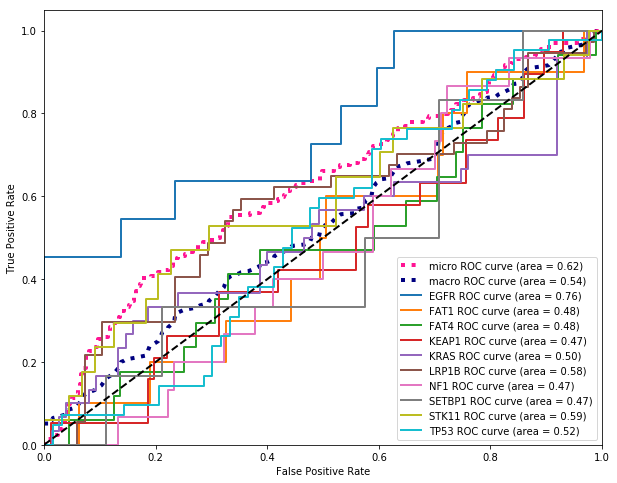

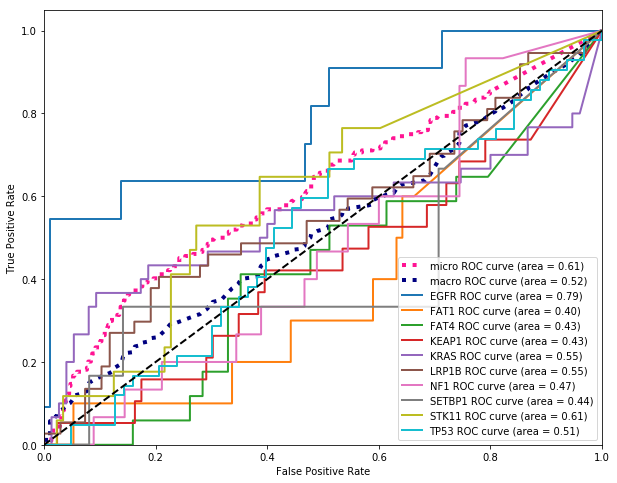

In [23]:
roc_curves_batch = join(roc_curves, '_300000')

roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base, roc_curves_batch)

roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base, roc_curves_batch)




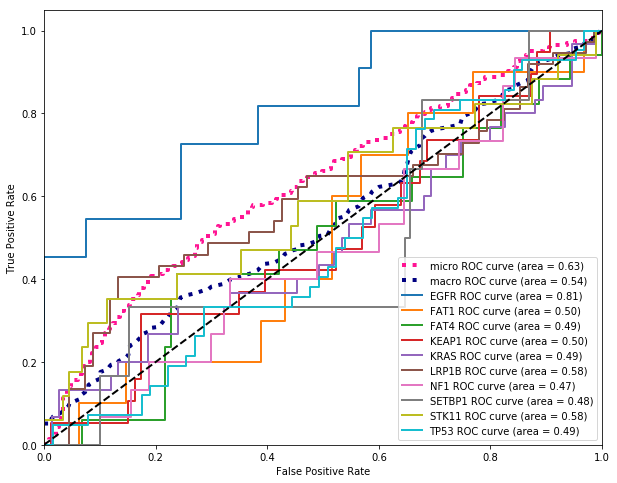

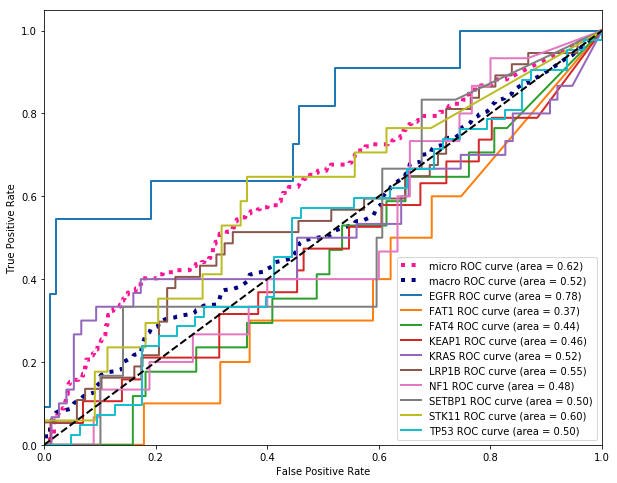

In [22]:
with open(join(intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = str(batches + int(checkpoint_path.split('-')[-1]))
roc_curves_batch = join(roc_curves, '_' + completed)

roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base, roc_curves_batch)

roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base, roc_curves_batch)


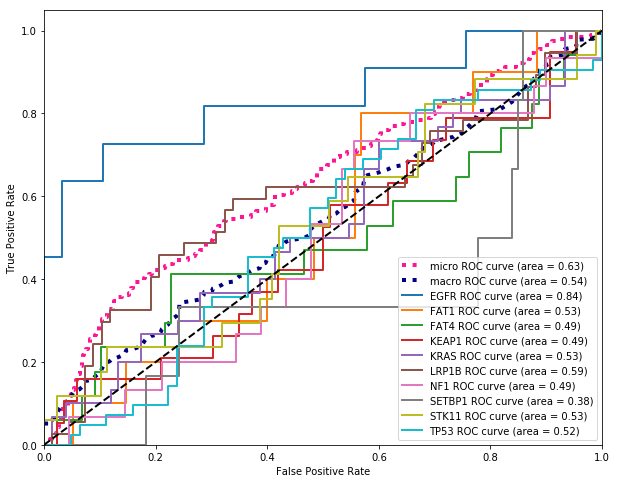

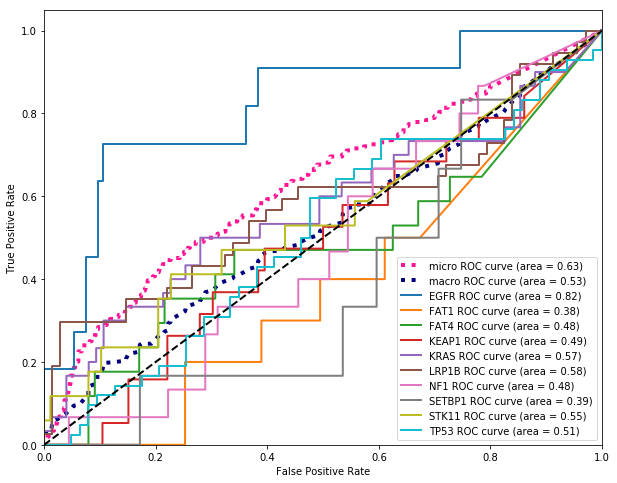

In [9]:
#with open(join(intermediate_checkpoints,'checkpoint')) as f: 
#    checkpoint_path = f.readline().split('"')[1]
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
completed = "5000"
roc_curves_batch = join(roc_curves, '_' + completed)

roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base, roc_curves_batch)

roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base, roc_curves_batch)


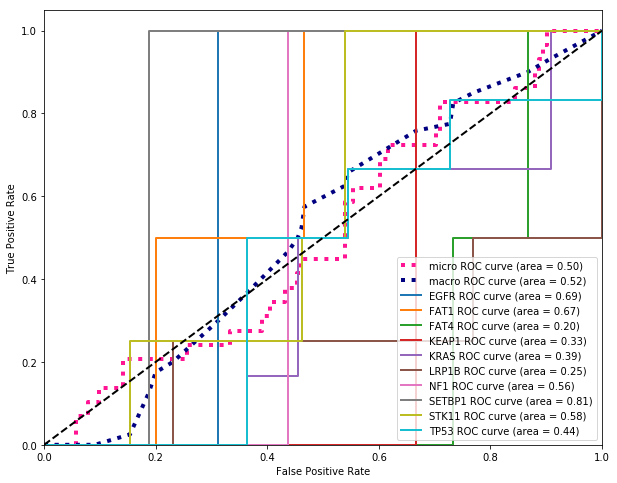

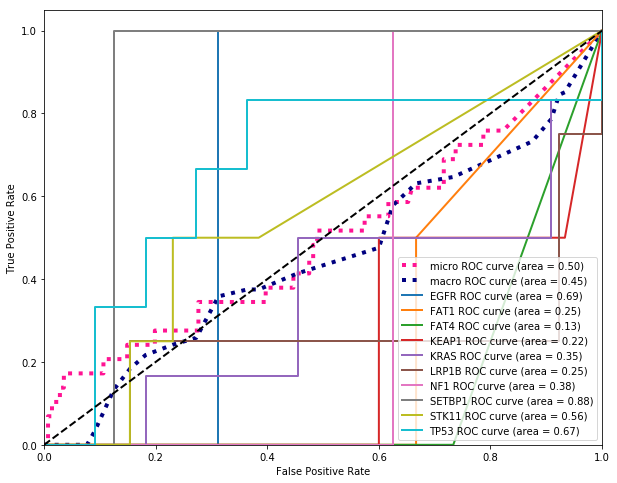

In [14]:
#with open(join(intermediate_checkpoints,'checkpoint')) as f: 
#    checkpoint_path = f.readline().split('"')[1]
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
completed = "5000"
roc_curves_batch = join(roc_curves, '_' + completed)

roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base, roc_curves_batch)

roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base, roc_curves_batch)
